# ***Skin Lesion Segmentation with Deep Learning***

In this notebook we will train segmentation models on the Original ISIC2017 dataset. It contains: 

*   Training: 2000 images 
*   Validation: 150 images
*   Test: 200 images



 

 








Check GPU type

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Jun 23 09:02:26 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Libraries**

## *Install*

In this section we install libraries that are not included in Google Colab

In [ ]:
!pip install bayesian-optimization # library for threshold optimization

In [ ]:
!pip uninstall opencv-python-headless==4.5.5.64
!pip install opencv-python-headless==4.5.2.52 
!pip install git+https://github.com/albumentations-team/albumentations # we need this version, it is not available in pip

## *Import*

In this section we import the packages and libraries for future use

In [ ]:
# General
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, ImageOps 
from skimage import io
import cv2 as cv
from google.colab.patches import cv2_imshow
import math
import copy
import logging
import sys

# Sci-kit learn
from sklearn.metrics import jaccard_score

#Pytorch 
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.functional import Tensor
import torch.optim as optim
from torchvision import transforms
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter

# progress tracking 
from tqdm import tqdm

# data augmentation 
import albumentations as A

# Library for threshold optimization 
from bayes_opt import BayesianOptimization

# **Helper functions**



In this section we define different utils/helper function that will be usefull for the rest of the notebook

In [ ]:
# logging info
logging.basicConfig(filename="/content/drive/MyDrive/Tensorboard_segmentation/log_od_after_fix.txt", level=logging.INFO,
                        format='[%(asctime)s.%(msecs)03d] %(message)s', datefmt='%H:%M:%S')
logging.getLogger().addHandler(logging.StreamHandler(sys.stdout))

##  *Visualization*

In [ ]:
# A Function that uses Matplotlib's PyPlot to show an image stored in a pytorch tensor 
def imshow(inp, title=None, mask= False):
    """Imshow for Tensor.
       A Function that uses Matplotlib's PyPlot to show an image stored in a pytorch tensor 
       inputs: inp => image stored in tensor 
               title => title to be displayed with the image 
       returns: None

    """
    inp = inp.numpy().transpose((1, 2, 0))
    if not mask:
      #denormalize
      mean = np.array([0.7079, 0.5916, 0.5469])
      std = np.array([0.0937, 0.1113, 0.1257])
      inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

## *Loss functions*



In this section we implement loss functions that are not available in Pytorch's nn module

### Jaccard Loss

This objective function is given by (1 - Jaccard Score) where the Jaccard Score is given by the following formula (Intersection over Union):
 
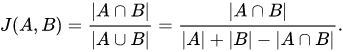 

In [ ]:
class JaccardLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(JaccardLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1e-4):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs =  torch.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        #intersection is equivalent to True Positive count
        #union is the mutually inclusive area of all labels & predictions 
        intersection = (inputs * targets).sum()
        total = (inputs + targets).sum()
        union = total - intersection 
        
        IoU = (intersection + smooth)/(union + smooth).clamp_min(1e-8)
                
        return 1 - IoU

### Dice with Binary Cross Entropy 



This loss function is a combination of the Dice loss and the Binary Cross Entropy loss. 

It is given by the sum of the dice loss and the BCE loss. 

+ The Dice loss is given by (1 - DCS) with the DCS (Dice score) given by the following formula: 

Dice.svg


+ The BCE Loss on the other hand is given by: 

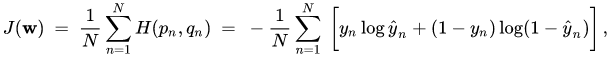

(Special case of the cross entropy loss when we have only 1 object to segment (2 classes: 1 object + the background


* Combining the two objective functions allows for some diversity in the loss, while benefitting from the stability of BCE which is the standard loss function used for segmentation. 



In [ ]:
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        # Calculate BCE Loss (after a softmax that is applied internally) using the official function from PyTorch
        BCE = F.binary_cross_entropy_with_logits(inputs, targets, reduction='mean')
        
        # Calculate Dice Loss
        inputs = torch.sigmoid(inputs) # Apply the sigmoid activation function 
        intersection = (inputs * targets).sum()  # computer the intersecction between the label and target                         
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth) # dice loss = 1 - DCS  
        
        # Combine losses 
        Dice_BCE = BCE + dice_loss
        
        return Dice_BCE

## Evaluation metrics

### Jaccard Score



This function computes the Jaccard Score obtained from the segmentation of all images in a dataloader given by a model according to a given threshold. 

The Jaccard Score is given by the following formula (Intersection over Union):
 
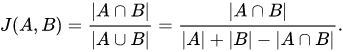 

In [ ]:
# A function that calculates the average Jaccard Score for all images in a dataloader
def check_js(loader, model, threshold= 0.5, device="cuda"):
  """
    Parameters: 
      * loader: a pytorch dataloader containing the images to be segmented and their corresponding GT 
      * model: the DL model used to segment the images 
      * threshold: a value between 0 and 1 used to threshold the segmentation result of the model. 
                  (values lower than threshold are mapped to 0, values higher than threshold are mapped to 1)
      * device: "cuda" if we want to use the GPU, "cpu" otherwise
  """
  model.eval() # Switch model to evaluation mode 
  j = 0; # initial Jaccard counter

  with torch.no_grad(): # do not calculate gradients in evaluation
        for batch in loader: # for each batch in the data loader do the following:
            x, y = batch['image'], batch['mask']
            x = x.float().to(device)

            preds = torch.sigmoid(model(x)) # Calculate predictions given by the model
            # Next the binary mask is obtained
            preds = (preds > threshold).int() # consider pixels with value higher than threshold to be part of the lesion, others are background
            y = y.cpu().numpy().reshape(-1)
            preds = preds.cpu().numpy().reshape(-1)

            j += jaccard_score(y, preds) # Calculation of the Jaccard score and summing it to all other batches.

        js = j/len(loader) # calculating the average Jaccard score

  model.train() # swich model back to train mode 
  return js

In [ ]:
# Jaccard score for 1 image
def js(gt, pred):
  """Jaccard score for 1 image"""
  gt = gt.reshape(-1) # flatten the ground truth
  preds = pred.reshape(-1) # flatten the predicted mask

  return jaccard_score(gt, preds)  # calculate the jaccard score

In [ ]:
# function that reverses the MakeSquare transform.
def rescal_to_original_size(x_o, y_o , segmentation):
  """
    Parameters: 
      x_o : original height of the image 
      y_o : original width of the image
      segmentation : the segmentation mask to be resized to the original size of the image
  """
  size_o = max(x_o, y_o) # retrieve the maximum between the height and width
  square_o = TF.resize(segmentation, size_o) # rescale the segmentation square to the max size of the image
  seg_o = TF.center_crop(square_o, [y_o, x_o]) # remove the padding by taking the center of the square (the dimesions are (y,x) for the crop function)

  return seg_o

In [ ]:
# The same as js but it calculates the Jaccard score in the original size
def check_js_original_size(loader, model, threshold, seg_folder, device="cuda"):
    """
    Parameters: 
      * loader: a pytorch dataloader containing the images to be segmented and their corresponding GT 
      * model: the DL model used to segment the images 
      * threshold: a value between 0 and 1 used to threshold the segmentation result of the model. 
                  (values lower than threshold are mapped to 0, values higher than threshold are mapped to 1)
      * device: "cuda" if we want to use the GPU, "cpu" otherwise
    returns: jc_avg => average jaccard calculated on the test set after resizing to the original size
  """
  model.eval() # Switch model to evaluation mode 
  jc = 0; # initial Jaccard counter
  count = 0 # counter to keep track of the number of images processed 
  with torch.no_grad(): # do not calculate gradients in evaluation
        for batch in loader: # for each batch in the data loader do the following:
            img, img_id = batch['image'], batch['id']
            img = img.float().to(device)

            preds = torch.sigmoid(model(img)) # Calculate predictions given by the model

            for i in range(0, img.shape[0]): # for each image in the batch
                mask_path = seg_folder + img_id[i] + '_segmentation.png' # get the path of the original mask from the image id
                msk = Image.open(mask_path).convert('1') # open original mask
                
                pred = preds[i, :, :, :] # get predicted mask of the current image
                pred = (pred >= threshold).int() # binarize mask
                x_o, y_o = msk.size # retrieve the original size of the image
                pred_o = rescal_to_original_size(x_o, y_o, pred).cpu().numpy().transpose((1, 2, 0)) # rescale the predicted mask to the same size of the image
                mask_o = np.array(msk) # convert the original PIL Image mask to numpy
                jacc = js(mask_o , pred_o) # calculate the jaccard for the current image
                jc += jacc # add the current img's jaccard to the sum
                count +=1 # increment the counter 
  
  jc_avg = jc/count # calculating the average Jaccard score
  return jc_avg

### Dice Score



This function calculates the Dice score of a segmented image given by the formula:

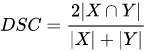

This is a soft version that works with probability maps not binary masks. 

it is given by 2 x Sum(pred x label)/Sum(pred + label) 

In [ ]:
# function to calculate the dice score of an output of a model (logits result)
def get_dice(inputs, targets, smooth = 0.00004):
  """
    Parameters: 
      * inputs: the segmentation result of the model for an image or a batch of images 
      * targets: the corresponding GT of the given image/batch
      * smooth: a small number used to avoid division by 0
    returns: dice score
  """
  # Apply sigmpoid on the inputs to obtain pixel membership probabilities (between 0 and 1)
  inputs = torch.sigmoid(inputs)       
        
  #flatten label and prediction tensors
  inputs = inputs.view(-1)
  targets = targets.view(-1)
        
  intersection = (inputs * targets).sum()    # calculate soft intersection                        
  dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth) # calculate soft dice
  return dice

## *Testing*

In [ ]:
# A function to evalute the average dice score and the loss for all the images in a dataloader
def evaluate(net, dataloader, criterion, device):
    """
      Parameters: 
        * net: the DL model to be evaluated 
        * dataloader: pytorch dataloader containing the images to be segmented and their corresponding manual GT 
        * criterion: the loss function 
        * device: "cuda" if the GPU is used, "CPU" otherwise
      returns: average dice score and average loss on the dataloader
    """
    net.eval() # Switch net to evaluation mode
    num_val_batches = len(dataloader) # get the number of batches in dataloader
    dice_score = 0 # initialize dice sum counter
    loss = 0 # initialize loss sum counter
    # iterate over each batch the validation set (dataloader)
    with tqdm(total=num_val_batches , desc=f'Valid', unit='img') as pbar:
      for batch in dataloader:
        image, gt = batch['image'], batch['mask'] 
        # move images and labels to correct device with the correct type
        image = image.to(device=device, dtype=torch.float32)
        gt = gt.unsqueeze(1).to(device=device)

        with torch.no_grad(): # Do not calculate gradient during validation
          
          pred = net(image) # predict the mask
          pbar.update(image.shape[0]) # update the progress bar
          loss_b = criterion(pred.view(-1), gt.view(-1)) # calculate the loss of the current batch
          loss += loss_b
          
          d = get_dice(pred, gt) # calculate the dice
          dice_score += d
        pbar.set_postfix(**{'dice ': d.item(), 'loss ': loss_b.item()})
    
    if num_val_batches == 0:
        dice_score_avg = dice_score
        loss_avg = loss

    else:
        dice_score_avg = dice_score / num_val_batches
        loss_avg = loss / num_val_batches

    net.train() # Switch model back to train mode
    return dice_score_avg , loss_avg # return the average dice and average loss

In [ ]:
# Function to segment 1 image using a given model and a threshold
def predict(image, model, threshold):
  """
    function to predict the segmentation mask on 1 image 
    inputs: image => image to be segmented 
            model => model to be used for predicting the mask
            threshold => threshold used to binarize the mask 
    output: p: binary segmentation mask predicted for the image 
  """
  image = image.unsqueeze(0).float().to(DEVICE) # add a batch dimension to the image and transfer it to the device
  preds = torch.sigmoid(model(image)) # Computer the segmentation prediction given by the
  preds = (preds > threshold).int() # binarize the segmentation using the threshold

  preds = preds[0, :, :, :] # extract the segmentation from the output
  preds = preds.cpu().detach().numpy().transpose((1, 2, 0))*255 # convert from Tensor to Numpy image

  p =  preds.astype(np.uint8)

  return p.squeeze(axis=2) 

## *Training*

In [ ]:
# function to train a model
def train_net(net, # the model to be trained
              device, # cuda or cpu
              train_loader,  # training dataloader
              val_loader, # validation data loader
              early_stop_patience, # stop training if val loss does not improve after this much steps
              optimizer, 
              grad_scaler,# gradient scaler
              scheduler, # learning rate scheduler
              criterion, # Objectve/loss function t be minimized
              writer_path, # folder to track metrics
              epochs: int = 5, # number of epochs
              save_checkpoint: bool = True, # whether to save the final model asa file  or not 
              checkpoint_path= '', # where to save the model
              amp: bool = False): # Cuda automatic mixed precision flag

    train_writer =  SummaryWriter(f'{writer_path}/log')
    val_writer = SummaryWriter(f'{writer_path}/log_val')


    best_val_loss = np.inf # As worse as it gets
    best_val_dice = 0.0 # As worse as it gets
    best_parameters = net.state_dict() # Initialize to current model's weights 
    early_stop_count = 0 # to keep track of loss improvement
    # Begin training
    for epoch in range(epochs): # iterate over all data in the dataloader => Epoch
        net.train() # switch model to train mode
        epoch_loss = 0.0 # to keep track of the loss 
        epoch_dice = 0.0 # to keep track of the dice score
        loop = tqdm(enumerate(train_loader), total=len(train_loader))
        loop.set_description(f'Epoch {epoch + 1}/{epochs}') 
        for batch_idx, batch in loop: # iterate over each batch in the training loader
                images = batch['image'] 
                masks = batch['mask']

                images = images.to(device=device, dtype=torch.float32)
                gt = masks.to(device=device, dtype=torch.float32)

                with torch.cuda.amp.autocast(enabled=amp): 
                    pred = net(images) # forward pass
                    # calculate the loss of the current batch
                    loss = criterion(pred, gt)
                    d = get_dice(pred, gt) # calculate the dice
                    epoch_dice += d
             
                optimizer.zero_grad() # set gradients to zero 
                grad_scaler.scale(loss).backward() # backpropagation
                grad_scaler.step(optimizer) # calculte gradients 
                grad_scaler.update() # update network weights


                epoch_loss += loss.item() # get epoch loss
                loop.set_postfix(**{'loss (batch) ': loss.item()})

        epoch_dice = epoch_dice/len(train_loader)
        epoch_loss = epoch_loss/len(train_loader)

        logging.info( '\tEpoch %d : training loss = %.5f, training dice = %.5f' %
                (epoch+1, epoch_loss, epoch_dice))
            
        # Validate the results every few epochs
        val_dice, val_loss = evaluate(net, val_loader, criterion, device) # obtain validation dice
        scheduler.step(val_loss) # Use validation loss to update learning rate
        lr_ = optimizer.param_groups[0]['lr']
        train_writer.add_scalar('info/lr', lr_, epoch)
        logging.info( '\tEpoch %d : validation loss = %.5f, validation dice = %.5f' %
                (epoch+1, val_loss, val_dice))
        
        train_writer.add_scalar('info/loss', epoch_loss, epoch)
        train_writer.add_scalar('info/dice', epoch_dice, epoch)

        val_writer.add_scalar('info/loss', val_loss, epoch)
        val_writer.add_scalar('info/dice', val_dice, epoch)
        
        if val_loss < best_val_loss: # update best parameters
            best_val_loss = val_loss
            early_stop_count = 0
        else:
          early_stop_count += 1 # if no improvement, increase the early stopping counter

        if val_dice > best_val_dice: # update best parameters
            best_val_dice = val_dice
            best_parameters = copy.deepcopy(net.state_dict())

        # if no improvement in the previous {early_stop_patience} epochs, stop training, the model is probably overfitting or it reached its limit    
        if early_stop_count > early_stop_patience: 
          print(f"EARLY STOPPING AFTER {epoch+1} EPOCHS")
          break

        
    logging.info( 'Best validation loss = %.5f' % (best_val_loss))
    logging.info( 'Best validation dice = %.5f' % (best_val_dice)) 
    print("\n")
    train_writer.close()
    val_writer.close()
    net.load_state_dict(best_parameters)
    # save the weight of the model that gave the best validation results
    if save_checkpoint:
        torch.save(best_parameters, checkpoint_path)

    

# **Dataset Definition**

## Custom ISIC2017 Dataset

Next, we create a custom Pytorch dataset class for ISIC2017 data

In [ ]:
# Parameters 
# Please change to the corresponding path if not the same in your device
dataset_folder = '/content/drive/MyDrive/MRTYUTeam/Dataset'
train_img_folder = dataset_folder + '/images'
train_seg_folder = dataset_folder + '/masks'
train_csv_path = dataset_folder + '/train_2000.csv'

val_img_folder = dataset_folder + '/validation_images'
val_seg_folder = dataset_folder + '/validation_masks'
val_csv_path = dataset_folder + '/validation_150.csv'

test_img_folder = dataset_folder + '/test_images'
test_seg_folder = dataset_folder + '//test_masks'
test_csv_path = dataset_folder + '/test_600.csv'

In [ ]:
# This will be used in normal RAM mode (we fetch the images only when needed)
class ISIC2017Dataset(Dataset):
    """ISIC2017 dataset"""

    def __init__(self, csv_file, image_folder, segmentation_folder, img_transform=None, mask_transform = None, augment = False):
        """
        Args:
            csv_file (string): Path to the csv file with image paths & classification labels.
            image_folder (string): Path to the folder where the PNG images are located
            segmentation_folder (string): Path to the folder where the segmentation labels are located
            img_transform (callable, optional): Optional transform to be applied on an image.
            seg_transform (callable, optional): Optional transform to be applied on an mask.
            augment (boolean): whether to apply online data augmentation
        """
        self.path_df = pd.read_csv(csv_file) # pandas dataframe containing the image IDs
        self.image_folder = image_folder # path to the folder containing the original images 
        self.segmentation_folder = segmentation_folder # path to the folder containing the GT images
        self.img_transform = img_transform # image transform for the images 
        self.mask_transform = mask_transform # image transform for the masks
        self.augment = augment # whether to perform data augmentation or not         

    def __len__(self):
        return len(self.path_df) # return the number of images in the dataset

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

       
        img_id = '/' + self.path_df.iloc[idx]['image_id'] # obtain image file name start 
        
        img_path = self.image_folder+img_id + '.jpg' # file path of the original image 
        image = Image.open(img_path)  # open the original image as RGB

        
        mask_path = self.segmentation_folder+ img_id + '_segmentation.png' # file path of the mask
        mask = Image.open(mask_path).convert('1') # open the GT segmentation mask as binary

        if self.augment:
          image_np = np.array(image).astype(np.uint8) # Albumentation works with np arrays so convert from PIL image
          mask_np = np.array(mask).astype(np.uint8)
        
          aug_transform = A.Compose(
              [
                # Data Augmentation
                A.RandomRotate90(p=0.7),
                A.HorizontalFlip(p=0.5),
                A.VerticalFlip(p=0.5)
              ]
          )

          augmentations = aug_transform(image=image_np, mask=mask_np*255) # apply the data augmentation transform
          image = Image.fromarray(augmentations["image"]) # get the new image
          mask = Image.fromarray(augmentations["mask"]) # get the new mask

        # If a transform is provided apply it (Preprocessing)
        if self.img_transform:
            image = self.img_transform(image)

        if self.mask_transform:
            mask = self.mask_transform(mask)

        # return the image, the segmentation label
        return {
            'image': image,
            'mask': mask,
            'id':  img_id 
          }

## *Data Transforms & Preprocessing*




- In this section we define custom data transforms that we will use to preprocess the images before feeding them to the network

--> In this transform we convert a rectangular image to a square image by padding 0s in order to keep the aspect ratio when resizing to a smaller square to feed the model

In [ ]:
# Pad to square size: 
class MakeSquare(object):
    def __init__(self, is_mask):
        self.is_mask = is_mask
    def __call__(self, img):
        x, y = img.size # obtain the number of rows x and columns y of the image 
        size = max(x, y) # the new size is the largest of the two dimensions
        if self.is_mask:
            new_im = Image.new('1', (size, size), 0) # if the input is a segmentation mask (1 channel) initialize the new image to all black (0)

        else:
            new_im = Image.new('RGB', (size, size), (0, 0, 0)) # if the input is an original image (RGB) initialize the new square image to all white

        new_im.paste(img, (int((size - x) / 2), int((size - y) / 2))) # copy the original input to the middle of the new image 
        return new_im # return the new image

In [ ]:
# df = pd.read_csv(train_csv_path)

# mean = torch.zeros((1,3))
# stdv = torch.zeros((1,3))
# for idx, row in df.iterrows():
#   img_id = '/' + row['image_id'] # obtain image file name start 
#   img_path = train_img_folder+ img_id + '.jpg' # file path of the original image 
#   img = cv.imread(img_path)
#   img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
#   img = TF.to_tensor(img)



#   mean += torch.mean(img, axis = [1,2])
#   stdv += torch.std(img, axis = [1,2])

# mean = mean/len(df)
# stdv = stdv/len(df)
# print(f"mean: {mean}")
# print(f"std: {stdv}")


##### Results 
# mean: tensor([[0.7079, 0.5916, 0.5469]])
# std: tensor([[0.0937, 0.1113, 0.1257]])

# **Model Architectures** 

In this section we define the model architectures using PyTorch

## U-Net

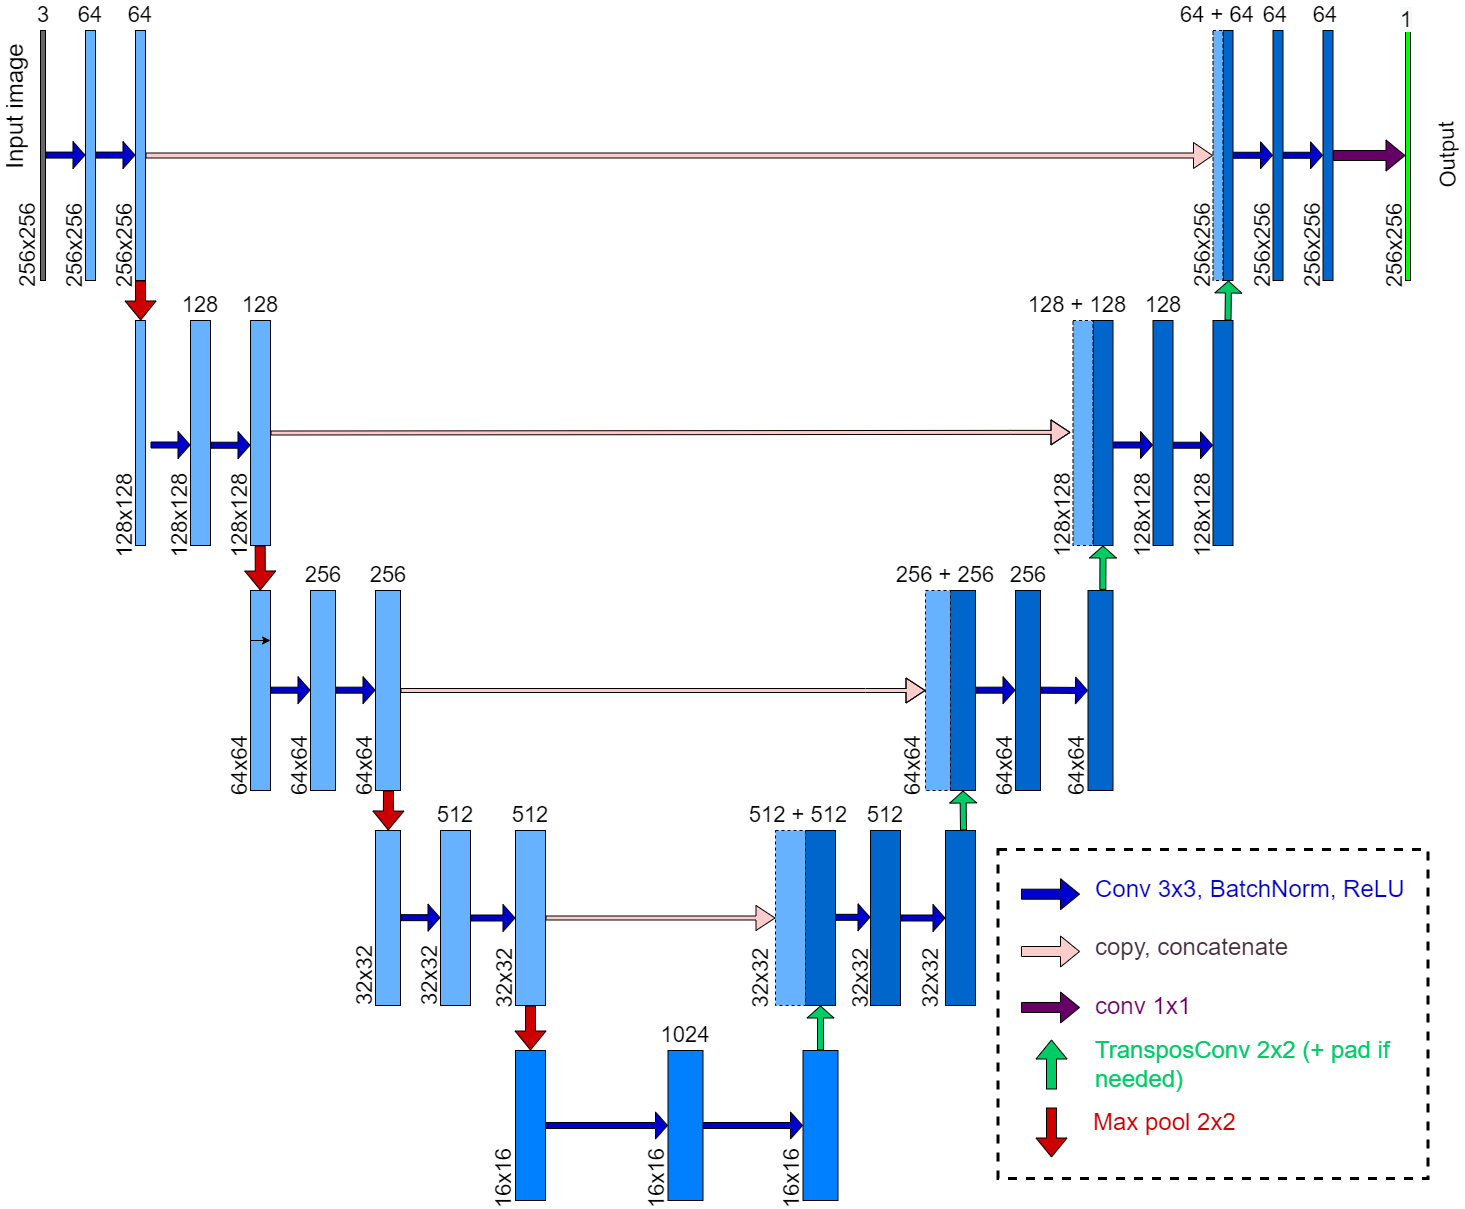

reference: https://github.com/milesial/Pytorch-UNet/blob/master/unet/unet_model.py

In [ ]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=False):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            # use transpose-convolution (returns a larger image with less channels) 
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1) # make the input larger in HW and less in C
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        # pad the input x1 to have the same size as x2 (coming from the encoder)
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        x = torch.cat([x2, x1], dim=1) # concatenate x2 coming from the encoder and x1 the decoder's current input 
        return self.conv(x)

# last layer, 1 convolution with 1*1 kernel
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [ ]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels # number of channels in the input
        self.n_classes = n_classes # number of objects to be segmented, in our case 1 => the lesion
        self.bilinear = bilinear # whether to use bilinear upsampling or transposed convolution at the decoder for upsampling 

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        # Encoder
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

        # Decoder
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)

        # last conv layer
        logits = self.outc(x)
        return logits

In [ ]:
model = UNet(3, 1).to(DEVICE)
summary(model, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,728
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
            Conv2d-4         [-1, 64, 256, 256]          36,864
       BatchNorm2d-5         [-1, 64, 256, 256]             128
              ReLU-6         [-1, 64, 256, 256]               0
        DoubleConv-7         [-1, 64, 256, 256]               0
         MaxPool2d-8         [-1, 64, 128, 128]               0
            Conv2d-9        [-1, 128, 128, 128]          73,728
      BatchNorm2d-10        [-1, 128, 128, 128]             256
             ReLU-11        [-1, 128, 128, 128]               0
           Conv2d-12        [-1, 128, 128, 128]         147,456
      BatchNorm2d-13        [-1, 128, 128, 128]             256
             ReLU-14        [-1, 128, 1

## Attention U-Net

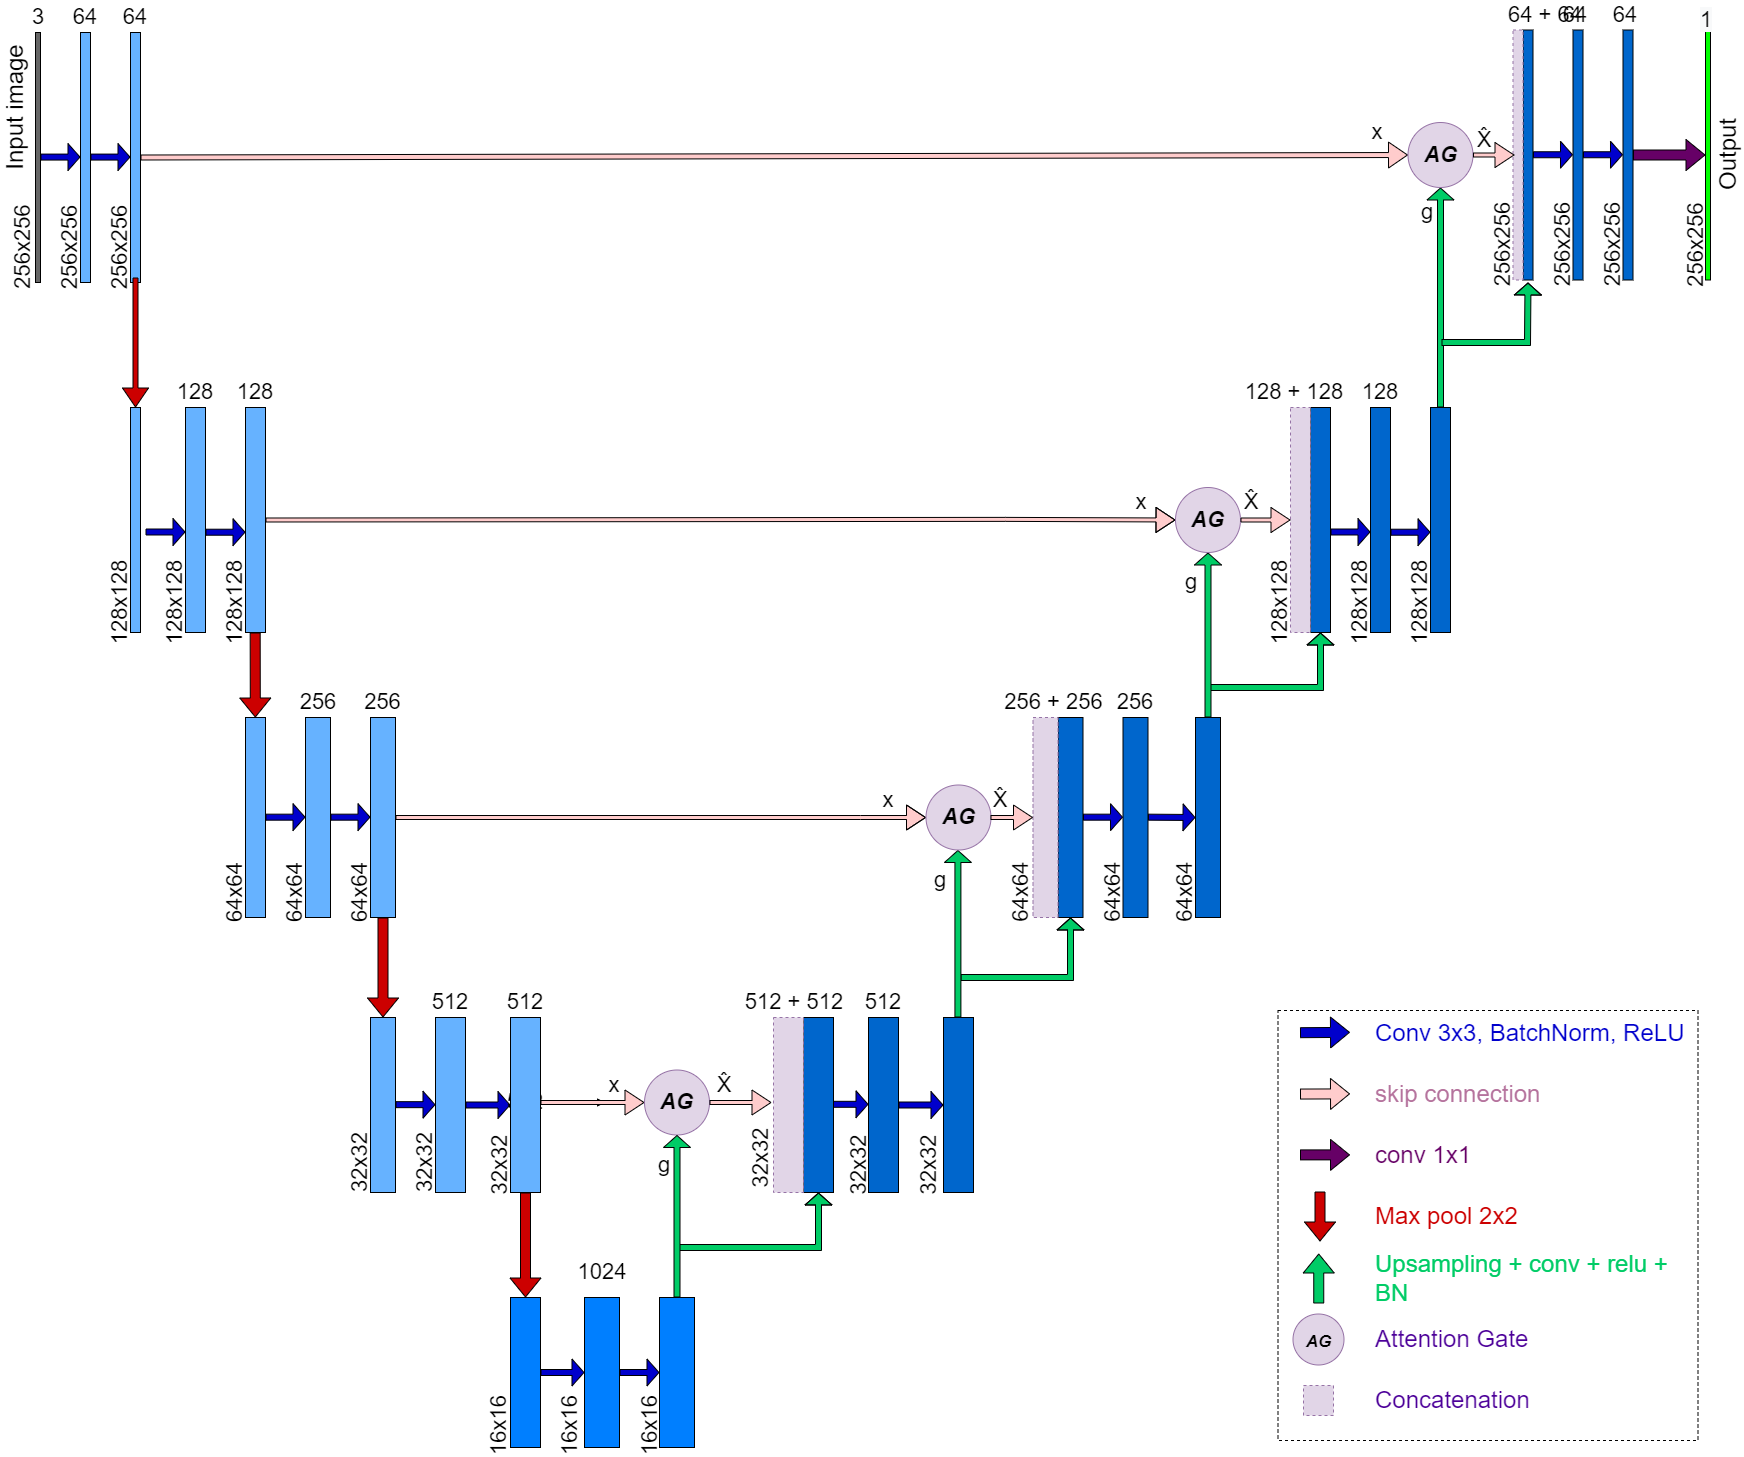

reference: https://github.com/LeeJunHyun/Image_Segmentation

In [ ]:
# Double Convolution, each followed by a Batch Normalization and ReLU
class conv_block(nn.Module):
    def __init__(self,ch_in,ch_out):
        super(conv_block,self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(ch_in, ch_out, kernel_size=3,stride=1,padding=1,bias=True),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True),
            nn.Conv2d(ch_out, ch_out, kernel_size=3,stride=1,padding=1,bias=True),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True)
        )


    def forward(self,x):
        x = self.conv(x)
        return x

# Up-convolution at the decoder level
class up_conv(nn.Module):
    def __init__(self,ch_in,ch_out):
        super(up_conv,self).__init__()
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(ch_in,ch_out,kernel_size=3,stride=1,padding=1,bias=True),
		        nn.BatchNorm2d(ch_out),
			      nn.ReLU(inplace=True)
        )

    def forward(self,x):
        x = self.up(x)
        return x

# Single convolution for the last layer
class single_conv(nn.Module):
    def __init__(self,ch_in,ch_out):
        super(single_conv,self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(ch_in, ch_out, kernel_size=3,stride=1,padding=1,bias=True),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True)
        )

    def forward(self,x):
        x = self.conv(x)
        return x

# Attention mechanism
class Attention_block(nn.Module):
    def __init__(self,F_g,F_l,F_int):
        super(Attention_block,self).__init__()
        
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(F_int)
            )
        
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self,g,x):
        g1 = self.W_g(g) # map the gating signat to the intermediate space
        x1 = self.W_x(x) # map the input signal to the intermediate space 
        psi = self.relu(g1+x1) # sum x and g and give them to a relu
        psi = self.psi(psi) # compute the attention weights 

        return x*psi # multiply the input with the attention weight and return it 

In [ ]:
class AttU_Net(nn.Module):
    def __init__(self,img_ch=3,output_ch=1):
        super(AttU_Net,self).__init__()
        
        self.Maxpool = nn.MaxPool2d(kernel_size=2,stride=2)

        self.Conv1 = conv_block(ch_in=img_ch,ch_out=64)
        self.Conv2 = conv_block(ch_in=64,ch_out=128)
        self.Conv3 = conv_block(ch_in=128,ch_out=256)
        self.Conv4 = conv_block(ch_in=256,ch_out=512)
        self.Conv5 = conv_block(ch_in=512,ch_out=1024)

        self.Up5 = up_conv(ch_in=1024,ch_out=512)
        self.Att5 = Attention_block(F_g=512,F_l=512,F_int=256)
        self.Up_conv5 = conv_block(ch_in=1024, ch_out=512)

        self.Up4 = up_conv(ch_in=512,ch_out=256)
        self.Att4 = Attention_block(F_g=256,F_l=256,F_int=128)
        self.Up_conv4 = conv_block(ch_in=512, ch_out=256)
        
        self.Up3 = up_conv(ch_in=256,ch_out=128)
        self.Att3 = Attention_block(F_g=128,F_l=128,F_int=64)
        self.Up_conv3 = conv_block(ch_in=256, ch_out=128)
        
        self.Up2 = up_conv(ch_in=128,ch_out=64)
        self.Att2 = Attention_block(F_g=64,F_l=64,F_int=32)
        self.Up_conv2 = conv_block(ch_in=128, ch_out=64)

        self.Conv_1x1 = nn.Conv2d(64,output_ch,kernel_size=1,stride=1,padding=0)


    def forward(self,x):
        # encoding path
        x1 = self.Conv1(x)

        x2 = self.Maxpool(x1)
        x2 = self.Conv2(x2)
        
        x3 = self.Maxpool(x2)
        x3 = self.Conv3(x3)

        x4 = self.Maxpool(x3)
        x4 = self.Conv4(x4)

        x5 = self.Maxpool(x4)
        x5 = self.Conv5(x5)

        # decoding + concat path
        d5 = self.Up5(x5) # Upsample
        x4 = self.Att5(g=d5,x=x4) # Attention Block 
        d5 = torch.cat((x4,d5),dim=1) # Concatenate current result d5 with the result of the corresponding encoder layer with attention x4
        d5 = self.Up_conv5(d5) # Apply a double convolution
        
        # Repeat
        d4 = self.Up4(d5)
        x3 = self.Att4(g=d4,x=x3)
        d4 = torch.cat((x3,d4),dim=1)
        d4 = self.Up_conv4(d4)

        d3 = self.Up3(d4)
        x2 = self.Att3(g=d3,x=x2)
        d3 = torch.cat((x2,d3),dim=1)
        d3 = self.Up_conv3(d3)

        d2 = self.Up2(d3)
        x1 = self.Att2(g=d2,x=x1)
        d2 = torch.cat((x1,d2),dim=1)
        d2 = self.Up_conv2(d2)

        # Last convolution layer with kernel size 1
        d1 = self.Conv_1x1(d2)

        return d1

In [ ]:
# model = AttU_Net().to(DEVICE)
# summary(model, (3, 256, 256)) # does not work with attention gates 

## ResNet-UNet ( With Transfer Learning)

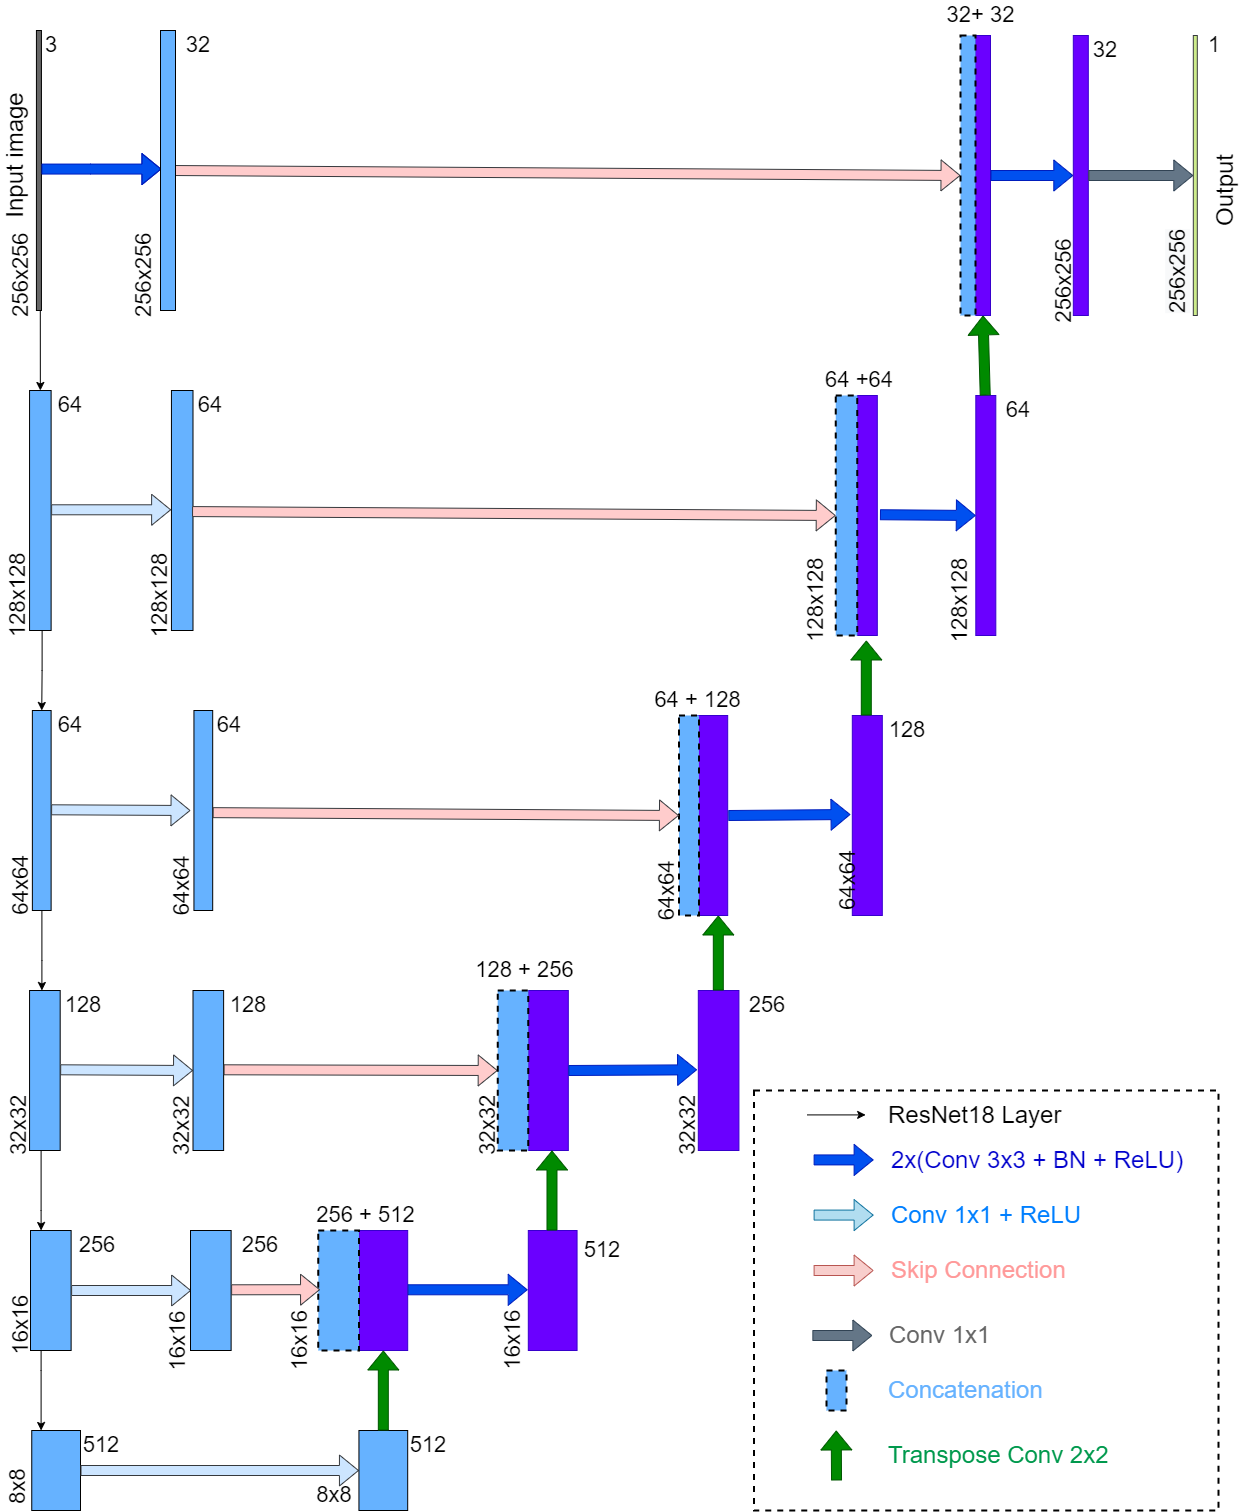

References: 

https://github.com/usuyama/pytorch-unet

https://github.com/zhoudaxia233/PyTorch-Unet

A Unet model with a pre-trained ResNet18 as a backbone (encoder) 

In [ ]:
# function that initializes the weights of a model with Kaiming for Conv layers and constants for BN layers
def weights_init(module_obj):
    for m in module_obj.modules():
        if isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        elif isinstance(m, nn.BatchNorm2d):
            nn.init.constant_(m.weight, 1)
            nn.init.constant_(m.bias, 0)

# 2x(Conv => BN => ReLU)
def double_conv_fn(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )

# Conv => Relu 
def convrelu_fn(in_channels, out_channels, kernel, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
        nn.ReLU(inplace=True)    
  )


class ResNetUNet(nn.Module):

    def __init__(self, n_class, pretrained = True):
        super().__init__()
        
        self.base_model = torchvision.models.resnet18(pretrained=pretrained) # retrieve pre-trained resnet18
        
        self.base_layers = list(self.base_model.children())                
        
        self.layer0 = nn.Sequential(*self.base_layers[:3]) # size=(N, 64, x.H/2, x.W/2)
        self.layer0_1x1 = convrelu_fn(64, 64, 1, 0)
        weights_init(self.layer0_1x1)
        self.layer1 = nn.Sequential(*self.base_layers[3:5]) # size=(N, 64, x.H/4, x.W/4)        
        self.layer1_1x1 = convrelu_fn(64, 64, 1, 0)       
        weights_init(self.layer1_1x1)
        self.layer2 = self.base_layers[5]  # size=(N, 128, x.H/8, x.W/8)        
        self.layer2_1x1 = convrelu_fn(128, 128, 1, 0)  
        weights_init(self.layer2_1x1)
        self.layer3 = self.base_layers[6]  # size=(N, 256, x.H/16, x.W/16)        
        self.layer3_1x1 = convrelu_fn(256, 256, 1, 0)  
        weights_init(self.layer3_1x1)
        self.layer4 = self.base_layers[7]  # size=(N, 512, x.H/32, x.W/32)
        self.layer4_1x1 = convrelu_fn(512, 512, 1, 0)  
        weights_init(self.layer4_1x1)
        
        self.upsample4 = nn.ConvTranspose2d(512, 512, kernel_size=2, stride=2)
        self.upsample3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.upsample2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.upsample1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.upsample0 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        
        self.conv_up3 = double_conv_fn(256 + 512, 512)
        weights_init(self.conv_up3)
        self.conv_up2 = double_conv_fn(128 + 256, 256)
        weights_init(self.conv_up2)
        self.conv_up1 = double_conv_fn(64 + 128, 128)
        weights_init(self.conv_up1)
        self.conv_up0 = double_conv_fn(64+64, 64)
        weights_init(self.conv_up0)
        self.conv_original_size2 = double_conv_fn(32+32, 32)
        weights_init(self.conv_original_size2)

        self.conv_original_size1 =  double_conv_fn(3, 32)
        weights_init(self.conv_original_size1)
        
        self.conv_last = nn.Conv2d(32, n_class, 1)
        weights_init(self.conv_last)
        
    def forward(self, input):
        
        x_original = self.conv_original_size1(input)
        
        #Encoding part
        layer0 = self.layer0(input)            
        layer1 = self.layer1(layer0)
        layer2 = self.layer2(layer1)
        layer3 = self.layer3(layer2)        
        layer4 = self.layer4(layer3)
        
        # Bridge
        layer4 = self.layer4_1x1(layer4) # apply conv before the skip connection

        # Decoding part 
        x = self.upsample4(layer4) # upsample the preceding decoder feat map
        layer3 = self.layer3_1x1(layer3) # apply conv before skip connection to the parallel encoder feat map
        x = torch.cat([x, layer3], dim=1) # concatenate the encoder and decoder feature maps 
        x = self.conv_up3(x) # apply double conv
 
        x = self.upsample3(x)
        layer2 = self.layer2_1x1(layer2)
        x = torch.cat([x, layer2], dim=1)
        x = self.conv_up2(x)

        x = self.upsample2(x)
        layer1 = self.layer1_1x1(layer1)
        x = torch.cat([x, layer1], dim=1)
        x = self.conv_up1(x)

        x = self.upsample1(x)
        layer0 = self.layer0_1x1(layer0)
        x = torch.cat([x, layer0], dim=1)
        x = self.conv_up0(x)
        
        x = self.upsample0(x)
        x = torch.cat([x, x_original], dim=1)
        x = self.conv_original_size2(x)        
        
        out = self.conv_last(x)        
        
        return out

In [ ]:
model = ResNetUNet(1).to(DEVICE)
summary(model, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]             896
       BatchNorm2d-2         [-1, 32, 256, 256]              64
              ReLU-3         [-1, 32, 256, 256]               0
            Conv2d-4         [-1, 32, 256, 256]           9,248
       BatchNorm2d-5         [-1, 32, 256, 256]              64
              ReLU-6         [-1, 32, 256, 256]               0
            Conv2d-7         [-1, 64, 128, 128]           9,408
            Conv2d-8         [-1, 64, 128, 128]           9,408
       BatchNorm2d-9         [-1, 64, 128, 128]             128
      BatchNorm2d-10         [-1, 64, 128, 128]             128
             ReLU-11         [-1, 64, 128, 128]               0
             ReLU-12         [-1, 64, 128, 128]               0
        MaxPool2d-13           [-1, 64, 64, 64]               0
        MaxPool2d-14           [-1, 64,

## ResNet-UNet with Attention

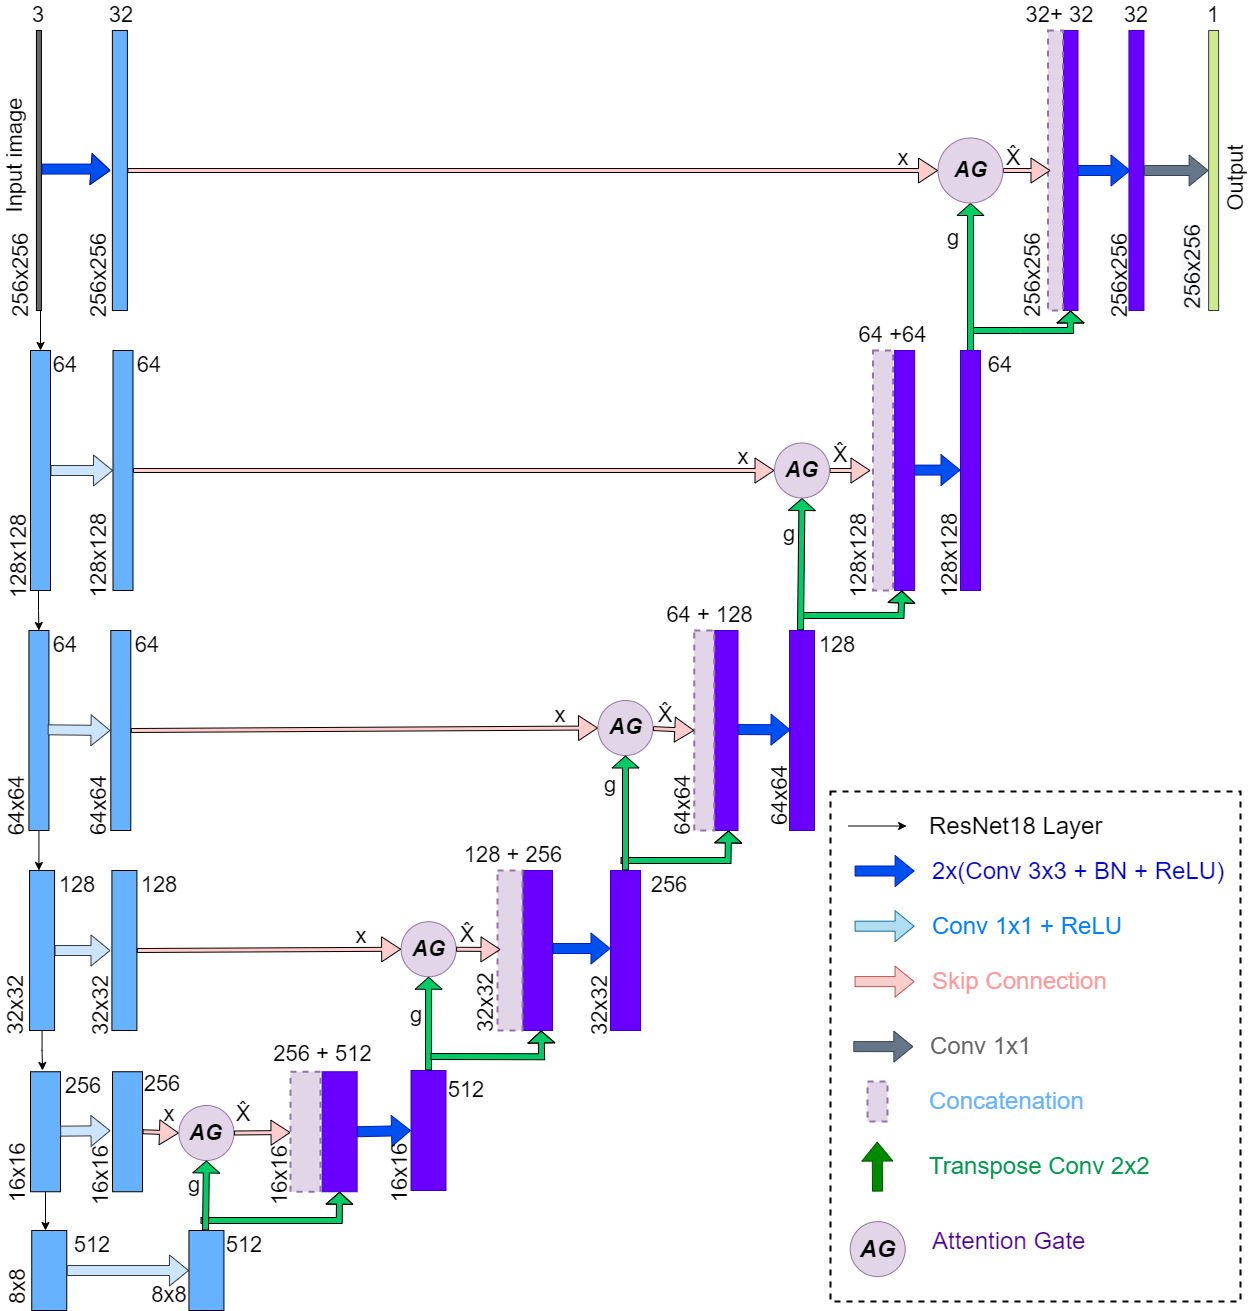

Reference:

https://github.com/usuyama/pytorch-unet

https://github.com/zhoudaxia233/PyTorch-Unet

https://github.com/LeeJunHyun/Image_Segmentation/blob/master/network.py

A Unet model with a pre-trained ResNet18 as a backbone (encoder) with attention mechanism 

In [ ]:
class ResNetUNetAtt(nn.Module):

    def __init__(self, n_class):
        super().__init__()
        
        self.base_model = torchvision.models.resnet18(pretrained=True)
        
        self.base_layers = list(self.base_model.children())                
        
        self.layer0 = nn.Sequential(*self.base_layers[:3]) # size=(N, 64, x.H/2, x.W/2)
        self.layer0_1x1 = convrelu_fn(64, 64, 1, 0)
        weights_init(self.layer0_1x1)
        self.layer1 = nn.Sequential(*self.base_layers[3:5]) # size=(N, 64, x.H/4, x.W/4)        
        self.layer1_1x1 = convrelu_fn(64, 64, 1, 0)       
        weights_init(self.layer1_1x1)
        self.layer2 = self.base_layers[5]  # size=(N, 128, x.H/8, x.W/8)        
        self.layer2_1x1 = convrelu_fn(128, 128, 1, 0)  
        weights_init(self.layer2_1x1)
        self.layer3 = self.base_layers[6]  # size=(N, 256, x.H/16, x.W/16)        
        self.layer3_1x1 = convrelu_fn(256, 256, 1, 0)  
        weights_init(self.layer3_1x1)
        self.layer4 = self.base_layers[7]  # size=(N, 512, x.H/32, x.W/32)
        self.layer4_1x1 = convrelu_fn(512, 512, 1, 0)  
        weights_init(self.layer4_1x1)
        
        self.upsample4 = nn.ConvTranspose2d(512, 512, kernel_size=2, stride=2)
        self.upsample3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.upsample2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.upsample1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.upsample0 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)

        self.Att4 = Attention_block(F_g=512, F_l=256, F_int=256)
        self.Att3 = Attention_block(F_g=256, F_l=128, F_int=128)
        self.Att2 = Attention_block(F_g=128, F_l=64, F_int=64)
        self.Att1 = Attention_block(F_g=64, F_l=64, F_int=64)
        self.Att0 = Attention_block(F_g=32, F_l=32, F_int=32)
        
        self.conv_up3 = double_conv_fn(256 + 512, 512)
        weights_init(self.conv_up3)
        self.conv_up2 = double_conv_fn(128 + 256, 256)
        weights_init(self.conv_up2)
        self.conv_up1 = double_conv_fn(64 + 128, 128)
        weights_init(self.conv_up1)
        self.conv_up0 = double_conv_fn(64+64, 64)
        weights_init(self.conv_up0)
        self.conv_original_size2 = double_conv_fn(32+32, 32)
        weights_init(self.conv_original_size2)

        self.conv_original_size1 =  double_conv_fn(3, 32)
        weights_init(self.conv_original_size1)
        
        self.conv_last = nn.Conv2d(32, n_class, 1)
        weights_init(self.conv_last)
        
    def forward(self, input):
        
        x_original = self.conv_original_size1(input)
        
        layer0 = self.layer0(input)            
        layer1 = self.layer1(layer0)
        layer2 = self.layer2(layer1)
        layer3 = self.layer3(layer2)        
        layer4 = self.layer4(layer3)
        
        layer4 = self.layer4_1x1(layer4)
        x = self.upsample4(layer4)
        layer3 = self.layer3_1x1(layer3)
        layer3 = self.Att4(g=x, x=layer3) # the only difference with ResNet Unet is here, attention is applied 
        x = torch.cat([x, layer3], dim=1) # we concatenate the feature maps of the decoder with the result of the attention gate
        x = self.conv_up3(x)
 
        x = self.upsample3(x)
        layer2 = self.layer2_1x1(layer2)
        layer2 = self.Att3(g=x, x=layer2)
        x = torch.cat([x, layer2], dim=1)
        x = self.conv_up2(x)

        x = self.upsample2(x)
        layer1 = self.layer1_1x1(layer1)
        layer1 = self.Att2(g=x, x=layer1)
        x = torch.cat([x, layer1], dim=1)
        x = self.conv_up1(x)

        x = self.upsample1(x)
        layer0 = self.layer0_1x1(layer0)
        layer0 = self.Att1(g=x, x=layer0)
        x = torch.cat([x, layer0], dim=1)
        x = self.conv_up0(x)
        
        x = self.upsample0(x)
        x_original = self.Att0(g=x, x=x_original)
        x = torch.cat([x, x_original], dim=1)
        x = self.conv_original_size2(x)        
        
        out = self.conv_last(x)        
        
        return out

In [ ]:
# model = ResNetUNetAtt(1).to(DEVICE)
# summary(model, (3, 256, 256))

# **Training & Evaluation**





In this section we will train the different arcitectures  using different hyperparameters

## Prepare data

#### Data Transforms

In [ ]:
# Parameters
NEW_SIZE = (256, 256)

# Calculated from the original training set 
mu = [0.7079, 0.5916, 0.5469]# mean
std = [0.0937, 0.1113, 0.1257]# Standard deviation

In [ ]:
# Transforms for preprocessing, we will use the same for all datasets here
img_transforms = transforms.Compose([
                                    MakeSquare(is_mask= False), # For original images
                                    transforms.Resize(NEW_SIZE),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=mu, std=std)
                                  ]) 

mask_transforms = transforms.Compose([
                                    MakeSquare(is_mask= True), # For segmentation masks 
                                    transforms.Resize(NEW_SIZE),
                                    transforms.ToTensor(),
                                  ])

#### Datasets 

In [ ]:
isic_train = ISIC2017Dataset(csv_file=train_csv_path,
                             image_folder= train_img_folder,
                             segmentation_folder= train_seg_folder, 
                             img_transform = img_transforms,
                             mask_transform = mask_transforms,
                             augment = True) # only augment the train set

isic_val = ISIC2017Dataset(csv_file=val_csv_path, 
                            image_folder= val_img_folder, 
                            segmentation_folder= val_seg_folder,
                            img_transform = img_transforms,
                            mask_transform = mask_transforms,
                            augment = False)

isic_test = ISIC2017Dataset(csv_file=test_csv_path, 
                            image_folder= test_img_folder, 
                            segmentation_folder= test_seg_folder,
                            img_transform = img_transforms,
                            mask_transform = mask_transforms,
                            augment = False)

#### Data Loaders

In [ ]:
# Parameters
TRAIN_BATCH_SIZE = 8
TEST_BATCH_SIZE = 16
VAL_BATCH_SIZE = 16
NUM_WORKERS = 2

In [ ]:
# Dataloaders
train_loader = DataLoader(isic_train, batch_size=TRAIN_BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True) # only shuffle the train set
val_loader = DataLoader(isic_val, batch_size=VAL_BATCH_SIZE, num_workers=NUM_WORKERS, pin_memory=True)
test_loader = DataLoader(isic_test, batch_size=TEST_BATCH_SIZE, num_workers=NUM_WORKERS, pin_memory=True)

#### Visualize some images 

In [ ]:
iterator = iter(train_loader)

In [ ]:
# Get a batch of training data
data = next(iterator)

inputs = data['image']
masks = data['mask']

# Print shapes
print(inputs.shape)
print(masks.shape)

torch.Size([8, 3, 256, 256])
torch.Size([8, 1, 256, 256])


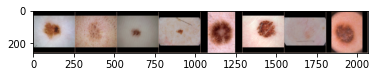

In [ ]:
# Show the original images
ins = torchvision.utils.make_grid(inputs)
imshow(ins)

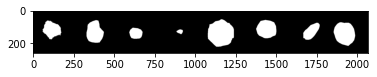

In [ ]:
# Show the corresponding segmentation masks
out = torchvision.utils.make_grid(masks)
imshow(out*255, mask=True)

# Model training

Here the models that e previously defined are trained with different loss functions and parameters. The training and validation losses and dice scores are tracked, the model that achieves the highes dice score is saved for evaluation. early stopping is implemented to stop the training if the valid loss does not improve for a certain number of epochs.

## *Simple U-Net*


### *Train & Test*

#### With Jaccard Loss 

##### With 300*400 images

Before training this part, the NEW_SIZE parameter of the data transforms was set to 300*400 and makeSquare was not used 

###### Train 

In [ ]:
# Parameters 
CHECKPOINT_UNET_JACC = '/content/drive/MyDrive/MRTYUTeam/checkpoints_original_ds/unet_jacc.pth' # save model to this file
WRITER_PATH = '/content/drive/MyDrive/MRTYUTeam/Tensorboard/Segmentation/Original Dataset' # save progress to this directory

In [ ]:
LEARNING_RATE = 1e-3 # Base learning rate
DEVICE = "cuda" if torch.cuda.is_available() else "cpu" # Device used
NUM_EPOCHS = 100 # Max number of epochs
N_CLASSES = 1 # 1 object to be detected => skin lesion
N_CHANNELS = 3 # 3 channel images will be used - RGB
LR_PATIENCE = 5 # change LR if no improvement after this much epochs 
ES_PATIENCE = 15  # If the validation dice does not improve for this much epochs stop training 
WEIGHT_DECAY = 1e-6 #weight decay parameter of ADAM optimizer

In [ ]:
unet = UNet(N_CHANNELS, N_CLASSES).to(DEVICE) # model to be trained

In [ ]:
# Optimizer 
optimizer = optim.Adam(unet.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience= LR_PATIENCE, mode = "min", factor = 0.1, min_lr=1e-8)

# Gradient scaler 
grad_scaler = torch.cuda.amp.GradScaler()

# Loss function
criterion = JaccardLoss()

In [ ]:
# Check initial Validation Dice score
val_score, loss = evaluate(unet, val_loader, criterion, DEVICE)

Valid: 150img [00:32,  4.60img/s, dice =0.363, loss =0.778]


In [ ]:
logging.info( 'Unet, Adam, Jaccard')
logging.info( 'Initial val : loss : %.4f, dice: %.4f' % (loss, val_score))

Unet, Adam, Jaccard
Initial val : loss : 0.8538, dice: 0.2472


In [ ]:
train_net(unet, # the model to be trained
          DEVICE, # cuda or cpu
          train_loader,  # training dataloader
          val_loader, # validation data loader
          ES_PATIENCE, # stop training if val loss does not improve after this much steps
          optimizer, 
          grad_scaler,# gradient scaler
          scheduler, # learning rate scheduler
          criterion, # Objectve/loss function t be minimized
          WRITER_PATH , # folder to track metrics
          NUM_EPOCHS, # number of epochs
          save_checkpoint = True, # whether to save the final model asa file  or not 
          checkpoint_path= CHECKPOINT_UNET_JACC, # where to save the model
          amp = False) # this was set to false because True gives NAN in the loss when using Jaccard Loss

Epoch 1/100: 2000img [05:20,  6.24img/s, loss (batch) =0.409]

	Epoch 1 : training loss = 0.53285, training dice = 0.62349



Valid: 150img [00:31,  4.73img/s, dice =0.702, loss =0.459]

	Epoch 1 : validation loss = 0.56648, validation dice = 0.58597



Epoch 2/100: 2000img [05:18,  6.28img/s, loss (batch) =0.576]

	Epoch 2 : training loss = 0.41719, training dice = 0.72761



Valid: 150img [00:31,  4.76img/s, dice =0.713, loss =0.446]

	Epoch 2 : validation loss = 0.58260, validation dice = 0.56548



Epoch 3/100: 2000img [05:20,  6.25img/s, loss (batch) =0.496]

	Epoch 3 : training loss = 0.38316, training dice = 0.75584



Valid: 150img [00:31,  4.73img/s, dice =0.719, loss =0.438]

	Epoch 3 : validation loss = 0.68332, validation dice = 0.46779



Epoch 4/100: 2000img [05:15,  6.33img/s, loss (batch) =0.391]

	Epoch 4 : training loss = 0.38101, training dice = 0.75674



Valid: 150img [00:32,  4.66img/s, dice =0.868, loss =0.234]

	Epoch 4 : validation loss = 0.48461, validation dice = 0.66809



Epoch 5/100: 2000img [05:17,  6.29img/s, loss (batch) =0.426]

	Epoch 5 : training loss = 0.34424, training dice = 0.78484



Valid: 150img [00:31,  4.74img/s, dice =0.88, loss =0.214]

	Epoch 5 : validation loss = 0.47899, validation dice = 0.67285



Epoch 6/100: 2000img [05:17,  6.31img/s, loss (batch) =0.205]

	Epoch 6 : training loss = 0.33152, training dice = 0.79532



Valid: 150img [00:31,  4.75img/s, dice =0.87, loss =0.23]

	Epoch 6 : validation loss = 0.49323, validation dice = 0.65861



Epoch 7/100: 2000img [05:24,  6.17img/s, loss (batch) =0.201]

	Epoch 7 : training loss = 0.32710, training dice = 0.79877



Valid: 150img [00:31,  4.72img/s, dice =0.841, loss =0.274]

	Epoch 7 : validation loss = 0.46212, validation dice = 0.68819



Epoch 8/100: 2000img [05:17,  6.29img/s, loss (batch) =0.134]

	Epoch 8 : training loss = 0.31976, training dice = 0.80443



Valid: 150img [00:31,  4.75img/s, dice =0.899, loss =0.184]

	Epoch 8 : validation loss = 0.45175, validation dice = 0.69529



Epoch 9/100: 2000img [05:14,  6.35img/s, loss (batch) =0.113]

	Epoch 9 : training loss = 0.31948, training dice = 0.80394



Valid: 150img [00:31,  4.73img/s, dice =0.877, loss =0.218]


	Epoch 9 : validation loss = 0.44537, validation dice = 0.69780


Epoch 10/100: 2000img [05:20,  6.25img/s, loss (batch) =0.267]

	Epoch 10 : training loss = 0.32363, training dice = 0.80162



Valid: 150img [00:31,  4.76img/s, dice =0.831, loss =0.289]

	Epoch 10 : validation loss = 0.47812, validation dice = 0.67676



Epoch 11/100: 2000img [05:29,  6.07img/s, loss (batch) =0.346]

	Epoch 11 : training loss = 0.30675, training dice = 0.81416



Valid: 150img [00:31,  4.75img/s, dice =0.871, loss =0.229]

	Epoch 11 : validation loss = 0.45003, validation dice = 0.70199



Epoch 12/100: 2000img [05:16,  6.32img/s, loss (batch) =0.21]

	Epoch 12 : training loss = 0.31055, training dice = 0.81120



Valid: 150img [00:32,  4.68img/s, dice =0.833, loss =0.286]

	Epoch 12 : validation loss = 0.46164, validation dice = 0.68838



Epoch 13/100: 2000img [05:22,  6.20img/s, loss (batch) =0.234]

	Epoch 13 : training loss = 0.30598, training dice = 0.81450



Valid: 150img [00:31,  4.73img/s, dice =0.827, loss =0.296]

	Epoch 13 : validation loss = 0.49042, validation dice = 0.66493



Epoch 14/100: 2000img [05:19,  6.27img/s, loss (batch) =0.176]

	Epoch 14 : training loss = 0.28896, training dice = 0.82671



Valid: 150img [00:31,  4.73img/s, dice =0.876, loss =0.221]

	Epoch 14 : validation loss = 0.44965, validation dice = 0.69998



Epoch 15/100: 2000img [05:16,  6.32img/s, loss (batch) =0.382]

	Epoch 15 : training loss = 0.28550, training dice = 0.82904



Valid: 150img [00:31,  4.75img/s, dice =0.86, loss =0.245]

	Epoch 15 : validation loss = 0.45440, validation dice = 0.69654



Epoch 16/100: 2000img [05:14,  6.35img/s, loss (batch) =0.263]

	Epoch 16 : training loss = 0.26039, training dice = 0.84673



Valid: 150img [00:31,  4.73img/s, dice =0.873, loss =0.226]

	Epoch 16 : validation loss = 0.40611, validation dice = 0.73598



Epoch 17/100: 2000img [05:15,  6.35img/s, loss (batch) =0.575]

	Epoch 17 : training loss = 0.25293, training dice = 0.85158



Valid: 150img [00:31,  4.72img/s, dice =0.875, loss =0.222]

	Epoch 17 : validation loss = 0.41049, validation dice = 0.73172



Epoch 18/100: 2000img [05:19,  6.27img/s, loss (batch) =0.289]

	Epoch 18 : training loss = 0.24852, training dice = 0.85499



Valid: 150img [00:31,  4.76img/s, dice =0.883, loss =0.209]

	Epoch 18 : validation loss = 0.40911, validation dice = 0.73168



Epoch 19/100: 2000img [05:20,  6.25img/s, loss (batch) =0.276]

	Epoch 19 : training loss = 0.24953, training dice = 0.85353



Valid: 150img [00:31,  4.76img/s, dice =0.88, loss =0.214]

	Epoch 19 : validation loss = 0.40445, validation dice = 0.73736



Epoch 20/100: 2000img [05:21,  6.22img/s, loss (batch) =0.324]

	Epoch 20 : training loss = 0.24833, training dice = 0.85480



Valid: 150img [00:31,  4.73img/s, dice =0.866, loss =0.237]

	Epoch 20 : validation loss = 0.40604, validation dice = 0.73705



Epoch 21/100: 2000img [05:15,  6.34img/s, loss (batch) =0.233]

	Epoch 21 : training loss = 0.24520, training dice = 0.85625



Valid: 150img [00:31,  4.76img/s, dice =0.88, loss =0.215]

	Epoch 21 : validation loss = 0.40010, validation dice = 0.74107



Epoch 22/100: 2000img [05:21,  6.22img/s, loss (batch) =0.203]

	Epoch 22 : training loss = 0.24001, training dice = 0.86067



Valid: 150img [00:32,  4.67img/s, dice =0.872, loss =0.227]

	Epoch 22 : validation loss = 0.39978, validation dice = 0.74102



Epoch 23/100: 2000img [05:15,  6.34img/s, loss (batch) =0.284]

	Epoch 23 : training loss = 0.24296, training dice = 0.85830



Valid: 150img [00:31,  4.75img/s, dice =0.874, loss =0.223]


	Epoch 23 : validation loss = 0.39543, validation dice = 0.74466


Epoch 24/100: 2000img [05:13,  6.39img/s, loss (batch) =0.273]

	Epoch 24 : training loss = 0.23804, training dice = 0.86182



Valid: 150img [00:31,  4.75img/s, dice =0.882, loss =0.21]

	Epoch 24 : validation loss = 0.39033, validation dice = 0.74741



Epoch 25/100: 2000img [05:18,  6.28img/s, loss (batch) =0.123]

	Epoch 25 : training loss = 0.23334, training dice = 0.86492



Valid: 150img [00:31,  4.74img/s, dice =0.876, loss =0.221]

	Epoch 25 : validation loss = 0.38948, validation dice = 0.74977



Epoch 26/100: 2000img [05:18,  6.27img/s, loss (batch) =0.262]

	Epoch 26 : training loss = 0.23386, training dice = 0.86448



Valid: 150img [00:31,  4.76img/s, dice =0.875, loss =0.223]

	Epoch 26 : validation loss = 0.39803, validation dice = 0.74416



Epoch 27/100: 2000img [05:16,  6.31img/s, loss (batch) =0.307]

	Epoch 27 : training loss = 0.22984, training dice = 0.86717



Valid: 150img [00:31,  4.74img/s, dice =0.864, loss =0.239]

	Epoch 27 : validation loss = 0.40342, validation dice = 0.73746



Epoch 28/100: 2000img [05:21,  6.22img/s, loss (batch) =0.169]

	Epoch 28 : training loss = 0.23345, training dice = 0.86468



Valid: 150img [00:31,  4.75img/s, dice =0.866, loss =0.236]

	Epoch 28 : validation loss = 0.38591, validation dice = 0.75136



Epoch 29/100: 2000img [05:22,  6.21img/s, loss (batch) =0.194]

	Epoch 29 : training loss = 0.23375, training dice = 0.86476



Valid: 150img [00:31,  4.74img/s, dice =0.875, loss =0.222]


	Epoch 29 : validation loss = 0.38828, validation dice = 0.75197


Epoch 30/100: 2000img [05:16,  6.31img/s, loss (batch) =0.163]

	Epoch 30 : training loss = 0.22890, training dice = 0.86769



Valid: 150img [00:31,  4.74img/s, dice =0.867, loss =0.235]

	Epoch 30 : validation loss = 0.38740, validation dice = 0.75174



Epoch 31/100: 2000img [05:18,  6.29img/s, loss (batch) =0.236]

	Epoch 31 : training loss = 0.22751, training dice = 0.86834



Valid: 150img [00:31,  4.74img/s, dice =0.873, loss =0.225]

	Epoch 31 : validation loss = 0.39102, validation dice = 0.74830



Epoch 32/100: 2000img [05:17,  6.30img/s, loss (batch) =0.125]

	Epoch 32 : training loss = 0.22779, training dice = 0.86854



Valid: 150img [00:31,  4.76img/s, dice =0.87, loss =0.23]

	Epoch 32 : validation loss = 0.38072, validation dice = 0.75617



Epoch 33/100: 2000img [05:16,  6.33img/s, loss (batch) =0.122]

	Epoch 33 : training loss = 0.22610, training dice = 0.86952



Valid: 150img [00:31,  4.75img/s, dice =0.871, loss =0.229]

	Epoch 33 : validation loss = 0.37894, validation dice = 0.75738



Epoch 34/100: 2000img [05:18,  6.27img/s, loss (batch) =0.209]

	Epoch 34 : training loss = 0.22530, training dice = 0.86999



Valid: 150img [00:32,  4.65img/s, dice =0.879, loss =0.216]

	Epoch 34 : validation loss = 0.37616, validation dice = 0.76033



Epoch 35/100: 2000img [05:22,  6.21img/s, loss (batch) =0.106]

	Epoch 35 : training loss = 0.22761, training dice = 0.86850



Valid: 150img [00:31,  4.72img/s, dice =0.872, loss =0.226]

	Epoch 35 : validation loss = 0.39001, validation dice = 0.74932



Epoch 36/100: 2000img [05:16,  6.32img/s, loss (batch) =0.292]

	Epoch 36 : training loss = 0.22098, training dice = 0.87297



Valid: 150img [00:31,  4.75img/s, dice =0.881, loss =0.213]

	Epoch 36 : validation loss = 0.38269, validation dice = 0.75214



Epoch 37/100: 2000img [05:25,  6.14img/s, loss (batch) =0.264]

	Epoch 37 : training loss = 0.22188, training dice = 0.87214



Valid: 150img [00:31,  4.70img/s, dice =0.869, loss =0.232]

	Epoch 37 : validation loss = 0.38399, validation dice = 0.75090



Epoch 38/100: 2000img [05:29,  6.07img/s, loss (batch) =0.313]

	Epoch 38 : training loss = 0.22136, training dice = 0.87258



Valid: 150img [00:31,  4.75img/s, dice =0.865, loss =0.238]

	Epoch 38 : validation loss = 0.39465, validation dice = 0.74452



Epoch 39/100: 2000img [05:21,  6.22img/s, loss (batch) =0.189]

	Epoch 39 : training loss = 0.22068, training dice = 0.87290



Valid: 150img [00:31,  4.71img/s, dice =0.87, loss =0.23]

	Epoch 39 : validation loss = 0.37920, validation dice = 0.75942



Epoch 40/100: 2000img [05:24,  6.17img/s, loss (batch) =0.27]

	Epoch 40 : training loss = 0.21902, training dice = 0.87369



Valid: 150img [00:31,  4.73img/s, dice =0.874, loss =0.224]

	Epoch 40 : validation loss = 0.37370, validation dice = 0.76374



Epoch 41/100: 2000img [05:22,  6.21img/s, loss (batch) =0.533]

	Epoch 41 : training loss = 0.21775, training dice = 0.87500



Valid: 150img [00:31,  4.73img/s, dice =0.873, loss =0.225]

	Epoch 41 : validation loss = 0.39658, validation dice = 0.74455



Epoch 42/100: 2000img [05:21,  6.23img/s, loss (batch) =0.266]

	Epoch 42 : training loss = 0.21732, training dice = 0.87523



Valid: 150img [00:31,  4.73img/s, dice =0.866, loss =0.236]

	Epoch 42 : validation loss = 0.37935, validation dice = 0.75938



Epoch 43/100: 2000img [05:25,  6.15img/s, loss (batch) =0.157]

	Epoch 43 : training loss = 0.21759, training dice = 0.87502



Valid: 150img [00:31,  4.77img/s, dice =0.864, loss =0.239]

	Epoch 43 : validation loss = 0.37444, validation dice = 0.76225



Epoch 44/100: 2000img [05:16,  6.31img/s, loss (batch) =0.279]

	Epoch 44 : training loss = 0.21858, training dice = 0.87462



Valid: 150img [00:31,  4.72img/s, dice =0.871, loss =0.228]

	Epoch 44 : validation loss = 0.37226, validation dice = 0.76363



Epoch 45/100: 2000img [05:28,  6.08img/s, loss (batch) =0.108]

	Epoch 45 : training loss = 0.21606, training dice = 0.87572



Valid: 150img [00:32,  4.60img/s, dice =0.878, loss =0.217]

	Epoch 45 : validation loss = 0.36713, validation dice = 0.76817



Epoch 46/100: 2000img [05:16,  6.31img/s, loss (batch) =0.212]

	Epoch 46 : training loss = 0.21374, training dice = 0.87760



Valid: 150img [00:31,  4.79img/s, dice =0.867, loss =0.235]

	Epoch 46 : validation loss = 0.38442, validation dice = 0.75436



Epoch 47/100: 2000img [05:18,  6.27img/s, loss (batch) =0.204]

	Epoch 47 : training loss = 0.21653, training dice = 0.87573



Valid: 150img [00:31,  4.72img/s, dice =0.869, loss =0.232]

	Epoch 47 : validation loss = 0.37692, validation dice = 0.75958



Epoch 48/100: 2000img [05:20,  6.24img/s, loss (batch) =0.172]

	Epoch 48 : training loss = 0.21436, training dice = 0.87724



Valid: 150img [00:31,  4.79img/s, dice =0.87, loss =0.23]

	Epoch 48 : validation loss = 0.37472, validation dice = 0.76142



Epoch 49/100: 2000img [05:21,  6.22img/s, loss (batch) =0.208]

	Epoch 49 : training loss = 0.21687, training dice = 0.87580



Valid: 150img [00:31,  4.73img/s, dice =0.861, loss =0.245]

	Epoch 49 : validation loss = 0.37822, validation dice = 0.75953



Epoch 50/100: 2000img [05:13,  6.39img/s, loss (batch) =0.216]

	Epoch 50 : training loss = 0.21519, training dice = 0.87666



Valid: 150img [00:31,  4.70img/s, dice =0.874, loss =0.224]

	Epoch 50 : validation loss = 0.37917, validation dice = 0.75858



Epoch 51/100: 2000img [05:14,  6.35img/s, loss (batch) =0.164]

	Epoch 51 : training loss = 0.21861, training dice = 0.87430



Valid: 150img [00:31,  4.74img/s, dice =0.889, loss =0.2]

	Epoch 51 : validation loss = 0.37129, validation dice = 0.76319



Epoch 52/100: 2000img [05:22,  6.20img/s, loss (batch) =0.215]

	Epoch 52 : training loss = 0.21230, training dice = 0.87787



Valid: 150img [00:31,  4.75img/s, dice =0.886, loss =0.205]

	Epoch 52 : validation loss = 0.37102, validation dice = 0.76378



Epoch 53/100: 2000img [05:18,  6.29img/s, loss (batch) =0.202]

	Epoch 53 : training loss = 0.20545, training dice = 0.88279



Valid: 150img [00:31,  4.76img/s, dice =0.881, loss =0.212]

	Epoch 53 : validation loss = 0.36886, validation dice = 0.76544



Epoch 54/100: 2000img [05:17,  6.30img/s, loss (batch) =0.109]

	Epoch 54 : training loss = 0.20975, training dice = 0.88020



Valid: 150img [00:31,  4.73img/s, dice =0.882, loss =0.211]

	Epoch 54 : validation loss = 0.36955, validation dice = 0.76522



Epoch 55/100: 2000img [05:17,  6.29img/s, loss (batch) =0.242]

	Epoch 55 : training loss = 0.20429, training dice = 0.88414



Valid: 150img [00:32,  4.69img/s, dice =0.884, loss =0.208]

	Epoch 55 : validation loss = 0.36724, validation dice = 0.76630



Epoch 56/100: 2000img [05:22,  6.21img/s, loss (batch) =0.361]

	Epoch 56 : training loss = 0.20501, training dice = 0.88322



Valid: 150img [00:31,  4.73img/s, dice =0.88, loss =0.215]

	Epoch 56 : validation loss = 0.37326, validation dice = 0.76295



Epoch 57/100: 2000img [05:23,  6.18img/s, loss (batch) =0.219]

	Epoch 57 : training loss = 0.20720, training dice = 0.88165



Valid: 150img [00:31,  4.77img/s, dice =0.883, loss =0.209]

	Epoch 57 : validation loss = 0.37500, validation dice = 0.76096



Epoch 58/100: 2000img [05:26,  6.12img/s, loss (batch) =0.291]

	Epoch 58 : training loss = 0.20499, training dice = 0.88294



Valid: 150img [00:31,  4.74img/s, dice =0.879, loss =0.217]

	Epoch 58 : validation loss = 0.37349, validation dice = 0.76242



Epoch 59/100: 2000img [05:22,  6.21img/s, loss (batch) =0.137]

	Epoch 59 : training loss = 0.20939, training dice = 0.88023



Valid: 150img [00:31,  4.71img/s, dice =0.878, loss =0.218]

	Epoch 59 : validation loss = 0.37178, validation dice = 0.76387



Epoch 60/100: 2000img [05:18,  6.27img/s, loss (batch) =0.115]

	Epoch 60 : training loss = 0.20518, training dice = 0.88327



Valid: 150img [00:31,  4.75img/s, dice =0.879, loss =0.216]

	Epoch 60 : validation loss = 0.37029, validation dice = 0.76515



Epoch 61/100: 2000img [05:25,  6.15img/s, loss (batch) =0.349]

	Epoch 61 : training loss = 0.20511, training dice = 0.88299



Valid: 150img [00:31,  4.75img/s, dice =0.882, loss =0.21]

	Epoch 61 : validation loss = 0.37331, validation dice = 0.76305
EARLY STOPPING AFTER 61 EPOCHS
Best validation loss = 0.36713
Best validation dice = 0.76817


###### Optimize Threshold

In [ ]:
unet.load_state_dict(torch.load(CHECKPOINT_UNET_JACC)) # load best weights

<All keys matched successfully>

In [ ]:
# dummy function for bayesian optimization
def calculate_jaccard(th):
    jaccard = check_js(val_loader, unet, th)
    return jaccard

In [ ]:
pbounds = {'th': (0.1, 0.9)} # Search interval
optimizer = BayesianOptimization(
    f=calculate_jaccard, # function to maximize
    pbounds=pbounds, # search interval
    verbose=2, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=42,
)

In [ ]:
optimizer.maximize(
    init_points=5, # perform 5 steps of random exploration
    n_iter=5, # Perform 5 iterations
)

|   iter    |  target   |    th     |
-------------------------------------
|  1        |  0.6335   |  0.3996   |
|  2        |  0.6318   |  0.8606   |
|  3        |  0.6328   |  0.6856   |
|  4        |  0.6331   |  0.5789   |
|  5        |  0.6339   |  0.2248   |
|  6        |  0.6341   |  0.1      |
|  7        |  0.6339   |  0.2247   |
|  8        |  0.634    |  0.1371   |
|  9        |  0.634    |  0.1371   |
|  10       |  0.634    |  0.1371   |


###### Test

In [ ]:
dice, loss = evaluate(unet, test_loader, JaccardLoss(), DEVICE)
jacc = check_js_original_size(test_loader, unet, 0.1, test_seg_folder)
print("Model: Att-Resnet-unet, Optimizer:ADAM, Loss: Jaccard")
print(f'Test Dice: {dice:.4f}')
print(f'Test Loss: {loss:.4f}')
print(f'Test Jaccard: {jacc:.4f}')

Valid: 600img [06:17,  1.59img/s, dice =0.829, loss =0.292]


Model: Att-Resnet-unet, Optimizer:ADAM, Loss: Jaccard
Test Dice: 0.7543
Test Loss: 0.3781
Test Jaccard: 0.5020


In [ ]:
logging.info( 'Test : loss : %.4f, dice: %.4f, jaccard: %.4f' %
                (loss, dice, jacc))

Test : loss : 0.3781, dice: 0.7543, jaccard: 0.5020


##### With 256*256 images

NEW_SIZE was set to 256x256, MakeSquare was used in the data transforms before running this part 

###### Train 

In [ ]:
# Parameters 
CHECKPOINT_UNET_JACC = '/content/drive/MyDrive/checkpoints_original_ds/unet_jacc_small.pth' # save model to this file
WRITER_PATH = '/content/drive/MyDrive/Tensorboard/Segmentation/Original Dataset' # save progress to this directory

In [ ]:
LEARNING_RATE = 1e-3 # Base learning rate
DEVICE = "cuda" if torch.cuda.is_available() else "cpu" # Device used
NUM_EPOCHS = 100 # Max number of epochs
N_CLASSES = 1 # 1 object to be detected => skin lesion
N_CHANNELS = 3 # 3 channel images will be used - RGB
LR_PATIENCE = 5 # change LR if no improvement after this much epochs 
ES_PATIENCE = 15  # If the validation dice does not improve for this much epochs stop training 
WEIGHT_DECAY = 1e-6 #weight decay parameter of ADAM optimizer

In [ ]:
unet = UNet(N_CHANNELS, N_CLASSES).to(DEVICE)

In [ ]:
# Optimizer 
optimizer = optim.Adam(unet.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience= LR_PATIENCE, mode = "min", factor = 0.1, min_lr=1e-8)

# Gradient scaler 
grad_scaler = torch.cuda.amp.GradScaler()

# Loss function
criterion = JaccardLoss()

In [ ]:
# Check initial Validation Dice score
val_score, loss = evaluate(unet, val_loader, criterion, DEVICE)

Valid: 150img [00:38,  3.91img/s, dice =0.275, loss =0.841]


In [ ]:
logging.info( 'Unet, Adam, Jaccard')
logging.info( 'Initial val : loss : %.4f, dice: %.4f' % (loss, val_score))

Unet, Adam, Jaccard
Initial val : loss : 0.8947, dice: 0.1854


In [ ]:
train_net(unet, # the model to be trained
          DEVICE, # cuda or cpu
          train_loader,  # training dataloader
          val_loader, # validation data loader
          ES_PATIENCE, # stop training if val loss does not improve after this much steps
          optimizer, 
          grad_scaler,# gradient scaler
          scheduler, # learning rate scheduler
          criterion, # Objectve/loss function t be minimized
          WRITER_PATH , # folder to track metrics
          NUM_EPOCHS, # number of epochs
          save_checkpoint = True, # whether to save the final model asa file  or not 
          checkpoint_path= CHECKPOINT_UNET_JACC, # where to save the model
          amp = False) # this was set to false because True gives NAN in the loss when using Jaccard Loss

Epoch 1/100: 2000img [06:16,  5.32img/s, loss (batch) =0.726]

	Epoch 1 : training loss = 0.51966, training dice = 0.63166



Valid: 150img [00:36,  4.14img/s, dice =0.559, loss =0.612]

	Epoch 1 : validation loss = 0.68950, validation dice = 0.46434



Epoch 2/100: 2000img [06:16,  5.32img/s, loss (batch) =0.279]

	Epoch 2 : training loss = 0.37134, training dice = 0.76415



Valid: 150img [00:35,  4.20img/s, dice =0.862, loss =0.243]

	Epoch 2 : validation loss = 0.48585, validation dice = 0.66506



Epoch 3/100: 2000img [06:13,  5.35img/s, loss (batch) =0.249]

	Epoch 3 : training loss = 0.33326, training dice = 0.79345



Valid: 150img [00:35,  4.20img/s, dice =0.781, loss =0.359]

	Epoch 3 : validation loss = 0.53379, validation dice = 0.62603



Epoch 4/100: 2000img [06:08,  5.42img/s, loss (batch) =0.21]

	Epoch 4 : training loss = 0.31306, training dice = 0.80915



Valid: 150img [00:35,  4.19img/s, dice =0.857, loss =0.25]

	Epoch 4 : validation loss = 0.48017, validation dice = 0.66784



Epoch 5/100: 2000img [06:03,  5.50img/s, loss (batch) =0.189]

	Epoch 5 : training loss = 0.30098, training dice = 0.81770



Valid: 150img [00:35,  4.21img/s, dice =0.879, loss =0.215]

	Epoch 5 : validation loss = 0.45758, validation dice = 0.69212



Epoch 6/100: 2000img [06:12,  5.36img/s, loss (batch) =0.116]

	Epoch 6 : training loss = 0.28037, training dice = 0.83275



Valid: 150img [00:35,  4.20img/s, dice =0.822, loss =0.302]

	Epoch 6 : validation loss = 0.42223, validation dice = 0.72542



Epoch 7/100: 2000img [06:04,  5.48img/s, loss (batch) =0.173]

	Epoch 7 : training loss = 0.26962, training dice = 0.84023



Valid: 150img [00:35,  4.22img/s, dice =0.849, loss =0.262]

	Epoch 7 : validation loss = 0.41604, validation dice = 0.72750



Epoch 8/100: 2000img [06:08,  5.43img/s, loss (batch) =0.494]

	Epoch 8 : training loss = 0.26490, training dice = 0.84362



Valid: 150img [00:35,  4.20img/s, dice =0.83, loss =0.291]

	Epoch 8 : validation loss = 0.39508, validation dice = 0.74658



Epoch 9/100: 2000img [06:09,  5.41img/s, loss (batch) =0.375]

	Epoch 9 : training loss = 0.25679, training dice = 0.84893



Valid: 150img [00:35,  4.22img/s, dice =0.843, loss =0.272]

	Epoch 9 : validation loss = 0.40165, validation dice = 0.74061



Epoch 10/100: 2000img [06:05,  5.47img/s, loss (batch) =0.26]

	Epoch 10 : training loss = 0.25340, training dice = 0.85186



Valid: 150img [00:35,  4.22img/s, dice =0.867, loss =0.235]

	Epoch 10 : validation loss = 0.38936, validation dice = 0.74856



Epoch 11/100: 2000img [06:12,  5.37img/s, loss (batch) =0.224]

	Epoch 11 : training loss = 0.24532, training dice = 0.85697



Valid: 150img [00:35,  4.20img/s, dice =0.83, loss =0.29]

	Epoch 11 : validation loss = 0.38394, validation dice = 0.75665



Epoch 12/100: 2000img [06:05,  5.47img/s, loss (batch) =0.175]

	Epoch 12 : training loss = 0.24917, training dice = 0.85430



Valid: 150img [00:35,  4.21img/s, dice =0.848, loss =0.264]

	Epoch 12 : validation loss = 0.35711, validation dice = 0.77803



Epoch 13/100: 2000img [06:04,  5.49img/s, loss (batch) =0.152]

	Epoch 13 : training loss = 0.23378, training dice = 0.86467



Valid: 150img [00:35,  4.23img/s, dice =0.845, loss =0.269]

	Epoch 13 : validation loss = 0.36835, validation dice = 0.76957



Epoch 14/100: 2000img [06:10,  5.39img/s, loss (batch) =0.258]

	Epoch 14 : training loss = 0.24056, training dice = 0.86019



Valid: 150img [00:35,  4.23img/s, dice =0.84, loss =0.275]

	Epoch 14 : validation loss = 0.38155, validation dice = 0.75858



Epoch 15/100: 2000img [06:14,  5.34img/s, loss (batch) =0.184]

	Epoch 15 : training loss = 0.23647, training dice = 0.86335



Valid: 150img [00:35,  4.18img/s, dice =0.847, loss =0.266]

	Epoch 15 : validation loss = 0.39679, validation dice = 0.74734



Epoch 16/100: 2000img [06:09,  5.42img/s, loss (batch) =0.21]

	Epoch 16 : training loss = 0.24101, training dice = 0.86016



Valid: 150img [00:35,  4.19img/s, dice =0.852, loss =0.257]

	Epoch 16 : validation loss = 0.37144, validation dice = 0.76654



Epoch 17/100: 2000img [06:01,  5.54img/s, loss (batch) =0.266]

	Epoch 17 : training loss = 0.22686, training dice = 0.86924



Valid: 150img [00:35,  4.20img/s, dice =0.857, loss =0.25]

	Epoch 17 : validation loss = 0.37689, validation dice = 0.76224



Epoch 18/100: 2000img [06:15,  5.33img/s, loss (batch) =0.166]

	Epoch 18 : training loss = 0.23258, training dice = 0.86495



Valid: 150img [00:35,  4.20img/s, dice =0.874, loss =0.224]

	Epoch 18 : validation loss = 0.34528, validation dice = 0.78653



Epoch 19/100: 2000img [06:04,  5.48img/s, loss (batch) =0.2]

	Epoch 19 : training loss = 0.22539, training dice = 0.87018



Valid: 150img [00:39,  3.79img/s, dice =0.822, loss =0.302]

	Epoch 19 : validation loss = 0.37070, validation dice = 0.76750



Epoch 20/100: 2000img [06:05,  5.47img/s, loss (batch) =0.241]

	Epoch 20 : training loss = 0.22495, training dice = 0.87040



Valid: 150img [00:36,  4.14img/s, dice =0.818, loss =0.308]

	Epoch 20 : validation loss = 0.39520, validation dice = 0.74306



Epoch 21/100: 2000img [06:04,  5.48img/s, loss (batch) =0.395]

	Epoch 21 : training loss = 0.22323, training dice = 0.87161



Valid: 150img [00:35,  4.19img/s, dice =0.849, loss =0.263]

	Epoch 21 : validation loss = 0.34859, validation dice = 0.78215



Epoch 22/100: 2000img [06:10,  5.39img/s, loss (batch) =0.19]

	Epoch 22 : training loss = 0.22030, training dice = 0.87369



Valid: 150img [00:35,  4.19img/s, dice =0.853, loss =0.257]

	Epoch 22 : validation loss = 0.35349, validation dice = 0.77914



Epoch 23/100: 2000img [06:09,  5.41img/s, loss (batch) =0.175]

	Epoch 23 : training loss = 0.22460, training dice = 0.87087



Valid: 150img [00:35,  4.21img/s, dice =0.821, loss =0.304]

	Epoch 23 : validation loss = 0.38200, validation dice = 0.75961



Epoch 24/100: 2000img [06:06,  5.46img/s, loss (batch) =0.176]

	Epoch 24 : training loss = 0.22026, training dice = 0.87365



Valid: 150img [00:35,  4.19img/s, dice =0.85, loss =0.261]

	Epoch 24 : validation loss = 0.38354, validation dice = 0.75611



Epoch 25/100: 2000img [06:06,  5.45img/s, loss (batch) =0.159]

	Epoch 25 : training loss = 0.19340, training dice = 0.89073



Valid: 150img [00:35,  4.20img/s, dice =0.84, loss =0.276]

	Epoch 25 : validation loss = 0.33922, validation dice = 0.78984



Epoch 26/100: 2000img [06:08,  5.42img/s, loss (batch) =0.281]

	Epoch 26 : training loss = 0.19397, training dice = 0.89034



Valid: 150img [00:35,  4.20img/s, dice =0.845, loss =0.268]

	Epoch 26 : validation loss = 0.34104, validation dice = 0.78827



Epoch 27/100: 2000img [06:04,  5.48img/s, loss (batch) =0.127]

	Epoch 27 : training loss = 0.19315, training dice = 0.89126



Valid: 150img [00:35,  4.19img/s, dice =0.852, loss =0.257]

	Epoch 27 : validation loss = 0.34260, validation dice = 0.78645



Epoch 28/100: 2000img [06:12,  5.37img/s, loss (batch) =0.0893]

	Epoch 28 : training loss = 0.18962, training dice = 0.89329



Valid: 150img [00:35,  4.19img/s, dice =0.836, loss =0.282]

	Epoch 28 : validation loss = 0.34373, validation dice = 0.78729



Epoch 29/100: 2000img [06:01,  5.53img/s, loss (batch) =0.345]

	Epoch 29 : training loss = 0.18662, training dice = 0.89533



Valid: 150img [00:35,  4.19img/s, dice =0.852, loss =0.258]

	Epoch 29 : validation loss = 0.35604, validation dice = 0.77588



Epoch 30/100: 2000img [06:04,  5.49img/s, loss (batch) =0.194]

	Epoch 30 : training loss = 0.18443, training dice = 0.89630



Valid: 150img [00:35,  4.21img/s, dice =0.862, loss =0.242]

	Epoch 30 : validation loss = 0.32917, validation dice = 0.79736



Epoch 31/100: 2000img [06:11,  5.38img/s, loss (batch) =0.241]

	Epoch 31 : training loss = 0.18266, training dice = 0.89775



Valid: 150img [00:35,  4.21img/s, dice =0.859, loss =0.247]

	Epoch 31 : validation loss = 0.33011, validation dice = 0.79714



Epoch 32/100: 2000img [06:15,  5.32img/s, loss (batch) =0.205]

	Epoch 32 : training loss = 0.18318, training dice = 0.89743



Valid: 150img [00:35,  4.20img/s, dice =0.862, loss =0.242]

	Epoch 32 : validation loss = 0.33217, validation dice = 0.79528



Epoch 33/100: 2000img [06:14,  5.34img/s, loss (batch) =0.163]

	Epoch 33 : training loss = 0.18303, training dice = 0.89750



Valid: 150img [00:35,  4.18img/s, dice =0.87, loss =0.23]

	Epoch 33 : validation loss = 0.32822, validation dice = 0.79797



Epoch 34/100: 2000img [06:06,  5.46img/s, loss (batch) =0.141]

	Epoch 34 : training loss = 0.17949, training dice = 0.90005



Valid: 150img [00:36,  4.14img/s, dice =0.852, loss =0.258]

	Epoch 34 : validation loss = 0.32872, validation dice = 0.79801



Epoch 35/100: 2000img [06:08,  5.43img/s, loss (batch) =0.172]

	Epoch 35 : training loss = 0.18481, training dice = 0.89634



Valid: 150img [00:36,  4.14img/s, dice =0.857, loss =0.25]

	Epoch 35 : validation loss = 0.32588, validation dice = 0.80037



Epoch 36/100: 2000img [06:05,  5.47img/s, loss (batch) =0.198]

	Epoch 36 : training loss = 0.18413, training dice = 0.89664



Valid: 150img [00:36,  4.13img/s, dice =0.84, loss =0.276]

	Epoch 36 : validation loss = 0.33326, validation dice = 0.79433



Epoch 37/100: 2000img [06:15,  5.32img/s, loss (batch) =0.18]

	Epoch 37 : training loss = 0.17809, training dice = 0.90078



Valid: 150img [00:35,  4.22img/s, dice =0.866, loss =0.237]

	Epoch 37 : validation loss = 0.34393, validation dice = 0.78470



Epoch 38/100: 2000img [06:07,  5.45img/s, loss (batch) =0.214]

	Epoch 38 : training loss = 0.17967, training dice = 0.89956



Valid: 150img [00:35,  4.21img/s, dice =0.844, loss =0.27]

	Epoch 38 : validation loss = 0.34681, validation dice = 0.78432



Epoch 39/100: 2000img [06:04,  5.49img/s, loss (batch) =0.211]

	Epoch 39 : training loss = 0.17648, training dice = 0.90151



Valid: 150img [00:35,  4.20img/s, dice =0.85, loss =0.261]

	Epoch 39 : validation loss = 0.33270, validation dice = 0.79443



Epoch 40/100: 2000img [06:17,  5.29img/s, loss (batch) =0.14]

	Epoch 40 : training loss = 0.17930, training dice = 0.89987



Valid: 150img [00:35,  4.20img/s, dice =0.855, loss =0.253]

	Epoch 40 : validation loss = 0.32921, validation dice = 0.79751



Epoch 41/100: 2000img [06:13,  5.36img/s, loss (batch) =0.383]

	Epoch 41 : training loss = 0.17864, training dice = 0.90007



Valid: 150img [00:35,  4.21img/s, dice =0.868, loss =0.233]

	Epoch 41 : validation loss = 0.33178, validation dice = 0.79441



Epoch 42/100: 2000img [06:15,  5.33img/s, loss (batch) =0.254]

	Epoch 42 : training loss = 0.17607, training dice = 0.90182



Valid: 150img [00:35,  4.23img/s, dice =0.862, loss =0.243]

	Epoch 42 : validation loss = 0.33126, validation dice = 0.79528



Epoch 43/100: 2000img [06:07,  5.44img/s, loss (batch) =0.202]

	Epoch 43 : training loss = 0.17690, training dice = 0.90136



Valid: 150img [00:36,  4.15img/s, dice =0.853, loss =0.256]

	Epoch 43 : validation loss = 0.33119, validation dice = 0.79578



Epoch 44/100: 2000img [06:14,  5.34img/s, loss (batch) =0.222]

	Epoch 44 : training loss = 0.17096, training dice = 0.90481



Valid: 150img [00:35,  4.23img/s, dice =0.859, loss =0.247]

	Epoch 44 : validation loss = 0.33141, validation dice = 0.79533



Epoch 45/100: 2000img [06:06,  5.46img/s, loss (batch) =0.272]

	Epoch 45 : training loss = 0.17616, training dice = 0.90162



Valid: 150img [00:35,  4.20img/s, dice =0.862, loss =0.242]

	Epoch 45 : validation loss = 0.33458, validation dice = 0.79278



Epoch 46/100: 2000img [06:09,  5.42img/s, loss (batch) =0.149]

	Epoch 46 : training loss = 0.17410, training dice = 0.90302



Valid: 150img [00:35,  4.22img/s, dice =0.856, loss =0.252]

	Epoch 46 : validation loss = 0.32618, validation dice = 0.79991



Epoch 47/100: 2000img [06:08,  5.43img/s, loss (batch) =0.139]

	Epoch 47 : training loss = 0.17119, training dice = 0.90500



Valid: 150img [00:35,  4.21img/s, dice =0.851, loss =0.26]

	Epoch 47 : validation loss = 0.33105, validation dice = 0.79581



Epoch 48/100: 2000img [06:14,  5.34img/s, loss (batch) =0.0988]

	Epoch 48 : training loss = 0.17195, training dice = 0.90429



Valid: 150img [00:35,  4.21img/s, dice =0.858, loss =0.249]

	Epoch 48 : validation loss = 0.32945, validation dice = 0.79687



Epoch 49/100: 2000img [06:07,  5.44img/s, loss (batch) =0.22]

	Epoch 49 : training loss = 0.17012, training dice = 0.90559



Valid: 150img [00:35,  4.24img/s, dice =0.85, loss =0.26]

	Epoch 49 : validation loss = 0.33586, validation dice = 0.79196



Epoch 50/100: 2000img [06:11,  5.38img/s, loss (batch) =0.172]

	Epoch 50 : training loss = 0.17412, training dice = 0.90240



Valid: 150img [00:35,  4.19img/s, dice =0.849, loss =0.262]

	Epoch 50 : validation loss = 0.33227, validation dice = 0.79529



Epoch 51/100: 2000img [06:04,  5.49img/s, loss (batch) =0.126]

	Epoch 51 : training loss = 0.17345, training dice = 0.90332



Valid: 150img [00:35,  4.21img/s, dice =0.852, loss =0.258]

	Epoch 51 : validation loss = 0.32591, validation dice = 0.79985
EARLY STOPPING AFTER 51 EPOCHS
Best validation loss = 0.32588
Best validation dice = 0.80037


###### Optimize Threshold

In [ ]:
unet.load_state_dict(torch.load(CHECKPOINT_UNET_JACC)) # load best model weights from checkpoint

<All keys matched successfully>

In [ ]:
# dummy function for bayesian optimization
def calculate_jaccard(th):
    jaccard = check_js(val_loader, unet, th)
    return jaccard

In [ ]:
pbounds = {'th': (0.01, 0.99)} # Search interval
optimizer = BayesianOptimization(
    f=calculate_jaccard, # function to maximize
    pbounds=pbounds, # search interval
    verbose=2, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=42,
)

In [ ]:
optimizer.maximize(
    init_points=3, # perform 3 steps of random exploration
    n_iter=10, # Perform 10 iterations
)

|   iter    |  target   |    th     |
-------------------------------------
|  1        |  0.675    |  0.377    |
|  2        |  0.6704   |  0.9417   |
|  3        |  0.6732   |  0.7274   |
|  4        |  0.675    |  0.3771   |
|  5        |  0.6758   |  0.2203   |
|  6        |  0.6785   |  0.01     |
|  7        |  0.6773   |  0.05631  |
|  8        |  0.6742   |  0.5459   |
|  9        |  0.6785   |  0.01     |
|  10       |  0.6785   |  0.01     |
|  11       |  0.6785   |  0.01     |
|  12       |  0.6785   |  0.01     |
|  13       |  0.6785   |  0.01     |


###### Test

In [ ]:
dice, loss = evaluate(unet, test_loader, JaccardLoss(), DEVICE)
jacc = check_js_original_size(test_loader, unet, 0.01, test_seg_folder)
print("Model: Att-Resnet-unet, Optimizer:ADAM, Loss: Jaccard")
print(f'Test Dice: {dice:.4f}')
print(f'Test Loss: {loss:.4f}')
print(f'Test Jaccard: {jacc:.4f}')

Valid: 600img [03:15,  3.06img/s, dice =0.803, loss =0.329]


Model: Att-Resnet-unet, Optimizer:ADAM, Loss: Jaccard
Test Dice: 0.7905
Test Loss: 0.3353
Test Jaccard: 0.7280


In [ ]:
logging.info( 'Test : loss : %.4f, dice: %.4f, jaccard: %.4f' %
                (loss, dice, jacc))

Test : loss : 0.3353, dice: 0.7905, jaccard: 0.7280


#### With BCE Loss

##### Train

In [ ]:
# Parameters 
CHECKPOINT_UNET_BCE = '/content/drive/MyDrive/checkpoints_original_ds/unet_bce.pth' # save model to this file
WRITER_PATH = '/content/drive/MyDrive/Tensorboard/Segmentation/Original Dataset' # save progress to this directory

In [ ]:
LEARNING_RATE = 1e-2 # Base learning rate
DEVICE = "cuda" if torch.cuda.is_available() else "cpu" # Device used
NUM_EPOCHS = 100 # Max number of epochs
N_CLASSES = 1 # 1 object to be detected => skin lesion
N_CHANNELS = 3 # 3 channel images will be used - RGB
LR_PATIENCE = 7 # change LR if no improvement after this much epochs 
ES_PATIENCE = 20  # If the validation dice does not improve for this much epochs stop training 
WEIGHT_DECAY = 1e-6 #weight decay parameter of ADAM optimizer

In [ ]:
unet = UNet(N_CHANNELS, N_CLASSES).to(DEVICE)

In [ ]:
# Optimizer 
optimizer = optim.Adam(unet.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience= LR_PATIENCE, mode = "min", factor = 0.2, min_lr=1e-9)

# Gradient scaler 
grad_scaler = torch.cuda.amp.GradScaler()

# Loss function
criterion = nn.BCEWithLogitsLoss()

In [ ]:
# Check initial Validation Dice score
val_score, loss = evaluate(unet, val_loader, criterion, DEVICE)

logging.info( 'Unet, Adam, BCE')
logging.info( 'Initial val : loss : %.4f, dice: %.4f' % (loss, val_score))

Valid: 150img [01:38,  1.53img/s, dice =0.272, loss =0.69]

Unet, Adam, BCE
Initial val : loss : 0.6898, dice: 0.1836


In [ ]:
train_net(unet, # the model to be trained
          DEVICE, # cuda or cpu
          train_loader,  # training dataloader
          val_loader, # validation data loader
          ES_PATIENCE, # stop training if val loss does not improve after this much steps
          optimizer, 
          grad_scaler,# gradient scaler
          scheduler, # learning rate scheduler
          criterion, # Objectve/loss function t be minimized
          WRITER_PATH , # folder to track metrics
          NUM_EPOCHS, # number of epochs
          save_checkpoint = True, # whether to save the final model asa file  or not 
          checkpoint_path= CHECKPOINT_UNET_BCE, # where to save the model
          amp = True)

Epoch 1/100: 2000img [17:46,  1.87img/s, loss (batch) =0.111]

	Epoch 1 : training loss = 0.21240, training dice = 0.56340



Valid: 150img [00:36,  4.12img/s, dice =0.649, loss =0.206]

	Epoch 1 : validation loss = 0.22214, validation dice = 0.42739



Epoch 2/100: 2000img [06:07,  5.44img/s, loss (batch) =0.178]

	Epoch 2 : training loss = 0.16531, training dice = 0.66213



Valid: 150img [00:35,  4.19img/s, dice =0.665, loss =0.257]

	Epoch 2 : validation loss = 0.22800, validation dice = 0.48295



Epoch 3/100: 2000img [06:04,  5.49img/s, loss (batch) =0.0673]

	Epoch 3 : training loss = 0.15110, training dice = 0.68778



Valid: 150img [00:36,  4.13img/s, dice =0.648, loss =0.236]

	Epoch 3 : validation loss = 0.25259, validation dice = 0.41107



Epoch 4/100: 2000img [05:59,  5.56img/s, loss (batch) =0.116]

	Epoch 4 : training loss = 0.13742, training dice = 0.71465



Valid: 150img [00:35,  4.19img/s, dice =0.737, loss =0.159]

	Epoch 4 : validation loss = 0.19733, validation dice = 0.52137



Epoch 5/100: 2000img [06:13,  5.35img/s, loss (batch) =0.148]

	Epoch 5 : training loss = 0.13433, training dice = 0.71882



Valid: 150img [00:35,  4.21img/s, dice =0.743, loss =0.168]

	Epoch 5 : validation loss = 0.22445, validation dice = 0.50748



Epoch 6/100: 2000img [06:13,  5.36img/s, loss (batch) =0.0592]

	Epoch 6 : training loss = 0.12766, training dice = 0.73340



Valid: 150img [00:35,  4.21img/s, dice =0.813, loss =0.125]

	Epoch 6 : validation loss = 0.16981, validation dice = 0.61599



Epoch 7/100: 2000img [06:09,  5.41img/s, loss (batch) =0.0488]

	Epoch 7 : training loss = 0.12573, training dice = 0.73798



Valid: 150img [00:35,  4.20img/s, dice =0.753, loss =0.173]

	Epoch 7 : validation loss = 0.16542, validation dice = 0.57146



Epoch 8/100: 2000img [05:59,  5.56img/s, loss (batch) =0.0878]

	Epoch 8 : training loss = 0.12159, training dice = 0.74436



Valid: 150img [00:36,  4.16img/s, dice =0.795, loss =0.168]

	Epoch 8 : validation loss = 0.15204, validation dice = 0.65432



Epoch 9/100: 2000img [06:14,  5.35img/s, loss (batch) =0.485]

	Epoch 9 : training loss = 0.11967, training dice = 0.75128



Valid: 150img [00:35,  4.22img/s, dice =0.786, loss =0.13]

	Epoch 9 : validation loss = 0.17920, validation dice = 0.57758



Epoch 10/100: 2000img [06:06,  5.46img/s, loss (batch) =0.0989]

	Epoch 10 : training loss = 0.11603, training dice = 0.75415



Valid: 150img [00:35,  4.21img/s, dice =0.747, loss =0.188]

	Epoch 10 : validation loss = 0.19046, validation dice = 0.59484



Epoch 11/100: 2000img [06:04,  5.49img/s, loss (batch) =0.101]

	Epoch 11 : training loss = 0.11035, training dice = 0.76395



Valid: 150img [00:35,  4.21img/s, dice =0.833, loss =0.132]

	Epoch 11 : validation loss = 0.15500, validation dice = 0.69726



Epoch 12/100: 2000img [06:07,  5.44img/s, loss (batch) =0.0841]

	Epoch 12 : training loss = 0.11062, training dice = 0.76892



Valid: 150img [00:35,  4.20img/s, dice =0.645, loss =0.264]

	Epoch 12 : validation loss = 0.25939, validation dice = 0.46906



Epoch 13/100: 2000img [06:05,  5.47img/s, loss (batch) =0.0786]

	Epoch 13 : training loss = 0.10810, training dice = 0.77339



Valid: 150img [00:35,  4.21img/s, dice =0.795, loss =0.166]

	Epoch 13 : validation loss = 0.16907, validation dice = 0.62964



Epoch 14/100: 2000img [06:09,  5.42img/s, loss (batch) =0.148]

	Epoch 14 : training loss = 0.10642, training dice = 0.77545



Valid: 150img [00:35,  4.20img/s, dice =0.814, loss =0.121]

	Epoch 14 : validation loss = 0.12916, validation dice = 0.66424



Epoch 15/100: 2000img [06:04,  5.49img/s, loss (batch) =0.3]

	Epoch 15 : training loss = 0.10153, training dice = 0.78767



Valid: 150img [00:35,  4.21img/s, dice =0.667, loss =0.334]

	Epoch 15 : validation loss = 0.29233, validation dice = 0.51217



Epoch 16/100: 2000img [06:04,  5.48img/s, loss (batch) =0.0924]

	Epoch 16 : training loss = 0.10206, training dice = 0.78535



Valid: 150img [00:35,  4.20img/s, dice =0.775, loss =0.189]

	Epoch 16 : validation loss = 0.16467, validation dice = 0.64031



Epoch 17/100: 2000img [05:58,  5.57img/s, loss (batch) =0.0647]

	Epoch 17 : training loss = 0.09871, training dice = 0.79043



Valid: 150img [00:35,  4.19img/s, dice =0.789, loss =0.16]

	Epoch 17 : validation loss = 0.15383, validation dice = 0.64070



Epoch 18/100: 2000img [06:07,  5.45img/s, loss (batch) =0.161]

	Epoch 18 : training loss = 0.09793, training dice = 0.79423



Valid: 150img [00:36,  4.14img/s, dice =0.778, loss =0.129]

	Epoch 18 : validation loss = 0.13901, validation dice = 0.60734



Epoch 19/100: 2000img [06:07,  5.45img/s, loss (batch) =0.128]

	Epoch 19 : training loss = 0.09716, training dice = 0.79013



Valid: 150img [00:35,  4.19img/s, dice =0.807, loss =0.126]

	Epoch 19 : validation loss = 0.12649, validation dice = 0.67869



Epoch 20/100: 2000img [06:10,  5.40img/s, loss (batch) =0.164]

	Epoch 20 : training loss = 0.08908, training dice = 0.80869



Valid: 150img [00:35,  4.21img/s, dice =0.79, loss =0.141]

	Epoch 20 : validation loss = 0.13709, validation dice = 0.66147



Epoch 21/100: 2000img [06:04,  5.48img/s, loss (batch) =0.112]

	Epoch 21 : training loss = 0.09509, training dice = 0.79929



Valid: 150img [00:35,  4.20img/s, dice =0.817, loss =0.141]

	Epoch 21 : validation loss = 0.14993, validation dice = 0.67024



Epoch 22/100: 2000img [06:07,  5.44img/s, loss (batch) =0.0644]

	Epoch 22 : training loss = 0.09262, training dice = 0.80299



Valid: 150img [00:35,  4.18img/s, dice =0.768, loss =0.188]

	Epoch 22 : validation loss = 0.17312, validation dice = 0.63479



Epoch 23/100: 2000img [06:15,  5.32img/s, loss (batch) =0.22]

	Epoch 23 : training loss = 0.09300, training dice = 0.80119



Valid: 150img [00:35,  4.21img/s, dice =0.762, loss =0.181]

	Epoch 23 : validation loss = 0.16620, validation dice = 0.60570



Epoch 24/100: 2000img [05:58,  5.58img/s, loss (batch) =0.0652]

	Epoch 24 : training loss = 0.08711, training dice = 0.81388



Valid: 150img [00:35,  4.18img/s, dice =0.828, loss =0.118]

	Epoch 24 : validation loss = 0.13525, validation dice = 0.68132



Epoch 25/100: 2000img [06:09,  5.42img/s, loss (batch) =0.0408]

	Epoch 25 : training loss = 0.08847, training dice = 0.81342



Valid: 150img [00:35,  4.18img/s, dice =0.83, loss =0.129]

	Epoch 25 : validation loss = 0.14198, validation dice = 0.70772



Epoch 26/100: 2000img [06:07,  5.44img/s, loss (batch) =0.0952]

	Epoch 26 : training loss = 0.08856, training dice = 0.81119



Valid: 150img [00:35,  4.19img/s, dice =0.791, loss =0.188]

	Epoch 26 : validation loss = 0.21861, validation dice = 0.62794



Epoch 27/100: 2000img [06:06,  5.46img/s, loss (batch) =0.0643]

	Epoch 27 : training loss = 0.08673, training dice = 0.81367



Valid: 150img [00:36,  4.17img/s, dice =0.734, loss =0.221]

	Epoch 27 : validation loss = 0.18471, validation dice = 0.63148



Epoch 28/100: 2000img [06:09,  5.41img/s, loss (batch) =0.0658]

	Epoch 28 : training loss = 0.07675, training dice = 0.83092



Valid: 150img [00:35,  4.17img/s, dice =0.811, loss =0.135]

	Epoch 28 : validation loss = 0.12821, validation dice = 0.70108



Epoch 29/100: 2000img [06:14,  5.34img/s, loss (batch) =0.0645]

	Epoch 29 : training loss = 0.07596, training dice = 0.83665



Valid: 150img [00:35,  4.19img/s, dice =0.833, loss =0.114]

	Epoch 29 : validation loss = 0.12541, validation dice = 0.71327



Epoch 30/100: 2000img [06:19,  5.27img/s, loss (batch) =0.0765]

	Epoch 30 : training loss = 0.07419, training dice = 0.83735



Valid: 150img [00:36,  4.14img/s, dice =0.815, loss =0.131]

	Epoch 30 : validation loss = 0.12743, validation dice = 0.70966



Epoch 31/100: 2000img [06:04,  5.49img/s, loss (batch) =0.0418]

	Epoch 31 : training loss = 0.07388, training dice = 0.83709



Valid: 150img [00:36,  4.14img/s, dice =0.817, loss =0.128]

	Epoch 31 : validation loss = 0.12218, validation dice = 0.72031



Epoch 32/100: 2000img [06:07,  5.44img/s, loss (batch) =0.0634]

	Epoch 32 : training loss = 0.07326, training dice = 0.83892



Valid: 150img [00:35,  4.17img/s, dice =0.82, loss =0.143]

	Epoch 32 : validation loss = 0.13459, validation dice = 0.72570



Epoch 33/100: 2000img [06:09,  5.42img/s, loss (batch) =0.0567]

	Epoch 33 : training loss = 0.07231, training dice = 0.84367



Valid: 150img [00:35,  4.18img/s, dice =0.82, loss =0.135]

	Epoch 33 : validation loss = 0.13198, validation dice = 0.72459



Epoch 34/100: 2000img [05:58,  5.57img/s, loss (batch) =0.0552]

	Epoch 34 : training loss = 0.07307, training dice = 0.84202



Valid: 150img [00:35,  4.20img/s, dice =0.826, loss =0.131]

	Epoch 34 : validation loss = 0.12809, validation dice = 0.72052



Epoch 35/100: 2000img [06:13,  5.36img/s, loss (batch) =0.132]

	Epoch 35 : training loss = 0.07106, training dice = 0.84427



Valid: 150img [00:35,  4.19img/s, dice =0.823, loss =0.138]

	Epoch 35 : validation loss = 0.13288, validation dice = 0.72770



Epoch 36/100: 2000img [06:13,  5.35img/s, loss (batch) =0.0325]

	Epoch 36 : training loss = 0.07133, training dice = 0.84532



Valid: 150img [00:35,  4.18img/s, dice =0.813, loss =0.125]

	Epoch 36 : validation loss = 0.11831, validation dice = 0.71383



Epoch 37/100: 2000img [06:07,  5.44img/s, loss (batch) =0.0508]

	Epoch 37 : training loss = 0.07057, training dice = 0.84606



Valid: 150img [00:35,  4.19img/s, dice =0.812, loss =0.142]

	Epoch 37 : validation loss = 0.13708, validation dice = 0.71169



Epoch 38/100: 2000img [06:08,  5.42img/s, loss (batch) =0.0359]

	Epoch 38 : training loss = 0.07159, training dice = 0.84343



Valid: 150img [00:37,  4.01img/s, dice =0.825, loss =0.127]

	Epoch 38 : validation loss = 0.12706, validation dice = 0.72984



Epoch 39/100: 2000img [06:13,  5.35img/s, loss (batch) =0.0594]

	Epoch 39 : training loss = 0.07142, training dice = 0.84593



Valid: 150img [00:35,  4.18img/s, dice =0.833, loss =0.115]

	Epoch 39 : validation loss = 0.12591, validation dice = 0.71848



Epoch 40/100: 2000img [06:06,  5.45img/s, loss (batch) =0.0423]

	Epoch 40 : training loss = 0.07095, training dice = 0.84377



Valid: 150img [00:36,  4.15img/s, dice =0.824, loss =0.129]

	Epoch 40 : validation loss = 0.12918, validation dice = 0.72953



Epoch 41/100: 2000img [06:09,  5.41img/s, loss (batch) =0.0528]

	Epoch 41 : training loss = 0.07084, training dice = 0.84674



Valid: 150img [00:36,  4.16img/s, dice =0.835, loss =0.115]

	Epoch 41 : validation loss = 0.12249, validation dice = 0.73609



Epoch 42/100: 2000img [06:08,  5.43img/s, loss (batch) =0.0572]

	Epoch 42 : training loss = 0.06998, training dice = 0.84785



Valid: 150img [00:36,  4.16img/s, dice =0.812, loss =0.134]

	Epoch 42 : validation loss = 0.13622, validation dice = 0.70875



Epoch 43/100: 2000img [06:12,  5.38img/s, loss (batch) =0.0447]

	Epoch 43 : training loss = 0.07029, training dice = 0.84722



Valid: 150img [00:35,  4.17img/s, dice =0.815, loss =0.146]

	Epoch 43 : validation loss = 0.13239, validation dice = 0.73083



Epoch 44/100: 2000img [06:15,  5.32img/s, loss (batch) =0.0702]

	Epoch 44 : training loss = 0.07020, training dice = 0.84786



Valid: 150img [00:36,  4.12img/s, dice =0.817, loss =0.127]

	Epoch 44 : validation loss = 0.12310, validation dice = 0.72541



Epoch 45/100: 2000img [06:10,  5.39img/s, loss (batch) =0.058]

	Epoch 45 : training loss = 0.06748, training dice = 0.85275



Valid: 150img [00:36,  4.11img/s, dice =0.819, loss =0.135]

	Epoch 45 : validation loss = 0.13100, validation dice = 0.73286



Epoch 46/100: 2000img [06:10,  5.40img/s, loss (batch) =0.0363]

	Epoch 46 : training loss = 0.06661, training dice = 0.85415



Valid: 150img [00:36,  4.16img/s, dice =0.82, loss =0.138]

	Epoch 46 : validation loss = 0.13722, validation dice = 0.72701



Epoch 47/100: 2000img [06:06,  5.45img/s, loss (batch) =0.151]

	Epoch 47 : training loss = 0.06640, training dice = 0.85455



Valid: 150img [00:35,  4.18img/s, dice =0.822, loss =0.13]

	Epoch 47 : validation loss = 0.12844, validation dice = 0.73153



Epoch 48/100: 2000img [06:07,  5.44img/s, loss (batch) =0.0317]

	Epoch 48 : training loss = 0.06679, training dice = 0.85458



Valid: 150img [00:35,  4.17img/s, dice =0.823, loss =0.123]

	Epoch 48 : validation loss = 0.12327, validation dice = 0.73148



Epoch 49/100: 2000img [06:16,  5.32img/s, loss (batch) =0.0591]

	Epoch 49 : training loss = 0.06734, training dice = 0.85466



Valid: 150img [00:35,  4.18img/s, dice =0.822, loss =0.131]

	Epoch 49 : validation loss = 0.12890, validation dice = 0.73656



Epoch 50/100: 2000img [06:13,  5.35img/s, loss (batch) =0.0397]

	Epoch 50 : training loss = 0.06632, training dice = 0.85292



Valid: 150img [00:35,  4.17img/s, dice =0.813, loss =0.137]

	Epoch 50 : validation loss = 0.13014, validation dice = 0.72957



Epoch 51/100: 2000img [06:03,  5.50img/s, loss (batch) =0.039]

	Epoch 51 : training loss = 0.06659, training dice = 0.85645



Valid: 150img [00:35,  4.18img/s, dice =0.825, loss =0.128]

	Epoch 51 : validation loss = 0.12963, validation dice = 0.73545



Epoch 52/100: 2000img [06:07,  5.45img/s, loss (batch) =0.0471]

	Epoch 52 : training loss = 0.06623, training dice = 0.85678



Valid: 150img [00:35,  4.17img/s, dice =0.826, loss =0.127]

	Epoch 52 : validation loss = 0.12994, validation dice = 0.73303



Epoch 53/100: 2000img [06:13,  5.35img/s, loss (batch) =0.0294]

	Epoch 53 : training loss = 0.06563, training dice = 0.85783



Valid: 150img [00:35,  4.18img/s, dice =0.82, loss =0.129]

	Epoch 53 : validation loss = 0.12811, validation dice = 0.73041



Epoch 54/100: 2000img [06:04,  5.49img/s, loss (batch) =0.0394]

	Epoch 54 : training loss = 0.06542, training dice = 0.85640



Valid: 150img [00:35,  4.17img/s, dice =0.82, loss =0.132]

	Epoch 54 : validation loss = 0.12930, validation dice = 0.73516



Epoch 55/100: 2000img [06:06,  5.46img/s, loss (batch) =0.0939]

	Epoch 55 : training loss = 0.06631, training dice = 0.85542



Valid: 150img [00:36,  4.11img/s, dice =0.821, loss =0.131]

	Epoch 55 : validation loss = 0.12921, validation dice = 0.73479



Epoch 56/100: 2000img [06:07,  5.44img/s, loss (batch) =0.1]

	Epoch 56 : training loss = 0.06573, training dice = 0.85594



Valid: 150img [00:35,  4.17img/s, dice =0.82, loss =0.132]

	Epoch 56 : validation loss = 0.13040, validation dice = 0.73570



Epoch 57/100: 2000img [06:14,  5.34img/s, loss (batch) =0.0359]

	Epoch 57 : training loss = 0.06560, training dice = 0.85452



Valid: 150img [00:36,  4.16img/s, dice =0.819, loss =0.132]

	Epoch 57 : validation loss = 0.12929, validation dice = 0.73576
EARLY STOPPING AFTER 57 EPOCHS
Best validation loss = 0.11831
Best validation dice = 0.73656


##### Optimize Threshold

In [ ]:
unet.load_state_dict(torch.load(CHECKPOINT_UNET_BCE))

<All keys matched successfully>

In [ ]:
# dummy function for bayesian optimization
def calculate_jaccard(th):
    jaccard = check_js(val_loader, unet, th)
    return jaccard

In [ ]:
pbounds = {'th': (0.01, 0.99)} # Search interval
optimizer = BayesianOptimization(
    f=calculate_jaccard, # function to maximize
    pbounds=pbounds, # search interval
    verbose=2, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=42,
)

In [ ]:
optimizer.maximize(
    init_points=1, # perform 1 step of random exploration
    n_iter=10, # Perform 10 iterations
)

|   iter    |  target   |    th     |
-------------------------------------
|  1        |  0.66     |  0.377    |
|  2        |  0.3259   |  0.99     |
|  3        |  0.66     |  0.3806   |
|  4        |  0.4154   |  0.01     |
|  5        |  0.66     |  0.38     |
|  6        |  0.6344   |  0.628    |
|  7        |  0.6493   |  0.5239   |
|  8        |  0.6567   |  0.2522   |
|  9        |  0.6601   |  0.3009   |
|  10       |  0.6561   |  0.4536   |
|  11       |  0.6607   |  0.3366   |


##### Test

In [ ]:
dice, loss = evaluate(unet, test_loader, nn.BCEWithLogitsLoss(), DEVICE)
jacc = check_js_original_size(test_loader, unet, 0.3366, test_seg_folder)
print("Model: Resnet-unet, Optimizer:ADAM, Loss: BCE")
print(f'Test Dice: {dice:.4f}')
print(f'Test Loss: {loss:.4f}')
print(f'Test Jaccard: {jacc:.4f}')

Valid: 600img [03:12,  3.11img/s, dice =0.709, loss =0.0352]


Model: Resnet-unet, Optimizer:ADAM, Loss: BCE
Test Dice: 0.7439
Test Loss: 0.1570
Test Jaccard: 0.7212


In [ ]:
logging.info( 'Test : loss : %.4f, dice: %.4f, jaccard: %.4f' %
                (loss, dice, jacc))

Test : loss : 0.1570, dice: 0.7439, jaccard: 0.7212


#### With DiceBCE Loss 

##### Train

In [ ]:
# Parameters 
CHECKPOINT_UNET_BCE_DICE = '/content/drive/MyDrive/checkpoints_original_ds/unet_bce_dice_new.pth' # save model to this file
WRITER_PATH = '/content/drive/MyDrive/Tensorboard/Segmentation/Original Dataset' # save progress to this directory

In [ ]:
LEARNING_RATE = 1e-3 # Base learning rate
DEVICE = "cuda" if torch.cuda.is_available() else "cpu" # Device used
NUM_EPOCHS = 100 # Max number of epochs
N_CLASSES = 1 # 1 object to be detected => skin lesion
N_CHANNELS = 3 # 3 channel images will be used - RGB
LR_PATIENCE = 7 # change LR if no improvement after this much epochs 
ES_PATIENCE = 20  # If the validation dice does not improve for this much epochs stop training 
WEIGHT_DECAY = 1e-6 #weight decay parameter of ADAM optimizer

In [ ]:
unet = UNet(N_CHANNELS, N_CLASSES).to(DEVICE)

In [ ]:
# Optimizer 
optimizer = optim.Adam(unet.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience= LR_PATIENCE, mode = "min", factor = 0.5, min_lr=1e-8)

# Gradient scaler 
grad_scaler = torch.cuda.amp.GradScaler()

# Loss function
criterion = DiceBCELoss()

In [ ]:
# Check initial Validation Dice score
val_score, loss = evaluate(unet, val_loader, criterion, DEVICE)

Valid: 150img [02:09,  1.16img/s, dice =0.27, loss =1.42]


In [ ]:
logging.info( 'Unet, Adam, BCE+DICE')
logging.info( 'Initial val : loss : %.4f, dice: %.4f' % (loss, val_score))

Unet, Adam, BCE+DICE
Initial val : loss : 1.5092, dice: 0.1821


In [ ]:
train_net(unet, # the model to be trained
          DEVICE, # cuda or cpu
          train_loader,  # training dataloader
          val_loader, # validation data loader
          ES_PATIENCE, # stop training if val loss does not improve after this much steps
          optimizer, 
          grad_scaler,# gradient scaler
          scheduler, # learning rate scheduler
          criterion, # Objectve/loss function t be minimized
          WRITER_PATH , # folder to track metrics
          NUM_EPOCHS, # number of epochs
          save_checkpoint = True, # whether to save the final model asa file  or not 
          checkpoint_path= CHECKPOINT_UNET_BCE_DICE, # where to save the model
          amp = True)

Epoch 1/100: 2000img [29:37,  1.12img/s, loss (batch) =0.347]

	Epoch 1 : training loss = 0.66898, training dice = 0.57970



Valid: 150img [00:36,  4.09img/s, dice =0.718, loss =0.532]


	Epoch 1 : validation loss = 0.66455, validation dice = 0.55811


Epoch 2/100: 2000img [06:09,  5.42img/s, loss (batch) =0.53]

	Epoch 2 : training loss = 0.41042, training dice = 0.75084



Valid: 150img [00:36,  4.11img/s, dice =0.831, loss =0.32]

	Epoch 2 : validation loss = 0.59018, validation dice = 0.62416



Epoch 3/100: 2000img [05:58,  5.59img/s, loss (batch) =0.169]

	Epoch 3 : training loss = 0.37020, training dice = 0.77895



Valid: 150img [00:35,  4.18img/s, dice =0.824, loss =0.344]


	Epoch 3 : validation loss = 0.49727, validation dice = 0.67971


Epoch 4/100: 2000img [05:56,  5.61img/s, loss (batch) =0.176]

	Epoch 4 : training loss = 0.34200, training dice = 0.79729



Valid: 150img [00:36,  4.16img/s, dice =0.817, loss =0.336]

	Epoch 4 : validation loss = 0.51223, validation dice = 0.65508



Epoch 5/100: 2000img [06:01,  5.54img/s, loss (batch) =0.255]

	Epoch 5 : training loss = 0.32498, training dice = 0.80862



Valid: 150img [00:36,  4.11img/s, dice =0.816, loss =0.37]

	Epoch 5 : validation loss = 0.49085, validation dice = 0.69666



Epoch 6/100: 2000img [06:04,  5.48img/s, loss (batch) =0.146]

	Epoch 6 : training loss = 0.32034, training dice = 0.81050



Valid: 150img [00:36,  4.14img/s, dice =0.848, loss =0.293]

	Epoch 6 : validation loss = 0.47288, validation dice = 0.70468



Epoch 7/100: 2000img [05:59,  5.57img/s, loss (batch) =0.508]

	Epoch 7 : training loss = 0.31003, training dice = 0.81552



Valid: 150img [00:36,  4.13img/s, dice =0.836, loss =0.341]


	Epoch 7 : validation loss = 0.50353, validation dice = 0.70023


Epoch 8/100: 2000img [06:00,  5.55img/s, loss (batch) =0.149]

	Epoch 8 : training loss = 0.31040, training dice = 0.81536



Valid: 150img [00:36,  4.14img/s, dice =0.837, loss =0.315]

	Epoch 8 : validation loss = 0.45042, validation dice = 0.70835



Epoch 9/100: 2000img [06:02,  5.52img/s, loss (batch) =0.213]

	Epoch 9 : training loss = 0.29005, training dice = 0.82707



Valid: 150img [00:36,  4.16img/s, dice =0.826, loss =0.362]

	Epoch 9 : validation loss = 0.41769, validation dice = 0.74160



Epoch 10/100: 2000img [05:56,  5.62img/s, loss (batch) =0.273]

	Epoch 10 : training loss = 0.27436, training dice = 0.83540



Valid: 150img [00:36,  4.16img/s, dice =0.828, loss =0.325]

	Epoch 10 : validation loss = 0.44879, validation dice = 0.70775



Epoch 11/100: 2000img [06:01,  5.53img/s, loss (batch) =0.192]

	Epoch 11 : training loss = 0.27056, training dice = 0.83813



Valid: 150img [00:35,  4.19img/s, dice =0.855, loss =0.275]

	Epoch 11 : validation loss = 0.46423, validation dice = 0.70070



Epoch 12/100: 2000img [06:01,  5.54img/s, loss (batch) =0.501]

	Epoch 12 : training loss = 0.26276, training dice = 0.84340



Valid: 150img [00:36,  4.11img/s, dice =0.838, loss =0.331]

	Epoch 12 : validation loss = 0.41113, validation dice = 0.75335



Epoch 13/100: 2000img [06:05,  5.47img/s, loss (batch) =0.366]

	Epoch 13 : training loss = 0.26187, training dice = 0.84462



Valid: 150img [00:36,  4.09img/s, dice =0.808, loss =0.404]

	Epoch 13 : validation loss = 0.43429, validation dice = 0.73102



Epoch 14/100: 2000img [06:11,  5.39img/s, loss (batch) =0.31]

	Epoch 14 : training loss = 0.26387, training dice = 0.84304



Valid: 150img [00:36,  4.13img/s, dice =0.85, loss =0.28]


	Epoch 14 : validation loss = 0.41451, validation dice = 0.73504


Epoch 15/100: 2000img [06:02,  5.52img/s, loss (batch) =0.383]

	Epoch 15 : training loss = 0.25476, training dice = 0.84902



Valid: 150img [00:36,  4.11img/s, dice =0.791, loss =0.438]

	Epoch 15 : validation loss = 0.43127, validation dice = 0.72754



Epoch 16/100: 2000img [05:58,  5.59img/s, loss (batch) =0.165]

	Epoch 16 : training loss = 0.24553, training dice = 0.85423



Valid: 150img [00:37,  4.04img/s, dice =0.81, loss =0.408]


	Epoch 16 : validation loss = 0.42169, validation dice = 0.74851


Epoch 17/100: 2000img [06:03,  5.50img/s, loss (batch) =0.191]

	Epoch 17 : training loss = 0.24413, training dice = 0.85504



Valid: 150img [00:36,  4.13img/s, dice =0.797, loss =0.4]

	Epoch 17 : validation loss = 0.48561, validation dice = 0.68968



Epoch 18/100: 2000img [06:08,  5.42img/s, loss (batch) =0.145]

	Epoch 18 : training loss = 0.24280, training dice = 0.85495



Valid: 150img [00:36,  4.10img/s, dice =0.795, loss =0.399]

	Epoch 18 : validation loss = 0.43358, validation dice = 0.71468



Epoch 19/100: 2000img [06:11,  5.38img/s, loss (batch) =0.245]

	Epoch 19 : training loss = 0.23470, training dice = 0.86062



Valid: 150img [00:36,  4.11img/s, dice =0.81, loss =0.407]

	Epoch 19 : validation loss = 0.45443, validation dice = 0.73190



Epoch 20/100: 2000img [06:02,  5.52img/s, loss (batch) =0.227]

	Epoch 20 : training loss = 0.23355, training dice = 0.86085



Valid: 150img [00:36,  4.14img/s, dice =0.839, loss =0.318]

	Epoch 20 : validation loss = 0.40363, validation dice = 0.75177



Epoch 21/100: 2000img [06:10,  5.39img/s, loss (batch) =0.183]

	Epoch 21 : training loss = 0.23735, training dice = 0.85906



Valid: 150img [00:36,  4.10img/s, dice =0.818, loss =0.385]

	Epoch 21 : validation loss = 0.47881, validation dice = 0.71575



Epoch 22/100: 2000img [06:13,  5.36img/s, loss (batch) =0.146]

	Epoch 22 : training loss = 0.22840, training dice = 0.86239



Valid: 150img [00:36,  4.11img/s, dice =0.845, loss =0.295]


	Epoch 22 : validation loss = 0.38303, validation dice = 0.75945


Epoch 23/100: 2000img [06:04,  5.49img/s, loss (batch) =0.286]

	Epoch 23 : training loss = 0.23131, training dice = 0.86231



Valid: 150img [00:36,  4.15img/s, dice =0.839, loss =0.312]

	Epoch 23 : validation loss = 0.38165, validation dice = 0.76643



Epoch 24/100: 2000img [06:03,  5.50img/s, loss (batch) =0.165]

	Epoch 24 : training loss = 0.22279, training dice = 0.86708



Valid: 150img [00:36,  4.14img/s, dice =0.822, loss =0.408]

	Epoch 24 : validation loss = 0.42763, validation dice = 0.75856



Epoch 25/100: 2000img [05:54,  5.64img/s, loss (batch) =0.261]

	Epoch 25 : training loss = 0.21840, training dice = 0.86985



Valid: 150img [00:36,  4.13img/s, dice =0.829, loss =0.346]


	Epoch 25 : validation loss = 0.42940, validation dice = 0.73571


Epoch 26/100: 2000img [06:01,  5.54img/s, loss (batch) =0.359]

	Epoch 26 : training loss = 0.21759, training dice = 0.86999



Valid: 150img [00:36,  4.14img/s, dice =0.836, loss =0.341]

	Epoch 26 : validation loss = 0.38794, validation dice = 0.76349



Epoch 27/100: 2000img [05:59,  5.56img/s, loss (batch) =0.159]

	Epoch 27 : training loss = 0.21989, training dice = 0.86962



Valid: 150img [00:36,  4.14img/s, dice =0.807, loss =0.474]

	Epoch 27 : validation loss = 0.46392, validation dice = 0.74748



Epoch 28/100: 2000img [06:04,  5.48img/s, loss (batch) =0.188]

	Epoch 28 : training loss = 0.21758, training dice = 0.87076



Valid: 150img [00:36,  4.12img/s, dice =0.809, loss =0.408]


	Epoch 28 : validation loss = 0.41508, validation dice = 0.75604


Epoch 29/100: 2000img [05:59,  5.57img/s, loss (batch) =0.187]

	Epoch 29 : training loss = 0.21446, training dice = 0.87273



Valid: 150img [00:36,  4.12img/s, dice =0.815, loss =0.391]

	Epoch 29 : validation loss = 0.38780, validation dice = 0.76422



Epoch 30/100: 2000img [05:58,  5.58img/s, loss (batch) =0.285]

	Epoch 30 : training loss = 0.21511, training dice = 0.87133



Valid: 150img [00:36,  4.10img/s, dice =0.837, loss =0.332]


	Epoch 30 : validation loss = 0.37075, validation dice = 0.76368


Epoch 31/100: 2000img [05:58,  5.58img/s, loss (batch) =0.203]

	Epoch 31 : training loss = 0.20626, training dice = 0.87717



Valid: 150img [00:35,  4.17img/s, dice =0.844, loss =0.337]

	Epoch 31 : validation loss = 0.38941, validation dice = 0.76628



Epoch 32/100: 2000img [05:56,  5.61img/s, loss (batch) =0.234]

	Epoch 32 : training loss = 0.21253, training dice = 0.87302



Valid: 150img [00:36,  4.10img/s, dice =0.84, loss =0.351]

	Epoch 32 : validation loss = 0.43918, validation dice = 0.74103



Epoch 33/100: 2000img [06:00,  5.54img/s, loss (batch) =0.312]

	Epoch 33 : training loss = 0.20650, training dice = 0.87750



Valid: 150img [00:35,  4.17img/s, dice =0.826, loss =0.365]

	Epoch 33 : validation loss = 0.41511, validation dice = 0.75269



Epoch 34/100: 2000img [06:02,  5.52img/s, loss (batch) =0.108]

	Epoch 34 : training loss = 0.20940, training dice = 0.87449



Valid: 150img [00:35,  4.19img/s, dice =0.83, loss =0.352]

	Epoch 34 : validation loss = 0.37520, validation dice = 0.76822



Epoch 35/100: 2000img [06:03,  5.50img/s, loss (batch) =0.173]

	Epoch 35 : training loss = 0.21311, training dice = 0.87427



Valid: 150img [00:36,  4.11img/s, dice =0.833, loss =0.364]


	Epoch 35 : validation loss = 0.42061, validation dice = 0.75481


Epoch 36/100: 2000img [05:54,  5.65img/s, loss (batch) =0.163]

	Epoch 36 : training loss = 0.20941, training dice = 0.87449



Valid: 150img [00:36,  4.14img/s, dice =0.854, loss =0.308]


	Epoch 36 : validation loss = 0.36970, validation dice = 0.77887


Epoch 37/100: 2000img [06:00,  5.55img/s, loss (batch) =0.22]

	Epoch 37 : training loss = 0.20397, training dice = 0.87768



Valid: 150img [00:36,  4.16img/s, dice =0.852, loss =0.307]

	Epoch 37 : validation loss = 0.38094, validation dice = 0.75909



Epoch 38/100: 2000img [06:04,  5.49img/s, loss (batch) =0.144]

	Epoch 38 : training loss = 0.20102, training dice = 0.87990



Valid: 150img [00:36,  4.15img/s, dice =0.836, loss =0.332]


	Epoch 38 : validation loss = 0.41151, validation dice = 0.74694


Epoch 39/100: 2000img [06:00,  5.54img/s, loss (batch) =0.167]

	Epoch 39 : training loss = 0.19822, training dice = 0.88184



Valid: 150img [00:36,  4.06img/s, dice =0.814, loss =0.366]

	Epoch 39 : validation loss = 0.43326, validation dice = 0.72543



Epoch 40/100: 2000img [06:09,  5.42img/s, loss (batch) =0.299]

	Epoch 40 : training loss = 0.19913, training dice = 0.88064



Valid: 150img [00:36,  4.16img/s, dice =0.84, loss =0.354]

	Epoch 40 : validation loss = 0.39069, validation dice = 0.77416



Epoch 41/100: 2000img [06:10,  5.40img/s, loss (batch) =0.324]

	Epoch 41 : training loss = 0.19676, training dice = 0.88340



Valid: 150img [00:36,  4.15img/s, dice =0.833, loss =0.355]

	Epoch 41 : validation loss = 0.36880, validation dice = 0.77259



Epoch 42/100: 2000img [06:04,  5.49img/s, loss (batch) =0.144]

	Epoch 42 : training loss = 0.19174, training dice = 0.88533



Valid: 150img [00:36,  4.16img/s, dice =0.848, loss =0.313]

	Epoch 42 : validation loss = 0.35958, validation dice = 0.77901



Epoch 43/100: 2000img [06:00,  5.55img/s, loss (batch) =0.287]

	Epoch 43 : training loss = 0.19304, training dice = 0.88459



Valid: 150img [00:37,  4.05img/s, dice =0.847, loss =0.305]

	Epoch 43 : validation loss = 0.34649, validation dice = 0.78279



Epoch 44/100: 2000img [05:54,  5.63img/s, loss (batch) =0.271]

	Epoch 44 : training loss = 0.19080, training dice = 0.88542



Valid: 150img [00:36,  4.15img/s, dice =0.833, loss =0.363]

	Epoch 44 : validation loss = 0.37722, validation dice = 0.77860



Epoch 45/100: 2000img [05:53,  5.65img/s, loss (batch) =0.234]

	Epoch 45 : training loss = 0.18603, training dice = 0.88868



Valid: 150img [00:35,  4.21img/s, dice =0.846, loss =0.347]

	Epoch 45 : validation loss = 0.40584, validation dice = 0.76376



Epoch 46/100: 2000img [06:03,  5.50img/s, loss (batch) =0.168]

	Epoch 46 : training loss = 0.18922, training dice = 0.88715



Valid: 150img [00:36,  4.12img/s, dice =0.842, loss =0.353]

	Epoch 46 : validation loss = 0.36655, validation dice = 0.78616



Epoch 47/100: 2000img [05:59,  5.57img/s, loss (batch) =0.188]

	Epoch 47 : training loss = 0.18415, training dice = 0.88957



Valid: 150img [00:36,  4.16img/s, dice =0.84, loss =0.318]

	Epoch 47 : validation loss = 0.35088, validation dice = 0.77983



Epoch 48/100: 2000img [06:05,  5.48img/s, loss (batch) =0.122]

	Epoch 48 : training loss = 0.18953, training dice = 0.88737



Valid: 150img [00:36,  4.12img/s, dice =0.851, loss =0.315]


	Epoch 48 : validation loss = 0.34430, validation dice = 0.78640


Epoch 49/100: 2000img [06:03,  5.50img/s, loss (batch) =0.245]

	Epoch 49 : training loss = 0.18687, training dice = 0.88839



Valid: 150img [00:36,  4.13img/s, dice =0.839, loss =0.34]

	Epoch 49 : validation loss = 0.37868, validation dice = 0.77102



Epoch 50/100: 2000img [06:05,  5.48img/s, loss (batch) =0.107]

	Epoch 50 : training loss = 0.18619, training dice = 0.88931



Valid: 150img [00:36,  4.14img/s, dice =0.844, loss =0.348]

	Epoch 50 : validation loss = 0.42101, validation dice = 0.76054



Epoch 51/100: 2000img [06:03,  5.50img/s, loss (batch) =0.217]

	Epoch 51 : training loss = 0.18402, training dice = 0.89080



Valid: 150img [00:36,  4.15img/s, dice =0.851, loss =0.314]

	Epoch 51 : validation loss = 0.35902, validation dice = 0.78245



Epoch 52/100: 2000img [06:09,  5.41img/s, loss (batch) =0.151]

	Epoch 52 : training loss = 0.18247, training dice = 0.89063



Valid: 150img [00:36,  4.14img/s, dice =0.856, loss =0.303]

	Epoch 52 : validation loss = 0.43421, validation dice = 0.74798



Epoch 53/100: 2000img [06:00,  5.54img/s, loss (batch) =0.175]

	Epoch 53 : training loss = 0.17779, training dice = 0.89422



Valid: 150img [00:36,  4.12img/s, dice =0.825, loss =0.391]

	Epoch 53 : validation loss = 0.37106, validation dice = 0.78331



Epoch 54/100: 2000img [06:01,  5.53img/s, loss (batch) =0.221]

	Epoch 54 : training loss = 0.17413, training dice = 0.89601



Valid: 150img [00:36,  4.12img/s, dice =0.863, loss =0.292]

	Epoch 54 : validation loss = 0.37654, validation dice = 0.77029



Epoch 55/100: 2000img [06:10,  5.40img/s, loss (batch) =0.185]

	Epoch 55 : training loss = 0.18074, training dice = 0.89217



Valid: 150img [00:36,  4.12img/s, dice =0.837, loss =0.367]


	Epoch 55 : validation loss = 0.36042, validation dice = 0.78641


Epoch 56/100: 2000img [06:06,  5.45img/s, loss (batch) =0.133]

	Epoch 56 : training loss = 0.17480, training dice = 0.89612



Valid: 150img [00:36,  4.10img/s, dice =0.849, loss =0.323]

	Epoch 56 : validation loss = 0.35385, validation dice = 0.78844



Epoch 57/100: 2000img [06:04,  5.49img/s, loss (batch) =0.178]

	Epoch 57 : training loss = 0.16278, training dice = 0.90207



Valid: 150img [00:36,  4.13img/s, dice =0.862, loss =0.318]

	Epoch 57 : validation loss = 0.34877, validation dice = 0.80135



Epoch 58/100: 2000img [06:11,  5.39img/s, loss (batch) =0.118]

	Epoch 58 : training loss = 0.15549, training dice = 0.90763



Valid: 150img [00:36,  4.13img/s, dice =0.852, loss =0.341]

	Epoch 58 : validation loss = 0.33490, validation dice = 0.80895



Epoch 59/100: 2000img [06:04,  5.49img/s, loss (batch) =0.235]

	Epoch 59 : training loss = 0.15458, training dice = 0.90757



Valid: 150img [00:36,  4.11img/s, dice =0.863, loss =0.301]

	Epoch 59 : validation loss = 0.32438, validation dice = 0.80358



Epoch 60/100: 2000img [05:57,  5.60img/s, loss (batch) =0.159]

	Epoch 60 : training loss = 0.15684, training dice = 0.90686



Valid: 150img [00:36,  4.16img/s, dice =0.845, loss =0.369]

	Epoch 60 : validation loss = 0.38776, validation dice = 0.78834



Epoch 61/100: 2000img [06:01,  5.53img/s, loss (batch) =0.115]

	Epoch 61 : training loss = 0.15187, training dice = 0.90988



Valid: 150img [00:36,  4.14img/s, dice =0.853, loss =0.328]

	Epoch 61 : validation loss = 0.32735, validation dice = 0.80727



Epoch 62/100: 2000img [06:07,  5.45img/s, loss (batch) =0.154]

	Epoch 62 : training loss = 0.15514, training dice = 0.90701



Valid: 150img [00:36,  4.13img/s, dice =0.862, loss =0.304]

	Epoch 62 : validation loss = 0.34733, validation dice = 0.79886



Epoch 63/100: 2000img [05:59,  5.57img/s, loss (batch) =0.148]

	Epoch 63 : training loss = 0.15490, training dice = 0.90828



Valid: 150img [00:36,  4.13img/s, dice =0.861, loss =0.311]

	Epoch 63 : validation loss = 0.33347, validation dice = 0.80553



Epoch 64/100: 2000img [06:03,  5.50img/s, loss (batch) =0.334]

	Epoch 64 : training loss = 0.15255, training dice = 0.90884



Valid: 150img [00:36,  4.08img/s, dice =0.868, loss =0.316]

	Epoch 64 : validation loss = 0.34880, validation dice = 0.80931



Epoch 65/100: 2000img [06:07,  5.44img/s, loss (batch) =0.207]

	Epoch 65 : training loss = 0.14642, training dice = 0.91230



Valid: 150img [00:36,  4.13img/s, dice =0.865, loss =0.331]

	Epoch 65 : validation loss = 0.32426, validation dice = 0.81918



Epoch 66/100: 2000img [05:59,  5.56img/s, loss (batch) =0.223]

	Epoch 66 : training loss = 0.14704, training dice = 0.91216



Valid: 150img [00:36,  4.11img/s, dice =0.864, loss =0.322]

	Epoch 66 : validation loss = 0.34052, validation dice = 0.80928



Epoch 67/100: 2000img [06:07,  5.44img/s, loss (batch) =0.284]

	Epoch 67 : training loss = 0.14344, training dice = 0.91438



Valid: 150img [00:36,  4.14img/s, dice =0.851, loss =0.348]

	Epoch 67 : validation loss = 0.35358, validation dice = 0.80245



Epoch 68/100: 2000img [06:01,  5.54img/s, loss (batch) =0.103]

	Epoch 68 : training loss = 0.14318, training dice = 0.91437



Valid: 150img [00:36,  4.11img/s, dice =0.852, loss =0.336]

	Epoch 68 : validation loss = 0.35682, validation dice = 0.79842



Epoch 69/100: 2000img [06:05,  5.47img/s, loss (batch) =0.147]

	Epoch 69 : training loss = 0.14391, training dice = 0.91362



Valid: 150img [00:36,  4.11img/s, dice =0.856, loss =0.324]

	Epoch 69 : validation loss = 0.34205, validation dice = 0.80239



Epoch 70/100: 2000img [06:10,  5.40img/s, loss (batch) =0.132]

	Epoch 70 : training loss = 0.14077, training dice = 0.91599



Valid: 150img [00:37,  4.05img/s, dice =0.825, loss =0.448]

	Epoch 70 : validation loss = 0.36810, validation dice = 0.80403



Epoch 71/100: 2000img [06:10,  5.40img/s, loss (batch) =0.0939]

	Epoch 71 : training loss = 0.13995, training dice = 0.91643



Valid: 150img [00:36,  4.08img/s, dice =0.879, loss =0.278]

	Epoch 71 : validation loss = 0.32358, validation dice = 0.81658



Epoch 72/100: 2000img [06:10,  5.40img/s, loss (batch) =0.144]

	Epoch 72 : training loss = 0.13614, training dice = 0.91848



Valid: 150img [00:36,  4.06img/s, dice =0.852, loss =0.347]

	Epoch 72 : validation loss = 0.36979, validation dice = 0.79436



Epoch 73/100: 2000img [06:16,  5.31img/s, loss (batch) =0.109]

	Epoch 73 : training loss = 0.13611, training dice = 0.91867



Valid: 150img [00:36,  4.06img/s, dice =0.85, loss =0.358]

	Epoch 73 : validation loss = 0.34927, validation dice = 0.80210



Epoch 74/100: 2000img [06:06,  5.45img/s, loss (batch) =0.175]

	Epoch 74 : training loss = 0.13589, training dice = 0.91855



Valid: 150img [00:36,  4.07img/s, dice =0.854, loss =0.342]

	Epoch 74 : validation loss = 0.37069, validation dice = 0.79698



Epoch 75/100: 2000img [06:01,  5.54img/s, loss (batch) =0.14]

	Epoch 75 : training loss = 0.12550, training dice = 0.92461



Valid: 150img [00:36,  4.13img/s, dice =0.86, loss =0.323]

	Epoch 75 : validation loss = 0.35354, validation dice = 0.80363



Epoch 76/100: 2000img [06:00,  5.54img/s, loss (batch) =0.115]

	Epoch 76 : training loss = 0.13058, training dice = 0.92198



Valid: 150img [00:36,  4.07img/s, dice =0.852, loss =0.358]

	Epoch 76 : validation loss = 0.36950, validation dice = 0.79794



Epoch 77/100: 2000img [06:00,  5.55img/s, loss (batch) =0.0796]

	Epoch 77 : training loss = 0.12579, training dice = 0.92441



Valid: 150img [00:36,  4.14img/s, dice =0.834, loss =0.405]

	Epoch 77 : validation loss = 0.35170, validation dice = 0.81446



Epoch 78/100: 2000img [06:07,  5.45img/s, loss (batch) =0.12]

	Epoch 78 : training loss = 0.12868, training dice = 0.92283



Valid: 150img [00:36,  4.12img/s, dice =0.84, loss =0.433]

	Epoch 78 : validation loss = 0.38057, validation dice = 0.80082



Epoch 79/100: 2000img [06:00,  5.55img/s, loss (batch) =0.167]

	Epoch 79 : training loss = 0.13163, training dice = 0.92146



Valid: 150img [00:36,  4.12img/s, dice =0.842, loss =0.394]

	Epoch 79 : validation loss = 0.37766, validation dice = 0.79541



Epoch 80/100: 2000img [06:00,  5.55img/s, loss (batch) =0.109]

	Epoch 80 : training loss = 0.12058, training dice = 0.92770



Valid: 150img [00:36,  4.11img/s, dice =0.858, loss =0.352]

	Epoch 80 : validation loss = 0.35629, validation dice = 0.81149



Epoch 81/100: 2000img [06:08,  5.43img/s, loss (batch) =0.12]

	Epoch 81 : training loss = 0.11421, training dice = 0.93152



Valid: 150img [00:36,  4.14img/s, dice =0.848, loss =0.373]

	Epoch 81 : validation loss = 0.35146, validation dice = 0.81065



Epoch 82/100: 2000img [06:18,  5.28img/s, loss (batch) =0.169]

	Epoch 82 : training loss = 0.11142, training dice = 0.93339



Valid: 150img [00:36,  4.09img/s, dice =0.857, loss =0.358]

	Epoch 82 : validation loss = 0.36388, validation dice = 0.80890



Epoch 83/100: 2000img [06:09,  5.42img/s, loss (batch) =0.121]

	Epoch 83 : training loss = 0.11151, training dice = 0.93255



Valid: 150img [00:36,  4.13img/s, dice =0.855, loss =0.367]

	Epoch 83 : validation loss = 0.34300, validation dice = 0.81810



Epoch 84/100: 2000img [05:56,  5.61img/s, loss (batch) =0.099]

	Epoch 84 : training loss = 0.11050, training dice = 0.93356



Valid: 150img [00:36,  4.11img/s, dice =0.856, loss =0.375]

	Epoch 84 : validation loss = 0.36691, validation dice = 0.80937



Epoch 85/100: 2000img [05:58,  5.57img/s, loss (batch) =0.201]

	Epoch 85 : training loss = 0.11075, training dice = 0.93334



Valid: 150img [00:35,  4.18img/s, dice =0.851, loss =0.379]

	Epoch 85 : validation loss = 0.35406, validation dice = 0.81344



Epoch 86/100: 2000img [05:56,  5.61img/s, loss (batch) =0.0891]

	Epoch 86 : training loss = 0.10987, training dice = 0.93404



Valid: 150img [00:36,  4.09img/s, dice =0.849, loss =0.381]

	Epoch 86 : validation loss = 0.35042, validation dice = 0.81309



Epoch 87/100: 2000img [06:04,  5.49img/s, loss (batch) =0.096]

	Epoch 87 : training loss = 0.10410, training dice = 0.93764



Valid: 150img [00:36,  4.13img/s, dice =0.866, loss =0.336]

	Epoch 87 : validation loss = 0.35303, validation dice = 0.81798



Epoch 88/100: 2000img [06:04,  5.48img/s, loss (batch) =0.127]

	Epoch 88 : training loss = 0.10048, training dice = 0.93918



Valid: 150img [00:36,  4.09img/s, dice =0.857, loss =0.364]

	Epoch 88 : validation loss = 0.34999, validation dice = 0.82157



Epoch 89/100: 2000img [06:02,  5.52img/s, loss (batch) =0.0624]

	Epoch 89 : training loss = 0.09812, training dice = 0.94116



Valid: 150img [00:36,  4.14img/s, dice =0.854, loss =0.378]

	Epoch 89 : validation loss = 0.36827, validation dice = 0.81031



Epoch 90/100: 2000img [06:06,  5.45img/s, loss (batch) =0.141]

	Epoch 90 : training loss = 0.09709, training dice = 0.94184



Valid: 150img [00:36,  4.09img/s, dice =0.857, loss =0.365]

	Epoch 90 : validation loss = 0.34698, validation dice = 0.82136



Epoch 91/100: 2000img [06:04,  5.49img/s, loss (batch) =0.108]

	Epoch 91 : training loss = 0.09463, training dice = 0.94280



Valid: 150img [00:36,  4.13img/s, dice =0.858, loss =0.358]

	Epoch 91 : validation loss = 0.36234, validation dice = 0.81178



Epoch 92/100: 2000img [06:05,  5.47img/s, loss (batch) =0.0785]

	Epoch 92 : training loss = 0.09233, training dice = 0.94430



Valid: 150img [00:36,  4.12img/s, dice =0.85, loss =0.396]

	Epoch 92 : validation loss = 0.37679, validation dice = 0.80958
EARLY STOPPING AFTER 92 EPOCHS
Best validation loss = 0.32358
Best validation dice = 0.82157


##### Optimize Threshold

In [ ]:
unet.load_state_dict(torch.load(CHECKPOINT_UNET_BCE_DICE))

<All keys matched successfully>

In [ ]:
# dummy function for bayesian optimization
def calculate_jaccard(th):
    jaccard = check_js(val_loader, unet, th)
    return jaccard

In [ ]:
pbounds = {'th': (0.01, 0.99)} # Search interval
optimizer = BayesianOptimization(
    f=calculate_jaccard, # function to maximize
    pbounds=pbounds, # search interval
    verbose=2, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=42,
)

In [ ]:
optimizer.maximize(
    init_points=1, # perform 3 steps of random exploration
    n_iter=10, # Perform 10 iterations
)

|   iter    |  target   |    th     |
-------------------------------------
|  1        |  0.7155   |  0.377    |
|  2        |  0.5956   |  0.99     |
|  3        |  0.7155   |  0.3735   |
|  4        |  0.6649   |  0.01     |
|  5        |  0.7155   |  0.3741   |
|  6        |  0.7096   |  0.6007   |
|  7        |  0.718    |  0.2133   |
|  8        |  0.7124   |  0.5082   |
|  9        |  0.7172   |  0.2703   |
|  10       |  0.7183   |  0.1728   |
|  11       |  0.7052   |  0.7056   |


##### Test

In [ ]:
dice, loss = evaluate(unet, test_loader, DiceBCELoss(), DEVICE)
jacc = check_js_original_size(test_loader, unet, 0.1728 , test_seg_folder)
print("Model: Resnet-unet, Optimizer:ADAM, Loss: BCE")
print(f'Test Dice: {dice:.4f}')
print(f'Test Loss: {loss:.4f}')
print(f'Test Jaccard: {jacc:.4f}')

Valid: 600img [03:13,  3.11img/s, dice =0.819, loss =0.22]


Model: Resnet-unet, Optimizer:ADAM, Loss: BCE
Test Dice: 0.7924
Test Loss: 0.4654
Test Jaccard: 0.7382


In [ ]:
logging.info( 'Test : loss : %.4f, dice: %.4f, jaccard: %.4f' %
                (loss, dice, jacc))

Test : loss : 0.4654, dice: 0.7924, jaccard: 0.7382


### *Show samples*

Here we will show some samples of the U-Net models trained in the previous section.

In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu" # Device used

In [ ]:
CHECKPOINT_UNET_JACC = '/content/drive/MyDrive/MRTYUTeam/checkpoints_original_ds/unet_jacc_small.pth'
CHECKPOINT_UNET_BCE = '/content/drive/MyDrive/MRTYUTeam/checkpoints_original_ds/unet_bce.pth'
CHECKPOINT_UNET_DiceBCE = '/content/drive/MyDrive/MRTYUTeam/checkpoints_original_ds/unet_bce_dice_new.pth'

In [ ]:
# Unet trained with BCE Loss
unet_jacc = UNet(3, 1).to(DEVICE)
unet_jacc.load_state_dict(torch.load(CHECKPOINT_UNET_JACC))
unet_jacc.eval()

th_unet_jacc = 0.01

In [ ]:
# Unet trained with BCE Loss
unet_bce = UNet(3, 1).to(DEVICE)
unet_bce.load_state_dict(torch.load(CHECKPOINT_UNET_BCE))
unet_bce.eval()

th_unet_bce = 0.3366

In [ ]:
# Unet trained with BCE Loss
unet_bce_dice = UNet(3, 1).to(DEVICE)
unet_bce_dice.load_state_dict(torch.load(CHECKPOINT_UNET_DiceBCE))
unet_bce_dice.eval()

th_unet_bce_dice =  0.1728

JS1: 0.3575, JS2:0.3098, JS3:0.5254


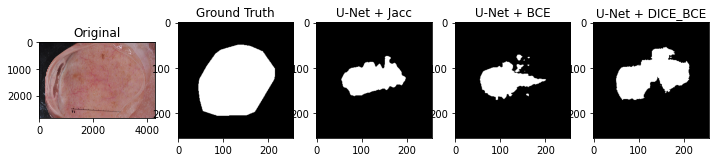

JS1: 0.8566, JS2:0.8577, JS3:0.8612


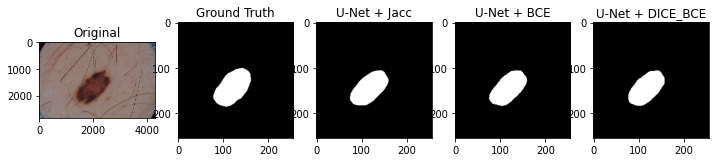

JS1: 0.8108, JS2:0.8736, JS3:0.8809


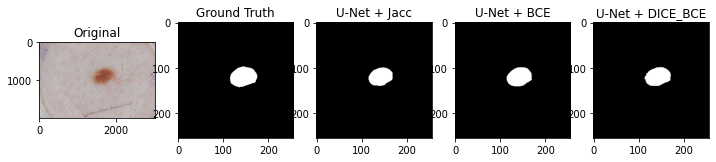

JS1: 0.6620, JS2:0.6262, JS3:0.6385


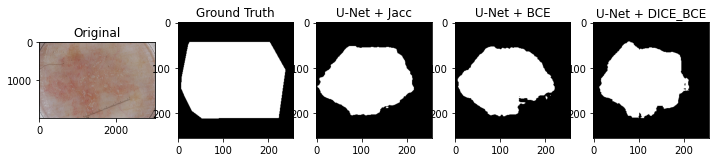

JS1: 0.2378, JS2:0.3056, JS3:0.3444


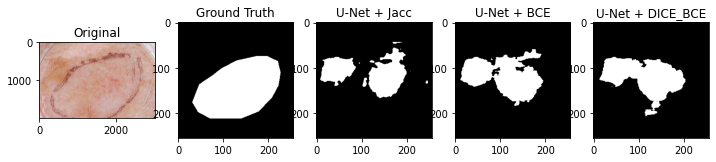

JS1: 0.1944, JS2:0.1532, JS3:0.6704


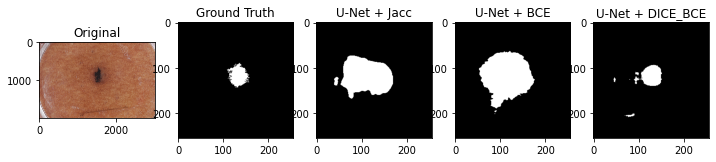

JS1: 0.1387, JS2:0.1239, JS3:0.1303


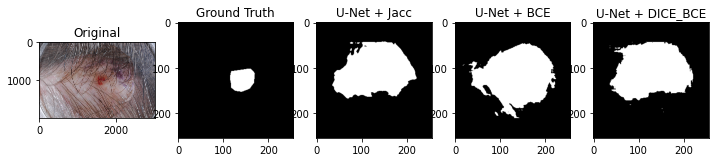

JS1: 0.8853, JS2:0.9014, JS3:0.9008


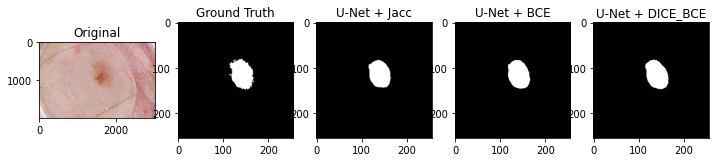

JS1: 0.4576, JS2:0.5391, JS3:0.5100


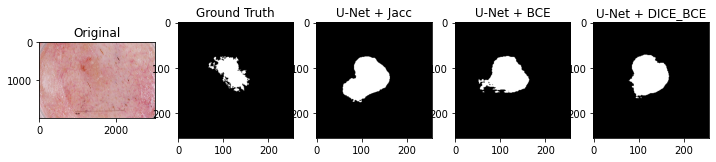

JS1: 0.7645, JS2:0.7236, JS3:0.7308


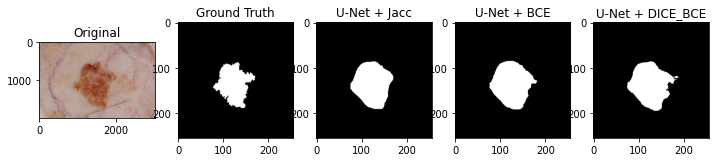

JS1: 0.6134, JS2:0.7828, JS3:0.2834


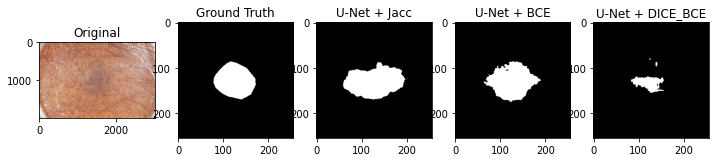

JS1: 0.4026, JS2:0.4487, JS3:0.3998


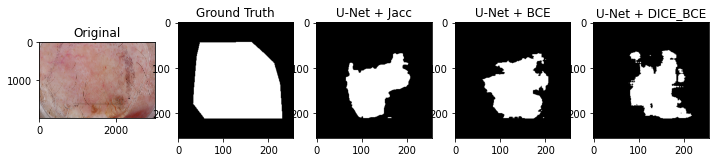

JS1: 0.7002, JS2:0.6253, JS3:0.7081


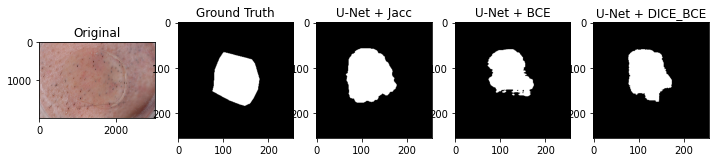

JS1: 0.3892, JS2:0.4008, JS3:0.3360


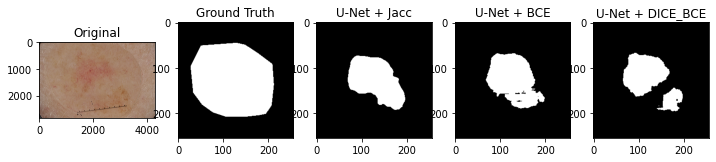

JS1: 0.5237, JS2:0.5656, JS3:0.4897


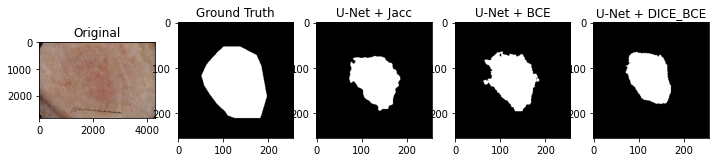

In [ ]:
df = pd.read_csv(test_csv_path)

samples = df.head(15)

for idx, row in samples.iterrows():

    img_id = '/' + row['image_id']

    img_path = test_img_folder + img_id + '.jpg'
    mask_path = test_seg_folder + img_id + '_segmentation.png'

    img = Image.open(img_path)
    mask = Image.open(mask_path).convert('1')

    image = img_transforms(img)
    mask = mask_transforms(mask)

    preds1 = predict(image, unet_jacc, th_unet_jacc)
    preds2 = predict(image, unet_bce, th_unet_bce)
    preds3 = predict(image, unet_bce_dice, th_unet_bce_dice)
    gt = mask.cpu().int().numpy()

   
    js1 = js(gt, preds1/255)
    js2 = js(gt, preds2/255)
    js3 = js(gt, preds3/255)


    print(f"JS1: {js1:.4f}, JS2:{js2:.4f}, JS3:{js3:.4f}")
    

    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(nrows=1, ncols = 5, figsize=(12, 5))

    ax1.imshow(np.array(img))
    ax1.set_title('Original')
         
    ax2.imshow(np.array(mask)[0, :, :], cmap='gray')
    ax2.set_title('Ground Truth')

    ax3.imshow(preds1, cmap='gray')
    ax3.set_title('U-Net + Jacc')

    ax4.imshow(preds2, cmap='gray')
    ax4.set_title('U-Net + BCE')

    
    ax5.imshow(preds3, cmap='gray')
    ax5.set_title('U-Net + DICE_BCE')


    plt.subplots_adjust()
    plt.show()

## *Attention U-Net*


### *Train & Test*

#### With Jaccard Loss 

##### Train

In [ ]:
# Parameters 
CHECKPOINT_ATT_UNET_JACC = '/content/drive/MyDrive/MRTYUTeam/checkpoints_original_ds/att_unet_jacc_new.pth' # save model to this file
WRITER_PATH = '/content/drive/MyDrive/MRTYUTeam/Tensorboard_segmentation' # save progress to this directory

In [ ]:
LEARNING_RATE = 1e-3 # Base learning rate
DEVICE = "cuda" if torch.cuda.is_available() else "cpu" # Device used
NUM_EPOCHS = 100 # Max number of epochs
LR_PATIENCE = 7 # change LR if no improvement after this much epochs 
ES_PATIENCE = 15  # If the validation dice does not improve for this much epochs stop training 
WEIGHT_DECAY = 1e-6 #weight decay parameter of ADAM optimizer

In [ ]:
att_unet = AttU_Net().to(DEVICE)

In [ ]:
# Optimizer 
optimizer = optim.Adam(att_unet.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience= LR_PATIENCE, mode = "min", factor = 0.5, min_lr=1e-8)

# Gradient scaler 
grad_scaler = torch.cuda.amp.GradScaler()

# Loss function
criterion = JaccardLoss() #########

In [ ]:
# Check initial Validation Dice score
val_score, loss = evaluate(att_unet, val_loader, criterion, DEVICE)

Valid: 150img [00:37,  3.97img/s, dice =0.273, loss =0.842]


In [ ]:
logging.info( 'Att-Unet, Adam, Jaccard')
logging.info( 'Initial val : loss : %.4f, dice: %.4f' % (loss, val_score))

Att-Unet, Adam, Jaccard
Initial val : loss : 0.8958, dice: 0.1838


In [ ]:
train_net(att_unet, # the model to be trained
          DEVICE, # cuda or cpu
          train_loader,  # training dataloader
          val_loader, # validation data loader
          ES_PATIENCE, # stop training if val loss does not improve after this much steps
          optimizer, 
          grad_scaler,# gradient scaler
          scheduler, # learning rate scheduler
          criterion, # Objectve/loss function t be minimized
          WRITER_PATH , # folder to track metrics
          NUM_EPOCHS, # number of epochs
          save_checkpoint = True, # whether to save the final model asa file  or not 
          checkpoint_path= CHECKPOINT_ATT_UNET_JACC, # where to save the model
          amp = True)

Epoch 1/100: 100%|██████████| 250/250 [07:40<00:00,  1.84s/it, loss (batch) =0.703]

	Epoch 1 : training loss = 0.54399, training dice = 0.61100



Valid: 150img [00:37,  3.99img/s, dice =0.739, loss =0.414]

	Epoch 1 : validation loss = 0.63215, validation dice = 0.52799



Epoch 2/100: 100%|██████████| 250/250 [07:19<00:00,  1.76s/it, loss (batch) =0.591]

	Epoch 2 : training loss = 0.38400, training dice = 0.75536



Valid: 150img [00:36,  4.06img/s, dice =0.824, loss =0.299]

	Epoch 2 : validation loss = 0.56277, validation dice = 0.59436



Epoch 3/100: 100%|██████████| 250/250 [07:13<00:00,  1.73s/it, loss (batch) =0.685]

	Epoch 3 : training loss = 0.35369, training dice = 0.77800



Valid: 150img [00:36,  4.10img/s, dice =0.816, loss =0.311]

	Epoch 3 : validation loss = 0.50181, validation dice = 0.64783



Epoch 4/100: 100%|██████████| 250/250 [07:21<00:00,  1.77s/it, loss (batch) =0.117]

	Epoch 4 : training loss = 0.33071, training dice = 0.79589



Valid: 150img [00:37,  4.04img/s, dice =0.842, loss =0.272]

	Epoch 4 : validation loss = 0.46734, validation dice = 0.68574



Epoch 5/100: 100%|██████████| 250/250 [07:11<00:00,  1.73s/it, loss (batch) =0.283]

	Epoch 5 : training loss = 0.31578, training dice = 0.80767



Valid: 150img [00:36,  4.07img/s, dice =0.872, loss =0.227]

	Epoch 5 : validation loss = 0.43781, validation dice = 0.70647



Epoch 6/100: 100%|██████████| 250/250 [07:16<00:00,  1.74s/it, loss (batch) =0.422]

	Epoch 6 : training loss = 0.30671, training dice = 0.81382



Valid: 150img [00:37,  4.03img/s, dice =0.8, loss =0.333]

	Epoch 6 : validation loss = 0.47496, validation dice = 0.68030



Epoch 7/100: 100%|██████████| 250/250 [07:22<00:00,  1.77s/it, loss (batch) =0.293]

	Epoch 7 : training loss = 0.28493, training dice = 0.82961



Valid: 150img [00:36,  4.06img/s, dice =0.827, loss =0.295]

	Epoch 7 : validation loss = 0.40801, validation dice = 0.73413



Epoch 8/100: 100%|██████████| 250/250 [07:02<00:00,  1.69s/it, loss (batch) =0.332]

	Epoch 8 : training loss = 0.27478, training dice = 0.83659



Valid: 150img [00:36,  4.07img/s, dice =0.874, loss =0.224]

	Epoch 8 : validation loss = 0.42226, validation dice = 0.72253



Epoch 9/100: 100%|██████████| 250/250 [07:07<00:00,  1.71s/it, loss (batch) =0.258]

	Epoch 9 : training loss = 0.27361, training dice = 0.83718



Valid: 150img [00:36,  4.14img/s, dice =0.661, loss =0.507]

	Epoch 9 : validation loss = 0.58685, validation dice = 0.57348



Epoch 10/100: 100%|██████████| 250/250 [07:06<00:00,  1.71s/it, loss (batch) =0.181]

	Epoch 10 : training loss = 0.27328, training dice = 0.83730



Valid: 150img [00:36,  4.13img/s, dice =0.873, loss =0.225]

	Epoch 10 : validation loss = 0.39987, validation dice = 0.74072



Epoch 11/100: 100%|██████████| 250/250 [07:15<00:00,  1.74s/it, loss (batch) =0.153]

	Epoch 11 : training loss = 0.26603, training dice = 0.84339



Valid: 150img [00:36,  4.11img/s, dice =0.857, loss =0.251]

	Epoch 11 : validation loss = 0.38058, validation dice = 0.75753



Epoch 12/100: 100%|██████████| 250/250 [07:15<00:00,  1.74s/it, loss (batch) =0.302]

	Epoch 12 : training loss = 0.25911, training dice = 0.84735



Valid: 150img [00:36,  4.09img/s, dice =0.824, loss =0.299]

	Epoch 12 : validation loss = 0.40014, validation dice = 0.74118



Epoch 13/100: 100%|██████████| 250/250 [07:18<00:00,  1.76s/it, loss (batch) =0.177]

	Epoch 13 : training loss = 0.25609, training dice = 0.84925



Valid: 150img [00:36,  4.14img/s, dice =0.863, loss =0.242]

	Epoch 13 : validation loss = 0.37341, validation dice = 0.75888



Epoch 14/100: 100%|██████████| 250/250 [07:11<00:00,  1.73s/it, loss (batch) =0.307]

	Epoch 14 : training loss = 0.25070, training dice = 0.85314



Valid: 150img [00:36,  4.07img/s, dice =0.823, loss =0.301]

	Epoch 14 : validation loss = 0.40365, validation dice = 0.74196



Epoch 15/100: 100%|██████████| 250/250 [07:26<00:00,  1.78s/it, loss (batch) =0.406]

	Epoch 15 : training loss = 0.24940, training dice = 0.85366



Valid: 150img [00:36,  4.09img/s, dice =0.871, loss =0.229]

	Epoch 15 : validation loss = 0.36035, validation dice = 0.77358



Epoch 16/100: 100%|██████████| 250/250 [07:12<00:00,  1.73s/it, loss (batch) =0.242]

	Epoch 16 : training loss = 0.24533, training dice = 0.85649



Valid: 150img [00:36,  4.10img/s, dice =0.84, loss =0.275]

	Epoch 16 : validation loss = 0.36034, validation dice = 0.77096



Epoch 17/100: 100%|██████████| 250/250 [07:25<00:00,  1.78s/it, loss (batch) =0.12]

	Epoch 17 : training loss = 0.23974, training dice = 0.86054



Valid: 150img [00:36,  4.10img/s, dice =0.85, loss =0.261]

	Epoch 17 : validation loss = 0.38196, validation dice = 0.75579



Epoch 18/100: 100%|██████████| 250/250 [07:14<00:00,  1.74s/it, loss (batch) =0.173]

	Epoch 18 : training loss = 0.24495, training dice = 0.85710



Valid: 150img [00:36,  4.06img/s, dice =0.833, loss =0.286]

	Epoch 18 : validation loss = 0.35965, validation dice = 0.77465



Epoch 19/100: 100%|██████████| 250/250 [07:13<00:00,  1.74s/it, loss (batch) =0.205]

	Epoch 19 : training loss = 0.23598, training dice = 0.86275



Valid: 150img [00:36,  4.10img/s, dice =0.818, loss =0.308]

	Epoch 19 : validation loss = 0.38377, validation dice = 0.75622



Epoch 20/100: 100%|██████████| 250/250 [07:17<00:00,  1.75s/it, loss (batch) =0.195]

	Epoch 20 : training loss = 0.24243, training dice = 0.85873



Valid: 150img [00:36,  4.09img/s, dice =0.815, loss =0.313]

	Epoch 20 : validation loss = 0.37831, validation dice = 0.75989



Epoch 21/100: 100%|██████████| 250/250 [07:14<00:00,  1.74s/it, loss (batch) =0.268]

	Epoch 21 : training loss = 0.23898, training dice = 0.86079



Valid: 150img [00:36,  4.08img/s, dice =0.838, loss =0.278]

	Epoch 21 : validation loss = 0.35947, validation dice = 0.77125



Epoch 22/100: 100%|██████████| 250/250 [07:13<00:00,  1.74s/it, loss (batch) =0.213]

	Epoch 22 : training loss = 0.22814, training dice = 0.86805



Valid: 150img [00:36,  4.12img/s, dice =0.85, loss =0.262]

	Epoch 22 : validation loss = 0.37420, validation dice = 0.76444



Epoch 23/100: 100%|██████████| 250/250 [07:16<00:00,  1.75s/it, loss (batch) =0.32]

	Epoch 23 : training loss = 0.22425, training dice = 0.87065



Valid: 150img [00:36,  4.07img/s, dice =0.83, loss =0.291]

	Epoch 23 : validation loss = 0.40177, validation dice = 0.74050



Epoch 24/100: 100%|██████████| 250/250 [07:21<00:00,  1.76s/it, loss (batch) =0.17]

	Epoch 24 : training loss = 0.22676, training dice = 0.86937



Valid: 150img [00:36,  4.10img/s, dice =0.837, loss =0.28]

	Epoch 24 : validation loss = 0.37626, validation dice = 0.76129



Epoch 25/100: 100%|██████████| 250/250 [07:12<00:00,  1.73s/it, loss (batch) =0.141]

	Epoch 25 : training loss = 0.22046, training dice = 0.87287



Valid: 150img [00:36,  4.15img/s, dice =0.847, loss =0.266]

	Epoch 25 : validation loss = 0.36834, validation dice = 0.76898



Epoch 26/100: 100%|██████████| 250/250 [07:12<00:00,  1.73s/it, loss (batch) =0.21]

	Epoch 26 : training loss = 0.22035, training dice = 0.87380



Valid: 150img [00:36,  4.07img/s, dice =0.871, loss =0.228]

	Epoch 26 : validation loss = 0.35861, validation dice = 0.77074



Epoch 27/100: 100%|██████████| 250/250 [07:17<00:00,  1.75s/it, loss (batch) =0.0859]

	Epoch 27 : training loss = 0.22062, training dice = 0.87327



Valid: 150img [00:36,  4.08img/s, dice =0.831, loss =0.289]

	Epoch 27 : validation loss = 0.36698, validation dice = 0.76918



Epoch 28/100: 100%|██████████| 250/250 [07:23<00:00,  1.78s/it, loss (batch) =0.133]

	Epoch 28 : training loss = 0.20851, training dice = 0.88121



Valid: 150img [00:36,  4.12img/s, dice =0.854, loss =0.254]

	Epoch 28 : validation loss = 0.37063, validation dice = 0.76479



Epoch 29/100: 100%|██████████| 250/250 [07:28<00:00,  1.80s/it, loss (batch) =0.361]

	Epoch 29 : training loss = 0.21345, training dice = 0.87770



Valid: 150img [00:36,  4.07img/s, dice =0.868, loss =0.233]

	Epoch 29 : validation loss = 0.35349, validation dice = 0.77489



Epoch 30/100: 100%|██████████| 250/250 [07:13<00:00,  1.74s/it, loss (batch) =0.355]

	Epoch 30 : training loss = 0.20539, training dice = 0.88304



Valid: 150img [00:36,  4.07img/s, dice =0.829, loss =0.293]

	Epoch 30 : validation loss = 0.35182, validation dice = 0.78090



Epoch 31/100: 100%|██████████| 250/250 [07:30<00:00,  1.80s/it, loss (batch) =0.211]

	Epoch 31 : training loss = 0.20318, training dice = 0.88467



Valid: 150img [00:35,  4.17img/s, dice =0.84, loss =0.276]

	Epoch 31 : validation loss = 0.35121, validation dice = 0.77977



Epoch 32/100: 100%|██████████| 250/250 [07:15<00:00,  1.74s/it, loss (batch) =0.179]

	Epoch 32 : training loss = 0.20394, training dice = 0.88347



Valid: 150img [00:36,  4.11img/s, dice =0.842, loss =0.273]

	Epoch 32 : validation loss = 0.32437, validation dice = 0.80064



Epoch 33/100: 100%|██████████| 250/250 [07:15<00:00,  1.74s/it, loss (batch) =0.429]

	Epoch 33 : training loss = 0.20765, training dice = 0.88159



Valid: 150img [00:36,  4.14img/s, dice =0.841, loss =0.274]

	Epoch 33 : validation loss = 0.36316, validation dice = 0.77087



Epoch 34/100: 100%|██████████| 250/250 [07:21<00:00,  1.76s/it, loss (batch) =0.104]

	Epoch 34 : training loss = 0.20434, training dice = 0.88369



Valid: 150img [00:36,  4.08img/s, dice =0.825, loss =0.298]

	Epoch 34 : validation loss = 0.41508, validation dice = 0.72927



Epoch 35/100: 100%|██████████| 250/250 [07:17<00:00,  1.75s/it, loss (batch) =0.101]

	Epoch 35 : training loss = 0.20138, training dice = 0.88566



Valid: 150img [00:36,  4.10img/s, dice =0.857, loss =0.25]

	Epoch 35 : validation loss = 0.37234, validation dice = 0.76471



Epoch 36/100: 100%|██████████| 250/250 [07:23<00:00,  1.77s/it, loss (batch) =0.138]

	Epoch 36 : training loss = 0.19662, training dice = 0.88901



Valid: 150img [00:36,  4.10img/s, dice =0.812, loss =0.317]

	Epoch 36 : validation loss = 0.42795, validation dice = 0.71761



Epoch 37/100: 100%|██████████| 250/250 [07:15<00:00,  1.74s/it, loss (batch) =0.201]

	Epoch 37 : training loss = 0.19856, training dice = 0.88763



Valid: 150img [00:36,  4.13img/s, dice =0.849, loss =0.262]

	Epoch 37 : validation loss = 0.33036, validation dice = 0.79759



Epoch 38/100: 100%|██████████| 250/250 [07:07<00:00,  1.71s/it, loss (batch) =0.127]

	Epoch 38 : training loss = 0.19571, training dice = 0.88926



Valid: 150img [00:36,  4.08img/s, dice =0.826, loss =0.296]

	Epoch 38 : validation loss = 0.37747, validation dice = 0.75995



Epoch 39/100: 100%|██████████| 250/250 [07:21<00:00,  1.77s/it, loss (batch) =0.174]

	Epoch 39 : training loss = 0.19740, training dice = 0.88805



Valid: 150img [00:36,  4.12img/s, dice =0.851, loss =0.259]

	Epoch 39 : validation loss = 0.33422, validation dice = 0.79553



Epoch 40/100: 100%|██████████| 250/250 [07:04<00:00,  1.70s/it, loss (batch) =0.218]

	Epoch 40 : training loss = 0.20233, training dice = 0.88515



Valid: 150img [00:36,  4.13img/s, dice =0.837, loss =0.281]

	Epoch 40 : validation loss = 0.36460, validation dice = 0.77108



Epoch 41/100: 100%|██████████| 250/250 [07:14<00:00,  1.74s/it, loss (batch) =0.221]

	Epoch 41 : training loss = 0.18574, training dice = 0.89556



Valid: 150img [00:36,  4.12img/s, dice =0.832, loss =0.288]

	Epoch 41 : validation loss = 0.32837, validation dice = 0.79975



Epoch 42/100: 100%|██████████| 250/250 [07:19<00:00,  1.76s/it, loss (batch) =0.132]

	Epoch 42 : training loss = 0.17986, training dice = 0.89950



Valid: 150img [00:36,  4.10img/s, dice =0.818, loss =0.308]

	Epoch 42 : validation loss = 0.33250, validation dice = 0.79612



Epoch 43/100: 100%|██████████| 250/250 [07:13<00:00,  1.73s/it, loss (batch) =0.129]

	Epoch 43 : training loss = 0.18010, training dice = 0.89914



Valid: 150img [00:36,  4.11img/s, dice =0.817, loss =0.309]

	Epoch 43 : validation loss = 0.33605, validation dice = 0.79329



Epoch 44/100: 100%|██████████| 250/250 [07:06<00:00,  1.70s/it, loss (batch) =0.247]

	Epoch 44 : training loss = 0.18032, training dice = 0.89858



Valid: 150img [00:36,  4.11img/s, dice =0.825, loss =0.297]

	Epoch 44 : validation loss = 0.34569, validation dice = 0.78729



Epoch 45/100: 100%|██████████| 250/250 [07:14<00:00,  1.74s/it, loss (batch) =0.0846]

	Epoch 45 : training loss = 0.18003, training dice = 0.89920



Valid: 150img [00:35,  4.17img/s, dice =0.853, loss =0.256]

	Epoch 45 : validation loss = 0.34199, validation dice = 0.78765



Epoch 46/100: 100%|██████████| 250/250 [07:13<00:00,  1.73s/it, loss (batch) =0.107]

	Epoch 46 : training loss = 0.18282, training dice = 0.89764



Valid: 150img [00:36,  4.05img/s, dice =0.83, loss =0.291]

	Epoch 46 : validation loss = 0.32815, validation dice = 0.79858



Epoch 47/100: 100%|██████████| 250/250 [07:10<00:00,  1.72s/it, loss (batch) =0.157]

	Epoch 47 : training loss = 0.17597, training dice = 0.90152



Valid: 150img [00:36,  4.07img/s, dice =0.857, loss =0.251]

	Epoch 47 : validation loss = 0.32482, validation dice = 0.80213



Epoch 48/100: 100%|██████████| 250/250 [07:22<00:00,  1.77s/it, loss (batch) =0.311]

	Epoch 48 : training loss = 0.17844, training dice = 0.89970



Valid: 150img [00:36,  4.06img/s, dice =0.863, loss =0.241]

	Epoch 48 : validation loss = 0.32948, validation dice = 0.79839
EARLY STOPPING AFTER 48 EPOCHS
Best validation loss = 0.32437
Best validation dice = 0.80213


##### Optimize Threshold

In [ ]:
att_unet.load_state_dict(torch.load(CHECKPOINT_ATT_UNET_JACC))

<All keys matched successfully>

In [ ]:
# dummy function for bayesian optimization
def calculate_jaccard(th):
    jaccard = check_js(val_loader, att_unet, th)
    return jaccard

In [ ]:
pbounds = {'th': (0.01, 0.99)} # Search interval
optimizer = BayesianOptimization(
    f=calculate_jaccard, # function to maximize
    pbounds=pbounds, # search interval
    verbose=2, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=77,
)

In [ ]:
optimizer.maximize(
    init_points=1, # perform 2 steps of random exploration
    n_iter=10, # Perform 10 iterations
)

|   iter    |  target   |    th     |
-------------------------------------
|  1        |  0.6726   |  0.9107   |
|  2        |  0.6797   |  0.01     |
|  3        |  0.6796   |  0.0101   |
|  4        |  0.6756   |  0.4317   |
|  5        |  0.6766   |  0.205    |
|  6        |  0.6797   |  0.01005  |
|  7        |  0.6785   |  0.03767  |
|  8        |  0.6747   |  0.648    |
|  9        |  0.6761   |  0.3118   |
|  10       |  0.6797   |  0.01001  |
|  11       |  0.6797   |  0.01001  |


##### Test

In [ ]:
dice, loss = evaluate(att_unet, test_loader, JaccardLoss(), DEVICE)
jacc = check_js_original_size(test_loader, att_unet, 0.01 , test_seg_folder)
print("Model: Att-unet, Optimizer:ADAM, Loss: Jaccard Loss")
print(f'Test Dice: {dice:.4f}')
print(f'Test Loss: {loss:.4f}')
print(f'Test Jaccard: {jacc:.4f}')

Model: Att-unet, Optimizer:ADAM, Loss: Jaccard Loss
Test Dice: 0.7874
Test Loss: 0.3399
Test Jaccard: 0.7243


In [ ]:
logging.info( 'Test : loss : %.4f, dice: %.4f, jaccard: %.4f' %
                (loss, dice, jacc))

Test : loss : 0.3399, dice: 0.7874, jaccard: 0.7243


#### With BCE Loss

##### With 384*384 images

###### Train

In [ ]:
# Parameters 
CHECKPOINT_ATT_UNET_BCE = '/content/drive/MyDrive/checkpoints_original_ds/att_unet_bce.pth' # save model to this file
WRITER_PATH = '/content/drive/MyDrive/Tensorboard_segmentation' # save progress to this directory

In [ ]:
LEARNING_RATE = 1e-2 # Base learning rate
DEVICE = "cuda" if torch.cuda.is_available() else "cpu" # Device used
NUM_EPOCHS = 100 # Max number of epochs
LR_PATIENCE = 5 # change LR if no improvement after this much epochs 
ES_PATIENCE = 20  # If the validation dice does not improve for this much epochs stop training 
WEIGHT_DECAY = 1e-6 #weight decay parameter of ADAM optimizer

In [ ]:
att_unet = AttU_Net().to(DEVICE)

In [ ]:
# Optimizer 
optimizer = optim.Adam(att_unet.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience= LR_PATIENCE, mode = "min", factor = 0.2, min_lr=1e-9)

# Gradient scaler 
grad_scaler = torch.cuda.amp.GradScaler()

# Loss function
criterion = nn.BCEWithLogitsLoss()

In [ ]:
# Check initial Validation Dice score
val_score, loss = evaluate(att_unet, val_loader, criterion, DEVICE)

logging.info( 'Att-Unet, Adam, BCE')
logging.info( 'Initial val : loss : %.4f, dice: %.4f' % (loss, val_score))

Valid: 150img [00:43,  3.49img/s, dice =0.274, loss =0.707]

Att-Unet, Adam, BCE
Initial val : loss : 0.7101, dice: 0.1845


In [ ]:
train_net(att_unet, # the model to be trained
          DEVICE, # cuda or cpu
          train_loader,  # training dataloader
          val_loader, # validation data loader
          ES_PATIENCE, # stop training if val loss does not improve after this much steps
          optimizer, 
          grad_scaler,# gradient scaler
          scheduler, # learning rate scheduler
          criterion, # Objectve/loss function t be minimized
          WRITER_PATH , # folder to track metrics
          NUM_EPOCHS, # number of epochs
          save_checkpoint = True, # whether to save the final model asa file  or not 
          checkpoint_path= CHECKPOINT_ATT_UNET_BCE, # where to save the model
          amp = True)

Epoch 1/100: 100%|██████████| 250/250 [11:34<00:00,  2.78s/it, loss (batch) =0.171]

	Epoch 1 : training loss = 0.21825, training dice = 0.54731



Valid: 150img [00:43,  3.48img/s, dice =0.529, loss =0.617]

	Epoch 1 : validation loss = 0.51279, validation dice = 0.35780



Epoch 2/100: 100%|██████████| 250/250 [07:37<00:00,  1.83s/it, loss (batch) =0.169]

	Epoch 2 : training loss = 0.17178, training dice = 0.63906



Valid: 150img [00:43,  3.46img/s, dice =0.68, loss =0.256]

	Epoch 2 : validation loss = 0.20996, validation dice = 0.51454



Epoch 3/100: 100%|██████████| 250/250 [07:57<00:00,  1.91s/it, loss (batch) =0.124]

	Epoch 3 : training loss = 0.15761, training dice = 0.66899



Valid: 150img [00:43,  3.42img/s, dice =0.716, loss =0.173]

	Epoch 3 : validation loss = 0.17396, validation dice = 0.52395



Epoch 4/100: 100%|██████████| 250/250 [07:43<00:00,  1.86s/it, loss (batch) =0.065]

	Epoch 4 : training loss = 0.14516, training dice = 0.69591



Valid: 150img [00:43,  3.43img/s, dice =0.719, loss =0.204]

	Epoch 4 : validation loss = 0.21222, validation dice = 0.52637



Epoch 5/100: 100%|██████████| 250/250 [07:45<00:00,  1.86s/it, loss (batch) =0.0878]

	Epoch 5 : training loss = 0.13700, training dice = 0.71216



Valid: 150img [00:44,  3.39img/s, dice =0.766, loss =0.133]

	Epoch 5 : validation loss = 0.15909, validation dice = 0.56633



Epoch 6/100: 100%|██████████| 250/250 [07:41<00:00,  1.84s/it, loss (batch) =0.198]

	Epoch 6 : training loss = 0.13204, training dice = 0.72426



Valid: 150img [00:44,  3.35img/s, dice =0.796, loss =0.125]

	Epoch 6 : validation loss = 0.15117, validation dice = 0.63148



Epoch 7/100: 100%|██████████| 250/250 [07:46<00:00,  1.86s/it, loss (batch) =0.238]

	Epoch 7 : training loss = 0.12917, training dice = 0.72980



Valid: 150img [00:43,  3.43img/s, dice =0.766, loss =0.175]

	Epoch 7 : validation loss = 0.17895, validation dice = 0.61970



Epoch 8/100: 100%|██████████| 250/250 [07:45<00:00,  1.86s/it, loss (batch) =0.11]

	Epoch 8 : training loss = 0.12356, training dice = 0.74139



Valid: 150img [00:43,  3.46img/s, dice =0.78, loss =0.137]

	Epoch 8 : validation loss = 0.14817, validation dice = 0.59980



Epoch 9/100: 100%|██████████| 250/250 [07:37<00:00,  1.83s/it, loss (batch) =0.0888]

	Epoch 9 : training loss = 0.12056, training dice = 0.74528



Valid: 150img [00:43,  3.43img/s, dice =0.706, loss =0.229]

	Epoch 9 : validation loss = 0.19872, validation dice = 0.54242



Epoch 10/100: 100%|██████████| 250/250 [07:41<00:00,  1.84s/it, loss (batch) =0.0814]

	Epoch 10 : training loss = 0.11357, training dice = 0.76204



Valid: 150img [00:44,  3.39img/s, dice =0.806, loss =0.135]

	Epoch 10 : validation loss = 0.14672, validation dice = 0.64672



Epoch 11/100: 100%|██████████| 250/250 [07:54<00:00,  1.90s/it, loss (batch) =0.17]

	Epoch 11 : training loss = 0.11380, training dice = 0.76322



Valid: 150img [00:43,  3.46img/s, dice =0.779, loss =0.162]

	Epoch 11 : validation loss = 0.15609, validation dice = 0.60295



Epoch 12/100: 100%|██████████| 250/250 [07:53<00:00,  1.89s/it, loss (batch) =0.109]

	Epoch 12 : training loss = 0.10832, training dice = 0.76983



Valid: 150img [00:44,  3.40img/s, dice =0.798, loss =0.145]

	Epoch 12 : validation loss = 0.14240, validation dice = 0.65192



Epoch 13/100: 100%|██████████| 250/250 [07:41<00:00,  1.85s/it, loss (batch) =0.102]

	Epoch 13 : training loss = 0.10179, training dice = 0.78541



Valid: 150img [00:45,  3.33img/s, dice =0.768, loss =0.164]

	Epoch 13 : validation loss = 0.15368, validation dice = 0.62399



Epoch 14/100: 100%|██████████| 250/250 [07:54<00:00,  1.90s/it, loss (batch) =0.125]

	Epoch 14 : training loss = 0.10291, training dice = 0.78193



Valid: 150img [00:43,  3.41img/s, dice =0.79, loss =0.136]

	Epoch 14 : validation loss = 0.14727, validation dice = 0.63686



Epoch 15/100: 100%|██████████| 250/250 [07:42<00:00,  1.85s/it, loss (batch) =0.0985]

	Epoch 15 : training loss = 0.10224, training dice = 0.78388



Valid: 150img [00:43,  3.42img/s, dice =0.8, loss =0.143]

	Epoch 15 : validation loss = 0.15590, validation dice = 0.64377



Epoch 16/100: 100%|██████████| 250/250 [07:37<00:00,  1.83s/it, loss (batch) =0.0594]

	Epoch 16 : training loss = 0.09949, training dice = 0.78939



Valid: 150img [00:44,  3.39img/s, dice =0.794, loss =0.132]

	Epoch 16 : validation loss = 0.12698, validation dice = 0.65911



Epoch 17/100: 100%|██████████| 250/250 [07:42<00:00,  1.85s/it, loss (batch) =0.0543]

	Epoch 17 : training loss = 0.09483, training dice = 0.79687



Valid: 150img [00:44,  3.41img/s, dice =0.787, loss =0.168]

	Epoch 17 : validation loss = 0.15603, validation dice = 0.65327



Epoch 18/100: 100%|██████████| 250/250 [07:49<00:00,  1.88s/it, loss (batch) =0.0363]

	Epoch 18 : training loss = 0.09389, training dice = 0.80416



Valid: 150img [00:44,  3.36img/s, dice =0.756, loss =0.169]

	Epoch 18 : validation loss = 0.15293, validation dice = 0.60987



Epoch 19/100: 100%|██████████| 250/250 [07:42<00:00,  1.85s/it, loss (batch) =0.139]

	Epoch 19 : training loss = 0.09067, training dice = 0.80603



Valid: 150img [00:44,  3.40img/s, dice =0.769, loss =0.151]

	Epoch 19 : validation loss = 0.13084, validation dice = 0.64350



Epoch 20/100: 100%|██████████| 250/250 [07:48<00:00,  1.88s/it, loss (batch) =0.0576]

	Epoch 20 : training loss = 0.09019, training dice = 0.80901



Valid: 150img [00:43,  3.41img/s, dice =0.756, loss =0.15]

	Epoch 20 : validation loss = 0.14725, validation dice = 0.61036



Epoch 21/100: 100%|██████████| 250/250 [07:54<00:00,  1.90s/it, loss (batch) =0.0776]

	Epoch 21 : training loss = 0.08709, training dice = 0.81424



Valid: 150img [00:43,  3.41img/s, dice =0.808, loss =0.147]

	Epoch 21 : validation loss = 0.13670, validation dice = 0.69111



Epoch 22/100: 100%|██████████| 250/250 [07:40<00:00,  1.84s/it, loss (batch) =0.0692]

	Epoch 22 : training loss = 0.09009, training dice = 0.80849



Valid: 150img [00:43,  3.43img/s, dice =0.757, loss =0.158]

	Epoch 22 : validation loss = 0.13243, validation dice = 0.63168



Epoch 23/100: 100%|██████████| 250/250 [07:48<00:00,  1.87s/it, loss (batch) =0.0872]

	Epoch 23 : training loss = 0.07770, training dice = 0.82784



Valid: 150img [00:44,  3.40img/s, dice =0.808, loss =0.149]

	Epoch 23 : validation loss = 0.12535, validation dice = 0.72007



Epoch 24/100: 100%|██████████| 250/250 [07:53<00:00,  1.89s/it, loss (batch) =0.23]

	Epoch 24 : training loss = 0.07386, training dice = 0.83989



Valid: 150img [00:44,  3.40img/s, dice =0.798, loss =0.162]

	Epoch 24 : validation loss = 0.12675, validation dice = 0.72466



Epoch 25/100: 100%|██████████| 250/250 [07:58<00:00,  1.92s/it, loss (batch) =0.0653]

	Epoch 25 : training loss = 0.07328, training dice = 0.83936



Valid: 150img [00:44,  3.40img/s, dice =0.797, loss =0.174]

	Epoch 25 : validation loss = 0.13345, validation dice = 0.72139



Epoch 26/100: 100%|██████████| 250/250 [07:48<00:00,  1.88s/it, loss (batch) =0.0574]

	Epoch 26 : training loss = 0.07329, training dice = 0.84005



Valid: 150img [00:44,  3.38img/s, dice =0.819, loss =0.124]

	Epoch 26 : validation loss = 0.12164, validation dice = 0.70775



Epoch 27/100: 100%|██████████| 250/250 [07:56<00:00,  1.91s/it, loss (batch) =0.0407]

	Epoch 27 : training loss = 0.07235, training dice = 0.84362



Valid: 150img [00:45,  3.32img/s, dice =0.814, loss =0.135]

	Epoch 27 : validation loss = 0.13574, validation dice = 0.69476



Epoch 28/100: 100%|██████████| 250/250 [07:50<00:00,  1.88s/it, loss (batch) =0.0869]

	Epoch 28 : training loss = 0.07182, training dice = 0.84515



Valid: 150img [00:43,  3.42img/s, dice =0.816, loss =0.141]

	Epoch 28 : validation loss = 0.12163, validation dice = 0.72699



Epoch 29/100: 100%|██████████| 250/250 [07:51<00:00,  1.89s/it, loss (batch) =0.0802]

	Epoch 29 : training loss = 0.07004, training dice = 0.84615



Valid: 150img [00:44,  3.40img/s, dice =0.817, loss =0.136]

	Epoch 29 : validation loss = 0.12893, validation dice = 0.72014



Epoch 30/100: 100%|██████████| 250/250 [07:49<00:00,  1.88s/it, loss (batch) =0.103]

	Epoch 30 : training loss = 0.07112, training dice = 0.84581



Valid: 150img [00:43,  3.41img/s, dice =0.829, loss =0.124]

	Epoch 30 : validation loss = 0.12086, validation dice = 0.72616



Epoch 31/100: 100%|██████████| 250/250 [07:43<00:00,  1.85s/it, loss (batch) =0.05]

	Epoch 31 : training loss = 0.07019, training dice = 0.84962



Valid: 150img [00:42,  3.51img/s, dice =0.777, loss =0.22]

	Epoch 31 : validation loss = 0.15975, validation dice = 0.70841



Epoch 32/100: 100%|██████████| 250/250 [07:43<00:00,  1.86s/it, loss (batch) =0.0579]

	Epoch 32 : training loss = 0.06961, training dice = 0.84996



Valid: 150img [00:44,  3.39img/s, dice =0.814, loss =0.142]

	Epoch 32 : validation loss = 0.13613, validation dice = 0.71248



Epoch 33/100: 100%|██████████| 250/250 [07:49<00:00,  1.88s/it, loss (batch) =0.0513]

	Epoch 33 : training loss = 0.07050, training dice = 0.84534



Valid: 150img [00:44,  3.41img/s, dice =0.825, loss =0.142]

	Epoch 33 : validation loss = 0.12770, validation dice = 0.73859



Epoch 34/100: 100%|██████████| 250/250 [07:57<00:00,  1.91s/it, loss (batch) =0.0559]

	Epoch 34 : training loss = 0.06876, training dice = 0.85212



Valid: 150img [00:43,  3.42img/s, dice =0.811, loss =0.133]

	Epoch 34 : validation loss = 0.12742, validation dice = 0.69550



Epoch 35/100: 100%|██████████| 250/250 [07:45<00:00,  1.86s/it, loss (batch) =0.0659]

	Epoch 35 : training loss = 0.06851, training dice = 0.85008



Valid: 150img [00:44,  3.41img/s, dice =0.822, loss =0.147]

	Epoch 35 : validation loss = 0.13632, validation dice = 0.72129



Epoch 36/100: 100%|██████████| 250/250 [07:58<00:00,  1.91s/it, loss (batch) =0.0462]

	Epoch 36 : training loss = 0.06885, training dice = 0.85318



Valid: 150img [00:43,  3.43img/s, dice =0.817, loss =0.139]

	Epoch 36 : validation loss = 0.12162, validation dice = 0.73283



Epoch 37/100: 100%|██████████| 250/250 [07:50<00:00,  1.88s/it, loss (batch) =0.0177]

	Epoch 37 : training loss = 0.06466, training dice = 0.86067



Valid: 150img [00:43,  3.44img/s, dice =0.823, loss =0.139]

	Epoch 37 : validation loss = 0.12094, validation dice = 0.74041



Epoch 38/100: 100%|██████████| 250/250 [07:46<00:00,  1.87s/it, loss (batch) =0.0438]

	Epoch 38 : training loss = 0.06443, training dice = 0.86012



Valid: 150img [00:43,  3.44img/s, dice =0.823, loss =0.141]

	Epoch 38 : validation loss = 0.12052, validation dice = 0.74474



Epoch 39/100: 100%|██████████| 250/250 [07:55<00:00,  1.90s/it, loss (batch) =0.0403]

	Epoch 39 : training loss = 0.06379, training dice = 0.86019



Valid: 150img [00:44,  3.40img/s, dice =0.827, loss =0.135]

	Epoch 39 : validation loss = 0.12241, validation dice = 0.73815



Epoch 40/100: 100%|██████████| 250/250 [07:58<00:00,  1.91s/it, loss (batch) =0.0574]

	Epoch 40 : training loss = 0.06367, training dice = 0.86319



Valid: 150img [00:43,  3.42img/s, dice =0.827, loss =0.14]

	Epoch 40 : validation loss = 0.12282, validation dice = 0.74740



Epoch 41/100: 100%|██████████| 250/250 [07:49<00:00,  1.88s/it, loss (batch) =0.0491]

	Epoch 41 : training loss = 0.06240, training dice = 0.86432



Valid: 150img [00:43,  3.42img/s, dice =0.824, loss =0.142]

	Epoch 41 : validation loss = 0.12153, validation dice = 0.74679



Epoch 42/100: 100%|██████████| 250/250 [08:00<00:00,  1.92s/it, loss (batch) =0.0529]

	Epoch 42 : training loss = 0.06258, training dice = 0.86385



Valid: 150img [00:43,  3.41img/s, dice =0.827, loss =0.136]

	Epoch 42 : validation loss = 0.12117, validation dice = 0.73877



Epoch 43/100: 100%|██████████| 250/250 [07:54<00:00,  1.90s/it, loss (batch) =0.0411]

	Epoch 43 : training loss = 0.06309, training dice = 0.86172



Valid: 150img [00:44,  3.37img/s, dice =0.824, loss =0.141]

	Epoch 43 : validation loss = 0.11941, validation dice = 0.75006



Epoch 44/100: 100%|██████████| 250/250 [07:54<00:00,  1.90s/it, loss (batch) =0.0715]

	Epoch 44 : training loss = 0.06277, training dice = 0.86311



Valid: 150img [00:43,  3.47img/s, dice =0.825, loss =0.145]

	Epoch 44 : validation loss = 0.12379, validation dice = 0.74956



Epoch 45/100: 100%|██████████| 250/250 [07:40<00:00,  1.84s/it, loss (batch) =0.043]

	Epoch 45 : training loss = 0.06216, training dice = 0.86533



Valid: 150img [00:44,  3.37img/s, dice =0.823, loss =0.142]

	Epoch 45 : validation loss = 0.12303, validation dice = 0.74788



Epoch 46/100: 100%|██████████| 250/250 [07:57<00:00,  1.91s/it, loss (batch) =0.0651]

	Epoch 46 : training loss = 0.06206, training dice = 0.86396



Valid: 150img [00:44,  3.36img/s, dice =0.831, loss =0.132]

	Epoch 46 : validation loss = 0.11919, validation dice = 0.74727



Epoch 47/100: 100%|██████████| 250/250 [07:46<00:00,  1.87s/it, loss (batch) =0.0613]

	Epoch 47 : training loss = 0.06234, training dice = 0.86384



Valid: 150img [00:44,  3.37img/s, dice =0.829, loss =0.137]

	Epoch 47 : validation loss = 0.12336, validation dice = 0.74637



Epoch 48/100: 100%|██████████| 250/250 [07:55<00:00,  1.90s/it, loss (batch) =0.0556]

	Epoch 48 : training loss = 0.06197, training dice = 0.86498



Valid: 150img [00:44,  3.39img/s, dice =0.826, loss =0.144]

	Epoch 48 : validation loss = 0.12463, validation dice = 0.75053



Epoch 49/100: 100%|██████████| 250/250 [07:49<00:00,  1.88s/it, loss (batch) =0.0364]

	Epoch 49 : training loss = 0.06138, training dice = 0.86699



Valid: 150img [00:42,  3.49img/s, dice =0.831, loss =0.124]

	Epoch 49 : validation loss = 0.11766, validation dice = 0.74317



Epoch 50/100: 100%|██████████| 250/250 [07:52<00:00,  1.89s/it, loss (batch) =0.0562]

	Epoch 50 : training loss = 0.06203, training dice = 0.86402



Valid: 150img [00:43,  3.41img/s, dice =0.828, loss =0.13]

	Epoch 50 : validation loss = 0.11730, validation dice = 0.74829



Epoch 51/100: 100%|██████████| 250/250 [07:42<00:00,  1.85s/it, loss (batch) =0.0687]

	Epoch 51 : training loss = 0.06204, training dice = 0.86359



Valid: 150img [00:44,  3.40img/s, dice =0.831, loss =0.138]

	Epoch 51 : validation loss = 0.12426, validation dice = 0.75224



Epoch 52/100: 100%|██████████| 250/250 [07:53<00:00,  1.89s/it, loss (batch) =0.0316]

	Epoch 52 : training loss = 0.06140, training dice = 0.86652



Valid: 150img [00:43,  3.43img/s, dice =0.83, loss =0.123]

	Epoch 52 : validation loss = 0.11391, validation dice = 0.74542



Epoch 53/100: 100%|██████████| 250/250 [07:52<00:00,  1.89s/it, loss (batch) =0.0448]

	Epoch 53 : training loss = 0.06123, training dice = 0.86489



Valid: 150img [00:43,  3.41img/s, dice =0.829, loss =0.129]

	Epoch 53 : validation loss = 0.11886, validation dice = 0.74827



Epoch 54/100: 100%|██████████| 250/250 [07:51<00:00,  1.88s/it, loss (batch) =0.0792]

	Epoch 54 : training loss = 0.06084, training dice = 0.86741



Valid: 150img [00:44,  3.38img/s, dice =0.83, loss =0.121]

	Epoch 54 : validation loss = 0.11455, validation dice = 0.74194



Epoch 55/100: 100%|██████████| 250/250 [08:00<00:00,  1.92s/it, loss (batch) =0.0513]

	Epoch 55 : training loss = 0.06075, training dice = 0.86678



Valid: 150img [00:44,  3.40img/s, dice =0.831, loss =0.134]

	Epoch 55 : validation loss = 0.12108, validation dice = 0.75197



Epoch 56/100: 100%|██████████| 250/250 [07:50<00:00,  1.88s/it, loss (batch) =0.0456]

	Epoch 56 : training loss = 0.06047, training dice = 0.86701



Valid: 150img [00:44,  3.40img/s, dice =0.835, loss =0.127]

	Epoch 56 : validation loss = 0.12443, validation dice = 0.75160



Epoch 57/100: 100%|██████████| 250/250 [07:57<00:00,  1.91s/it, loss (batch) =0.022]

	Epoch 57 : training loss = 0.05979, training dice = 0.86958



Valid: 150img [00:44,  3.38img/s, dice =0.834, loss =0.127]

	Epoch 57 : validation loss = 0.11995, validation dice = 0.74959



Epoch 58/100: 100%|██████████| 250/250 [07:47<00:00,  1.87s/it, loss (batch) =0.0719]

	Epoch 58 : training loss = 0.06021, training dice = 0.86903



Valid: 150img [00:44,  3.38img/s, dice =0.839, loss =0.126]

	Epoch 58 : validation loss = 0.12007, validation dice = 0.75323



Epoch 59/100: 100%|██████████| 250/250 [07:52<00:00,  1.89s/it, loss (batch) =0.0436]

	Epoch 59 : training loss = 0.05905, training dice = 0.87026



Valid: 150img [00:43,  3.44img/s, dice =0.836, loss =0.126]

	Epoch 59 : validation loss = 0.11955, validation dice = 0.75156



Epoch 60/100: 100%|██████████| 250/250 [07:52<00:00,  1.89s/it, loss (batch) =0.0419]

	Epoch 60 : training loss = 0.05919, training dice = 0.86863



Valid: 150img [00:44,  3.34img/s, dice =0.832, loss =0.132]

	Epoch 60 : validation loss = 0.11975, validation dice = 0.75172



Epoch 61/100: 100%|██████████| 250/250 [07:51<00:00,  1.89s/it, loss (batch) =0.0336]

	Epoch 61 : training loss = 0.05930, training dice = 0.86929



Valid: 150img [00:44,  3.40img/s, dice =0.832, loss =0.129]

	Epoch 61 : validation loss = 0.11816, validation dice = 0.75215



Epoch 62/100: 100%|██████████| 250/250 [07:45<00:00,  1.86s/it, loss (batch) =0.0502]

	Epoch 62 : training loss = 0.05916, training dice = 0.86993



Valid: 150img [00:44,  3.39img/s, dice =0.836, loss =0.127]

	Epoch 62 : validation loss = 0.11856, validation dice = 0.75434



Epoch 63/100: 100%|██████████| 250/250 [08:05<00:00,  1.94s/it, loss (batch) =0.0348]

	Epoch 63 : training loss = 0.05820, training dice = 0.87172



Valid: 150img [00:44,  3.37img/s, dice =0.836, loss =0.126]

	Epoch 63 : validation loss = 0.11994, validation dice = 0.75071



Epoch 64/100: 100%|██████████| 250/250 [07:54<00:00,  1.90s/it, loss (batch) =0.0275]

	Epoch 64 : training loss = 0.05910, training dice = 0.87174



Valid: 150img [00:44,  3.34img/s, dice =0.833, loss =0.128]

	Epoch 64 : validation loss = 0.11827, validation dice = 0.75061



Epoch 65/100: 100%|██████████| 250/250 [07:48<00:00,  1.87s/it, loss (batch) =0.0936]

	Epoch 65 : training loss = 0.05897, training dice = 0.87061



Valid: 150img [00:44,  3.38img/s, dice =0.831, loss =0.132]

	Epoch 65 : validation loss = 0.11883, validation dice = 0.75254



Epoch 66/100: 100%|██████████| 250/250 [07:50<00:00,  1.88s/it, loss (batch) =0.0509]

	Epoch 66 : training loss = 0.05778, training dice = 0.87294



Valid: 150img [00:44,  3.37img/s, dice =0.835, loss =0.136]

	Epoch 66 : validation loss = 0.12274, validation dice = 0.75539



Epoch 67/100: 100%|██████████| 250/250 [07:49<00:00,  1.88s/it, loss (batch) =0.143]

	Epoch 67 : training loss = 0.05844, training dice = 0.87300



Valid: 150img [00:44,  3.34img/s, dice =0.831, loss =0.131]

	Epoch 67 : validation loss = 0.11892, validation dice = 0.75332



Epoch 68/100: 100%|██████████| 250/250 [07:49<00:00,  1.88s/it, loss (batch) =0.0649]

	Epoch 68 : training loss = 0.05814, training dice = 0.87265



Valid: 150img [00:43,  3.42img/s, dice =0.838, loss =0.123]

	Epoch 68 : validation loss = 0.11793, validation dice = 0.75327



Epoch 69/100: 100%|██████████| 250/250 [07:59<00:00,  1.92s/it, loss (batch) =0.0536]

	Epoch 69 : training loss = 0.05843, training dice = 0.87091



Valid: 150img [00:45,  3.31img/s, dice =0.834, loss =0.13]

	Epoch 69 : validation loss = 0.12038, validation dice = 0.75444



Epoch 70/100: 100%|██████████| 250/250 [07:53<00:00,  1.89s/it, loss (batch) =0.0347]

	Epoch 70 : training loss = 0.05821, training dice = 0.87238



Valid: 150img [00:43,  3.41img/s, dice =0.835, loss =0.128]

	Epoch 70 : validation loss = 0.11865, validation dice = 0.75398



Epoch 71/100: 100%|██████████| 250/250 [07:53<00:00,  1.89s/it, loss (batch) =0.0752]

	Epoch 71 : training loss = 0.05796, training dice = 0.87200



Valid: 150img [00:44,  3.37img/s, dice =0.833, loss =0.132]

	Epoch 71 : validation loss = 0.11959, validation dice = 0.75447



Epoch 72/100: 100%|██████████| 250/250 [08:03<00:00,  1.93s/it, loss (batch) =0.0705]

	Epoch 72 : training loss = 0.05819, training dice = 0.87167



Valid: 150img [00:44,  3.39img/s, dice =0.835, loss =0.131]

	Epoch 72 : validation loss = 0.11987, validation dice = 0.75651



Epoch 73/100: 100%|██████████| 250/250 [07:54<00:00,  1.90s/it, loss (batch) =0.0459]

	Epoch 73 : training loss = 0.05746, training dice = 0.87328



Valid: 150img [00:44,  3.40img/s, dice =0.832, loss =0.134]

	Epoch 73 : validation loss = 0.12137, validation dice = 0.75445
EARLY STOPPING AFTER 73 EPOCHS
Best validation loss = 0.11391
Best validation dice = 0.75651


###### Optimize Threshold

In [ ]:
att_unet.load_state_dict(torch.load(CHECKPOINT_ATT_UNET_BCE))

<All keys matched successfully>

In [ ]:
# dummy function for bayesian optimization
def calculate_jaccard(th):
    jaccard = check_js(val_loader,att_unet, th)
    return jaccard

In [ ]:
pbounds = {'th': (0.01, 0.99)} # Search interval
optimizer = BayesianOptimization(
    f=calculate_jaccard, # function to maximize
    pbounds=pbounds, # search interval
    verbose=2, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=42,
)

In [ ]:
optimizer.maximize(
    init_points=1, # perform 3 steps of random exploration
    n_iter=10, # Perform 10 iterations
)

|   iter    |  target   |    th     |
-------------------------------------
|  1        |  0.6745   |  0.377    |
|  2        |  0.3943   |  0.99     |
|  3        |  0.6746   |  0.3806   |
|  4        |  0.4665   |  0.01     |
|  5        |  0.6746   |  0.38     |
|  6        |  0.6567   |  0.6264   |
|  7        |  0.6699   |  0.5234   |
|  8        |  0.6667   |  0.257    |
|  9        |  0.6738   |  0.4571   |
|  10       |  0.672    |  0.3085   |
|  11       |  0.6747   |  0.42     |


###### Test

In [ ]:
dice, loss = evaluate(att_unet, test_loader, nn.BCEWithLogitsLoss(), DEVICE)
jacc = check_js_original_size(test_loader, att_unet, 0.4200, test_seg_folder)
print("Model: Att-unet, Optimizer:ADAM, Loss: BCE")
print(f'Test Dice: {dice:.4f}')
print(f'Test Loss: {loss:.4f}')
print(f'Test Jaccard: {jacc:.4f}')

Valid: 600img [03:24,  2.93img/s, dice =0.779, loss =0.0274]


Model: Att-unet, Optimizer:ADAM, Loss: BCE
Test Dice: 0.7582
Test Loss: 0.1548
Test Jaccard: 0.7255


In [ ]:
logging.info( 'Test : loss : %.4f, dice: %.4f, jaccard: %.4f' %
                (loss, dice, jacc))

Test : loss : 0.1548, dice: 0.7582, jaccard: 0.7255


##### With 256*256 images

###### Train

In [ ]:
# Parameters 
CHECKPOINT_ATT_UNET_BCE = '/content/drive/MyDrive/checkpoints_original_ds/att_unet_bce_small.pth' # save model to this file
WRITER_PATH = '/content/drive/MyDrive/Tensorboard_segmentation' # save progress to this directory

In [ ]:
LEARNING_RATE = 1e-2 # Base learning rate
DEVICE = "cuda" if torch.cuda.is_available() else "cpu" # Device used
NUM_EPOCHS = 100 # Max number of epochs
LR_PATIENCE = 5 # change LR if no improvement after this much epochs 
ES_PATIENCE = 20  # If the validation dice does not improve for this much epochs stop training 
WEIGHT_DECAY = 1e-6 #weight decay parameter of ADAM optimizer

In [ ]:
att_unet = AttU_Net().to(DEVICE)

In [ ]:
# Optimizer 
optimizer = optim.Adam(att_unet.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience= LR_PATIENCE, mode = "min", factor = 0.2, min_lr=1e-9)

# Gradient scaler 
grad_scaler = torch.cuda.amp.GradScaler()

# Loss function
criterion = nn.BCEWithLogitsLoss()

In [ ]:
# Check initial Validation Dice score
val_score, loss = evaluate(att_unet, val_loader, criterion, DEVICE)

logging.info( 'Att-Unet, Adam, BCE')
logging.info( 'Initial val : loss : %.4f, dice: %.4f' % (loss, val_score))

Valid: 150img [01:36,  1.55img/s, dice =0.273, loss =0.694]


Att-Unet, Adam, BCE
Initial val : loss : 0.6951, dice: 0.1840


In [ ]:
train_net(att_unet, # the model to be trained
          DEVICE, # cuda or cpu
          train_loader,  # training dataloader
          val_loader, # validation data loader
          ES_PATIENCE, # stop training if val loss does not improve after this much steps
          optimizer, 
          grad_scaler,# gradient scaler
          scheduler, # learning rate scheduler
          criterion, # Objectve/loss function t be minimized
          WRITER_PATH , # folder to track metrics
          NUM_EPOCHS, # number of epochs
          save_checkpoint = True, # whether to save the final model asa file  or not 
          checkpoint_path= CHECKPOINT_ATT_UNET_BCE, # where to save the model
          amp = True)

Epoch 1/100: 100%|██████████| 250/250 [18:40<00:00,  4.48s/it, loss (batch) =0.13]

	Epoch 1 : training loss = 0.19693, training dice = 0.58530



Valid: 150img [00:35,  4.18img/s, dice =0.767, loss =0.147]

	Epoch 1 : validation loss = 0.19214, validation dice = 0.55831



Epoch 2/100: 100%|██████████| 250/250 [06:06<00:00,  1.47s/it, loss (batch) =0.131]

	Epoch 2 : training loss = 0.15312, training dice = 0.67877



Valid: 150img [00:35,  4.24img/s, dice =0.746, loss =0.171]

	Epoch 2 : validation loss = 0.18371, validation dice = 0.53647



Epoch 3/100: 100%|██████████| 250/250 [05:54<00:00,  1.42s/it, loss (batch) =0.132]

	Epoch 3 : training loss = 0.13282, training dice = 0.72376



Valid: 150img [00:35,  4.27img/s, dice =0.792, loss =0.132]

	Epoch 3 : validation loss = 0.15674, validation dice = 0.60037



Epoch 4/100: 100%|██████████| 250/250 [06:04<00:00,  1.46s/it, loss (batch) =0.138]

	Epoch 4 : training loss = 0.13172, training dice = 0.72290



Valid: 150img [00:35,  4.27img/s, dice =0.776, loss =0.182]

	Epoch 4 : validation loss = 0.19470, validation dice = 0.58943



Epoch 5/100: 100%|██████████| 250/250 [05:59<00:00,  1.44s/it, loss (batch) =0.337]

	Epoch 5 : training loss = 0.12344, training dice = 0.73949



Valid: 150img [00:35,  4.27img/s, dice =0.771, loss =0.127]

	Epoch 5 : validation loss = 0.15556, validation dice = 0.58297



Epoch 6/100: 100%|██████████| 250/250 [05:58<00:00,  1.44s/it, loss (batch) =0.11]

	Epoch 6 : training loss = 0.11566, training dice = 0.75681



Valid: 150img [00:35,  4.27img/s, dice =0.756, loss =0.152]

	Epoch 6 : validation loss = 0.15449, validation dice = 0.58826



Epoch 7/100: 100%|██████████| 250/250 [05:58<00:00,  1.43s/it, loss (batch) =0.113]

	Epoch 7 : training loss = 0.10941, training dice = 0.76591



Valid: 150img [00:35,  4.26img/s, dice =0.812, loss =0.121]

	Epoch 7 : validation loss = 0.13997, validation dice = 0.66406



Epoch 8/100: 100%|██████████| 250/250 [06:00<00:00,  1.44s/it, loss (batch) =0.107]

	Epoch 8 : training loss = 0.10644, training dice = 0.77775



Valid: 150img [00:35,  4.24img/s, dice =0.772, loss =0.166]

	Epoch 8 : validation loss = 0.15551, validation dice = 0.62708



Epoch 9/100: 100%|██████████| 250/250 [05:57<00:00,  1.43s/it, loss (batch) =0.112]

	Epoch 9 : training loss = 0.09614, training dice = 0.79547



Valid: 150img [00:36,  4.16img/s, dice =0.808, loss =0.141]

	Epoch 9 : validation loss = 0.13413, validation dice = 0.66947



Epoch 10/100: 100%|██████████| 250/250 [06:02<00:00,  1.45s/it, loss (batch) =0.101]

	Epoch 10 : training loss = 0.09322, training dice = 0.80311



Valid: 150img [00:35,  4.26img/s, dice =0.803, loss =0.173]

	Epoch 10 : validation loss = 0.16012, validation dice = 0.68092



Epoch 11/100: 100%|██████████| 250/250 [05:56<00:00,  1.43s/it, loss (batch) =0.154]

	Epoch 11 : training loss = 0.09376, training dice = 0.80027



Valid: 150img [00:35,  4.26img/s, dice =0.795, loss =0.158]

	Epoch 11 : validation loss = 0.13885, validation dice = 0.67500



Epoch 12/100: 100%|██████████| 250/250 [06:08<00:00,  1.47s/it, loss (batch) =0.0708]

	Epoch 12 : training loss = 0.08996, training dice = 0.80792



Valid: 150img [00:35,  4.25img/s, dice =0.818, loss =0.137]

	Epoch 12 : validation loss = 0.12920, validation dice = 0.69627



Epoch 13/100: 100%|██████████| 250/250 [06:08<00:00,  1.47s/it, loss (batch) =0.0887]

	Epoch 13 : training loss = 0.09002, training dice = 0.80990



Valid: 150img [00:35,  4.21img/s, dice =0.789, loss =0.153]

	Epoch 13 : validation loss = 0.13984, validation dice = 0.64502



Epoch 14/100: 100%|██████████| 250/250 [06:05<00:00,  1.46s/it, loss (batch) =0.209]

	Epoch 14 : training loss = 0.08350, training dice = 0.82051



Valid: 150img [00:35,  4.24img/s, dice =0.783, loss =0.183]

	Epoch 14 : validation loss = 0.14732, validation dice = 0.66790



Epoch 15/100: 100%|██████████| 250/250 [06:13<00:00,  1.50s/it, loss (batch) =0.101]

	Epoch 15 : training loss = 0.08743, training dice = 0.81405



Valid: 150img [00:35,  4.21img/s, dice =0.81, loss =0.112]

	Epoch 15 : validation loss = 0.13202, validation dice = 0.64309



Epoch 16/100: 100%|██████████| 250/250 [06:07<00:00,  1.47s/it, loss (batch) =0.0959]

	Epoch 16 : training loss = 0.08395, training dice = 0.82045



Valid: 150img [00:35,  4.24img/s, dice =0.775, loss =0.153]

	Epoch 16 : validation loss = 0.14496, validation dice = 0.64254



Epoch 17/100: 100%|██████████| 250/250 [06:20<00:00,  1.52s/it, loss (batch) =0.0443]

	Epoch 17 : training loss = 0.08379, training dice = 0.82033



Valid: 150img [00:35,  4.22img/s, dice =0.81, loss =0.144]

	Epoch 17 : validation loss = 0.13247, validation dice = 0.68765



Epoch 18/100: 100%|██████████| 250/250 [06:09<00:00,  1.48s/it, loss (batch) =0.0461]

	Epoch 18 : training loss = 0.08272, training dice = 0.82108



Valid: 150img [00:35,  4.22img/s, dice =0.787, loss =0.167]

	Epoch 18 : validation loss = 0.14772, validation dice = 0.64873



Epoch 19/100: 100%|██████████| 250/250 [06:15<00:00,  1.50s/it, loss (batch) =0.0788]

	Epoch 19 : training loss = 0.07107, training dice = 0.84279



Valid: 150img [00:35,  4.22img/s, dice =0.814, loss =0.158]

	Epoch 19 : validation loss = 0.12178, validation dice = 0.73033



Epoch 20/100: 100%|██████████| 250/250 [06:01<00:00,  1.45s/it, loss (batch) =0.0499]

	Epoch 20 : training loss = 0.06822, training dice = 0.85115



Valid: 150img [00:35,  4.21img/s, dice =0.815, loss =0.16]

	Epoch 20 : validation loss = 0.12321, validation dice = 0.74409



Epoch 21/100: 100%|██████████| 250/250 [06:02<00:00,  1.45s/it, loss (batch) =0.0539]

	Epoch 21 : training loss = 0.06702, training dice = 0.85304



Valid: 150img [00:35,  4.20img/s, dice =0.814, loss =0.16]

	Epoch 21 : validation loss = 0.12823, validation dice = 0.73050



Epoch 22/100: 100%|██████████| 250/250 [06:01<00:00,  1.44s/it, loss (batch) =0.0397]

	Epoch 22 : training loss = 0.06652, training dice = 0.85395



Valid: 150img [00:35,  4.21img/s, dice =0.812, loss =0.163]

	Epoch 22 : validation loss = 0.12318, validation dice = 0.74211



Epoch 23/100: 100%|██████████| 250/250 [05:58<00:00,  1.44s/it, loss (batch) =0.0458]

	Epoch 23 : training loss = 0.06557, training dice = 0.85477



Valid: 150img [00:35,  4.19img/s, dice =0.811, loss =0.175]

	Epoch 23 : validation loss = 0.12875, validation dice = 0.74815



Epoch 24/100: 100%|██████████| 250/250 [05:59<00:00,  1.44s/it, loss (batch) =0.0534]

	Epoch 24 : training loss = 0.06530, training dice = 0.86034



Valid: 150img [00:35,  4.23img/s, dice =0.824, loss =0.138]

	Epoch 24 : validation loss = 0.11996, validation dice = 0.73629



Epoch 25/100: 100%|██████████| 250/250 [06:06<00:00,  1.47s/it, loss (batch) =0.048]

	Epoch 25 : training loss = 0.06435, training dice = 0.86050



Valid: 150img [00:35,  4.22img/s, dice =0.812, loss =0.18]

	Epoch 25 : validation loss = 0.13306, validation dice = 0.73698



Epoch 26/100: 100%|██████████| 250/250 [06:04<00:00,  1.46s/it, loss (batch) =0.13]

	Epoch 26 : training loss = 0.06360, training dice = 0.85928



Valid: 150img [00:35,  4.21img/s, dice =0.813, loss =0.173]

	Epoch 26 : validation loss = 0.12746, validation dice = 0.75204



Epoch 27/100: 100%|██████████| 250/250 [06:04<00:00,  1.46s/it, loss (batch) =0.044]

	Epoch 27 : training loss = 0.06373, training dice = 0.86187



Valid: 150img [00:35,  4.20img/s, dice =0.798, loss =0.158]

	Epoch 27 : validation loss = 0.12178, validation dice = 0.72349



Epoch 28/100: 100%|██████████| 250/250 [06:06<00:00,  1.47s/it, loss (batch) =0.0597]

	Epoch 28 : training loss = 0.06291, training dice = 0.86125



Valid: 150img [00:35,  4.24img/s, dice =0.83, loss =0.139]

	Epoch 28 : validation loss = 0.12333, validation dice = 0.75359



Epoch 29/100: 100%|██████████| 250/250 [06:05<00:00,  1.46s/it, loss (batch) =0.0305]

	Epoch 29 : training loss = 0.06302, training dice = 0.86280



Valid: 150img [00:35,  4.22img/s, dice =0.822, loss =0.135]

	Epoch 29 : validation loss = 0.11964, validation dice = 0.73001



Epoch 30/100: 100%|██████████| 250/250 [06:02<00:00,  1.45s/it, loss (batch) =0.0719]

	Epoch 30 : training loss = 0.06514, training dice = 0.85702



Valid: 150img [00:35,  4.19img/s, dice =0.817, loss =0.171]

	Epoch 30 : validation loss = 0.13734, validation dice = 0.75304



Epoch 31/100: 100%|██████████| 250/250 [06:01<00:00,  1.45s/it, loss (batch) =0.0592]

	Epoch 31 : training loss = 0.06183, training dice = 0.86327



Valid: 150img [00:35,  4.21img/s, dice =0.798, loss =0.174]

	Epoch 31 : validation loss = 0.13876, validation dice = 0.71377



Epoch 32/100: 100%|██████████| 250/250 [06:01<00:00,  1.45s/it, loss (batch) =0.0514]

	Epoch 32 : training loss = 0.06133, training dice = 0.86755



Valid: 150img [00:35,  4.19img/s, dice =0.799, loss =0.201]

	Epoch 32 : validation loss = 0.15367, validation dice = 0.72661



Epoch 33/100: 100%|██████████| 250/250 [06:04<00:00,  1.46s/it, loss (batch) =0.0615]

	Epoch 33 : training loss = 0.06308, training dice = 0.86230



Valid: 150img [00:35,  4.19img/s, dice =0.804, loss =0.17]

	Epoch 33 : validation loss = 0.12980, validation dice = 0.74308



Epoch 34/100: 100%|██████████| 250/250 [06:04<00:00,  1.46s/it, loss (batch) =0.0534]

	Epoch 34 : training loss = 0.06102, training dice = 0.86697



Valid: 150img [00:36,  4.16img/s, dice =0.797, loss =0.178]

	Epoch 34 : validation loss = 0.14303, validation dice = 0.72293



Epoch 35/100: 100%|██████████| 250/250 [06:09<00:00,  1.48s/it, loss (batch) =0.0544]

	Epoch 35 : training loss = 0.06046, training dice = 0.86729



Valid: 150img [00:35,  4.17img/s, dice =0.805, loss =0.148]

	Epoch 35 : validation loss = 0.11997, validation dice = 0.73632



Epoch 36/100: 100%|██████████| 250/250 [06:08<00:00,  1.48s/it, loss (batch) =0.0717]

	Epoch 36 : training loss = 0.05615, training dice = 0.87520



Valid: 150img [00:36,  4.16img/s, dice =0.806, loss =0.174]

	Epoch 36 : validation loss = 0.12693, validation dice = 0.75148



Epoch 37/100: 100%|██████████| 250/250 [06:00<00:00,  1.44s/it, loss (batch) =0.12]

	Epoch 37 : training loss = 0.05609, training dice = 0.87414



Valid: 150img [00:35,  4.19img/s, dice =0.811, loss =0.171]

	Epoch 37 : validation loss = 0.12688, validation dice = 0.75852



Epoch 38/100: 100%|██████████| 250/250 [06:05<00:00,  1.46s/it, loss (batch) =0.098]

	Epoch 38 : training loss = 0.05438, training dice = 0.87781



Valid: 150img [00:35,  4.19img/s, dice =0.815, loss =0.175]

	Epoch 38 : validation loss = 0.12505, validation dice = 0.76467



Epoch 39/100: 100%|██████████| 250/250 [06:05<00:00,  1.46s/it, loss (batch) =0.0896]

	Epoch 39 : training loss = 0.05376, training dice = 0.88162



Valid: 150img [00:36,  4.13img/s, dice =0.816, loss =0.176]

	Epoch 39 : validation loss = 0.12629, validation dice = 0.76509



Epoch 40/100: 100%|██████████| 250/250 [05:59<00:00,  1.44s/it, loss (batch) =0.107]

	Epoch 40 : training loss = 0.05404, training dice = 0.88174



Valid: 150img [00:35,  4.24img/s, dice =0.818, loss =0.177]

	Epoch 40 : validation loss = 0.13086, validation dice = 0.76443



Epoch 41/100: 100%|██████████| 250/250 [06:06<00:00,  1.47s/it, loss (batch) =0.0878]

	Epoch 41 : training loss = 0.05437, training dice = 0.87940



Valid: 150img [00:35,  4.22img/s, dice =0.81, loss =0.187]

	Epoch 41 : validation loss = 0.13224, validation dice = 0.76349



Epoch 42/100: 100%|██████████| 250/250 [06:05<00:00,  1.46s/it, loss (batch) =0.0495]

	Epoch 42 : training loss = 0.05325, training dice = 0.88358



Valid: 150img [00:35,  4.22img/s, dice =0.814, loss =0.189]

	Epoch 42 : validation loss = 0.13425, validation dice = 0.76668



Epoch 43/100: 100%|██████████| 250/250 [06:03<00:00,  1.45s/it, loss (batch) =0.0406]

	Epoch 43 : training loss = 0.05233, training dice = 0.88375



Valid: 150img [00:35,  4.24img/s, dice =0.814, loss =0.179]

	Epoch 43 : validation loss = 0.12862, validation dice = 0.76489



Epoch 44/100: 100%|██████████| 250/250 [05:57<00:00,  1.43s/it, loss (batch) =0.0468]

	Epoch 44 : training loss = 0.05227, training dice = 0.88460



Valid: 150img [00:35,  4.20img/s, dice =0.816, loss =0.183]

	Epoch 44 : validation loss = 0.13202, validation dice = 0.76343



Epoch 45/100: 100%|██████████| 250/250 [05:59<00:00,  1.44s/it, loss (batch) =0.0829]

	Epoch 45 : training loss = 0.05206, training dice = 0.88540



Valid: 150img [00:35,  4.23img/s, dice =0.813, loss =0.189]

	Epoch 45 : validation loss = 0.13382, validation dice = 0.76462



Epoch 46/100: 100%|██████████| 250/250 [06:12<00:00,  1.49s/it, loss (batch) =0.0501]

	Epoch 46 : training loss = 0.05278, training dice = 0.88471



Valid: 150img [00:35,  4.23img/s, dice =0.815, loss =0.186]

	Epoch 46 : validation loss = 0.13263, validation dice = 0.76397



Epoch 47/100: 100%|██████████| 250/250 [06:03<00:00,  1.45s/it, loss (batch) =0.0749]

	Epoch 47 : training loss = 0.05217, training dice = 0.88362



Valid: 150img [00:35,  4.22img/s, dice =0.814, loss =0.182]

	Epoch 47 : validation loss = 0.12778, validation dice = 0.76451



Epoch 48/100: 100%|██████████| 250/250 [06:06<00:00,  1.47s/it, loss (batch) =0.0785]

	Epoch 48 : training loss = 0.05203, training dice = 0.88415



Valid: 150img [00:35,  4.22img/s, dice =0.815, loss =0.19]

	Epoch 48 : validation loss = 0.13425, validation dice = 0.76449



Epoch 49/100: 100%|██████████| 250/250 [06:01<00:00,  1.45s/it, loss (batch) =0.0453]

	Epoch 49 : training loss = 0.05232, training dice = 0.88379



Valid: 150img [00:35,  4.23img/s, dice =0.814, loss =0.183]

	Epoch 49 : validation loss = 0.13011, validation dice = 0.76251



Epoch 50/100: 100%|██████████| 250/250 [06:01<00:00,  1.45s/it, loss (batch) =0.0444]

	Epoch 50 : training loss = 0.05171, training dice = 0.88587



Valid: 150img [00:35,  4.22img/s, dice =0.814, loss =0.183]

	Epoch 50 : validation loss = 0.13133, validation dice = 0.76271
EARLY STOPPING AFTER 50 EPOCHS
Best validation loss = 0.11964
Best validation dice = 0.76668


###### Optimize Threshold

In [ ]:
att_unet.load_state_dict(torch.load(CHECKPOINT_ATT_UNET_BCE))

<All keys matched successfully>

In [ ]:
# dummy function for bayesian optimization
def calculate_jaccard(th):
    jaccard = check_js(val_loader,att_unet, th)
    return jaccard

In [ ]:
pbounds = {'th': (0.01, 0.99)} # Search interval
optimizer = BayesianOptimization(
    f=calculate_jaccard, # function to maximize
    pbounds=pbounds, # search interval
    verbose=2, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=42,
)

In [ ]:
optimizer.maximize(
    init_points=1, # perform 3 steps of random exploration
    n_iter=10, # Perform 10 iterations
)

|   iter    |  target   |    th     |
-------------------------------------
|  1        |  0.6802   |  0.377    |
|  2        |  0.3908   |  0.99     |
|  3        |  0.68     |  0.3806   |
|  4        |  0.5296   |  0.01     |
|  5        |  0.6802   |  0.3776   |
|  6        |  0.6561   |  0.614    |
|  7        |  0.6766   |  0.2232   |
|  8        |  0.6709   |  0.5137   |
|  9        |  0.6805   |  0.2848   |
|  10       |  0.6812   |  0.3274   |
|  11       |  0.6768   |  0.4425   |


###### Test

In [ ]:
dice, loss = evaluate(att_unet, test_loader, nn.BCEWithLogitsLoss(), DEVICE)
jacc = check_js_original_size(test_loader, att_unet, 0.3274, test_seg_folder)
print("Model: Att-unet, Optimizer:ADAM, Loss: BCE")
print(f'Test Dice: {dice:.4f}')
print(f'Test Loss: {loss:.4f}')
print(f'Test Jaccard: {jacc:.4f}')

Valid: 600img [03:17,  3.03img/s, dice =0.774, loss =0.0319]


Model: Att-unet, Optimizer:ADAM, Loss: BCE
Test Dice: 0.7638
Test Loss: 0.1728
Test Jaccard: 0.7389


In [ ]:
logging.info( 'Test : loss : %.4f, dice: %.4f, jaccard: %.4f' %
                (loss, dice, jacc))

Test : loss : 0.1728, dice: 0.7638, jaccard: 0.7389


#### With DiceBCE Loss 

##### Train

In [ ]:
# Parameters 
CHECKPOINT_ATT_UNET_BCE_DICE = '/content/drive/MyDrive/MRTYUTeam/checkpoints_original_ds/att_unet_bce_dice.pth' # save model to this file
WRITER_PATH = '/content/drive/MyDrive/MRTYUTeam/Tensorboard/Segmentation/Original Dataset' # save progress to this directory

In [ ]:
LEARNING_RATE = 1e-3 # Base learning rate
DEVICE = "cuda" if torch.cuda.is_available() else "cpu" # Device used
NUM_EPOCHS = 100 # Max number of epochs
LR_PATIENCE = 7 # change LR if no improvement after this much epochs 
ES_PATIENCE = 20  # If the validation dice does not improve for this much epochs stop training 
WEIGHT_DECAY = 1e-6 #weight decay parameter of ADAM optimizer

In [ ]:
att_unet = AttU_Net().to(DEVICE)

In [ ]:
# Optimizer 
optimizer = optim.Adam(att_unet.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience= LR_PATIENCE, mode = "min", factor = 0.2, min_lr=1e-8)

# Gradient scaler 
grad_scaler = torch.cuda.amp.GradScaler()

# Loss function
criterion = DiceBCELoss()

In [ ]:
# Check initial Validation Dice score
val_score, loss = evaluate(att_unet, val_loader, criterion, DEVICE)

logging.info( 'Att-Unet, Adam, BCE+Dice')
logging.info( 'Initial val : loss : %.4f, dice: %.4f' % (loss, val_score))

Valid: 150img [02:55,  1.17s/img, dice =0.275, loss =1.44]


Att-Unet, Adam, BCE+Dice
Initial val : loss : 1.5298, dice: 0.1850


In [ ]:
train_net(att_unet, # the model to be trained
          DEVICE, # cuda or cpu
          train_loader,  # training dataloader
          val_loader, # validation data loader
          ES_PATIENCE, # stop training if val loss does not improve after this much steps
          optimizer, 
          grad_scaler,# gradient scaler
          scheduler, # learning rate scheduler
          criterion, # Objectve/loss function t be minimized
          WRITER_PATH , # folder to track metrics
          NUM_EPOCHS, # number of epochs
          save_checkpoint = True, # whether to save the final model asa file  or not 
          checkpoint_path= CHECKPOINT_ATT_UNET_BCE_DICE, # where to save the model
          amp = True)

Epoch 1/100: 100%|██████████| 250/250 [31:37<00:00,  7.59s/it, loss (batch) =0.913]

	Epoch 1 : training loss = 0.70393, training dice = 0.56245



Valid: 150img [00:37,  3.96img/s, dice =0.799, loss =0.379]

	Epoch 1 : validation loss = 0.74613, validation dice = 0.53225



Epoch 2/100: 100%|██████████| 250/250 [07:12<00:00,  1.73s/it, loss (batch) =0.485]

	Epoch 2 : training loss = 0.48417, training dice = 0.71315



Valid: 150img [00:37,  4.02img/s, dice =0.807, loss =0.455]

	Epoch 2 : validation loss = 0.68591, validation dice = 0.60106



Epoch 3/100: 100%|██████████| 250/250 [07:13<00:00,  1.73s/it, loss (batch) =0.314]

	Epoch 3 : training loss = 0.41179, training dice = 0.75739



Valid: 150img [00:37,  4.05img/s, dice =0.728, loss =0.541]

	Epoch 3 : validation loss = 0.70522, validation dice = 0.56241



Epoch 4/100: 100%|██████████| 250/250 [07:05<00:00,  1.70s/it, loss (batch) =0.399]

	Epoch 4 : training loss = 0.37885, training dice = 0.77876



Valid: 150img [00:36,  4.11img/s, dice =0.799, loss =0.407]

	Epoch 4 : validation loss = 0.57679, validation dice = 0.64481



Epoch 5/100: 100%|██████████| 250/250 [07:11<00:00,  1.72s/it, loss (batch) =0.197]

	Epoch 5 : training loss = 0.37075, training dice = 0.78116



Valid: 150img [00:37,  4.04img/s, dice =0.806, loss =0.35]

	Epoch 5 : validation loss = 0.54794, validation dice = 0.62684



Epoch 6/100: 100%|██████████| 250/250 [06:55<00:00,  1.66s/it, loss (batch) =0.237]

	Epoch 6 : training loss = 0.35240, training dice = 0.79438



Valid: 150img [00:36,  4.10img/s, dice =0.835, loss =0.295]

	Epoch 6 : validation loss = 0.49275, validation dice = 0.67877



Epoch 7/100: 100%|██████████| 250/250 [07:02<00:00,  1.69s/it, loss (batch) =0.248]

	Epoch 7 : training loss = 0.33433, training dice = 0.80343



Valid: 150img [00:36,  4.07img/s, dice =0.847, loss =0.291]

	Epoch 7 : validation loss = 0.47151, validation dice = 0.70142



Epoch 8/100: 100%|██████████| 250/250 [07:11<00:00,  1.73s/it, loss (batch) =0.255]

	Epoch 8 : training loss = 0.33172, training dice = 0.80573



Valid: 150img [00:37,  4.04img/s, dice =0.828, loss =0.345]

	Epoch 8 : validation loss = 0.46163, validation dice = 0.70711



Epoch 9/100: 100%|██████████| 250/250 [07:11<00:00,  1.72s/it, loss (batch) =0.333]

	Epoch 9 : training loss = 0.30713, training dice = 0.81967



Valid: 150img [00:36,  4.07img/s, dice =0.863, loss =0.251]

	Epoch 9 : validation loss = 0.44536, validation dice = 0.71675



Epoch 10/100: 100%|██████████| 250/250 [07:17<00:00,  1.75s/it, loss (batch) =0.246]

	Epoch 10 : training loss = 0.29774, training dice = 0.82542



Valid: 150img [00:36,  4.06img/s, dice =0.844, loss =0.288]

	Epoch 10 : validation loss = 0.45737, validation dice = 0.70715



Epoch 11/100: 100%|██████████| 250/250 [07:09<00:00,  1.72s/it, loss (batch) =0.249]

	Epoch 11 : training loss = 0.29730, training dice = 0.82536



Valid: 150img [00:36,  4.06img/s, dice =0.836, loss =0.315]

	Epoch 11 : validation loss = 0.46551, validation dice = 0.70660



Epoch 12/100: 100%|██████████| 250/250 [07:13<00:00,  1.73s/it, loss (batch) =0.193]

	Epoch 12 : training loss = 0.29517, training dice = 0.82661



Valid: 150img [00:36,  4.08img/s, dice =0.839, loss =0.279]

	Epoch 12 : validation loss = 0.45257, validation dice = 0.69147



Epoch 13/100: 100%|██████████| 250/250 [07:03<00:00,  1.69s/it, loss (batch) =0.206]

	Epoch 13 : training loss = 0.28549, training dice = 0.83268



Valid: 150img [00:36,  4.07img/s, dice =0.844, loss =0.308]

	Epoch 13 : validation loss = 0.45423, validation dice = 0.71914



Epoch 14/100: 100%|██████████| 250/250 [07:20<00:00,  1.76s/it, loss (batch) =0.25]

	Epoch 14 : training loss = 0.27923, training dice = 0.83522



Valid: 150img [00:36,  4.06img/s, dice =0.807, loss =0.404]

	Epoch 14 : validation loss = 0.46837, validation dice = 0.70921



Epoch 15/100: 100%|██████████| 250/250 [07:10<00:00,  1.72s/it, loss (batch) =0.154]

	Epoch 15 : training loss = 0.27488, training dice = 0.83863



Valid: 150img [00:37,  4.05img/s, dice =0.791, loss =0.415]

	Epoch 15 : validation loss = 0.48164, validation dice = 0.69052



Epoch 16/100: 100%|██████████| 250/250 [07:11<00:00,  1.72s/it, loss (batch) =0.239]

	Epoch 16 : training loss = 0.27566, training dice = 0.83656



Valid: 150img [00:37,  4.05img/s, dice =0.807, loss =0.367]

	Epoch 16 : validation loss = 0.42969, validation dice = 0.71789



Epoch 17/100: 100%|██████████| 250/250 [07:18<00:00,  1.75s/it, loss (batch) =0.648]

	Epoch 17 : training loss = 0.26984, training dice = 0.84129



Valid: 150img [00:37,  4.04img/s, dice =0.829, loss =0.342]

	Epoch 17 : validation loss = 0.45128, validation dice = 0.71220



Epoch 18/100: 100%|██████████| 250/250 [07:16<00:00,  1.74s/it, loss (batch) =0.245]

	Epoch 18 : training loss = 0.26316, training dice = 0.84310



Valid: 150img [00:36,  4.09img/s, dice =0.83, loss =0.346]

	Epoch 18 : validation loss = 0.42614, validation dice = 0.73010



Epoch 19/100: 100%|██████████| 250/250 [07:06<00:00,  1.71s/it, loss (batch) =0.445]

	Epoch 19 : training loss = 0.25542, training dice = 0.84905



Valid: 150img [00:37,  4.02img/s, dice =0.836, loss =0.333]

	Epoch 19 : validation loss = 0.41212, validation dice = 0.74326



Epoch 20/100: 100%|██████████| 250/250 [07:16<00:00,  1.75s/it, loss (batch) =0.153]

	Epoch 20 : training loss = 0.24655, training dice = 0.85366



Valid: 150img [00:37,  4.04img/s, dice =0.825, loss =0.372]

	Epoch 20 : validation loss = 0.51416, validation dice = 0.69214



Epoch 21/100: 100%|██████████| 250/250 [07:21<00:00,  1.77s/it, loss (batch) =0.366]

	Epoch 21 : training loss = 0.24951, training dice = 0.85340



Valid: 150img [00:36,  4.08img/s, dice =0.835, loss =0.322]

	Epoch 21 : validation loss = 0.44502, validation dice = 0.71857



Epoch 22/100: 100%|██████████| 250/250 [07:09<00:00,  1.72s/it, loss (batch) =0.224]

	Epoch 22 : training loss = 0.24636, training dice = 0.85303



Valid: 150img [00:37,  4.05img/s, dice =0.832, loss =0.348]

	Epoch 22 : validation loss = 0.41879, validation dice = 0.74149



Epoch 23/100: 100%|██████████| 250/250 [07:02<00:00,  1.69s/it, loss (batch) =0.128]

	Epoch 23 : training loss = 0.24512, training dice = 0.85449



Valid: 150img [00:36,  4.06img/s, dice =0.831, loss =0.346]

	Epoch 23 : validation loss = 0.46637, validation dice = 0.72246



Epoch 24/100: 100%|██████████| 250/250 [07:05<00:00,  1.70s/it, loss (batch) =0.38]

	Epoch 24 : training loss = 0.23644, training dice = 0.85989



Valid: 150img [00:36,  4.08img/s, dice =0.792, loss =0.439]

	Epoch 24 : validation loss = 0.42726, validation dice = 0.73098



Epoch 25/100: 100%|██████████| 250/250 [07:05<00:00,  1.70s/it, loss (batch) =0.191]

	Epoch 25 : training loss = 0.23914, training dice = 0.85850



Valid: 150img [00:36,  4.06img/s, dice =0.825, loss =0.376]

	Epoch 25 : validation loss = 0.39775, validation dice = 0.75834



Epoch 26/100: 100%|██████████| 250/250 [07:15<00:00,  1.74s/it, loss (batch) =0.163]

	Epoch 26 : training loss = 0.23050, training dice = 0.86330



Valid: 150img [00:36,  4.06img/s, dice =0.828, loss =0.387]

	Epoch 26 : validation loss = 0.39887, validation dice = 0.76997



Epoch 27/100: 100%|██████████| 250/250 [07:06<00:00,  1.71s/it, loss (batch) =0.141]

	Epoch 27 : training loss = 0.23620, training dice = 0.85924



Valid: 150img [00:37,  4.04img/s, dice =0.844, loss =0.292]

	Epoch 27 : validation loss = 0.38566, validation dice = 0.75364



Epoch 28/100: 100%|██████████| 250/250 [07:07<00:00,  1.71s/it, loss (batch) =0.246]

	Epoch 28 : training loss = 0.22976, training dice = 0.86262



Valid: 150img [00:37,  4.03img/s, dice =0.822, loss =0.392]

	Epoch 28 : validation loss = 0.41294, validation dice = 0.75907



Epoch 29/100: 100%|██████████| 250/250 [07:21<00:00,  1.77s/it, loss (batch) =0.256]

	Epoch 29 : training loss = 0.23449, training dice = 0.85989



Valid: 150img [00:36,  4.06img/s, dice =0.787, loss =0.459]

	Epoch 29 : validation loss = 0.41431, validation dice = 0.74915



Epoch 30/100: 100%|██████████| 250/250 [07:05<00:00,  1.70s/it, loss (batch) =0.198]

	Epoch 30 : training loss = 0.22054, training dice = 0.86920



Valid: 150img [00:36,  4.08img/s, dice =0.804, loss =0.401]

	Epoch 30 : validation loss = 0.41991, validation dice = 0.73875



Epoch 31/100: 100%|██████████| 250/250 [07:10<00:00,  1.72s/it, loss (batch) =0.651]

	Epoch 31 : training loss = 0.22699, training dice = 0.86491



Valid: 150img [00:37,  4.03img/s, dice =0.805, loss =0.452]

	Epoch 31 : validation loss = 0.50900, validation dice = 0.71411



Epoch 32/100: 100%|██████████| 250/250 [07:03<00:00,  1.70s/it, loss (batch) =0.148]

	Epoch 32 : training loss = 0.22356, training dice = 0.86734



Valid: 150img [00:36,  4.10img/s, dice =0.834, loss =0.331]

	Epoch 32 : validation loss = 0.37565, validation dice = 0.76605



Epoch 33/100: 100%|██████████| 250/250 [07:18<00:00,  1.75s/it, loss (batch) =0.252]

	Epoch 33 : training loss = 0.22728, training dice = 0.86502



Valid: 150img [00:37,  4.05img/s, dice =0.83, loss =0.351]

	Epoch 33 : validation loss = 0.43433, validation dice = 0.74555



Epoch 34/100: 100%|██████████| 250/250 [07:17<00:00,  1.75s/it, loss (batch) =0.401]

	Epoch 34 : training loss = 0.22670, training dice = 0.86568



Valid: 150img [00:36,  4.06img/s, dice =0.842, loss =0.309]

	Epoch 34 : validation loss = 0.42891, validation dice = 0.73006



Epoch 35/100: 100%|██████████| 250/250 [07:18<00:00,  1.75s/it, loss (batch) =0.22]

	Epoch 35 : training loss = 0.22046, training dice = 0.86935



Valid: 150img [00:36,  4.09img/s, dice =0.783, loss =0.455]

	Epoch 35 : validation loss = 0.39821, validation dice = 0.75541



Epoch 36/100: 100%|██████████| 250/250 [07:07<00:00,  1.71s/it, loss (batch) =0.319]

	Epoch 36 : training loss = 0.22120, training dice = 0.86845



Valid: 150img [00:36,  4.08img/s, dice =0.837, loss =0.346]

	Epoch 36 : validation loss = 0.44560, validation dice = 0.72760



Epoch 37/100: 100%|██████████| 250/250 [07:11<00:00,  1.73s/it, loss (batch) =0.26]

	Epoch 37 : training loss = 0.21245, training dice = 0.87392



Valid: 150img [00:37,  4.05img/s, dice =0.83, loss =0.373]

	Epoch 37 : validation loss = 0.38036, validation dice = 0.77476



Epoch 38/100: 100%|██████████| 250/250 [07:21<00:00,  1.77s/it, loss (batch) =0.13]

	Epoch 38 : training loss = 0.21677, training dice = 0.87115



Valid: 150img [00:36,  4.06img/s, dice =0.812, loss =0.414]

	Epoch 38 : validation loss = 0.38825, validation dice = 0.77179



Epoch 39/100: 100%|██████████| 250/250 [07:18<00:00,  1.75s/it, loss (batch) =0.146]

	Epoch 39 : training loss = 0.21746, training dice = 0.87006



Valid: 150img [00:37,  3.96img/s, dice =0.844, loss =0.298]

	Epoch 39 : validation loss = 0.39089, validation dice = 0.75268



Epoch 40/100: 100%|██████████| 250/250 [07:19<00:00,  1.76s/it, loss (batch) =0.296]

	Epoch 40 : training loss = 0.21321, training dice = 0.87416



Valid: 150img [00:36,  4.08img/s, dice =0.828, loss =0.321]

	Epoch 40 : validation loss = 0.37978, validation dice = 0.75053



Epoch 41/100: 100%|██████████| 250/250 [07:11<00:00,  1.73s/it, loss (batch) =0.128]

	Epoch 41 : training loss = 0.19191, training dice = 0.88394



Valid: 150img [00:36,  4.08img/s, dice =0.827, loss =0.36]

	Epoch 41 : validation loss = 0.38828, validation dice = 0.76403



Epoch 42/100: 100%|██████████| 250/250 [07:05<00:00,  1.70s/it, loss (batch) =0.147]

	Epoch 42 : training loss = 0.18918, training dice = 0.88660



Valid: 150img [00:36,  4.10img/s, dice =0.822, loss =0.378]

	Epoch 42 : validation loss = 0.39190, validation dice = 0.76383



Epoch 43/100: 100%|██████████| 250/250 [07:10<00:00,  1.72s/it, loss (batch) =0.143]

	Epoch 43 : training loss = 0.18349, training dice = 0.89033



Valid: 150img [00:36,  4.07img/s, dice =0.816, loss =0.399]

	Epoch 43 : validation loss = 0.38971, validation dice = 0.76586



Epoch 44/100: 100%|██████████| 250/250 [07:15<00:00,  1.74s/it, loss (batch) =0.137]

	Epoch 44 : training loss = 0.18420, training dice = 0.88972



Valid: 150img [00:36,  4.10img/s, dice =0.824, loss =0.382]

	Epoch 44 : validation loss = 0.40855, validation dice = 0.76103



Epoch 45/100: 100%|██████████| 250/250 [07:06<00:00,  1.70s/it, loss (batch) =0.145]

	Epoch 45 : training loss = 0.18389, training dice = 0.89085



Valid: 150img [00:36,  4.08img/s, dice =0.829, loss =0.361]

	Epoch 45 : validation loss = 0.38302, validation dice = 0.77186



Epoch 46/100: 100%|██████████| 250/250 [07:18<00:00,  1.75s/it, loss (batch) =0.105]

	Epoch 46 : training loss = 0.18112, training dice = 0.89128



Valid: 150img [00:36,  4.06img/s, dice =0.822, loss =0.382]

	Epoch 46 : validation loss = 0.38912, validation dice = 0.76752



Epoch 47/100: 100%|██████████| 250/250 [07:14<00:00,  1.74s/it, loss (batch) =0.126]

	Epoch 47 : training loss = 0.18131, training dice = 0.89151



Valid: 150img [00:37,  4.02img/s, dice =0.824, loss =0.395]

	Epoch 47 : validation loss = 0.37940, validation dice = 0.77854



Epoch 48/100: 100%|██████████| 250/250 [07:16<00:00,  1.74s/it, loss (batch) =0.135]

	Epoch 48 : training loss = 0.18104, training dice = 0.89206



Valid: 150img [00:36,  4.05img/s, dice =0.832, loss =0.352]

	Epoch 48 : validation loss = 0.38774, validation dice = 0.76568



Epoch 49/100: 100%|██████████| 250/250 [07:18<00:00,  1.75s/it, loss (batch) =0.323]

	Epoch 49 : training loss = 0.17585, training dice = 0.89403



Valid: 150img [00:36,  4.06img/s, dice =0.826, loss =0.363]

	Epoch 49 : validation loss = 0.37371, validation dice = 0.77515



Epoch 50/100: 100%|██████████| 250/250 [07:09<00:00,  1.72s/it, loss (batch) =0.1]

	Epoch 50 : training loss = 0.17644, training dice = 0.89354



Valid: 150img [00:37,  4.04img/s, dice =0.822, loss =0.395]

	Epoch 50 : validation loss = 0.38383, validation dice = 0.77504



Epoch 51/100: 100%|██████████| 250/250 [07:03<00:00,  1.69s/it, loss (batch) =0.247]

	Epoch 51 : training loss = 0.17328, training dice = 0.89616



Valid: 150img [00:36,  4.08img/s, dice =0.825, loss =0.379]

	Epoch 51 : validation loss = 0.37983, validation dice = 0.77536



Epoch 52/100: 100%|██████████| 250/250 [07:03<00:00,  1.69s/it, loss (batch) =0.526]

	Epoch 52 : training loss = 0.17322, training dice = 0.89616



Valid: 150img [00:36,  4.06img/s, dice =0.819, loss =0.378]

	Epoch 52 : validation loss = 0.37054, validation dice = 0.77749



Epoch 53/100: 100%|██████████| 250/250 [07:13<00:00,  1.73s/it, loss (batch) =0.145]

	Epoch 53 : training loss = 0.17198, training dice = 0.89709



Valid: 150img [00:36,  4.12img/s, dice =0.82, loss =0.398]

	Epoch 53 : validation loss = 0.38690, validation dice = 0.77515



Epoch 54/100: 100%|██████████| 250/250 [07:10<00:00,  1.72s/it, loss (batch) =0.293]

	Epoch 54 : training loss = 0.16907, training dice = 0.89898



Valid: 150img [00:36,  4.13img/s, dice =0.823, loss =0.379]

	Epoch 54 : validation loss = 0.38269, validation dice = 0.77116



Epoch 55/100: 100%|██████████| 250/250 [07:11<00:00,  1.73s/it, loss (batch) =0.227]

	Epoch 55 : training loss = 0.16861, training dice = 0.89883



Valid: 150img [00:36,  4.08img/s, dice =0.818, loss =0.388]

	Epoch 55 : validation loss = 0.37077, validation dice = 0.77845



Epoch 56/100: 100%|██████████| 250/250 [07:18<00:00,  1.75s/it, loss (batch) =0.244]

	Epoch 56 : training loss = 0.17374, training dice = 0.89608



Valid: 150img [00:36,  4.12img/s, dice =0.828, loss =0.357]

	Epoch 56 : validation loss = 0.37390, validation dice = 0.77453



Epoch 57/100: 100%|██████████| 250/250 [07:04<00:00,  1.70s/it, loss (batch) =0.172]

	Epoch 57 : training loss = 0.17102, training dice = 0.89724



Valid: 150img [00:36,  4.12img/s, dice =0.822, loss =0.39]

	Epoch 57 : validation loss = 0.38039, validation dice = 0.77656



Epoch 58/100: 100%|██████████| 250/250 [07:08<00:00,  1.72s/it, loss (batch) =0.0874]

	Epoch 58 : training loss = 0.17220, training dice = 0.89675



Valid: 150img [00:36,  4.11img/s, dice =0.819, loss =0.403]

	Epoch 58 : validation loss = 0.38452, validation dice = 0.77620



Epoch 59/100: 100%|██████████| 250/250 [07:11<00:00,  1.72s/it, loss (batch) =0.109]

	Epoch 59 : training loss = 0.17035, training dice = 0.89784



Valid: 150img [00:36,  4.10img/s, dice =0.82, loss =0.4]

	Epoch 59 : validation loss = 0.37818, validation dice = 0.77978



Epoch 60/100: 100%|██████████| 250/250 [07:13<00:00,  1.73s/it, loss (batch) =0.19]

	Epoch 60 : training loss = 0.17216, training dice = 0.89699



Valid: 150img [00:36,  4.10img/s, dice =0.823, loss =0.387]

	Epoch 60 : validation loss = 0.37884, validation dice = 0.77828



Epoch 61/100: 100%|██████████| 250/250 [07:18<00:00,  1.75s/it, loss (batch) =0.0635]

	Epoch 61 : training loss = 0.16844, training dice = 0.89941



Valid: 150img [00:36,  4.14img/s, dice =0.822, loss =0.396]

	Epoch 61 : validation loss = 0.38502, validation dice = 0.77616



Epoch 62/100: 100%|██████████| 250/250 [07:08<00:00,  1.71s/it, loss (batch) =0.108]

	Epoch 62 : training loss = 0.17270, training dice = 0.89565



Valid: 150img [00:36,  4.11img/s, dice =0.822, loss =0.398]

	Epoch 62 : validation loss = 0.38197, validation dice = 0.77826



Epoch 63/100: 100%|██████████| 250/250 [07:15<00:00,  1.74s/it, loss (batch) =0.0854]

	Epoch 63 : training loss = 0.16936, training dice = 0.89798



Valid: 150img [00:36,  4.11img/s, dice =0.821, loss =0.408]

	Epoch 63 : validation loss = 0.38329, validation dice = 0.77961



Epoch 64/100: 100%|██████████| 250/250 [07:00<00:00,  1.68s/it, loss (batch) =0.229]

	Epoch 64 : training loss = 0.16900, training dice = 0.89880



Valid: 150img [00:36,  4.11img/s, dice =0.823, loss =0.378]

	Epoch 64 : validation loss = 0.37641, validation dice = 0.77772



Epoch 65/100: 100%|██████████| 250/250 [06:55<00:00,  1.66s/it, loss (batch) =0.191]

	Epoch 65 : training loss = 0.16859, training dice = 0.89886



Valid: 150img [00:36,  4.11img/s, dice =0.818, loss =0.393]

	Epoch 65 : validation loss = 0.37725, validation dice = 0.77785



Epoch 66/100: 100%|██████████| 250/250 [07:17<00:00,  1.75s/it, loss (batch) =0.177]

	Epoch 66 : training loss = 0.16733, training dice = 0.90006



Valid: 150img [00:36,  4.12img/s, dice =0.82, loss =0.417]

	Epoch 66 : validation loss = 0.39199, validation dice = 0.77641



Epoch 67/100: 100%|██████████| 250/250 [07:17<00:00,  1.75s/it, loss (batch) =0.104]

	Epoch 67 : training loss = 0.16874, training dice = 0.89868



Valid: 150img [00:37,  4.04img/s, dice =0.821, loss =0.382]

	Epoch 67 : validation loss = 0.37636, validation dice = 0.77700



Epoch 68/100: 100%|██████████| 250/250 [07:10<00:00,  1.72s/it, loss (batch) =0.122]

	Epoch 68 : training loss = 0.17112, training dice = 0.89723



Valid: 150img [00:36,  4.11img/s, dice =0.82, loss =0.399]

	Epoch 68 : validation loss = 0.38172, validation dice = 0.77829



Epoch 69/100: 100%|██████████| 250/250 [07:08<00:00,  1.71s/it, loss (batch) =0.105]

	Epoch 69 : training loss = 0.16829, training dice = 0.89873



Valid: 150img [00:36,  4.15img/s, dice =0.82, loss =0.403]

	Epoch 69 : validation loss = 0.38441, validation dice = 0.77761



Epoch 70/100: 100%|██████████| 250/250 [07:05<00:00,  1.70s/it, loss (batch) =0.141]

	Epoch 70 : training loss = 0.16977, training dice = 0.89841



Valid: 150img [00:36,  4.14img/s, dice =0.818, loss =0.394]

	Epoch 70 : validation loss = 0.37663, validation dice = 0.77784



Epoch 71/100: 100%|██████████| 250/250 [07:05<00:00,  1.70s/it, loss (batch) =0.112]

	Epoch 71 : training loss = 0.16802, training dice = 0.89902



Valid: 150img [00:36,  4.11img/s, dice =0.819, loss =0.407]

	Epoch 71 : validation loss = 0.38422, validation dice = 0.77786



Epoch 72/100: 100%|██████████| 250/250 [07:07<00:00,  1.71s/it, loss (batch) =0.154]

	Epoch 72 : training loss = 0.16730, training dice = 0.89904



Valid: 150img [00:36,  4.09img/s, dice =0.82, loss =0.395]

	Epoch 72 : validation loss = 0.37829, validation dice = 0.77876



Epoch 73/100: 100%|██████████| 250/250 [07:07<00:00,  1.71s/it, loss (batch) =0.273]

	Epoch 73 : training loss = 0.16812, training dice = 0.89873



Valid: 150img [00:37,  4.04img/s, dice =0.819, loss =0.405]

	Epoch 73 : validation loss = 0.37762, validation dice = 0.78109
EARLY STOPPING AFTER 73 EPOCHS
Best validation loss = 0.37054
Best validation dice = 0.78109


FileNotFoundError: ignored

In [ ]:
torch.save(att_unet.state_dict(), '/content/drive/MyDrive/checkpoints_original_ds/att_unet_bce_dice.pth')

##### Optimize Threshold

In [ ]:
att_unet.load_state_dict(torch.load(CHECKPOINT_ATT_UNET_BCE_DICE))

<All keys matched successfully>

In [ ]:
# dummy function for bayesian optimization
def calculate_jaccard(th):
    jaccard = check_js(val_loader, att_unet, th)
    return jaccard

In [ ]:
pbounds = {'th': (0.01, 0.99)} # Search interval
optimizer = BayesianOptimization(
    f=calculate_jaccard, # function to maximize
    pbounds=pbounds, # search interval
    verbose=2, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=77,
)

In [ ]:
optimizer.maximize(
    init_points=1, # perform 3 steps of random exploration
    n_iter=10, # Perform 10 iterations
)

|   iter    |  target   |    th     |
-------------------------------------
|  1        |  0.6154   |  0.9107   |
|  2        |  0.5754   |  0.01     |
|  3        |  0.6155   |  0.9106   |
|  4        |  0.6436   |  0.8127   |
|  5        |  0.6568   |  0.6919   |
|  6        |  0.6436   |  0.8126   |
|  7        |  0.6679   |  0.4783   |
|  8        |  0.6724   |  0.3394   |
|  9        |  0.6706   |  0.4021   |
|  10       |  0.6743   |  0.2514   |
|  11       |  0.6636   |  0.5792   |


##### Test

In [ ]:
dice, loss = evaluate(att_unet, test_loader, DiceBCELoss(), DEVICE)
jacc = check_js_original_size(test_loader, att_unet, 0.2514, test_seg_folder)
print("Model: Att-unet, Optimizer:ADAM, Loss: BCE + Dice")
print(f'Test Dice: {dice:.4f}')
print(f'Test Loss: {loss:.4f}')
print(f'Test Jaccard: {jacc:.4f}')

Model: Att-unet, Optimizer:ADAM, Loss: BCE + Dice
Test Dice: 0.7855
Test Loss: 0.4118
Test Jaccard: 0.7419


In [ ]:
logging.info( 'Test : loss : %.4f, dice: %.4f, jaccard: %.4f' %
                (loss, dice, jacc))

Test : loss : 0.4118, dice: 0.7855, jaccard: 0.7419


### *Show samples*

In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu" # Device used

In [ ]:
CHECKPOINT_ATT_UNET_JACC = '/content/drive/MyDrive/MRTYUTeam/checkpoints_original_ds/att_unet_jacc_new.pth'
CHECKPOINT_ATT_UNET_BCE = '/content/drive/MyDrive/MRTYUTeam/checkpoints_original_ds/att_unet_bce_small.pth'
CHECKPOINT_ATT_UNET_DiceBCE = '/content/drive/MyDrive/MRTYUTeam/checkpoints_original_ds/att_unet_bce_dice.pth'

In [ ]:
att_unet_jacc = AttU_Net().to(DEVICE)
att_unet_jacc.load_state_dict(torch.load(CHECKPOINT_ATT_UNET_JACC))
att_unet_jacc.eval()

th_att_unet_jacc = 0.01

In [ ]:
att_unet_bce = AttU_Net().to(DEVICE)
att_unet_bce.load_state_dict(torch.load(CHECKPOINT_ATT_UNET_BCE))
att_unet_bce.eval()

th_att_unet_bce = 0.3274

In [ ]:
att_unet_bce_dice = AttU_Net().to(DEVICE)
att_unet_bce_dice.load_state_dict(torch.load(CHECKPOINT_ATT_UNET_DiceBCE))
att_unet_bce_dice.eval()

th_att_unet_bce_dice =  0.2514

JS1: 0.2321, JS2:0.2235, JS3:0.3795


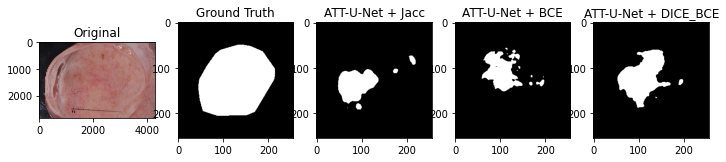

JS1: 0.8631, JS2:0.8596, JS3:0.8620


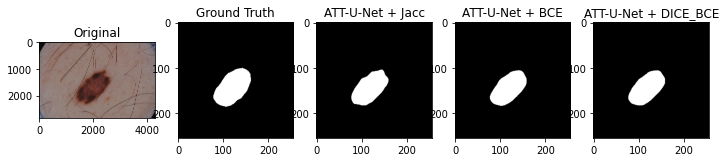

JS1: 0.7098, JS2:0.8421, JS3:0.8006


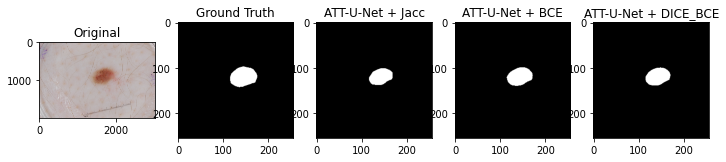

JS1: 0.6019, JS2:0.6243, JS3:0.6648


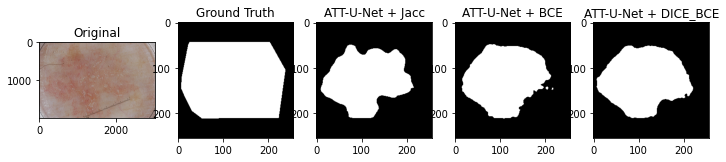

JS1: 0.3565, JS2:0.3413, JS3:0.3353


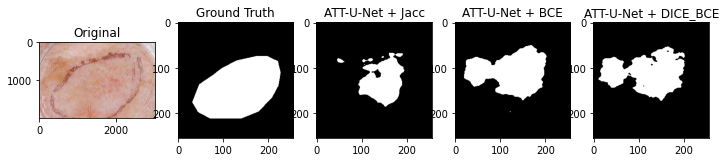

JS1: 0.1368, JS2:0.3496, JS3:0.2277


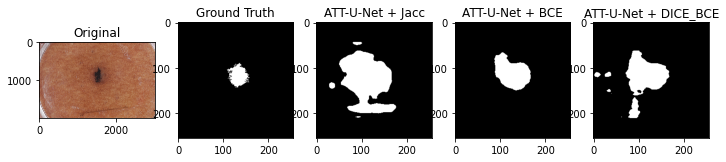

JS1: 0.1777, JS2:0.1098, JS3:0.1418


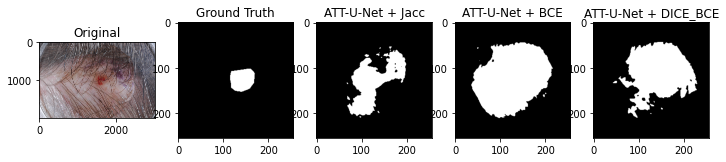

JS1: 0.8079, JS2:0.8871, JS3:0.8669


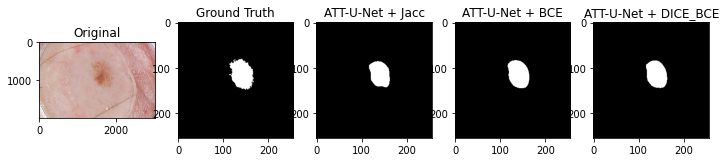

JS1: 0.7083, JS2:0.5416, JS3:0.5807


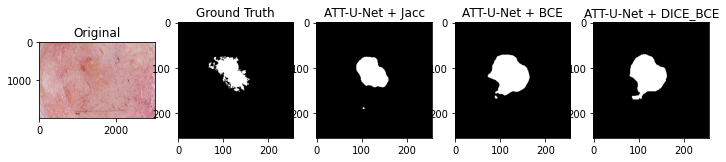

JS1: 0.8362, JS2:0.7895, JS3:0.7612


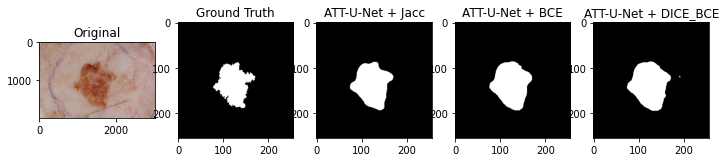

JS1: 0.2124, JS2:0.7647, JS3:0.6055


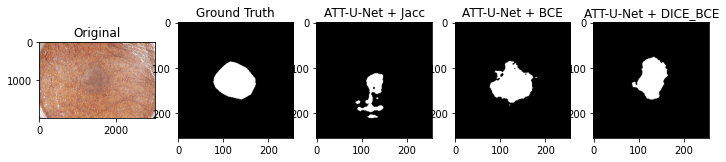

JS1: 0.4129, JS2:0.6012, JS3:0.4740


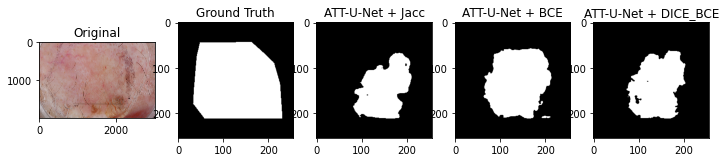

JS1: 0.6725, JS2:0.5716, JS3:0.7535


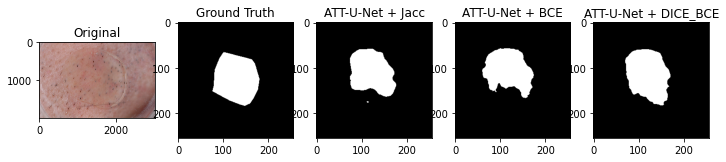

JS1: 0.3385, JS2:0.2581, JS3:0.2540


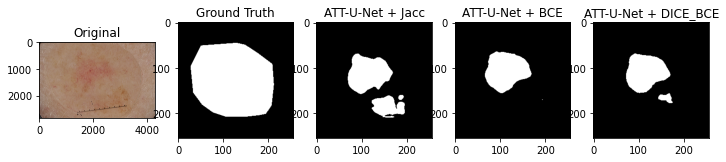

JS1: 0.5095, JS2:0.4148, JS3:0.5443


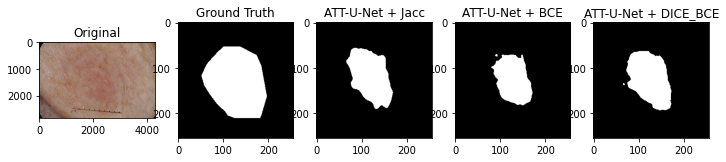

In [ ]:
df = pd.read_csv(test_csv_path)

samples = df.head(15)

for idx, row in samples.iterrows():

    img_id = '/' + row['image_id']

    img_path = test_img_folder + img_id + '.jpg'
    mask_path = test_seg_folder + img_id + '_segmentation.png'

    img = Image.open(img_path)
    mask = Image.open(mask_path).convert('1')

    image = img_transforms(img)
    mask = mask_transforms(mask)

    preds1 = predict(image, att_unet_jacc, th_att_unet_jacc)
    preds2 = predict(image, att_unet_bce, th_att_unet_bce)
    preds3 = predict(image, att_unet_bce_dice, th_att_unet_bce_dice)
    gt = mask.cpu().int().numpy()

   
    js1 = js(gt, preds1/255)
    js2 = js(gt, preds2/255)
    js3 = js(gt, preds3/255)


    print(f"JS1: {js1:.4f}, JS2:{js2:.4f}, JS3:{js3:.4f}")
    

    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(nrows=1, ncols = 5, figsize=(12, 5))

    ax1.imshow(np.array(img))
    ax1.set_title('Original')
         
    ax2.imshow(np.array(mask)[0, :, :], cmap='gray')
    ax2.set_title('Ground Truth')

    ax3.imshow(preds1, cmap='gray')
    ax3.set_title('ATT-U-Net + Jacc')

    ax4.imshow(preds2, cmap='gray')
    ax4.set_title('ATT-U-Net + BCE')

    
    ax5.imshow(preds3, cmap='gray')
    ax5.set_title('ATT-U-Net + DICE_BCE')


    plt.subplots_adjust()
    plt.show()

## *ResNet-Unet (Transfer Learning)*


### *Train & Test*

#### With Jaccard Loss 

##### Train

In [ ]:
# Parameters 
CHECKPOINT_RESNET_UNET_JACC = '/content/drive/MyDrive/checkpoints_original_ds/resnet_unet_jacc_new.pth' # save model to this file
WRITER_PATH = '/content/drive/MyDrive/Tensorboard_segmentation' # save progress to this directory

In [ ]:
LEARNING_RATE = 1e-4 # Base learning rate
DEVICE = "cuda" if torch.cuda.is_available() else "cpu" # Device used
NUM_EPOCHS = 100 # Max number of epochs
LR_PATIENCE = 7 # change LR if no improvement after this much epochs 
ES_PATIENCE = 20  # If the validation dice does not improve for this much epochs stop training 
WEIGHT_DECAY = 1e-6 #weight decay parameter of ADAM optimizer

In [ ]:
resnet_unet = ResNetUNet(n_class= 1).to(DEVICE)

In [ ]:
# Optimizer 
optimizer = optim.Adam(resnet_unet.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience= LR_PATIENCE, mode = "min", factor = 0.5, min_lr=1e-8)

# Gradient scaler 
grad_scaler = torch.cuda.amp.GradScaler()

# Loss function
criterion = JaccardLoss() 

In [ ]:
# Check initial Validation Dice score
val_score, loss = evaluate(resnet_unet, val_loader, criterion, DEVICE)

Valid: 150img [01:41,  1.48img/s, dice =0.448, loss =0.711]


In [ ]:
logging.info( 'Resnet-Unet, Adam, Jaccard')
logging.info( 'Initial val : loss : %.4f, dice: %.4f' % (loss, val_score))

Resnet-Unet, Adam, Jaccard
Initial val : loss : 0.8717, dice: 0.2185


In [ ]:
train_net(resnet_unet, # the model to be trained
          DEVICE, # cuda or cpu
          train_loader,  # training dataloader
          val_loader, # validation data loader
          ES_PATIENCE, # stop training if val loss does not improve after this much steps
          optimizer, 
          grad_scaler,# gradient scaler
          scheduler, # learning rate scheduler
          criterion, # Objectve/loss function t be minimized
          WRITER_PATH , # folder to track metrics
          NUM_EPOCHS, # number of epochs
          save_checkpoint = True, # whether to save the final model asa file  or not 
          checkpoint_path= CHECKPOINT_RESNET_UNET_JACC, # where to save the model
          amp = True)

Epoch 1/100: 2000img [18:10,  1.83img/s, loss (batch) =0.155]

	Epoch 1 : training loss = 0.40837, training dice = 0.71540



Valid: 150img [00:41,  3.65img/s, dice =0.844, loss =0.27]

	Epoch 1 : validation loss = 0.33840, validation dice = 0.79301



Epoch 2/100: 2000img [06:50,  4.87img/s, loss (batch) =0.294]

	Epoch 2 : training loss = 0.21275, training dice = 0.87878



Valid: 150img [00:40,  3.66img/s, dice =0.791, loss =0.346]

	Epoch 2 : validation loss = 0.39921, validation dice = 0.74144



Epoch 3/100: 2000img [06:45,  4.93img/s, loss (batch) =0.179]

	Epoch 3 : training loss = 0.19370, training dice = 0.89070



Valid: 150img [00:40,  3.68img/s, dice =0.846, loss =0.267]

	Epoch 3 : validation loss = 0.30416, validation dice = 0.81770



Epoch 4/100: 2000img [06:47,  4.91img/s, loss (batch) =0.0955]

	Epoch 4 : training loss = 0.18270, training dice = 0.89762



Valid: 150img [00:41,  3.65img/s, dice =0.827, loss =0.296]

	Epoch 4 : validation loss = 0.30556, validation dice = 0.81646



Epoch 5/100: 2000img [06:52,  4.84img/s, loss (batch) =0.101]

	Epoch 5 : training loss = 0.17410, training dice = 0.90318



Valid: 150img [00:40,  3.67img/s, dice =0.813, loss =0.315]

	Epoch 5 : validation loss = 0.33983, validation dice = 0.78857



Epoch 6/100: 2000img [06:51,  4.86img/s, loss (batch) =0.136]

	Epoch 6 : training loss = 0.16173, training dice = 0.91065



Valid: 150img [00:40,  3.67img/s, dice =0.902, loss =0.178]

	Epoch 6 : validation loss = 0.27027, validation dice = 0.83795



Epoch 7/100: 2000img [06:51,  4.85img/s, loss (batch) =0.154]

	Epoch 7 : training loss = 0.15977, training dice = 0.91186



Valid: 150img [00:41,  3.58img/s, dice =0.862, loss =0.242]

	Epoch 7 : validation loss = 0.25950, validation dice = 0.84841



Epoch 8/100: 2000img [06:52,  4.84img/s, loss (batch) =0.203]

	Epoch 8 : training loss = 0.16286, training dice = 0.90981



Valid: 150img [00:41,  3.66img/s, dice =0.79, loss =0.348]

	Epoch 8 : validation loss = 0.33868, validation dice = 0.79168



Epoch 9/100: 2000img [06:54,  4.82img/s, loss (batch) =0.216]

	Epoch 9 : training loss = 0.15210, training dice = 0.91667



Valid: 150img [00:41,  3.66img/s, dice =0.865, loss =0.239]

	Epoch 9 : validation loss = 0.27600, validation dice = 0.83692



Epoch 10/100: 2000img [06:57,  4.79img/s, loss (batch) =0.284]

	Epoch 10 : training loss = 0.15210, training dice = 0.91648



Valid: 150img [00:41,  3.66img/s, dice =0.833, loss =0.286]

	Epoch 10 : validation loss = 0.31304, validation dice = 0.81138



Epoch 11/100: 2000img [07:04,  4.71img/s, loss (batch) =0.122]

	Epoch 11 : training loss = 0.15038, training dice = 0.91773



Valid: 150img [00:41,  3.65img/s, dice =0.834, loss =0.284]

	Epoch 11 : validation loss = 0.28087, validation dice = 0.83427



Epoch 12/100: 2000img [06:51,  4.87img/s, loss (batch) =0.284]

	Epoch 12 : training loss = 0.14819, training dice = 0.91908



Valid: 150img [00:40,  3.67img/s, dice =0.829, loss =0.293]

	Epoch 12 : validation loss = 0.32401, validation dice = 0.80424



Epoch 13/100: 2000img [06:56,  4.80img/s, loss (batch) =0.0874]

	Epoch 13 : training loss = 0.15816, training dice = 0.91272



Valid: 150img [00:41,  3.64img/s, dice =0.867, loss =0.235]

	Epoch 13 : validation loss = 0.26008, validation dice = 0.84765



Epoch 14/100: 2000img [07:04,  4.72img/s, loss (batch) =0.237]

	Epoch 14 : training loss = 0.14762, training dice = 0.91903



Valid: 150img [00:41,  3.64img/s, dice =0.872, loss =0.226]

	Epoch 14 : validation loss = 0.24374, validation dice = 0.85906



Epoch 15/100: 2000img [06:52,  4.85img/s, loss (batch) =0.121]

	Epoch 15 : training loss = 0.13855, training dice = 0.92457



Valid: 150img [00:40,  3.66img/s, dice =0.901, loss =0.181]

	Epoch 15 : validation loss = 0.23540, validation dice = 0.86404



Epoch 16/100: 2000img [06:54,  4.83img/s, loss (batch) =0.105]

	Epoch 16 : training loss = 0.14160, training dice = 0.92301



Valid: 150img [00:41,  3.64img/s, dice =0.835, loss =0.284]

	Epoch 16 : validation loss = 0.29585, validation dice = 0.82351



Epoch 17/100: 2000img [07:03,  4.72img/s, loss (batch) =0.0812]

	Epoch 17 : training loss = 0.13427, training dice = 0.92708



Valid: 150img [00:41,  3.58img/s, dice =0.847, loss =0.265]

	Epoch 17 : validation loss = 0.27704, validation dice = 0.83721



Epoch 18/100: 2000img [06:53,  4.84img/s, loss (batch) =0.181]

	Epoch 18 : training loss = 0.13914, training dice = 0.92444



Valid: 150img [00:41,  3.66img/s, dice =0.915, loss =0.156]

	Epoch 18 : validation loss = 0.23306, validation dice = 0.86569



Epoch 19/100: 2000img [07:05,  4.70img/s, loss (batch) =0.0994]

	Epoch 19 : training loss = 0.14425, training dice = 0.92132



Valid: 150img [00:41,  3.64img/s, dice =0.852, loss =0.258]

	Epoch 19 : validation loss = 0.27148, validation dice = 0.84027



Epoch 20/100: 2000img [07:07,  4.67img/s, loss (batch) =0.0699]

	Epoch 20 : training loss = 0.13605, training dice = 0.92634



Valid: 150img [00:41,  3.58img/s, dice =0.854, loss =0.255]

	Epoch 20 : validation loss = 0.24891, validation dice = 0.85657



Epoch 21/100: 2000img [06:58,  4.78img/s, loss (batch) =0.127]

	Epoch 21 : training loss = 0.13537, training dice = 0.92646



Valid: 150img [00:41,  3.64img/s, dice =0.856, loss =0.251]

	Epoch 21 : validation loss = 0.27132, validation dice = 0.83935



Epoch 22/100: 2000img [06:55,  4.81img/s, loss (batch) =0.157]

	Epoch 22 : training loss = 0.13078, training dice = 0.92944



Valid: 150img [00:41,  3.64img/s, dice =0.824, loss =0.299]

	Epoch 22 : validation loss = 0.28364, validation dice = 0.83250



Epoch 23/100: 2000img [06:59,  4.77img/s, loss (batch) =0.112]

	Epoch 23 : training loss = 0.13463, training dice = 0.92703



Valid: 150img [00:41,  3.64img/s, dice =0.843, loss =0.271]

	Epoch 23 : validation loss = 0.26074, validation dice = 0.84792



Epoch 24/100: 2000img [06:53,  4.83img/s, loss (batch) =0.17]

	Epoch 24 : training loss = 0.13001, training dice = 0.92971



Valid: 150img [00:41,  3.64img/s, dice =0.835, loss =0.283]

	Epoch 24 : validation loss = 0.26178, validation dice = 0.84820



Epoch 25/100: 2000img [06:56,  4.80img/s, loss (batch) =0.0978]

	Epoch 25 : training loss = 0.13169, training dice = 0.92885



Valid: 150img [00:41,  3.64img/s, dice =0.878, loss =0.218]

	Epoch 25 : validation loss = 0.24956, validation dice = 0.85480



Epoch 26/100: 2000img [06:52,  4.85img/s, loss (batch) =0.224]

	Epoch 26 : training loss = 0.13712, training dice = 0.92541



Valid: 150img [00:41,  3.63img/s, dice =0.886, loss =0.205]

	Epoch 26 : validation loss = 0.32865, validation dice = 0.79890



Epoch 27/100: 2000img [06:46,  4.92img/s, loss (batch) =0.0847]

	Epoch 27 : training loss = 0.13036, training dice = 0.92941



Valid: 150img [00:41,  3.62img/s, dice =0.87, loss =0.231]

	Epoch 27 : validation loss = 0.25515, validation dice = 0.85127



Epoch 28/100: 2000img [06:58,  4.78img/s, loss (batch) =0.0926]

	Epoch 28 : training loss = 0.12235, training dice = 0.93432



Valid: 150img [00:41,  3.63img/s, dice =0.851, loss =0.259]

	Epoch 28 : validation loss = 0.27704, validation dice = 0.83655



Epoch 29/100: 2000img [07:02,  4.73img/s, loss (batch) =0.104]

	Epoch 29 : training loss = 0.11864, training dice = 0.93644



Valid: 150img [00:41,  3.63img/s, dice =0.851, loss =0.26]

	Epoch 29 : validation loss = 0.28268, validation dice = 0.83210



Epoch 30/100: 2000img [07:07,  4.67img/s, loss (batch) =0.0527]

	Epoch 30 : training loss = 0.11723, training dice = 0.93725



Valid: 150img [00:41,  3.61img/s, dice =0.846, loss =0.268]

	Epoch 30 : validation loss = 0.26921, validation dice = 0.84137



Epoch 31/100: 2000img [06:52,  4.85img/s, loss (batch) =0.064]

	Epoch 31 : training loss = 0.11486, training dice = 0.93860



Valid: 150img [00:41,  3.63img/s, dice =0.874, loss =0.224]

	Epoch 31 : validation loss = 0.25301, validation dice = 0.85215



Epoch 32/100: 2000img [07:07,  4.67img/s, loss (batch) =0.151]

	Epoch 32 : training loss = 0.11411, training dice = 0.93904



Valid: 150img [00:41,  3.63img/s, dice =0.864, loss =0.239]

	Epoch 32 : validation loss = 0.26730, validation dice = 0.84285



Epoch 33/100: 2000img [06:55,  4.82img/s, loss (batch) =0.186]

	Epoch 33 : training loss = 0.11136, training dice = 0.94065



Valid: 150img [00:41,  3.60img/s, dice =0.855, loss =0.254]

	Epoch 33 : validation loss = 0.26835, validation dice = 0.84199



Epoch 34/100: 2000img [06:57,  4.79img/s, loss (batch) =0.13]

	Epoch 34 : training loss = 0.11209, training dice = 0.94018



Valid: 150img [00:41,  3.63img/s, dice =0.855, loss =0.253]


	Epoch 34 : validation loss = 0.27945, validation dice = 0.83404


Epoch 35/100: 2000img [06:51,  4.86img/s, loss (batch) =0.0468]

	Epoch 35 : training loss = 0.10804, training dice = 0.94256



Valid: 150img [00:41,  3.63img/s, dice =0.851, loss =0.26]

	Epoch 35 : validation loss = 0.26977, validation dice = 0.84146



Epoch 36/100: 2000img [06:49,  4.88img/s, loss (batch) =0.116]

	Epoch 36 : training loss = 0.10827, training dice = 0.94237



Valid: 150img [00:41,  3.65img/s, dice =0.861, loss =0.245]

	Epoch 36 : validation loss = 0.25513, validation dice = 0.85086



Epoch 37/100: 2000img [06:53,  4.84img/s, loss (batch) =0.0711]

	Epoch 37 : training loss = 0.10447, training dice = 0.94457



Valid: 150img [00:40,  3.67img/s, dice =0.856, loss =0.252]

	Epoch 37 : validation loss = 0.26604, validation dice = 0.84367



Epoch 38/100: 2000img [06:52,  4.85img/s, loss (batch) =0.119]

	Epoch 38 : training loss = 0.10275, training dice = 0.94556



Valid: 150img [00:41,  3.65img/s, dice =0.858, loss =0.249]

	Epoch 38 : validation loss = 0.26458, validation dice = 0.84474



Epoch 39/100: 2000img [06:52,  4.85img/s, loss (batch) =0.0858]

	Epoch 39 : training loss = 0.10255, training dice = 0.94563



Valid: 150img [00:40,  3.66img/s, dice =0.867, loss =0.235]

	Epoch 39 : validation loss = 0.25142, validation dice = 0.85337
EARLY STOPPING AFTER 39 EPOCHS
Best validation loss = 0.23306
Best validation dice = 0.86569


##### Optimize Threshold

In [ ]:
resnet_unet.load_state_dict(torch.load(CHECKPOINT_RESNET_UNET_JACC))

<All keys matched successfully>

In [ ]:
# dummy function for bayesian optimization
def calculate_jaccard(th):
    jaccard = check_js(val_loader, resnet_unet, th)
    return jaccard

In [ ]:
pbounds = {'th': (0.01, 0.99)} # Search interval
optimizer = BayesianOptimization(
    f=calculate_jaccard, # function to maximize
    pbounds=pbounds, # search interval
    verbose=2, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=77,
)

In [ ]:
optimizer.maximize(
    init_points=1, # perform 2 steps of random exploration
    n_iter=10, # Perform 10 iterations
)

|   iter    |  target   |    th     |
-------------------------------------
|  1        |  0.7589   |  0.9107   |
|  2        |  0.7704   |  0.01     |
|  3        |  0.7703   |  0.0101   |
|  4        |  0.7636   |  0.4513   |
|  5        |  0.7654   |  0.2283   |
|  6        |  0.7704   |  0.01005  |
|  7        |  0.7619   |  0.6716   |
|  8        |  0.7704   |  0.01     |
|  9        |  0.7666   |  0.1225   |
|  10       |  0.7666   |  0.1225   |
|  11       |  0.7666   |  0.1225   |


##### Test

In [ ]:
dice, loss = evaluate(resnet_unet, test_loader, JaccardLoss(), DEVICE)
jacc = check_js_original_size(test_loader, resnet_unet, 0.01, test_seg_folder)
print("Model: Resnet-unet, Optimizer:ADAM, Loss: Jaccard Loss")
print(f'Test Dice: {dice:.4f}')
print(f'Test Loss: {loss:.4f}')
print(f'Test Jaccard: {jacc:.4f}')

Model: Resnet-unet, Optimizer:ADAM, Loss: Jaccard Loss
Test Dice: 0.8222
Test Loss: 0.2921
Test Jaccard: 0.7697


In [ ]:
logging.info( 'Test : loss : %.4f, dice: %.4f, jaccard: %.4f' %
                (loss, dice, jacc))

Test : loss : 0.2921, dice: 0.8222, jaccard: 0.7697


#### With BCE Loss

##### Train

In [ ]:
# Parameters 
CHECKPOINT_RESNET_UNET_BCE = '/content/drive/MyDrive/MRTYUTeam/checkpoints_original_ds/resnet_unet_bce_new.pth' # save model to this file
WRITER_PATH = '/content/drive/MyDrive/MRTYUTeam/Tensorboard/Segmentation/Original Dataset' # save progress to this directory

In [ ]:
LEARNING_RATE = 1e-4 # Base learning rate
DEVICE = "cuda" if torch.cuda.is_available() else "cpu" # Device used
NUM_EPOCHS = 100 # Max number of epochs
LR_PATIENCE = 7 # change LR if no improvement after this much epochs 
ES_PATIENCE = 20  # If the validation dice does not improve for this much epochs stop training 
WEIGHT_DECAY = 1e-6 #weight decay parameter of ADAM optimizer

In [ ]:
resnet_unet = ResNetUNet(n_class= 1).to(DEVICE)

In [ ]:
# Optimizer 
optimizer = optim.Adam(resnet_unet.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience= LR_PATIENCE, mode = "min", factor = 0.5, min_lr=1e-8)

# Gradient scaler 
grad_scaler = torch.cuda.amp.GradScaler()

# Loss function
criterion = nn.BCEWithLogitsLoss()

In [ ]:
# Check initial Validation Dice score
val_score, loss = evaluate(resnet_unet, val_loader, criterion, DEVICE)

logging.info( 'Resnet-Unet, Adam, BCE')
logging.info( 'Initial val : loss : %.4f, dice: %.4f' % (loss, val_score))

Valid: 150img [00:46,  3.24img/s, dice =0.431, loss =1.91]

Resnet-Unet, Adam, BCE
Initial val : loss : 2.0094, dice: 0.2071


In [ ]:
train_net(resnet_unet, # the model to be trained
          DEVICE, # cuda or cpu
          train_loader,  # training dataloader
          val_loader, # validation data loader
          ES_PATIENCE, # stop training if val loss does not improve after this much steps
          optimizer, 
          grad_scaler,# gradient scaler
          scheduler, # learning rate scheduler
          criterion, # Objectve/loss function t be minimized
          WRITER_PATH , # folder to track metrics
          NUM_EPOCHS, # number of epochs
          save_checkpoint = True, # whether to save the final model asa file  or not 
          checkpoint_path= CHECKPOINT_RESNET_UNET_BCE, # where to save the model
          amp = True)

Epoch 1/100: 2000img [07:58,  4.18img/s, loss (batch) =0.0603]

	Epoch 1 : training loss = 0.25261, training dice = 0.69758



Valid: 150img [00:46,  3.21img/s, dice =0.783, loss =0.256]

	Epoch 1 : validation loss = 0.13828, validation dice = 0.69155



Epoch 2/100: 2000img [07:40,  4.34img/s, loss (batch) =0.0889]

	Epoch 2 : training loss = 0.08959, training dice = 0.82145



Valid: 150img [00:46,  3.22img/s, dice =0.82, loss =0.205]

	Epoch 2 : validation loss = 0.11121, validation dice = 0.75098



Epoch 3/100: 2000img [07:53,  4.22img/s, loss (batch) =0.0779]

	Epoch 3 : training loss = 0.07860, training dice = 0.83875



Valid: 150img [00:45,  3.33img/s, dice =0.853, loss =0.181]

	Epoch 3 : validation loss = 0.09562, validation dice = 0.80178



Epoch 4/100: 2000img [07:52,  4.23img/s, loss (batch) =0.0679]

	Epoch 4 : training loss = 0.06481, training dice = 0.86443



Valid: 150img [00:47,  3.16img/s, dice =0.794, loss =0.259]

	Epoch 4 : validation loss = 0.11744, validation dice = 0.76649



Epoch 5/100: 2000img [07:47,  4.28img/s, loss (batch) =0.0796]

	Epoch 5 : training loss = 0.06300, training dice = 0.86646



Valid: 150img [00:45,  3.29img/s, dice =0.822, loss =0.2]

	Epoch 5 : validation loss = 0.10827, validation dice = 0.75445



Epoch 6/100: 2000img [08:05,  4.12img/s, loss (batch) =0.0485]

	Epoch 6 : training loss = 0.05991, training dice = 0.87448



Valid: 150img [00:47,  3.17img/s, dice =0.85, loss =0.158]

	Epoch 6 : validation loss = 0.08556, validation dice = 0.78516



Epoch 7/100: 2000img [07:43,  4.32img/s, loss (batch) =0.0302]

	Epoch 7 : training loss = 0.05794, training dice = 0.87655



Valid: 150img [00:46,  3.25img/s, dice =0.82, loss =0.263]

	Epoch 7 : validation loss = 0.14365, validation dice = 0.73845



Epoch 8/100: 2000img [07:48,  4.27img/s, loss (batch) =0.0377]

	Epoch 8 : training loss = 0.05698, training dice = 0.87855



Valid: 150img [00:48,  3.12img/s, dice =0.85, loss =0.191]

	Epoch 8 : validation loss = 0.08811, validation dice = 0.80947



Epoch 9/100: 2000img [08:08,  4.09img/s, loss (batch) =0.0371]

	Epoch 9 : training loss = 0.05349, training dice = 0.88517



Valid: 150img [00:46,  3.20img/s, dice =0.858, loss =0.187]

	Epoch 9 : validation loss = 0.09357, validation dice = 0.82553



Epoch 10/100: 2000img [07:58,  4.18img/s, loss (batch) =0.0439]

	Epoch 10 : training loss = 0.05292, training dice = 0.88595



Valid: 150img [00:46,  3.22img/s, dice =0.851, loss =0.191]

	Epoch 10 : validation loss = 0.09245, validation dice = 0.81812



Epoch 11/100: 2000img [07:31,  4.43img/s, loss (batch) =0.0494]

	Epoch 11 : training loss = 0.05023, training dice = 0.89012



Valid: 150img [00:46,  3.24img/s, dice =0.864, loss =0.2]

	Epoch 11 : validation loss = 0.09542, validation dice = 0.82084



Epoch 12/100: 2000img [07:56,  4.20img/s, loss (batch) =0.0791]

	Epoch 12 : training loss = 0.04841, training dice = 0.89493



Valid: 150img [00:48,  3.11img/s, dice =0.856, loss =0.216]

	Epoch 12 : validation loss = 0.09950, validation dice = 0.82080



Epoch 13/100: 2000img [07:59,  4.17img/s, loss (batch) =0.0487]

	Epoch 13 : training loss = 0.04879, training dice = 0.89475



Valid: 150img [00:46,  3.22img/s, dice =0.823, loss =0.249]

	Epoch 13 : validation loss = 0.11589, validation dice = 0.80531



Epoch 14/100: 2000img [07:56,  4.20img/s, loss (batch) =0.029]

	Epoch 14 : training loss = 0.04662, training dice = 0.89671



Valid: 150img [00:46,  3.22img/s, dice =0.839, loss =0.244]

	Epoch 14 : validation loss = 0.11132, validation dice = 0.81775



Epoch 15/100: 2000img [07:47,  4.28img/s, loss (batch) =0.0788]

	Epoch 15 : training loss = 0.04294, training dice = 0.90539



Valid: 150img [00:46,  3.20img/s, dice =0.82, loss =0.285]

	Epoch 15 : validation loss = 0.12533, validation dice = 0.80156



Epoch 16/100: 2000img [07:52,  4.23img/s, loss (batch) =0.0631]

	Epoch 16 : training loss = 0.04153, training dice = 0.90765



Valid: 150img [00:46,  3.25img/s, dice =0.85, loss =0.252]

	Epoch 16 : validation loss = 0.11335, validation dice = 0.82597



Epoch 17/100: 2000img [07:42,  4.32img/s, loss (batch) =0.0283]

	Epoch 17 : training loss = 0.04038, training dice = 0.91002



Valid: 150img [00:48,  3.11img/s, dice =0.856, loss =0.249]

	Epoch 17 : validation loss = 0.11231, validation dice = 0.82895



Epoch 18/100: 2000img [07:39,  4.35img/s, loss (batch) =0.0153]

	Epoch 18 : training loss = 0.03978, training dice = 0.91146



Valid: 150img [00:46,  3.21img/s, dice =0.836, loss =0.289]

	Epoch 18 : validation loss = 0.11672, validation dice = 0.82531



Epoch 19/100: 2000img [07:48,  4.27img/s, loss (batch) =0.0542]

	Epoch 19 : training loss = 0.03815, training dice = 0.91448



Valid: 150img [00:45,  3.29img/s, dice =0.863, loss =0.221]

	Epoch 19 : validation loss = 0.09992, validation dice = 0.83457



Epoch 20/100: 2000img [07:38,  4.36img/s, loss (batch) =0.0697]

	Epoch 20 : training loss = 0.03780, training dice = 0.91563



Valid: 150img [00:46,  3.24img/s, dice =0.849, loss =0.271]

	Epoch 20 : validation loss = 0.11160, validation dice = 0.83269



Epoch 21/100: 2000img [07:52,  4.23img/s, loss (batch) =0.0282]

	Epoch 21 : training loss = 0.03717, training dice = 0.91663



Valid: 150img [00:46,  3.26img/s, dice =0.835, loss =0.336]

	Epoch 21 : validation loss = 0.13781, validation dice = 0.82314



Epoch 22/100: 2000img [07:12,  4.63img/s, loss (batch) =0.0429]

	Epoch 22 : training loss = 0.03791, training dice = 0.91628



Valid: 150img [00:41,  3.58img/s, dice =0.825, loss =0.34]

	Epoch 22 : validation loss = 0.13344, validation dice = 0.80974



Epoch 23/100: 2000img [07:10,  4.65img/s, loss (batch) =0.0273]

	Epoch 23 : training loss = 0.03604, training dice = 0.91966



Valid: 150img [00:41,  3.60img/s, dice =0.846, loss =0.283]

	Epoch 23 : validation loss = 0.11242, validation dice = 0.83574



Epoch 24/100: 2000img [06:53,  4.84img/s, loss (batch) =0.0618]

	Epoch 24 : training loss = 0.03463, training dice = 0.92261



Valid: 150img [00:41,  3.58img/s, dice =0.835, loss =0.311]

	Epoch 24 : validation loss = 0.12487, validation dice = 0.82688



Epoch 25/100: 2000img [07:01,  4.74img/s, loss (batch) =0.027]

	Epoch 25 : training loss = 0.03382, training dice = 0.92385



Valid: 150img [00:41,  3.59img/s, dice =0.839, loss =0.321]

	Epoch 25 : validation loss = 0.12813, validation dice = 0.82563



Epoch 26/100: 2000img [06:56,  4.81img/s, loss (batch) =0.0302]

	Epoch 26 : training loss = 0.03376, training dice = 0.92426



Valid: 150img [00:41,  3.60img/s, dice =0.843, loss =0.293]

	Epoch 26 : validation loss = 0.12948, validation dice = 0.82155



Epoch 27/100: 2000img [06:54,  4.83img/s, loss (batch) =0.0345]

	Epoch 27 : training loss = 0.03648, training dice = 0.91856



Valid: 150img [00:41,  3.60img/s, dice =0.848, loss =0.253]

	Epoch 27 : validation loss = 0.11235, validation dice = 0.82381
EARLY STOPPING AFTER 27 EPOCHS
Best validation loss = 0.08556
Best validation dice = 0.83574


##### Optimize Threshold

In [ ]:
resnet_unet.load_state_dict(torch.load(CHECKPOINT_RESNET_UNET_BCE))

<All keys matched successfully>

In [ ]:
# dummy function for bayesian optimization
def calculate_jaccard(th):
    jaccard = check_js(val_loader, resnet_unet, threshold= th, device="cuda")
    return jaccard

In [ ]:
pbounds = {'th': (0.01, 0.99)} # Search interval
optimizer = BayesianOptimization(
    f=calculate_jaccard, # function to maximize
    pbounds=pbounds, # search interval
    verbose=2, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=42,
)

In [ ]:
optimizer.maximize(
    init_points=2, # perform 2 steps of random exploration
    n_iter=10, # Perform 10 iterations
)

|   iter    |  target   |    th     |
-------------------------------------
|  1        |  0.7559   |  0.377    |
|  2        |  0.6142   |  0.9417   |
|  3        |  0.756    |  0.3759   |
|  4        |  0.6707   |  0.01     |
|  5        |  0.7325   |  0.601    |
|  6        |  0.7625   |  0.2276   |
|  7        |  0.7608   |  0.2826   |
|  8        |  0.7459   |  0.4953   |
|  9        |  0.7619   |  0.1839   |
|  10       |  0.7623   |  0.2047   |
|  11       |  0.762    |  0.2519   |
|  12       |  0.7626   |  0.2188   |


##### Test

In [ ]:
dice, loss = evaluate(resnet_unet, test_loader, nn.BCEWithLogitsLoss(), DEVICE)
jacc = check_js_original_size(test_loader, resnet_unet, 0.2188, test_seg_folder)
print("Model: Resnet-unet, Optimizer:ADAM, Loss: BCE")
print(f'Test Dice: {dice:.4f}')
print(f'Test Loss: {loss:.4f}')
print(f'Test Jaccard: {jacc:.4f}')

Model: Resnet-unet, Optimizer:ADAM, Loss: BCE
Test Dice: 0.8109
Test Loss: 0.1698
Test Jaccard: 0.7857


In [ ]:
logging.info( 'Test : loss : %.4f, dice: %.4f, jaccard: %.4f' %
                (loss, dice, jacc))

Test : loss : 0.1698, dice: 0.8109, jaccard: 0.7857


#### With DiceBCE Loss 

##### Train

In [ ]:
# Parameters 
CHECKPOINT_RESNET_UNET_BCE_DICE = '/content/drive/MyDrive/MRTYUTeam/checkpoints_original_ds/resnet_unet_bce_dice_new.pth' # save model to this file
WRITER_PATH = '/content/drive/MyDrive/MRTYUTeam/Tensorboard/Segmentation/Original Dataset' # save progress to this directory

In [ ]:
LEARNING_RATE = 1e-4 # Base learning rate
DEVICE = "cuda" if torch.cuda.is_available() else "cpu" # Device used
NUM_EPOCHS = 100 # Max number of epochs
LR_PATIENCE = 7 # change LR if no improvement after this much epochs 
ES_PATIENCE = 20  # If the validation dice does not improve for this much epochs stop training 
WEIGHT_DECAY = 1e-6 #weight decay parameter of ADAM optimizer

In [ ]:
resnet_unet = ResNetUNet(n_class= 1).to(DEVICE)

In [ ]:
# Optimizer 
optimizer = optim.Adam(resnet_unet.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience= LR_PATIENCE, mode = "min", factor = 0.5, min_lr=1e-8)

# Gradient scaler 
grad_scaler = torch.cuda.amp.GradScaler()

# Loss function
criterion = DiceBCELoss()

In [ ]:
# Check initial Validation Dice score
val_score, loss = evaluate(resnet_unet, val_loader, criterion, DEVICE)

In [ ]:
logging.info( 'Resnet-Unet, Adam, BCE+DICE')
logging.info( 'Initial val : loss : %.4f, dice: %.4f' % (loss, val_score))

Resnet-Unet, Adam, BCE+DICE
Initial val : loss : 3.2042, dice: 0.1937


In [ ]:
train_net(resnet_unet, # the model to be trained
          DEVICE, # cuda or cpu
          train_loader,  # training dataloader
          val_loader, # validation data loader
          ES_PATIENCE, # stop training if val loss does not improve after this much steps
          optimizer, 
          grad_scaler,# gradient scaler
          scheduler, # learning rate scheduler
          criterion, # Objectve/loss function t be minimized
          WRITER_PATH , # folder to track metrics
          NUM_EPOCHS, # number of epochs
          save_checkpoint = True, # whether to save the final model asa file  or not 
          checkpoint_path= CHECKPOINT_RESNET_UNET_BCE_DICE, # where to save the model
          amp = True)

Epoch 1/100: 2000img [07:22,  4.52img/s, loss (batch) =0.296]

	Epoch 1 : training loss = 0.97374, training dice = 0.65687



Valid: 150img [00:43,  3.48img/s, dice =0.815, loss =0.458]

	Epoch 1 : validation loss = 0.44079, validation dice = 0.71974



Epoch 2/100: 2000img [07:22,  4.52img/s, loss (batch) =0.24]

	Epoch 2 : training loss = 0.25616, training dice = 0.85034



Valid: 150img [00:42,  3.52img/s, dice =0.77, loss =0.663]

	Epoch 2 : validation loss = 0.44727, validation dice = 0.74115



Epoch 3/100: 2000img [07:15,  4.60img/s, loss (batch) =0.174]

	Epoch 3 : training loss = 0.20782, training dice = 0.87812



Valid: 150img [00:42,  3.53img/s, dice =0.795, loss =0.607]

	Epoch 3 : validation loss = 0.37894, validation dice = 0.78719



Epoch 4/100: 2000img [07:15,  4.59img/s, loss (batch) =0.234]

	Epoch 4 : training loss = 0.18785, training dice = 0.88874



Valid: 150img [00:42,  3.54img/s, dice =0.878, loss =0.317]

	Epoch 4 : validation loss = 0.28344, validation dice = 0.82425



Epoch 5/100: 2000img [07:16,  4.59img/s, loss (batch) =0.131]

	Epoch 5 : training loss = 0.18568, training dice = 0.89043



Valid: 150img [00:42,  3.51img/s, dice =0.874, loss =0.32]

	Epoch 5 : validation loss = 0.28831, validation dice = 0.81693



Epoch 6/100: 2000img [07:26,  4.48img/s, loss (batch) =0.129]

	Epoch 6 : training loss = 0.18029, training dice = 0.89308



Valid: 150img [00:42,  3.56img/s, dice =0.854, loss =0.39]

	Epoch 6 : validation loss = 0.28371, validation dice = 0.82908



Epoch 7/100: 2000img [07:08,  4.66img/s, loss (batch) =0.101]

	Epoch 7 : training loss = 0.16845, training dice = 0.89958



Valid: 150img [00:42,  3.56img/s, dice =0.834, loss =0.458]

	Epoch 7 : validation loss = 0.32202, validation dice = 0.81029



Epoch 8/100: 2000img [07:16,  4.58img/s, loss (batch) =0.352]

	Epoch 8 : training loss = 0.16120, training dice = 0.90355



Valid: 150img [00:42,  3.56img/s, dice =0.848, loss =0.485]

	Epoch 8 : validation loss = 0.31025, validation dice = 0.83055



Epoch 9/100: 2000img [07:09,  4.66img/s, loss (batch) =0.198]

	Epoch 9 : training loss = 0.16269, training dice = 0.90272



Valid: 150img [00:42,  3.57img/s, dice =0.835, loss =0.459]

	Epoch 9 : validation loss = 0.32181, validation dice = 0.81307



Epoch 10/100: 2000img [07:08,  4.66img/s, loss (batch) =0.151]

	Epoch 10 : training loss = 0.16273, training dice = 0.90412



Valid: 150img [00:42,  3.55img/s, dice =0.874, loss =0.339]

	Epoch 10 : validation loss = 0.26706, validation dice = 0.83873



Epoch 11/100: 2000img [07:10,  4.64img/s, loss (batch) =0.16]

	Epoch 11 : training loss = 0.15149, training dice = 0.90926



Valid: 150img [00:42,  3.55img/s, dice =0.834, loss =0.468]

	Epoch 11 : validation loss = 0.31795, validation dice = 0.81319



Epoch 12/100: 2000img [07:01,  4.75img/s, loss (batch) =0.119]

	Epoch 12 : training loss = 0.14813, training dice = 0.91037



Valid: 150img [00:42,  3.55img/s, dice =0.835, loss =0.483]

	Epoch 12 : validation loss = 0.30153, validation dice = 0.83274



Epoch 13/100: 2000img [07:10,  4.65img/s, loss (batch) =0.131]

	Epoch 13 : training loss = 0.15175, training dice = 0.90947



Valid: 150img [00:42,  3.56img/s, dice =0.864, loss =0.424]

	Epoch 13 : validation loss = 0.29227, validation dice = 0.84094



Epoch 14/100: 2000img [06:58,  4.78img/s, loss (batch) =0.11]

	Epoch 14 : training loss = 0.14409, training dice = 0.91319



Valid: 150img [00:42,  3.56img/s, dice =0.792, loss =0.664]

	Epoch 14 : validation loss = 0.35528, validation dice = 0.81116



Epoch 15/100: 2000img [07:05,  4.70img/s, loss (batch) =0.148]

	Epoch 15 : training loss = 0.14503, training dice = 0.91304



Valid: 150img [00:42,  3.54img/s, dice =0.876, loss =0.377]

	Epoch 15 : validation loss = 0.27411, validation dice = 0.83995



Epoch 16/100: 2000img [07:09,  4.66img/s, loss (batch) =0.114]

	Epoch 16 : training loss = 0.14091, training dice = 0.91499



Valid: 150img [00:42,  3.55img/s, dice =0.831, loss =0.528]

	Epoch 16 : validation loss = 0.34074, validation dice = 0.81297



Epoch 17/100: 2000img [07:16,  4.58img/s, loss (batch) =0.152]

	Epoch 17 : training loss = 0.14043, training dice = 0.91518



Valid: 150img [00:42,  3.56img/s, dice =0.868, loss =0.37]

	Epoch 17 : validation loss = 0.26279, validation dice = 0.84398



Epoch 18/100: 2000img [07:07,  4.68img/s, loss (batch) =0.183]

	Epoch 18 : training loss = 0.13557, training dice = 0.91798



Valid: 150img [00:42,  3.53img/s, dice =0.873, loss =0.375]

	Epoch 18 : validation loss = 0.28134, validation dice = 0.83609



Epoch 19/100: 2000img [07:09,  4.66img/s, loss (batch) =0.2]

	Epoch 19 : training loss = 0.13969, training dice = 0.91698



Valid: 150img [00:42,  3.50img/s, dice =0.841, loss =0.516]

	Epoch 19 : validation loss = 0.31595, validation dice = 0.83431



Epoch 20/100: 2000img [07:03,  4.72img/s, loss (batch) =0.129]

	Epoch 20 : training loss = 0.13560, training dice = 0.91838



Valid: 150img [00:42,  3.54img/s, dice =0.831, loss =0.51]

	Epoch 20 : validation loss = 0.30253, validation dice = 0.83329



Epoch 21/100: 2000img [07:11,  4.63img/s, loss (batch) =0.106]

	Epoch 21 : training loss = 0.12522, training dice = 0.92406



Valid: 150img [00:42,  3.54img/s, dice =0.86, loss =0.402]

	Epoch 21 : validation loss = 0.29097, validation dice = 0.82970



Epoch 22/100: 2000img [07:15,  4.59img/s, loss (batch) =0.111]

	Epoch 22 : training loss = 0.12667, training dice = 0.92309



Valid: 150img [00:42,  3.53img/s, dice =0.857, loss =0.404]

	Epoch 22 : validation loss = 0.28347, validation dice = 0.84122



Epoch 23/100: 2000img [07:11,  4.64img/s, loss (batch) =0.157]

	Epoch 23 : training loss = 0.13002, training dice = 0.92127



Valid: 150img [00:42,  3.53img/s, dice =0.857, loss =0.45]

	Epoch 23 : validation loss = 0.28187, validation dice = 0.84318



Epoch 24/100: 2000img [07:13,  4.61img/s, loss (batch) =0.109]

	Epoch 24 : training loss = 0.12804, training dice = 0.92256



Valid: 150img [00:42,  3.52img/s, dice =0.829, loss =0.516]

	Epoch 24 : validation loss = 0.32078, validation dice = 0.82439



Epoch 25/100: 2000img [07:19,  4.55img/s, loss (batch) =0.152]

	Epoch 25 : training loss = 0.12395, training dice = 0.92490



Valid: 150img [00:43,  3.47img/s, dice =0.86, loss =0.484]

	Epoch 25 : validation loss = 0.31486, validation dice = 0.83407



Epoch 26/100: 2000img [07:03,  4.72img/s, loss (batch) =0.153]

	Epoch 26 : training loss = 0.11544, training dice = 0.92949



Valid: 150img [00:42,  3.54img/s, dice =0.818, loss =0.616]

	Epoch 26 : validation loss = 0.34644, validation dice = 0.82157



Epoch 27/100: 2000img [07:11,  4.64img/s, loss (batch) =0.0777]

	Epoch 27 : training loss = 0.11902, training dice = 0.92773



Valid: 150img [00:42,  3.52img/s, dice =0.841, loss =0.571]

	Epoch 27 : validation loss = 0.32684, validation dice = 0.83643



Epoch 28/100: 2000img [07:03,  4.72img/s, loss (batch) =0.164]

	Epoch 28 : training loss = 0.10928, training dice = 0.93329



Valid: 150img [00:42,  3.56img/s, dice =0.861, loss =0.48]

	Epoch 28 : validation loss = 0.30699, validation dice = 0.83944



Epoch 29/100: 2000img [07:22,  4.52img/s, loss (batch) =0.133]

	Epoch 29 : training loss = 0.10933, training dice = 0.93352



Valid: 150img [00:43,  3.46img/s, dice =0.814, loss =0.624]

	Epoch 29 : validation loss = 0.34531, validation dice = 0.82829



Epoch 30/100: 2000img [07:07,  4.68img/s, loss (batch) =0.15]

	Epoch 30 : training loss = 0.10712, training dice = 0.93458



Valid: 150img [00:42,  3.53img/s, dice =0.833, loss =0.608]

	Epoch 30 : validation loss = 0.36547, validation dice = 0.82256



Epoch 31/100: 2000img [07:14,  4.61img/s, loss (batch) =0.0638]

	Epoch 31 : training loss = 0.10712, training dice = 0.93487



Valid: 150img [00:42,  3.54img/s, dice =0.859, loss =0.444]

	Epoch 31 : validation loss = 0.29748, validation dice = 0.84008



Epoch 32/100: 2000img [07:14,  4.60img/s, loss (batch) =0.103]

	Epoch 32 : training loss = 0.10357, training dice = 0.93703



Valid: 150img [00:42,  3.54img/s, dice =0.839, loss =0.534]

	Epoch 32 : validation loss = 0.33131, validation dice = 0.82888



Epoch 33/100: 2000img [07:08,  4.66img/s, loss (batch) =0.0755]

	Epoch 33 : training loss = 0.10441, training dice = 0.93646



Valid: 150img [00:42,  3.50img/s, dice =0.846, loss =0.547]

	Epoch 33 : validation loss = 0.33994, validation dice = 0.82846



Epoch 34/100: 2000img [07:16,  4.58img/s, loss (batch) =0.0597]

	Epoch 34 : training loss = 0.09820, training dice = 0.93975



Valid: 150img [00:42,  3.52img/s, dice =0.819, loss =0.667]

	Epoch 34 : validation loss = 0.36963, validation dice = 0.82328



Epoch 35/100: 2000img [07:05,  4.70img/s, loss (batch) =0.0833]

	Epoch 35 : training loss = 0.09663, training dice = 0.94050



Valid: 150img [00:42,  3.53img/s, dice =0.843, loss =0.567]

	Epoch 35 : validation loss = 0.33060, validation dice = 0.83754



Epoch 36/100: 2000img [07:25,  4.48img/s, loss (batch) =0.0894]

	Epoch 36 : training loss = 0.09524, training dice = 0.94182



Valid: 150img [00:42,  3.53img/s, dice =0.834, loss =0.613]

	Epoch 36 : validation loss = 0.34486, validation dice = 0.83311



Epoch 37/100: 2000img [07:15,  4.59img/s, loss (batch) =0.0654]

	Epoch 37 : training loss = 0.09552, training dice = 0.94129



Valid: 150img [00:42,  3.54img/s, dice =0.845, loss =0.596]

	Epoch 37 : validation loss = 0.34364, validation dice = 0.83377



Epoch 38/100: 2000img [07:24,  4.50img/s, loss (batch) =0.0926]

	Epoch 38 : training loss = 0.09427, training dice = 0.94238



Valid: 150img [00:42,  3.53img/s, dice =0.846, loss =0.587]

	Epoch 38 : validation loss = 0.35532, validation dice = 0.83010
EARLY STOPPING AFTER 38 EPOCHS
Best validation loss = 0.26279
Best validation dice = 0.84398


##### Optimize Threshold

In [ ]:
resnet_unet.load_state_dict(torch.load(CHECKPOINT_RESNET_UNET_BCE_DICE))

<All keys matched successfully>

In [ ]:
# dummy function for bayesian optimization
def calculate_jaccard(th):
    jaccard = check_js(val_loader, resnet_unet, th)
    return jaccard

In [ ]:
pbounds = {'th': (0.01, 0.99)} # Search interval
optimizer = BayesianOptimization(
    f=calculate_jaccard, # function to maximize
    pbounds=pbounds, # search interval
    verbose=2, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=42,
)

In [ ]:
optimizer.maximize(
    init_points=1, # perform 1 step of random exploration
    n_iter=10, # Perform 10 iterations
)

|   iter    |  target   |    th     |
-------------------------------------
|  1        |  0.7575   |  0.377    |
|  2        |  0.5382   |  0.99     |
|  3        |  0.7574   |  0.3806   |
|  4        |  0.6755   |  0.01     |
|  5        |  0.7575   |  0.3764   |
|  6        |  0.7457   |  0.5964   |
|  7        |  0.7619   |  0.2112   |
|  8        |  0.7514   |  0.5066   |
|  9        |  0.7608   |  0.2703   |
|  10       |  0.7616   |  0.2358   |
|  11       |  0.7622   |  0.171    |


##### Test

In [ ]:
dice, loss = evaluate(resnet_unet, test_loader, DiceBCELoss(), DEVICE)
jacc = check_js_original_size(test_loader, resnet_unet, 0.1710, test_seg_folder)
print("Model: Resnet-unet, Optimizer:ADAM, Loss: BCE + Dice")
print(f'Test Dice: {dice:.4f}')
print(f'Test Loss: {loss:.4f}')
print(f'Test Jaccard: {jacc:.4f}')

Model: Resnet-unet, Optimizer:ADAM, Loss: BCE + Dice
Test Dice: 0.8158
Test Loss: 0.3840
Test Jaccard: 0.7785


In [ ]:
logging.info( 'Test : loss : %.4f, dice: %.4f, jaccard: %.4f' %
                (loss, dice, jacc))

Test : loss : 0.3840, dice: 0.8158, jaccard: 0.7785


### *Show samples*

In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu" # Device used

In [ ]:
CHECKPOINT_RES_UNET_JACC = '/content/drive/MyDrive/MRTYUTeam/checkpoints_original_ds/resnet_unet_jacc_new.pth'
CHECKPOINT_RES_UNET_BCE = '/content/drive/MyDrive/MRTYUTeam/checkpoints_original_ds/resnet_unet_bce_new.pth'
CHECKPOINT_RES_UNET_DiceBCE = '/content/drive/MyDrive/MRTYUTeam/checkpoints_original_ds/resnet_unet_bce_dice_new.pth'

In [ ]:
res_unet_jacc = ResNetUNet(n_class= 1).to(DEVICE)
res_unet_jacc.load_state_dict(torch.load(CHECKPOINT_RES_UNET_JACC))
res_unet_jacc.eval()

th_res_unet_jacc = 0.01

In [ ]:
res_unet_bce = ResNetUNet(n_class= 1).to(DEVICE)
res_unet_bce.load_state_dict(torch.load(CHECKPOINT_RES_UNET_BCE))
res_unet_bce.eval()

th_res_unet_bce = 0.2188

In [ ]:
res_unet_bce_dice = ResNetUNet(n_class= 1).to(DEVICE)
res_unet_bce_dice.load_state_dict(torch.load(CHECKPOINT_RES_UNET_DiceBCE))
res_unet_bce_dice.eval()

th_res_unet_bce_dice =  0.1710

JS1: 0.7783, JS2:0.4052, JS3:0.7267


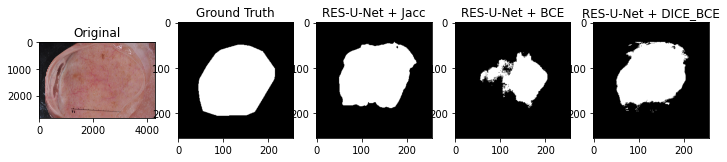

JS1: 0.8674, JS2:0.8689, JS3:0.8672


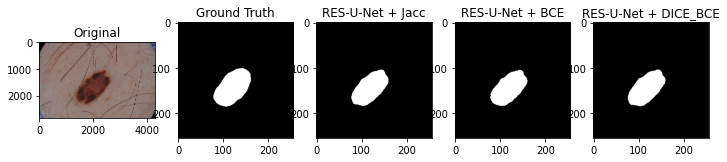

JS1: 0.7695, JS2:0.8418, JS3:0.8513


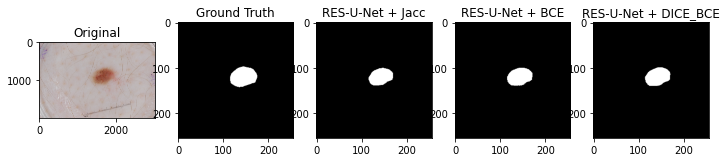

JS1: 0.6791, JS2:0.7277, JS3:0.6658


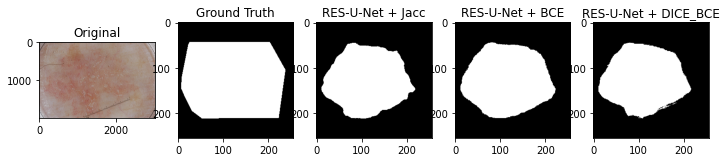

JS1: 0.5678, JS2:0.6572, JS3:0.5547


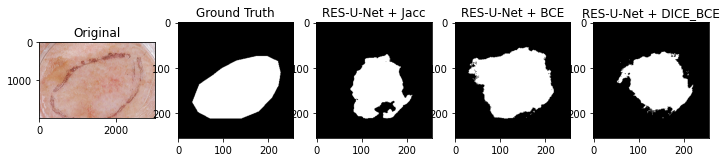

JS1: 0.5278, JS2:0.7760, JS3:0.7640


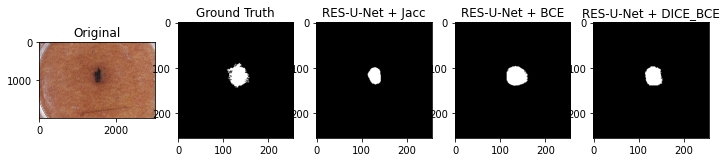

JS1: 0.5899, JS2:0.6446, JS3:0.3830


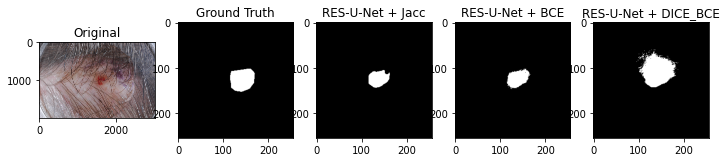

JS1: 0.9013, JS2:0.9040, JS3:0.9147


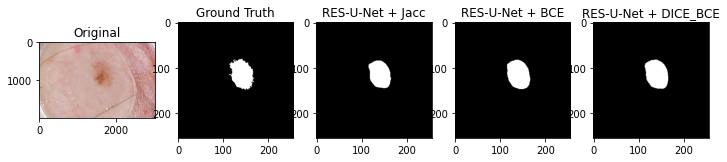

JS1: 0.6024, JS2:0.7015, JS3:0.6520


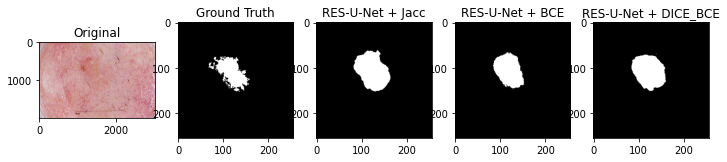

JS1: 0.7955, JS2:0.7594, JS3:0.7782


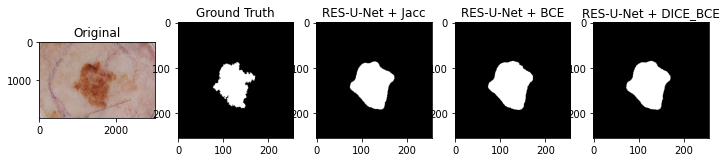

JS1: 0.7593, JS2:0.8246, JS3:0.8521


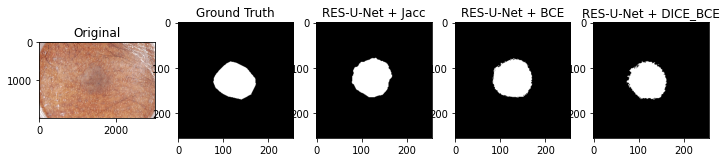

JS1: 0.5496, JS2:0.7395, JS3:0.5664


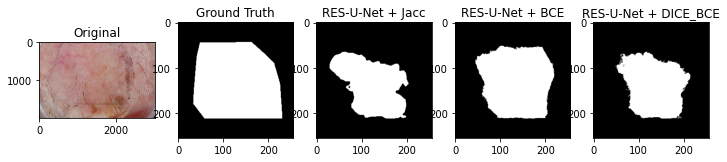

JS1: 0.4051, JS2:0.5076, JS3:0.5784


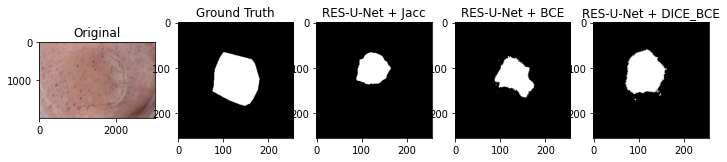

JS1: 0.2107, JS2:0.2504, JS3:0.2633


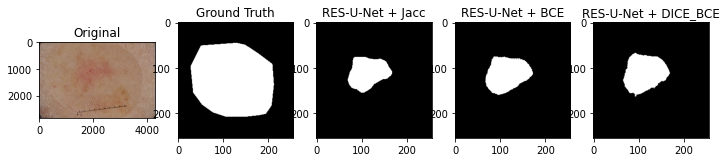

JS1: 0.3905, JS2:0.6665, JS3:0.3595


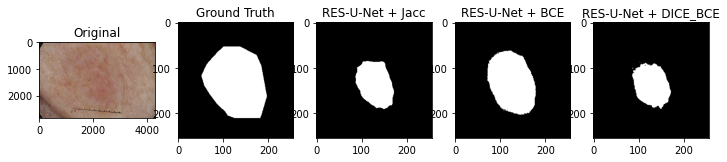

JS1: 0.5079, JS2:0.5667, JS3:0.4726


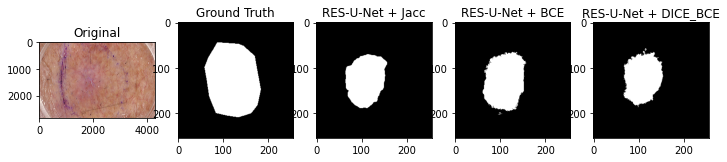

JS1: 0.3884, JS2:0.5849, JS3:0.7248


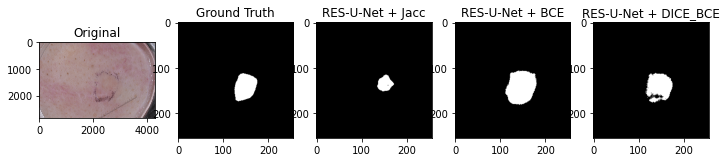

JS1: 0.1839, JS2:0.4187, JS3:0.5382


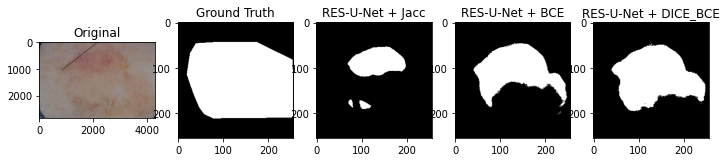

JS1: 0.7201, JS2:0.7857, JS3:0.7732


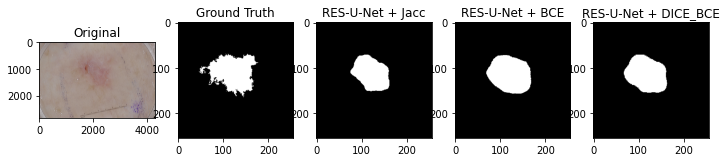

JS1: 0.9320, JS2:0.9531, JS3:0.9384


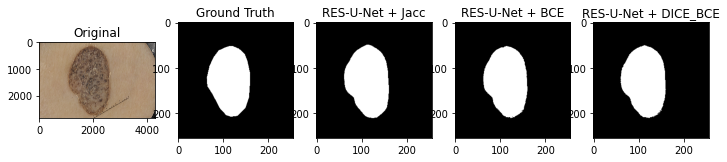

In [ ]:
df = pd.read_csv(test_csv_path)

samples = df.head(20)

for idx, row in samples.iterrows():

    img_id = '/' + row['image_id']

    img_path = test_img_folder + img_id + '.jpg'
    mask_path = test_seg_folder + img_id + '_segmentation.png'

    img = Image.open(img_path)
    mask = Image.open(mask_path).convert('1')

    image = img_transforms(img)
    mask = mask_transforms(mask)

    preds1 = predict(image, res_unet_jacc, th_res_unet_jacc)
    preds2 = predict(image, res_unet_bce, th_res_unet_bce)
    preds3 = predict(image, res_unet_bce_dice, th_res_unet_bce_dice)
    gt = mask.cpu().int().numpy()

   
    js1 = js(gt, preds1/255)
    js2 = js(gt, preds2/255)
    js3 = js(gt, preds3/255)


    print(f"JS1: {js1:.4f}, JS2:{js2:.4f}, JS3:{js3:.4f}")
    

    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(nrows=1, ncols = 5, figsize=(12, 5))

    ax1.imshow(np.array(img))
    ax1.set_title('Original')
         
    ax2.imshow(np.array(mask)[0, :, :], cmap='gray')
    ax2.set_title('Ground Truth')

    ax3.imshow(preds1, cmap='gray')
    ax3.set_title('RES-U-Net + Jacc')

    ax4.imshow(preds2, cmap='gray')
    ax4.set_title('RES-U-Net + BCE')

    
    ax5.imshow(preds3, cmap='gray')
    ax5.set_title('RES-U-Net + DICE_BCE')


    plt.subplots_adjust()
    plt.show()

## *Attention ResNet-Unet*


### *Train & Test*

#### With Jaccard Loss 

##### Train

In [ ]:
# Parameters 
CHECKPOINT_ATT_RESNET_UNET_JACC = '/content/drive/MyDrive/MRTYUTeam/checkpoints_original_ds/att_resnet_unet_jacc_new.pth' # save model to this file
WRITER_PATH = '/content/drive/MyDrive/MRTYUTeam/Tensorboard/Segmentation/Original Dataset' # save progress to this directory

In [ ]:
LEARNING_RATE = 1e-4 # Base learning rate
DEVICE = "cuda" if torch.cuda.is_available() else "cpu" # Device used
NUM_EPOCHS = 100 # Max number of epochs
LR_PATIENCE = 7 # change LR if no improvement after this much epochs 
ES_PATIENCE = 20  # If the validation dice does not improve for this much epochs stop training 
WEIGHT_DECAY = 1e-6 #weight decay parameter of ADAM optimizer

In [ ]:
att_resnet_unet = ResNetUNetAtt(n_class= 1).to(DEVICE)

In [ ]:
# Optimizer 
optimizer = optim.Adam(att_resnet_unet.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience= LR_PATIENCE, mode = "min", factor = 0.5, min_lr=1e-8)

# Gradient scaler 
grad_scaler = torch.cuda.amp.GradScaler()

# Loss function
criterion = JaccardLoss() 

In [ ]:
# Check initial Validation Dice score
val_score, loss = evaluate(att_resnet_unet, val_loader, criterion, DEVICE)

In [ ]:
logging.info( 'Resnet-Unet, Adam, Jaccard')
logging.info( 'Initial val : loss : %.4f, dice: %.4f' % (loss, val_score))

Resnet-Unet, Adam, Jaccard
Initial val : loss : 0.8888, dice: 0.1927


In [ ]:
train_net(att_resnet_unet, # the model to be trained
          DEVICE, # cuda or cpu
          train_loader,  # training dataloader
          val_loader, # validation data loader
          ES_PATIENCE, # stop training if val loss does not improve after this much steps
          optimizer, 
          grad_scaler,# gradient scaler
          scheduler, # learning rate scheduler
          criterion, # Objectve/loss function t be minimized
          WRITER_PATH , # folder to track metrics
          NUM_EPOCHS, # number of epochs
          save_checkpoint = True, # whether to save the final model asa file  or not 
          checkpoint_path= CHECKPOINT_ATT_RESNET_UNET_JACC, # where to save the model
          amp = True)

Epoch 1/100: 2000img [27:38,  1.21img/s, loss (batch) =0.123]

	Epoch 1 : training loss = 0.33957, training dice = 0.77576



Valid: 150img [00:49,  3.06img/s, dice =0.752, loss =0.397]

	Epoch 1 : validation loss = 0.41595, validation dice = 0.72959



Epoch 2/100: 2000img [07:45,  4.29img/s, loss (batch) =0.239]

	Epoch 2 : training loss = 0.21198, training dice = 0.87897



Valid: 150img [00:46,  3.22img/s, dice =0.872, loss =0.227]

	Epoch 2 : validation loss = 0.29692, validation dice = 0.82124



Epoch 3/100: 2000img [07:59,  4.17img/s, loss (batch) =0.249]

	Epoch 3 : training loss = 0.19443, training dice = 0.89024



Valid: 150img [00:50,  3.00img/s, dice =0.882, loss =0.211]

	Epoch 3 : validation loss = 0.26942, validation dice = 0.84071



Epoch 4/100: 2000img [08:26,  3.95img/s, loss (batch) =0.168]

	Epoch 4 : training loss = 0.17684, training dice = 0.90141



Valid: 150img [00:48,  3.12img/s, dice =0.828, loss =0.294]

	Epoch 4 : validation loss = 0.28055, validation dice = 0.83455



Epoch 5/100: 2000img [08:17,  4.02img/s, loss (batch) =0.156]

	Epoch 5 : training loss = 0.17746, training dice = 0.90126



Valid: 150img [00:48,  3.08img/s, dice =0.828, loss =0.293]

	Epoch 5 : validation loss = 0.29493, validation dice = 0.82427



Epoch 6/100: 2000img [08:16,  4.03img/s, loss (batch) =0.198]

	Epoch 6 : training loss = 0.16941, training dice = 0.90542



Valid: 150img [00:48,  3.10img/s, dice =0.865, loss =0.238]

	Epoch 6 : validation loss = 0.26804, validation dice = 0.84220



Epoch 7/100: 2000img [08:05,  4.12img/s, loss (batch) =0.225]

	Epoch 7 : training loss = 0.16171, training dice = 0.91069



Valid: 150img [00:49,  3.02img/s, dice =0.777, loss =0.365]

	Epoch 7 : validation loss = 0.33334, validation dice = 0.79701



Epoch 8/100: 2000img [08:40,  3.85img/s, loss (batch) =0.181]

	Epoch 8 : training loss = 0.15967, training dice = 0.91172



Valid: 150img [00:47,  3.13img/s, dice =0.805, loss =0.327]

	Epoch 8 : validation loss = 0.31034, validation dice = 0.81439



Epoch 9/100: 2000img [08:11,  4.07img/s, loss (batch) =0.118]

	Epoch 9 : training loss = 0.15438, training dice = 0.91506



Valid: 150img [00:50,  2.99img/s, dice =0.888, loss =0.202]

	Epoch 9 : validation loss = 0.25142, validation dice = 0.85429



Epoch 10/100: 2000img [08:16,  4.03img/s, loss (batch) =0.134]

	Epoch 10 : training loss = 0.14881, training dice = 0.91852



Valid: 150img [00:47,  3.14img/s, dice =0.81, loss =0.319]

	Epoch 10 : validation loss = 0.29876, validation dice = 0.82245



Epoch 11/100: 2000img [08:19,  4.00img/s, loss (batch) =0.185]

	Epoch 11 : training loss = 0.14581, training dice = 0.92046



Valid: 150img [00:48,  3.12img/s, dice =0.786, loss =0.352]

	Epoch 11 : validation loss = 0.29976, validation dice = 0.82139



Epoch 12/100: 2000img [08:27,  3.94img/s, loss (batch) =0.274]

	Epoch 12 : training loss = 0.14736, training dice = 0.91934



Valid: 150img [00:47,  3.15img/s, dice =0.833, loss =0.286]

	Epoch 12 : validation loss = 0.30328, validation dice = 0.81904



Epoch 13/100: 2000img [08:04,  4.13img/s, loss (batch) =0.15]

	Epoch 13 : training loss = 0.14562, training dice = 0.92056



Valid: 150img [00:46,  3.24img/s, dice =0.806, loss =0.325]

	Epoch 13 : validation loss = 0.29663, validation dice = 0.82264



Epoch 14/100: 2000img [08:16,  4.03img/s, loss (batch) =0.155]

	Epoch 14 : training loss = 0.15328, training dice = 0.91591



Valid: 150img [00:48,  3.12img/s, dice =0.9, loss =0.181]

	Epoch 14 : validation loss = 0.23140, validation dice = 0.86603



Epoch 15/100: 2000img [07:58,  4.18img/s, loss (batch) =0.138]

	Epoch 15 : training loss = 0.14337, training dice = 0.92204



Valid: 150img [00:47,  3.15img/s, dice =0.779, loss =0.362]

	Epoch 15 : validation loss = 0.29587, validation dice = 0.82398



Epoch 16/100: 2000img [08:04,  4.13img/s, loss (batch) =0.103]

	Epoch 16 : training loss = 0.14526, training dice = 0.92038



Valid: 150img [00:46,  3.19img/s, dice =0.785, loss =0.354]

	Epoch 16 : validation loss = 0.29560, validation dice = 0.82520



Epoch 17/100: 2000img [07:59,  4.17img/s, loss (batch) =0.132]

	Epoch 17 : training loss = 0.15011, training dice = 0.91766



Valid: 150img [00:47,  3.18img/s, dice =0.885, loss =0.206]

	Epoch 17 : validation loss = 0.24068, validation dice = 0.86086



Epoch 18/100: 2000img [07:59,  4.17img/s, loss (batch) =0.171]

	Epoch 18 : training loss = 0.14255, training dice = 0.92211



Valid: 150img [00:47,  3.16img/s, dice =0.882, loss =0.211]

	Epoch 18 : validation loss = 0.25200, validation dice = 0.85365



Epoch 19/100: 2000img [08:03,  4.14img/s, loss (batch) =0.0925]

	Epoch 19 : training loss = 0.14765, training dice = 0.91930



Valid: 150img [00:46,  3.23img/s, dice =0.81, loss =0.319]

	Epoch 19 : validation loss = 0.31423, validation dice = 0.81050



Epoch 20/100: 2000img [07:55,  4.21img/s, loss (batch) =0.0974]

	Epoch 20 : training loss = 0.14174, training dice = 0.92297



Valid: 150img [00:47,  3.16img/s, dice =0.84, loss =0.276]

	Epoch 20 : validation loss = 0.30576, validation dice = 0.81654



Epoch 21/100: 2000img [08:09,  4.09img/s, loss (batch) =0.112]

	Epoch 21 : training loss = 0.14206, training dice = 0.92267



Valid: 150img [00:47,  3.16img/s, dice =0.843, loss =0.271]

	Epoch 21 : validation loss = 0.27460, validation dice = 0.83885



Epoch 22/100: 2000img [07:57,  4.19img/s, loss (batch) =0.115]

	Epoch 22 : training loss = 0.13400, training dice = 0.92760



Valid: 150img [00:47,  3.14img/s, dice =0.884, loss =0.207]

	Epoch 22 : validation loss = 0.26054, validation dice = 0.84793



Epoch 23/100: 2000img [08:02,  4.15img/s, loss (batch) =0.127]

	Epoch 23 : training loss = 0.12750, training dice = 0.93120



Valid: 150img [00:46,  3.23img/s, dice =0.871, loss =0.229]

	Epoch 23 : validation loss = 0.25233, validation dice = 0.85439



Epoch 24/100: 2000img [08:03,  4.13img/s, loss (batch) =0.0922]

	Epoch 24 : training loss = 0.12169, training dice = 0.93465



Valid: 150img [00:45,  3.26img/s, dice =0.88, loss =0.214]

	Epoch 24 : validation loss = 0.24052, validation dice = 0.86257



Epoch 25/100: 2000img [08:06,  4.11img/s, loss (batch) =0.163]

	Epoch 25 : training loss = 0.12044, training dice = 0.93547



Valid: 150img [00:47,  3.17img/s, dice =0.878, loss =0.217]

	Epoch 25 : validation loss = 0.24845, validation dice = 0.85650



Epoch 26/100: 2000img [07:58,  4.18img/s, loss (batch) =0.113]

	Epoch 26 : training loss = 0.12094, training dice = 0.93511



Valid: 150img [00:47,  3.14img/s, dice =0.871, loss =0.229]

	Epoch 26 : validation loss = 0.24450, validation dice = 0.85926



Epoch 27/100: 2000img [08:11,  4.07img/s, loss (batch) =0.114]

	Epoch 27 : training loss = 0.11795, training dice = 0.93684



Valid: 150img [00:47,  3.14img/s, dice =0.886, loss =0.204]

	Epoch 27 : validation loss = 0.24049, validation dice = 0.86134



Epoch 28/100: 2000img [08:06,  4.11img/s, loss (batch) =0.065]

	Epoch 28 : training loss = 0.11851, training dice = 0.93658



Valid: 150img [00:48,  3.12img/s, dice =0.873, loss =0.226]

	Epoch 28 : validation loss = 0.24089, validation dice = 0.86161



Epoch 29/100: 2000img [07:53,  4.22img/s, loss (batch) =0.1]

	Epoch 29 : training loss = 0.11537, training dice = 0.93832



Valid: 150img [00:48,  3.10img/s, dice =0.912, loss =0.161]

	Epoch 29 : validation loss = 0.24115, validation dice = 0.86043



Epoch 30/100: 2000img [08:15,  4.04img/s, loss (batch) =0.113]

	Epoch 30 : training loss = 0.11637, training dice = 0.93780



Valid: 150img [00:47,  3.16img/s, dice =0.877, loss =0.219]

	Epoch 30 : validation loss = 0.24412, validation dice = 0.85927



Epoch 31/100: 2000img [08:07,  4.11img/s, loss (batch) =0.113]

	Epoch 31 : training loss = 0.11323, training dice = 0.93956



Valid: 150img [00:47,  3.19img/s, dice =0.885, loss =0.207]

	Epoch 31 : validation loss = 0.25120, validation dice = 0.85420



Epoch 32/100: 2000img [08:15,  4.04img/s, loss (batch) =0.0786]

	Epoch 32 : training loss = 0.10875, training dice = 0.94213



Valid: 150img [00:47,  3.16img/s, dice =0.895, loss =0.19]

	Epoch 32 : validation loss = 0.23724, validation dice = 0.86357



Epoch 33/100: 2000img [08:19,  4.00img/s, loss (batch) =0.104]

	Epoch 33 : training loss = 0.10838, training dice = 0.94233



Valid: 150img [00:48,  3.10img/s, dice =0.873, loss =0.225]

	Epoch 33 : validation loss = 0.24422, validation dice = 0.85849



Epoch 34/100: 2000img [08:10,  4.08img/s, loss (batch) =0.0879]

	Epoch 34 : training loss = 0.10997, training dice = 0.94144



Valid: 150img [00:48,  3.11img/s, dice =0.872, loss =0.227]

	Epoch 34 : validation loss = 0.24648, validation dice = 0.85693



Epoch 35/100: 2000img [08:08,  4.09img/s, loss (batch) =0.0892]

	Epoch 35 : training loss = 0.10590, training dice = 0.94372



Valid: 150img [00:47,  3.19img/s, dice =0.867, loss =0.235]

	Epoch 35 : validation loss = 0.25334, validation dice = 0.85244
EARLY STOPPING AFTER 35 EPOCHS
Best validation loss = 0.23140
Best validation dice = 0.86603


##### Optimize Threshold

In [ ]:
att_resnet_unet.load_state_dict(torch.load(CHECKPOINT_ATT_RESNET_UNET_JACC))

<All keys matched successfully>

In [ ]:
# dummy function for bayesian optimization
def calculate_jaccard(th):
    jaccard = check_js(val_loader, att_resnet_unet, th)
    return jaccard

In [ ]:
pbounds = {'th': (0.01, 0.99)} # Search interval
optimizer = BayesianOptimization(
    f=calculate_jaccard, # function to maximize
    pbounds=pbounds, # search interval
    verbose=2, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=7,
)

In [ ]:
optimizer.maximize(
    init_points=1, # perform 1 step of random exploration
    n_iter=10, # Perform 10 iterations
)

|   iter    |  target   |    th     |
-------------------------------------
|  1        |  0.7631   |  0.08478  |
|  2        |  0.7548   |  0.99     |
|  3        |  0.7631   |  0.08471  |
|  4        |  0.7619   |  0.4083   |
|  5        |  0.7625   |  0.2301   |
|  6        |  0.763    |  0.01     |
|  7        |  0.7632   |  0.04811  |
|  8        |  0.7611   |  0.617    |
|  9        |  0.7633   |  0.0388   |
|  10       |  0.7604   |  0.7595   |
|  11       |  0.7616   |  0.5068   |


##### Test

In [ ]:
dice, loss = evaluate(att_resnet_unet, test_loader, JaccardLoss(), DEVICE)
jacc = check_js_original_size(test_loader, att_resnet_unet, 0.0388, test_seg_folder)
print("Model: Att-Resnet-unet, Optimizer:ADAM, Loss: Jaccard")
print(f'Test Dice: {dice:.4f}')
print(f'Test Loss: {loss:.4f}')
print(f'Test Jaccard: {jacc:.4f}')

Model: Att-Resnet-unet, Optimizer:ADAM, Loss: Jaccard
Test Dice: 0.8306
Test Loss: 0.2825
Test Jaccard: 0.7688


In [ ]:
logging.info( 'Test : loss : %.4f, dice: %.4f, jaccard: %.4f' %
                (loss, dice, jacc))

Test : loss : 0.2825, dice: 0.8306, jaccard: 0.7663


#### With BCE Loss

##### Train

In [ ]:
# Parameters 
CHECKPOINT_ATT_RESNET_UNET_BCE = '/content/drive/MyDrive/MRTYUTeam/checkpoints_original_ds/att_resnet_unet_bce_new.pth' # save model to this file
WRITER_PATH = '/content/drive/MyDrive/MRTYUTeam/Tensorboard/Segmentation/Original Dataset' # save progress to this directory

In [ ]:
LEARNING_RATE = 1e-4 # Base learning rate
DEVICE = "cuda" if torch.cuda.is_available() else "cpu" # Device used
NUM_EPOCHS = 100 # Max number of epochs
LR_PATIENCE = 7 # change LR if no improvement after this much epochs 
ES_PATIENCE = 20  # If the validation dice does not improve for this much epochs stop training 
WEIGHT_DECAY = 1e-6 #weight decay parameter of ADAM optimizer

In [ ]:
att_resnet_unet = ResNetUNetAtt(n_class= 1).to(DEVICE)

In [ ]:
# Optimizer 
optimizer = optim.Adam(att_resnet_unet.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience= LR_PATIENCE, mode = "min", factor = 0.5, min_lr=1e-8)

# Gradient scaler 
grad_scaler = torch.cuda.amp.GradScaler()

# Loss function
criterion = nn.BCEWithLogitsLoss()

In [ ]:
# Check initial Validation Dice score
val_score, loss = evaluate(att_resnet_unet, val_loader, criterion, DEVICE)

logging.info( 'Resnet-Unet, Adam, BCE')
logging.info( 'Initial val : loss : %.4f, dice: %.4f' % (loss, val_score))

Valid: 150img [00:42,  3.52img/s, dice =0.367, loss =0.877]

Resnet-Unet, Adam, BCE
Initial val : loss : 0.8803, dice: 0.1836


In [ ]:
train_net(att_resnet_unet, # the model to be trained
          DEVICE, # cuda or cpu
          train_loader,  # training dataloader
          val_loader, # validation data loader
          ES_PATIENCE, # stop training if val loss does not improve after this much steps
          optimizer, 
          grad_scaler,# gradient scaler
          scheduler, # learning rate scheduler
          criterion, # Objectve/loss function t be minimized
          WRITER_PATH , # folder to track metrics
          NUM_EPOCHS, # number of epochs
          save_checkpoint = True, # whether to save the final model asa file  or not 
          checkpoint_path= CHECKPOINT_ATT_RESNET_UNET_BCE, # where to save the model
          amp = True)

Epoch 1/100: 2000img [17:47,  1.87img/s, loss (batch) =0.0824]

	Epoch 1 : training loss = 0.27449, training dice = 0.65370



Valid: 150img [00:41,  3.62img/s, dice =0.752, loss =0.275]

	Epoch 1 : validation loss = 0.14885, validation dice = 0.64385



Epoch 2/100: 2000img [07:09,  4.65img/s, loss (batch) =0.118]

	Epoch 2 : training loss = 0.08983, training dice = 0.81401



Valid: 150img [00:41,  3.61img/s, dice =0.849, loss =0.151]

	Epoch 2 : validation loss = 0.09062, validation dice = 0.76521



Epoch 3/100: 2000img [06:59,  4.77img/s, loss (batch) =0.0709]

	Epoch 3 : training loss = 0.07683, training dice = 0.83768



Valid: 150img [00:41,  3.62img/s, dice =0.799, loss =0.229]

	Epoch 3 : validation loss = 0.11348, validation dice = 0.74794



Epoch 4/100: 2000img [07:00,  4.76img/s, loss (batch) =0.13]

	Epoch 4 : training loss = 0.06765, training dice = 0.85438



Valid: 150img [00:42,  3.56img/s, dice =0.806, loss =0.234]

	Epoch 4 : validation loss = 0.10679, validation dice = 0.76839



Epoch 5/100: 2000img [07:09,  4.66img/s, loss (batch) =0.0348]

	Epoch 5 : training loss = 0.06023, training dice = 0.86976



Valid: 150img [00:41,  3.61img/s, dice =0.845, loss =0.196]

	Epoch 5 : validation loss = 0.10719, validation dice = 0.79297



Epoch 6/100: 2000img [06:59,  4.77img/s, loss (batch) =0.113]

	Epoch 6 : training loss = 0.06025, training dice = 0.87009



Valid: 150img [00:41,  3.59img/s, dice =0.805, loss =0.259]

	Epoch 6 : validation loss = 0.11850, validation dice = 0.78450



Epoch 7/100: 2000img [06:58,  4.78img/s, loss (batch) =0.0925]

	Epoch 7 : training loss = 0.05420, training dice = 0.88053



Valid: 150img [00:41,  3.63img/s, dice =0.868, loss =0.173]

	Epoch 7 : validation loss = 0.09486, validation dice = 0.79242



Epoch 8/100: 2000img [07:06,  4.69img/s, loss (batch) =0.0703]

	Epoch 8 : training loss = 0.05438, training dice = 0.88042



Valid: 150img [00:41,  3.62img/s, dice =0.838, loss =0.186]


	Epoch 8 : validation loss = 0.09824, validation dice = 0.79148


Epoch 9/100: 2000img [07:03,  4.73img/s, loss (batch) =0.0384]

	Epoch 9 : training loss = 0.05703, training dice = 0.87808



Valid: 150img [00:41,  3.62img/s, dice =0.817, loss =0.212]

	Epoch 9 : validation loss = 0.11276, validation dice = 0.78663



Epoch 10/100: 2000img [07:07,  4.68img/s, loss (batch) =0.0319]

	Epoch 10 : training loss = 0.05486, training dice = 0.88057



Valid: 150img [00:41,  3.61img/s, dice =0.795, loss =0.3]


	Epoch 10 : validation loss = 0.13613, validation dice = 0.76799


Epoch 11/100: 2000img [07:05,  4.70img/s, loss (batch) =0.0438]

	Epoch 11 : training loss = 0.04857, training dice = 0.89239



Valid: 150img [00:41,  3.63img/s, dice =0.849, loss =0.172]

	Epoch 11 : validation loss = 0.09700, validation dice = 0.80053



Epoch 12/100: 2000img [07:03,  4.73img/s, loss (batch) =0.0419]

	Epoch 12 : training loss = 0.04710, training dice = 0.89513



Valid: 150img [00:41,  3.63img/s, dice =0.856, loss =0.197]


	Epoch 12 : validation loss = 0.10824, validation dice = 0.81403


Epoch 13/100: 2000img [07:05,  4.70img/s, loss (batch) =0.0404]

	Epoch 13 : training loss = 0.04550, training dice = 0.89965



Valid: 150img [00:41,  3.62img/s, dice =0.869, loss =0.14]

	Epoch 13 : validation loss = 0.09557, validation dice = 0.80561



Epoch 14/100: 2000img [07:00,  4.76img/s, loss (batch) =0.0654]

	Epoch 14 : training loss = 0.04307, training dice = 0.90273



Valid: 150img [00:41,  3.61img/s, dice =0.838, loss =0.248]

	Epoch 14 : validation loss = 0.12417, validation dice = 0.81005



Epoch 15/100: 2000img [07:00,  4.76img/s, loss (batch) =0.0531]

	Epoch 15 : training loss = 0.04328, training dice = 0.90451



Valid: 150img [00:41,  3.61img/s, dice =0.875, loss =0.151]

	Epoch 15 : validation loss = 0.08873, validation dice = 0.82112



Epoch 16/100: 2000img [06:58,  4.77img/s, loss (batch) =0.0325]

	Epoch 16 : training loss = 0.04299, training dice = 0.90581



Valid: 150img [00:41,  3.61img/s, dice =0.868, loss =0.173]

	Epoch 16 : validation loss = 0.10034, validation dice = 0.81155



Epoch 17/100: 2000img [07:08,  4.66img/s, loss (batch) =0.0368]

	Epoch 17 : training loss = 0.04142, training dice = 0.90645



Valid: 150img [00:41,  3.61img/s, dice =0.831, loss =0.287]

	Epoch 17 : validation loss = 0.13461, validation dice = 0.80497



Epoch 18/100: 2000img [06:55,  4.81img/s, loss (batch) =0.0426]

	Epoch 18 : training loss = 0.04077, training dice = 0.90736



Valid: 150img [00:41,  3.61img/s, dice =0.864, loss =0.187]

	Epoch 18 : validation loss = 0.10539, validation dice = 0.81845



Epoch 19/100: 2000img [07:14,  4.61img/s, loss (batch) =0.0565]

	Epoch 19 : training loss = 0.04238, training dice = 0.90698



Valid: 150img [00:41,  3.61img/s, dice =0.829, loss =0.282]


	Epoch 19 : validation loss = 0.13819, validation dice = 0.80370


Epoch 20/100: 2000img [07:13,  4.61img/s, loss (batch) =0.0432]

	Epoch 20 : training loss = 0.03950, training dice = 0.91178



Valid: 150img [00:41,  3.60img/s, dice =0.859, loss =0.217]

	Epoch 20 : validation loss = 0.10687, validation dice = 0.82304



Epoch 21/100: 2000img [07:15,  4.60img/s, loss (batch) =0.0403]

	Epoch 21 : training loss = 0.03910, training dice = 0.91164



Valid: 150img [00:41,  3.58img/s, dice =0.862, loss =0.2]

	Epoch 21 : validation loss = 0.10756, validation dice = 0.82060



Epoch 22/100: 2000img [07:15,  4.60img/s, loss (batch) =0.0411]

	Epoch 22 : training loss = 0.03727, training dice = 0.91751



Valid: 150img [00:41,  3.59img/s, dice =0.856, loss =0.223]

	Epoch 22 : validation loss = 0.11964, validation dice = 0.81369



Epoch 23/100: 2000img [07:21,  4.53img/s, loss (batch) =0.067]

	Epoch 23 : training loss = 0.03734, training dice = 0.91642



Valid: 150img [00:42,  3.57img/s, dice =0.879, loss =0.168]

	Epoch 23 : validation loss = 0.10364, validation dice = 0.82331



Epoch 24/100: 2000img [07:17,  4.57img/s, loss (batch) =0.0464]

	Epoch 24 : training loss = 0.03485, training dice = 0.92044



Valid: 150img [00:41,  3.59img/s, dice =0.877, loss =0.199]

	Epoch 24 : validation loss = 0.11391, validation dice = 0.82525



Epoch 25/100: 2000img [07:03,  4.72img/s, loss (batch) =0.0262]

	Epoch 25 : training loss = 0.03443, training dice = 0.92205



Valid: 150img [00:41,  3.59img/s, dice =0.883, loss =0.186]


	Epoch 25 : validation loss = 0.11001, validation dice = 0.83161


Epoch 26/100: 2000img [07:19,  4.55img/s, loss (batch) =0.0519]

	Epoch 26 : training loss = 0.03368, training dice = 0.92461



Valid: 150img [00:41,  3.59img/s, dice =0.857, loss =0.245]

	Epoch 26 : validation loss = 0.13229, validation dice = 0.81574



Epoch 27/100: 2000img [07:06,  4.69img/s, loss (batch) =0.0253]

	Epoch 27 : training loss = 0.03285, training dice = 0.92559



Valid: 150img [00:42,  3.52img/s, dice =0.87, loss =0.219]

	Epoch 27 : validation loss = 0.12860, validation dice = 0.82093



Epoch 28/100: 2000img [07:07,  4.68img/s, loss (batch) =0.0194]

	Epoch 28 : training loss = 0.03269, training dice = 0.92614



Valid: 150img [00:41,  3.61img/s, dice =0.869, loss =0.225]

	Epoch 28 : validation loss = 0.12779, validation dice = 0.82571



Epoch 29/100: 2000img [07:11,  4.64img/s, loss (batch) =0.0128]

	Epoch 29 : training loss = 0.03241, training dice = 0.92690



Valid: 150img [00:41,  3.60img/s, dice =0.876, loss =0.2]

	Epoch 29 : validation loss = 0.11284, validation dice = 0.83151



Epoch 30/100: 2000img [07:06,  4.69img/s, loss (batch) =0.0261]

	Epoch 30 : training loss = 0.03159, training dice = 0.92776



Valid: 150img [00:41,  3.59img/s, dice =0.87, loss =0.222]

	Epoch 30 : validation loss = 0.12683, validation dice = 0.82279



Epoch 31/100: 2000img [07:07,  4.68img/s, loss (batch) =0.0732]

	Epoch 31 : training loss = 0.03081, training dice = 0.93066



Valid: 150img [00:41,  3.60img/s, dice =0.887, loss =0.192]


	Epoch 31 : validation loss = 0.10399, validation dice = 0.83797


Epoch 32/100: 2000img [07:06,  4.69img/s, loss (batch) =0.0219]

	Epoch 32 : training loss = 0.02966, training dice = 0.93310



Valid: 150img [00:41,  3.60img/s, dice =0.877, loss =0.222]

	Epoch 32 : validation loss = 0.12171, validation dice = 0.83075



Epoch 33/100: 2000img [07:17,  4.58img/s, loss (batch) =0.0372]

	Epoch 33 : training loss = 0.02988, training dice = 0.93256



Valid: 150img [00:42,  3.55img/s, dice =0.868, loss =0.242]

	Epoch 33 : validation loss = 0.13090, validation dice = 0.82504



Epoch 34/100: 2000img [07:10,  4.64img/s, loss (batch) =0.019]

	Epoch 34 : training loss = 0.02868, training dice = 0.93493



Valid: 150img [00:41,  3.59img/s, dice =0.878, loss =0.227]

	Epoch 34 : validation loss = 0.12845, validation dice = 0.82959



Epoch 35/100: 2000img [07:17,  4.57img/s, loss (batch) =0.0204]

	Epoch 35 : training loss = 0.02826, training dice = 0.93611



Valid: 150img [00:41,  3.60img/s, dice =0.88, loss =0.214]

	Epoch 35 : validation loss = 0.11936, validation dice = 0.83286



Epoch 36/100: 2000img [07:29,  4.45img/s, loss (batch) =0.0182]

	Epoch 36 : training loss = 0.02866, training dice = 0.93534



Valid: 150img [00:41,  3.60img/s, dice =0.884, loss =0.204]

	Epoch 36 : validation loss = 0.11883, validation dice = 0.83035
EARLY STOPPING AFTER 36 EPOCHS
Best validation loss = 0.08873
Best validation dice = 0.83797


##### Optimize Threshold

In [ ]:
att_resnet_unet.load_state_dict(torch.load(CHECKPOINT_ATT_RESNET_UNET_BCE))

<All keys matched successfully>

In [ ]:
# dummy function for bayesian optimization
def calculate_jaccard(th):
    jaccard = check_js(val_loader, att_resnet_unet, th)
    return jaccard

In [ ]:
pbounds = {'th': (0.01, 0.99)} # Search interval
optimizer = BayesianOptimization(
    f=calculate_jaccard, # function to maximize
    pbounds=pbounds, # search interval
    verbose=2, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=42,
)

In [ ]:
optimizer.maximize(
    init_points=1, # perform 1 steps of random exploration
    n_iter=10, # Perform 10 iterations
)

|   iter    |  target   |    th     |
-------------------------------------
|  1        |  0.7508   |  0.377    |
|  2        |  0.5539   |  0.99     |
|  3        |  0.7507   |  0.3806   |
|  4        |  0.6551   |  0.01     |
|  5        |  0.7508   |  0.3776   |
|  6        |  0.7333   |  0.6113   |
|  7        |  0.7497   |  0.2211   |
|  8        |  0.7426   |  0.5115   |
|  9        |  0.7521   |  0.2827   |
|  10       |  0.7521   |  0.3231   |
|  11       |  0.7513   |  0.2542   |


##### Test

In [ ]:
dice, loss = evaluate(att_resnet_unet, test_loader, nn.BCEWithLogitsLoss(), DEVICE)
jacc = check_js_original_size(test_loader, att_resnet_unet, 0.2827 , test_seg_folder)
print("Model: Attention ResNet U-net, Optimizer:ADAM, Loss: BCE")
print(f'Test Dice: {dice:.4f}')
print(f'Test Loss: {loss:.4f}')
print(f'Test Jaccard: {jacc:.4f}')

Model: Attention ResNet U-net, Optimizer:ADAM, Loss: BCE
Test Dice: 0.8184
Test Loss: 0.1852
Test Jaccard: 0.7785


#### With DiceBCE Loss 

##### Train

In [ ]:
# Parameters 
CHECKPOINT_ATT_RESNET_UNET_BCE_DICE = '/content/drive/MyDrive/MRTYUTeam/checkpoints_original_ds/att_resnet_unet_bce_dice_new.pth' # save model to this file
WRITER_PATH = '/content/drive/MyDrive/MRTYUTeam/Tensorboard/Segmentation/Original Dataset' # save progress to this directory

In [ ]:
LEARNING_RATE = 1e-4 # Base learning rate
DEVICE = "cuda" if torch.cuda.is_available() else "cpu" # Device used
NUM_EPOCHS = 100 # Max number of epochs
LR_PATIENCE = 7 # change LR if no improvement after this much epochs 
ES_PATIENCE = 20  # If the validation dice does not improve for this much epochs stop training 
WEIGHT_DECAY = 1e-6 #weight decay parameter of ADAM optimizer

In [ ]:
att_resnet_unet = ResNetUNetAtt(n_class= 1).to(DEVICE)

In [ ]:
# Optimizer 
optimizer = optim.Adam(att_resnet_unet.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience= LR_PATIENCE, mode = "min", factor = 0.5, min_lr=1e-8)

# Gradient scaler 
grad_scaler = torch.cuda.amp.GradScaler()

# Loss function
criterion = DiceBCELoss()

In [ ]:
# Check initial Validation Dice score
val_score, loss = evaluate(att_resnet_unet, val_loader, criterion, DEVICE)

In [ ]:
logging.info( 'Att-Resnet-Unet, Adam, BCE+DICE')
logging.info( 'Initial val : loss : %.4f, dice: %.4f' % (loss, val_score))

Att-Resnet-Unet, Adam, BCE+DICE
Initial val : loss : 1.3468, dice: 0.2291


In [ ]:
train_net(att_resnet_unet, # the model to be trained
          DEVICE, # cuda or cpu
          train_loader,  # training dataloader
          val_loader, # validation data loader
          ES_PATIENCE, # stop training if val loss does not improve after this much steps
          optimizer, 
          grad_scaler,# gradient scaler
          scheduler, # learning rate scheduler
          criterion, # Objectve/loss function t be minimized
          WRITER_PATH , # folder to track metrics
          NUM_EPOCHS, # number of epochs
          save_checkpoint = True, # whether to save the final model asa file  or not 
          checkpoint_path= CHECKPOINT_ATT_RESNET_UNET_BCE_DICE, # where to save the model
          amp = True)

Epoch 1/100: 2000img [07:08,  4.67img/s, loss (batch) =0.35]

	Epoch 1 : training loss = 0.37611, training dice = 0.79260



Valid: 150img [00:41,  3.61img/s, dice =0.784, loss =0.566]


	Epoch 1 : validation loss = 0.45149, validation dice = 0.72906


Epoch 2/100: 2000img [07:06,  4.69img/s, loss (batch) =0.351]

	Epoch 2 : training loss = 0.23422, training dice = 0.86132



Valid: 150img [00:41,  3.58img/s, dice =0.859, loss =0.359]

	Epoch 2 : validation loss = 0.29639, validation dice = 0.81136



Epoch 3/100: 2000img [07:15,  4.59img/s, loss (batch) =0.163]

	Epoch 3 : training loss = 0.19545, training dice = 0.88403



Valid: 150img [00:41,  3.59img/s, dice =0.777, loss =0.656]

	Epoch 3 : validation loss = 0.40766, validation dice = 0.76978



Epoch 4/100: 2000img [07:19,  4.55img/s, loss (batch) =0.114]

	Epoch 4 : training loss = 0.18550, training dice = 0.88946



Valid: 150img [00:41,  3.59img/s, dice =0.871, loss =0.334]

	Epoch 4 : validation loss = 0.28605, validation dice = 0.82262



Epoch 5/100: 2000img [07:11,  4.64img/s, loss (batch) =0.237]

	Epoch 5 : training loss = 0.18188, training dice = 0.89005



Valid: 150img [00:41,  3.60img/s, dice =0.871, loss =0.389]

	Epoch 5 : validation loss = 0.29551, validation dice = 0.82661



Epoch 6/100: 2000img [07:15,  4.59img/s, loss (batch) =0.0759]

	Epoch 6 : training loss = 0.16207, training dice = 0.90200



Valid: 150img [00:41,  3.61img/s, dice =0.828, loss =0.496]

	Epoch 6 : validation loss = 0.30234, validation dice = 0.82709



Epoch 7/100: 2000img [07:06,  4.69img/s, loss (batch) =0.217]

	Epoch 7 : training loss = 0.16437, training dice = 0.90164



Valid: 150img [00:42,  3.55img/s, dice =0.841, loss =0.453]

	Epoch 7 : validation loss = 0.29955, validation dice = 0.82493



Epoch 8/100: 2000img [07:11,  4.63img/s, loss (batch) =0.118]

	Epoch 8 : training loss = 0.15725, training dice = 0.90537



Valid: 150img [00:41,  3.61img/s, dice =0.875, loss =0.326]


	Epoch 8 : validation loss = 0.25996, validation dice = 0.84133


Epoch 9/100: 2000img [07:07,  4.68img/s, loss (batch) =0.145]

	Epoch 9 : training loss = 0.15868, training dice = 0.90418



Valid: 150img [00:41,  3.59img/s, dice =0.846, loss =0.459]

	Epoch 9 : validation loss = 0.28401, validation dice = 0.83793



Epoch 10/100: 2000img [07:09,  4.65img/s, loss (batch) =0.152]

	Epoch 10 : training loss = 0.14491, training dice = 0.91218



Valid: 150img [00:41,  3.60img/s, dice =0.858, loss =0.43]

	Epoch 10 : validation loss = 0.30374, validation dice = 0.82769



Epoch 11/100: 2000img [07:04,  4.71img/s, loss (batch) =0.102]

	Epoch 11 : training loss = 0.14857, training dice = 0.90975



Valid: 150img [00:41,  3.60img/s, dice =0.874, loss =0.338]

	Epoch 11 : validation loss = 0.28127, validation dice = 0.82817



Epoch 12/100: 2000img [07:06,  4.69img/s, loss (batch) =0.13]

	Epoch 12 : training loss = 0.14186, training dice = 0.91420



Valid: 150img [00:41,  3.60img/s, dice =0.854, loss =0.455]

	Epoch 12 : validation loss = 0.28635, validation dice = 0.83789



Epoch 13/100: 2000img [07:28,  4.46img/s, loss (batch) =0.121]

	Epoch 13 : training loss = 0.14211, training dice = 0.91425



Valid: 150img [00:42,  3.57img/s, dice =0.831, loss =0.552]

	Epoch 13 : validation loss = 0.32675, validation dice = 0.82369



Epoch 14/100: 2000img [07:24,  4.50img/s, loss (batch) =0.203]

	Epoch 14 : training loss = 0.14149, training dice = 0.91416



Valid: 150img [00:42,  3.53img/s, dice =0.844, loss =0.509]


	Epoch 14 : validation loss = 0.32068, validation dice = 0.82979


Epoch 15/100: 2000img [07:08,  4.67img/s, loss (batch) =0.109]

	Epoch 15 : training loss = 0.14235, training dice = 0.91458



Valid: 150img [00:41,  3.59img/s, dice =0.866, loss =0.393]

	Epoch 15 : validation loss = 0.29110, validation dice = 0.83384



Epoch 16/100: 2000img [07:14,  4.60img/s, loss (batch) =0.115]

	Epoch 16 : training loss = 0.13174, training dice = 0.92019



Valid: 150img [00:41,  3.61img/s, dice =0.856, loss =0.431]

	Epoch 16 : validation loss = 0.30786, validation dice = 0.82210



Epoch 17/100: 2000img [07:12,  4.62img/s, loss (batch) =0.0896]

	Epoch 17 : training loss = 0.12404, training dice = 0.92412



Valid: 150img [00:41,  3.59img/s, dice =0.872, loss =0.36]

	Epoch 17 : validation loss = 0.25221, validation dice = 0.85187



Epoch 18/100: 2000img [07:23,  4.51img/s, loss (batch) =0.101]

	Epoch 18 : training loss = 0.11884, training dice = 0.92762



Valid: 150img [00:41,  3.59img/s, dice =0.853, loss =0.448]


	Epoch 18 : validation loss = 0.29262, validation dice = 0.83593


Epoch 19/100: 2000img [07:29,  4.45img/s, loss (batch) =0.106]

	Epoch 19 : training loss = 0.11528, training dice = 0.92947



Valid: 150img [00:41,  3.59img/s, dice =0.845, loss =0.513]

	Epoch 19 : validation loss = 0.31028, validation dice = 0.83692



Epoch 20/100: 2000img [07:15,  4.59img/s, loss (batch) =0.11]

	Epoch 20 : training loss = 0.11315, training dice = 0.93076



Valid: 150img [00:41,  3.60img/s, dice =0.854, loss =0.425]

	Epoch 20 : validation loss = 0.26579, validation dice = 0.85108



Epoch 21/100: 2000img [07:23,  4.51img/s, loss (batch) =0.123]

	Epoch 21 : training loss = 0.11235, training dice = 0.93149



Valid: 150img [00:41,  3.59img/s, dice =0.842, loss =0.532]

	Epoch 21 : validation loss = 0.28951, validation dice = 0.84946



Epoch 22/100: 2000img [07:16,  4.58img/s, loss (batch) =0.0785]

	Epoch 22 : training loss = 0.10987, training dice = 0.93296



Valid: 150img [00:41,  3.59img/s, dice =0.874, loss =0.371]


	Epoch 22 : validation loss = 0.25677, validation dice = 0.85529


Epoch 23/100: 2000img [07:20,  4.54img/s, loss (batch) =0.22]

	Epoch 23 : training loss = 0.10891, training dice = 0.93359



Valid: 150img [00:41,  3.59img/s, dice =0.859, loss =0.461]

	Epoch 23 : validation loss = 0.29777, validation dice = 0.84350



Epoch 24/100: 2000img [07:12,  4.62img/s, loss (batch) =0.123]

	Epoch 24 : training loss = 0.10666, training dice = 0.93501



Valid: 150img [00:41,  3.59img/s, dice =0.872, loss =0.407]

	Epoch 24 : validation loss = 0.28653, validation dice = 0.84604



Epoch 25/100: 2000img [07:20,  4.54img/s, loss (batch) =0.0731]

	Epoch 25 : training loss = 0.10800, training dice = 0.93414



Valid: 150img [00:41,  3.59img/s, dice =0.863, loss =0.453]

	Epoch 25 : validation loss = 0.28662, validation dice = 0.84782



Epoch 26/100: 2000img [07:19,  4.55img/s, loss (batch) =0.0611]

	Epoch 26 : training loss = 0.10097, training dice = 0.93817



Valid: 150img [00:42,  3.55img/s, dice =0.864, loss =0.439]

	Epoch 26 : validation loss = 0.28655, validation dice = 0.84801



Epoch 27/100: 2000img [07:25,  4.49img/s, loss (batch) =0.109]

	Epoch 27 : training loss = 0.10041, training dice = 0.93844



Valid: 150img [00:41,  3.58img/s, dice =0.858, loss =0.476]

	Epoch 27 : validation loss = 0.29530, validation dice = 0.84827



Epoch 28/100: 2000img [07:25,  4.49img/s, loss (batch) =0.0679]

	Epoch 28 : training loss = 0.09855, training dice = 0.93994



Valid: 150img [00:41,  3.58img/s, dice =0.881, loss =0.386]

	Epoch 28 : validation loss = 0.27080, validation dice = 0.85410



Epoch 29/100: 2000img [07:10,  4.65img/s, loss (batch) =0.0689]

	Epoch 29 : training loss = 0.09423, training dice = 0.94261



Valid: 150img [00:41,  3.59img/s, dice =0.851, loss =0.545]

	Epoch 29 : validation loss = 0.32423, validation dice = 0.84133



Epoch 30/100: 2000img [07:17,  4.57img/s, loss (batch) =0.082]

	Epoch 30 : training loss = 0.09325, training dice = 0.94303



Valid: 150img [00:41,  3.59img/s, dice =0.853, loss =0.53]


	Epoch 30 : validation loss = 0.31700, validation dice = 0.84182


Epoch 31/100: 2000img [07:26,  4.48img/s, loss (batch) =0.0807]

	Epoch 31 : training loss = 0.09138, training dice = 0.94382



Valid: 150img [00:41,  3.58img/s, dice =0.862, loss =0.481]

	Epoch 31 : validation loss = 0.30701, validation dice = 0.84621



Epoch 32/100: 2000img [07:08,  4.66img/s, loss (batch) =0.159]

	Epoch 32 : training loss = 0.09174, training dice = 0.94397



Valid: 150img [00:41,  3.61img/s, dice =0.865, loss =0.472]

	Epoch 32 : validation loss = 0.30255, validation dice = 0.84700



Epoch 33/100: 2000img [07:11,  4.64img/s, loss (batch) =0.08]

	Epoch 33 : training loss = 0.08894, training dice = 0.94571



Valid: 150img [00:41,  3.61img/s, dice =0.873, loss =0.431]

	Epoch 33 : validation loss = 0.29381, validation dice = 0.84847



Epoch 34/100: 2000img [07:17,  4.57img/s, loss (batch) =0.0993]

	Epoch 34 : training loss = 0.08738, training dice = 0.94645



Valid: 150img [00:42,  3.57img/s, dice =0.878, loss =0.436]

	Epoch 34 : validation loss = 0.29899, validation dice = 0.84805



Epoch 35/100: 2000img [07:08,  4.67img/s, loss (batch) =0.0811]

	Epoch 35 : training loss = 0.08508, training dice = 0.94765



Valid: 150img [00:41,  3.58img/s, dice =0.879, loss =0.432]

	Epoch 35 : validation loss = 0.29658, validation dice = 0.85035



Epoch 36/100: 2000img [07:21,  4.53img/s, loss (batch) =0.0822]

	Epoch 36 : training loss = 0.08350, training dice = 0.94895



Valid: 150img [00:42,  3.56img/s, dice =0.866, loss =0.46]

	Epoch 36 : validation loss = 0.30399, validation dice = 0.84549



Epoch 37/100: 2000img [07:03,  4.73img/s, loss (batch) =0.0753]

	Epoch 37 : training loss = 0.08424, training dice = 0.94836



Valid: 150img [00:41,  3.57img/s, dice =0.879, loss =0.422]

	Epoch 37 : validation loss = 0.30436, validation dice = 0.84483



Epoch 38/100: 2000img [07:12,  4.62img/s, loss (batch) =0.0773]

	Epoch 38 : training loss = 0.08230, training dice = 0.94966



Valid: 150img [00:41,  3.59img/s, dice =0.872, loss =0.445]


	Epoch 38 : validation loss = 0.30011, validation dice = 0.84763
EARLY STOPPING AFTER 38 EPOCHS
Best validation loss = 0.25221
Best validation dice = 0.85529




##### Optimize Threshold

In [ ]:
att_resnet_unet.load_state_dict(torch.load(CHECKPOINT_ATT_RESNET_UNET_BCE_DICE))

<All keys matched successfully>

In [ ]:
# dummy function for bayesian optimization
def calculate_jaccard(th):
    jaccard = check_js(val_loader, att_resnet_unet, th)
    return jaccard

In [ ]:
pbounds = {'th': (0.01, 0.99)} # Search interval
optimizer = BayesianOptimization(
    f=calculate_jaccard, # function to maximize
    pbounds=pbounds, # search interval
    verbose=2, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=42,
)

In [ ]:
optimizer.maximize(
    init_points=1, # perform 3 steps of random exploration
    n_iter=10, # Perform 10 iterations
)

|   iter    |  target   |    th     |
-------------------------------------
|  1        |  0.7676   |  0.377    |
|  2        |  0.5872   |  0.99     |
|  3        |  0.7675   |  0.3806   |
|  4        |  0.6826   |  0.01     |
|  5        |  0.7676   |  0.3776   |
|  6        |  0.7583   |  0.6091   |
|  7        |  0.7711   |  0.2172   |
|  8        |  0.7628   |  0.515    |
|  9        |  0.77     |  0.2751   |
|  10       |  0.7712   |  0.1759   |
|  11       |  0.751    |  0.7125   |


##### Test

In [ ]:
dice, loss = evaluate(att_resnet_unet, test_loader, DiceBCELoss(), DEVICE)
jacc = check_js_original_size(test_loader, att_resnet_unet, 0.1759, test_seg_folder)
print("Model: Att Resnet U-Net, Optimizer:ADAM, Loss: BCE + Dice")
print(f'Test Dice: {dice:.4f}')
print(f'Test Loss: {loss:.4f}')
print(f'Test Jaccard: {jacc:.4f}')

Model: Att Resnet U-Net, Optimizer:ADAM, Loss: BCE + Dice
Test Dice: 0.8217
Test Loss: 0.3730
Test Jaccard: 0.7756


In [ ]:
logging.info( 'Test : loss : %.4f, dice: %.4f, jaccard: %.4f' %
                (loss, dice, jacc))

Test : loss : 0.3730, dice: 0.8217, jaccard: 0.7756


### *Show samples*

In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu" # Device used

In [ ]:
CHECKPOINT_ATT_RES_UNET_JACC = '/content/drive/MyDrive/MRTYUTeam/checkpoints_original_ds/att_resnet_unet_jacc_new.pth'
CHECKPOINT_ATT_RES_UNET_BCE = '/content/drive/MyDrive/MRTYUTeam/checkpoints_original_ds/att_resnet_unet_bce_new.pth'
CHECKPOINT_ATT_RES_UNET_DiceBCE = '/content/drive/MyDrive/MRTYUTeam/checkpoints_original_ds/att_resnet_unet_bce_dice_new.pth'

In [ ]:
att_res_unet_jacc = ResNetUNetAtt(n_class= 1).to(DEVICE)
att_res_unet_jacc.load_state_dict(torch.load(CHECKPOINT_ATT_RES_UNET_JACC))
att_res_unet_jacc.eval()

th_att_res_unet_jacc = 0.0388

In [ ]:
att_res_unet_bce = ResNetUNetAtt(n_class= 1).to(DEVICE)
att_res_unet_bce.load_state_dict(torch.load(CHECKPOINT_ATT_RES_UNET_BCE))
att_res_unet_bce.eval()

th_att_res_unet_bce = 0.2827

In [ ]:
att_res_unet_bce_dice = ResNetUNetAtt(n_class= 1).to(DEVICE)
att_res_unet_bce_dice.load_state_dict(torch.load(CHECKPOINT_ATT_RES_UNET_DiceBCE))
att_res_unet_bce_dice.eval()

th_att_res_unet_bce_dice =   0.1759

JS1: 0.8245, JS2:0.7059, JS3:0.8582


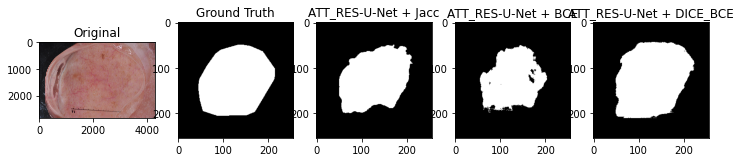

JS1: 0.8377, JS2:0.8474, JS3:0.8407


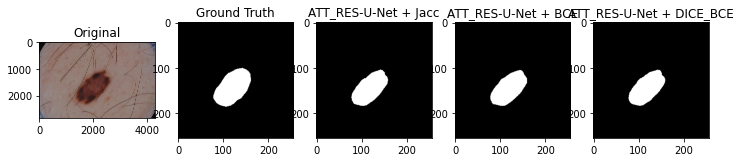

JS1: 0.7404, JS2:0.8695, JS3:0.7855


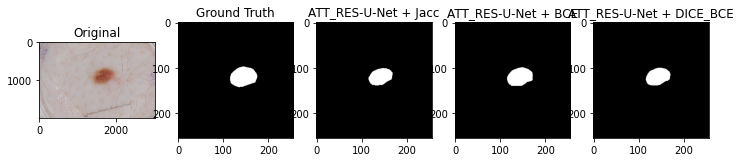

JS1: 0.6712, JS2:0.6843, JS3:0.6705


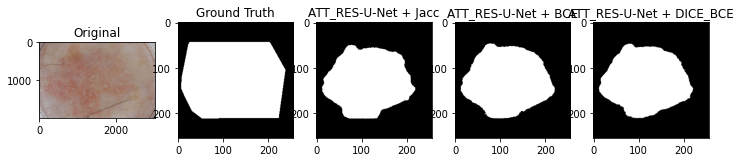

JS1: 0.2330, JS2:0.5408, JS3:0.4316


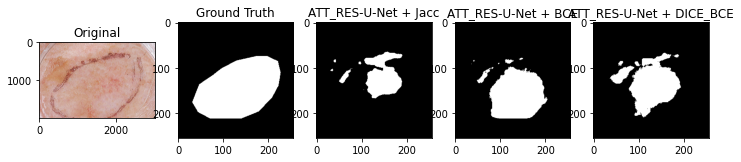

JS1: 0.0996, JS2:0.7569, JS3:0.7554


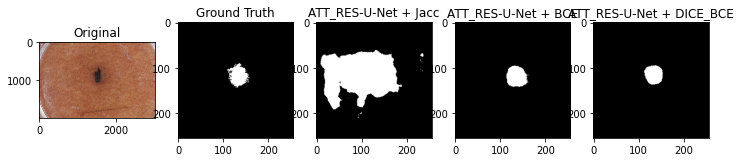

JS1: 0.1816, JS2:0.7087, JS3:0.8434


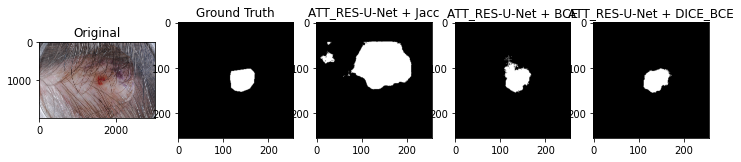

JS1: 0.8968, JS2:0.9190, JS3:0.8841


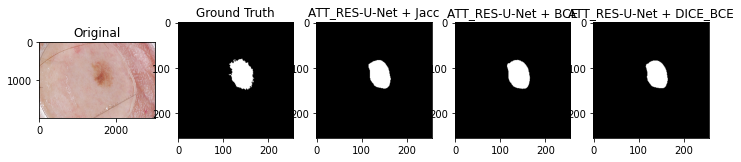

JS1: 0.6592, JS2:0.7054, JS3:0.6805


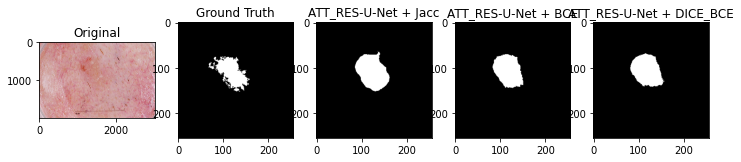

JS1: 0.8264, JS2:0.8306, JS3:0.7930


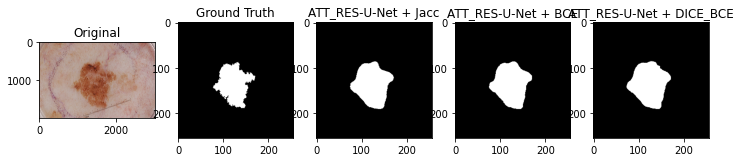

JS1: 0.1547, JS2:0.3482, JS3:0.8255


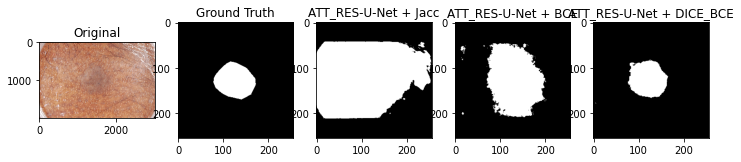

JS1: 0.4925, JS2:0.7967, JS3:0.6569


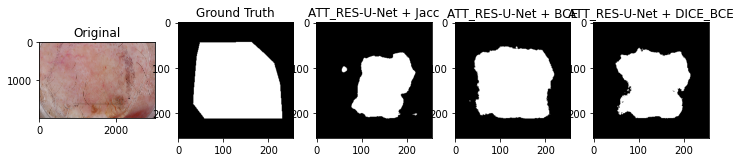

JS1: 0.7718, JS2:0.8382, JS3:0.7931


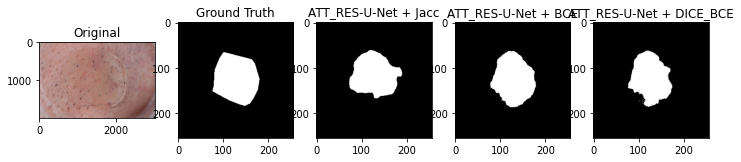

JS1: 0.2908, JS2:0.2316, JS3:0.2434


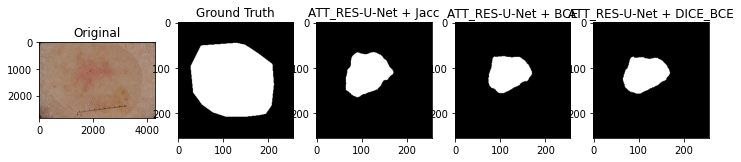

JS1: 0.5894, JS2:0.5182, JS3:0.4493


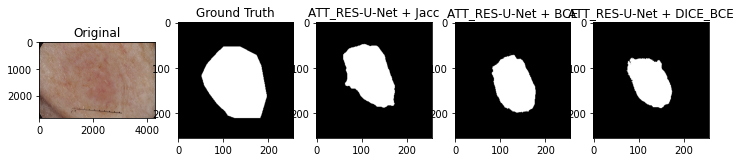

JS1: 0.7381, JS2:0.7199, JS3:0.6816


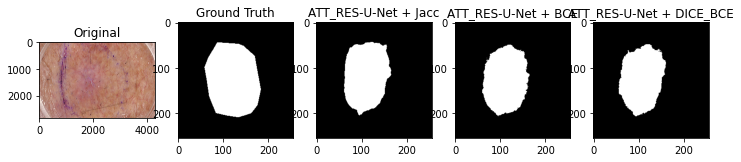

JS1: 0.6020, JS2:0.5006, JS3:0.4118


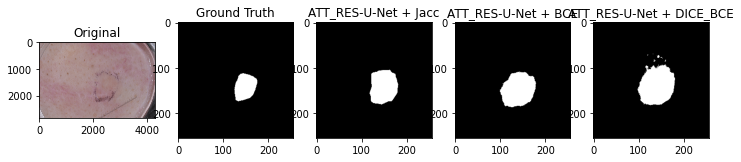

JS1: 0.4396, JS2:0.6208, JS3:0.4031


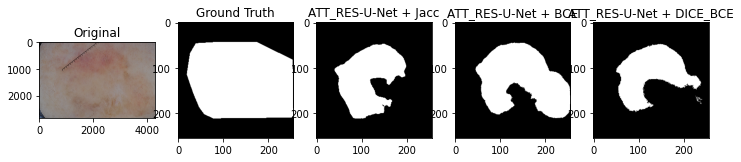

JS1: 0.7520, JS2:0.7819, JS3:0.8139


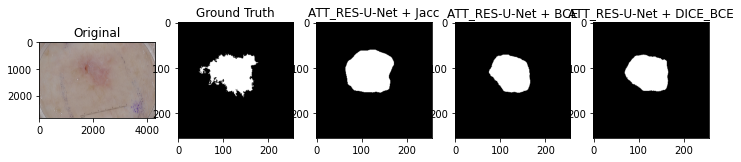

JS1: 0.9430, JS2:0.9177, JS3:0.9537


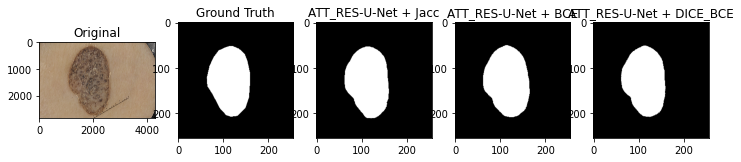

In [ ]:
df = pd.read_csv(test_csv_path)

samples = df.head(20)

for idx, row in samples.iterrows():

    img_id = '/' + row['image_id']

    img_path = test_img_folder + img_id + '.jpg'
    mask_path = test_seg_folder + img_id + '_segmentation.png'

    img = Image.open(img_path)
    mask = Image.open(mask_path).convert('1')

    image = img_transforms(img)
    mask = mask_transforms(mask)

    preds1 = predict(image, att_res_unet_jacc, th_att_res_unet_jacc)
    preds2 = predict(image, att_res_unet_bce, th_att_res_unet_bce)
    preds3 = predict(image, att_res_unet_bce_dice, th_att_res_unet_bce_dice)
    gt = mask.cpu().int().numpy()

   
    js1 = js(gt, preds1/255)
    js2 = js(gt, preds2/255)
    js3 = js(gt, preds3/255)


    print(f"JS1: {js1:.4f}, JS2:{js2:.4f}, JS3:{js3:.4f}")
    

    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(nrows=1, ncols = 5, figsize=(12, 5))

    ax1.imshow(np.array(img))
    ax1.set_title('Original')
         
    ax2.imshow(np.array(mask)[0, :, :], cmap='gray')
    ax2.set_title('Ground Truth')

    ax3.imshow(preds1, cmap='gray')
    ax3.set_title('ATT_RES-U-Net + Jacc')

    ax4.imshow(preds2, cmap='gray')
    ax4.set_title('ATT_RES-U-Net + BCE')

    
    ax5.imshow(preds3, cmap='gray')
    ax5.set_title('ATT_RES-U-Net + DICE_BCE')


    plt.subplots_adjust()
    plt.show()

# Ablation Study 

### Data Augmentation

Here we will train the model without data augmentation to study its contribution to the final result

#### Data

In [ ]:
isic_train_no_aug = ISIC2017Dataset(csv_file=train_csv_path,
                             image_folder= train_img_folder,
                             segmentation_folder= train_seg_folder, 
                             img_transform = img_transforms,
                             mask_transform = mask_transforms,
                             augment = False) # do not apply augmentation

train_loader_no_aug = DataLoader(isic_train_no_aug, batch_size=TRAIN_BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)

#### Train

In [ ]:
LEARNING_RATE = 1e-4 # Base learning rate
DEVICE = "cuda" if torch.cuda.is_available() else "cpu" # Device used
NUM_EPOCHS = 100 # Max number of epochs
LR_PATIENCE = 7 # change LR if no improvement after this much epochs 
ES_PATIENCE = 20  # If the validation dice does not improve for this much epochs stop training 
WEIGHT_DECAY = 1e-6 #weight decay parameter of ADAM optimizer

In [ ]:
resnet_unet = ResNetUNet(n_class= 1).to(DEVICE)

# Optimizer 
optimizer = optim.Adam(resnet_unet.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience= LR_PATIENCE, mode = "min", factor = 0.5, min_lr=1e-8)

# Gradient scaler 
grad_scaler = torch.cuda.amp.GradScaler()

# Loss function
criterion = nn.BCEWithLogitsLoss()


In [ ]:
train_net(resnet_unet, # the model to be trained
          DEVICE, # cuda or cpu
          train_loader_no_aug,  # training dataloader
          val_loader, # validation data loader
          ES_PATIENCE, # stop training if val loss does not improve after this much steps
          optimizer, 
          grad_scaler,# gradient scaler
          scheduler, # learning rate scheduler
          criterion, # Objectve/loss function t be minimized
         '/content/drive/MyDrive/Tensorboard_segmentation/', # folder to track metrics
          NUM_EPOCHS, # number of epochs
          save_checkpoint = True, # whether to save the final model asa file  or not 
          checkpoint_path= '/content/drive/MyDrive/checkpoints_original_ds/resnet_unet_no_aug.pth', # where to save the model
          amp = True)

Epoch 1/100: 100%|██████████| 250/250 [33:00<00:00,  7.92s/it, loss (batch) =0.118]

	Epoch 1 : training loss = 0.20570, training dice = 0.72579



Valid: 150img [00:36,  4.08img/s, dice =0.824, loss =0.127]

	Epoch 1 : validation loss = 0.11484, validation dice = 0.73452



Epoch 2/100: 100%|██████████| 250/250 [04:29<00:00,  1.08s/it, loss (batch) =0.204]

	Epoch 2 : training loss = 0.08445, training dice = 0.83574



Valid: 150img [00:36,  4.09img/s, dice =0.816, loss =0.154]

	Epoch 2 : validation loss = 0.12017, validation dice = 0.74864



Epoch 3/100: 100%|██████████| 250/250 [04:25<00:00,  1.06s/it, loss (batch) =0.0498]


	Epoch 3 : training loss = 0.06020, training dice = 0.87273


Valid: 150img [00:36,  4.16img/s, dice =0.809, loss =0.169]

	Epoch 3 : validation loss = 0.14980, validation dice = 0.72863



Epoch 4/100: 100%|██████████| 250/250 [04:31<00:00,  1.09s/it, loss (batch) =0.0323]

	Epoch 4 : training loss = 0.05293, training dice = 0.88794



Valid: 150img [00:35,  4.19img/s, dice =0.825, loss =0.164]

	Epoch 4 : validation loss = 0.10755, validation dice = 0.79117



Epoch 5/100: 100%|██████████| 250/250 [04:23<00:00,  1.05s/it, loss (batch) =0.0463]

	Epoch 5 : training loss = 0.04347, training dice = 0.90564



Valid: 150img [00:35,  4.17img/s, dice =0.847, loss =0.15]

	Epoch 5 : validation loss = 0.11500, validation dice = 0.80402



Epoch 6/100: 100%|██████████| 250/250 [04:25<00:00,  1.06s/it, loss (batch) =0.0349]

	Epoch 6 : training loss = 0.03917, training dice = 0.91495



Valid: 150img [00:35,  4.19img/s, dice =0.837, loss =0.167]

	Epoch 6 : validation loss = 0.11718, validation dice = 0.80196



Epoch 7/100: 100%|██████████| 250/250 [04:20<00:00,  1.04s/it, loss (batch) =0.0721]

	Epoch 7 : training loss = 0.03494, training dice = 0.92348



Valid: 150img [00:35,  4.17img/s, dice =0.861, loss =0.15]

	Epoch 7 : validation loss = 0.12913, validation dice = 0.81375



Epoch 8/100: 100%|██████████| 250/250 [04:26<00:00,  1.07s/it, loss (batch) =0.0316]

	Epoch 8 : training loss = 0.04247, training dice = 0.90787



Valid: 150img [00:35,  4.19img/s, dice =0.84, loss =0.175]

	Epoch 8 : validation loss = 0.12353, validation dice = 0.81032



Epoch 9/100: 100%|██████████| 250/250 [04:31<00:00,  1.09s/it, loss (batch) =0.028]

	Epoch 9 : training loss = 0.03918, training dice = 0.91804



Valid: 150img [00:35,  4.20img/s, dice =0.832, loss =0.171]

	Epoch 9 : validation loss = 0.13041, validation dice = 0.78085



Epoch 10/100: 100%|██████████| 250/250 [04:24<00:00,  1.06s/it, loss (batch) =0.033]

	Epoch 10 : training loss = 0.03325, training dice = 0.92611



Valid: 150img [00:35,  4.17img/s, dice =0.85, loss =0.164]

	Epoch 10 : validation loss = 0.14356, validation dice = 0.80181



Epoch 11/100: 100%|██████████| 250/250 [04:21<00:00,  1.05s/it, loss (batch) =0.0344]

	Epoch 11 : training loss = 0.02923, training dice = 0.93465



Valid: 150img [00:35,  4.18img/s, dice =0.858, loss =0.167]

	Epoch 11 : validation loss = 0.12377, validation dice = 0.81920



Epoch 12/100: 100%|██████████| 250/250 [04:26<00:00,  1.07s/it, loss (batch) =0.0179]

	Epoch 12 : training loss = 0.02536, training dice = 0.94271



Valid: 150img [00:36,  4.08img/s, dice =0.858, loss =0.174]

	Epoch 12 : validation loss = 0.13063, validation dice = 0.82010



Epoch 13/100: 100%|██████████| 250/250 [04:22<00:00,  1.05s/it, loss (batch) =0.0182]

	Epoch 13 : training loss = 0.02213, training dice = 0.94931



Valid: 150img [00:36,  4.15img/s, dice =0.868, loss =0.167]

	Epoch 13 : validation loss = 0.14127, validation dice = 0.82073



Epoch 14/100: 100%|██████████| 250/250 [04:24<00:00,  1.06s/it, loss (batch) =0.0188]

	Epoch 14 : training loss = 0.01910, training dice = 0.95617



Valid: 150img [00:36,  4.14img/s, dice =0.848, loss =0.223]

	Epoch 14 : validation loss = 0.16493, validation dice = 0.81123



Epoch 15/100: 100%|██████████| 250/250 [04:23<00:00,  1.06s/it, loss (batch) =0.0195]

	Epoch 15 : training loss = 0.01784, training dice = 0.95978



Valid: 150img [00:35,  4.18img/s, dice =0.859, loss =0.215]

	Epoch 15 : validation loss = 0.15130, validation dice = 0.82987



Epoch 16/100: 100%|██████████| 250/250 [04:17<00:00,  1.03s/it, loss (batch) =0.0224]

	Epoch 16 : training loss = 0.01734, training dice = 0.96078



Valid: 150img [00:35,  4.18img/s, dice =0.855, loss =0.232]

	Epoch 16 : validation loss = 0.17896, validation dice = 0.80826



Epoch 17/100: 100%|██████████| 250/250 [04:24<00:00,  1.06s/it, loss (batch) =0.00936]

	Epoch 17 : training loss = 0.01687, training dice = 0.96188



Valid: 150img [00:36,  4.16img/s, dice =0.866, loss =0.201]

	Epoch 17 : validation loss = 0.15606, validation dice = 0.83306



Epoch 18/100: 100%|██████████| 250/250 [04:26<00:00,  1.07s/it, loss (batch) =0.00905]

	Epoch 18 : training loss = 0.01627, training dice = 0.96342



Valid: 150img [00:36,  4.15img/s, dice =0.861, loss =0.22]

	Epoch 18 : validation loss = 0.17040, validation dice = 0.82036



Epoch 19/100: 100%|██████████| 250/250 [04:29<00:00,  1.08s/it, loss (batch) =0.0192]


	Epoch 19 : training loss = 0.01592, training dice = 0.96416


Valid: 150img [00:36,  4.13img/s, dice =0.867, loss =0.219]

	Epoch 19 : validation loss = 0.17293, validation dice = 0.83135



Epoch 20/100: 100%|██████████| 250/250 [04:27<00:00,  1.07s/it, loss (batch) =0.0191]

	Epoch 20 : training loss = 0.01620, training dice = 0.96271



Valid: 150img [00:36,  4.16img/s, dice =0.865, loss =0.207]

	Epoch 20 : validation loss = 0.15868, validation dice = 0.82070



Epoch 21/100: 100%|██████████| 250/250 [04:26<00:00,  1.06s/it, loss (batch) =0.0156]

	Epoch 21 : training loss = 0.01485, training dice = 0.96600



Valid: 150img [00:36,  4.15img/s, dice =0.867, loss =0.224]

	Epoch 21 : validation loss = 0.16313, validation dice = 0.82937



Epoch 22/100: 100%|██████████| 250/250 [04:25<00:00,  1.06s/it, loss (batch) =0.0163]

	Epoch 22 : training loss = 0.01311, training dice = 0.96962



Valid: 150img [00:36,  4.15img/s, dice =0.863, loss =0.264]

	Epoch 22 : validation loss = 0.19826, validation dice = 0.81889



Epoch 23/100: 100%|██████████| 250/250 [04:28<00:00,  1.08s/it, loss (batch) =0.0122]

	Epoch 23 : training loss = 0.01231, training dice = 0.97184



Valid: 150img [00:36,  4.13img/s, dice =0.871, loss =0.234]

	Epoch 23 : validation loss = 0.18731, validation dice = 0.82245



Epoch 24/100: 100%|██████████| 250/250 [04:26<00:00,  1.07s/it, loss (batch) =0.0104]

	Epoch 24 : training loss = 0.01191, training dice = 0.97288



Valid: 150img [00:36,  4.15img/s, dice =0.874, loss =0.223]

	Epoch 24 : validation loss = 0.18402, validation dice = 0.82727



Epoch 25/100: 100%|██████████| 250/250 [04:34<00:00,  1.10s/it, loss (batch) =0.0166]

	Epoch 25 : training loss = 0.01166, training dice = 0.97345



Valid: 150img [00:36,  4.16img/s, dice =0.868, loss =0.257]

	Epoch 25 : validation loss = 0.19994, validation dice = 0.82298
EARLY STOPPING AFTER 25 EPOCHS
Best validation loss = 0.10755
Best validation dice = 0.83306


In [ ]:
resnet_unet.load_state_dict(torch.load( '/content/drive/MyDrive/MRTYUTeam/checkpoints_original_ds/resnet_unet_no_aug.pth'))

#Intermediate function that only takes the threshold as parameter and returns the jaccard score
def jaccard(th):
  return check_js(val_loader, resnet_unet, th)



pbounds = {'th': (0.01, 0.99)} # Search interval
optimizer = BayesianOptimization(
    f=jaccard, # function to maximize
    pbounds=pbounds, # search interval
    verbose=2, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=42,
)

optimizer.maximize(
    init_points=1, # perform 2 steps of random exploration
    n_iter=10, # Perform 10 iterations
)

|   iter    |  target   |    th     |
-------------------------------------
|  1        |  0.7413   |  0.377    |
|  2        |  0.5796   |  0.99     |
|  3        |  0.741    |  0.3806   |
|  4        |  0.7259   |  0.01     |
|  5        |  0.7498   |  0.1863   |
|  6        |  0.7479   |  0.2496   |
|  7        |  0.7498   |  0.187    |
|  8        |  0.7505   |  0.1403   |
|  9        |  0.7271   |  0.5683   |
|  10       |  0.7504   |  0.1574   |
|  11       |  0.7503   |  0.1189   |


In [ ]:
# retrieve the threshold that gave the best result on the validation set 
th_resnet_unet = optimizer.max['params']['th']
print(f"The optimal threshold is {th_resnet_unet:.4f}")

The optimal threshold is 0.1403


#### Test

In [ ]:
jacc = check_js_original_size(test_loader, resnet_unet, th_resnet_unet , test_seg_folder)
print(f'Test Jaccard (original size): {jacc:.4f}')

Test Jaccard (original size): 0.7689


### Transfer Learning

Here we will train the model without loading the ImageNet pretrained weights of the model to study the contribution of Transfer Learning to the final result

#### Train

In [ ]:
LEARNING_RATE = 1e-4 # Base learning rate
DEVICE = "cuda" if torch.cuda.is_available() else "cpu" # Device used
NUM_EPOCHS = 100 # Max number of epochs
LR_PATIENCE = 7 # change LR if no improvement after this much epochs 
ES_PATIENCE = 20  # If the validation dice does not improve for this much epochs stop training 
WEIGHT_DECAY = 1e-6 #weight decay parameter of ADAM optimizer

In [ ]:
resnet_unet = ResNetUNet(n_class= 1, pretrained = False).to(DEVICE) # Do not load pretrained ImageNet weights

# Optimizer 
optimizer = optim.Adam(resnet_unet.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience= LR_PATIENCE, mode = "min", factor = 0.5, min_lr=1e-8)

# Gradient scaler 
grad_scaler = torch.cuda.amp.GradScaler()

# Loss function
criterion = nn.BCEWithLogitsLoss()


In [ ]:
train_net(resnet_unet, # the model to be trained
          DEVICE, # cuda or cpu
          train_loader,  # training dataloader
          val_loader, # validation data loader
          ES_PATIENCE, # stop training if val loss does not improve after this much steps
          optimizer, 
          grad_scaler,# gradient scaler
          scheduler, # learning rate scheduler
          criterion, # Objectve/loss function t be minimized
         '/content/drive/MyDrive/Tensorboard_segmentation/', # folder to track metrics
          NUM_EPOCHS, # number of epochs
          save_checkpoint = True, # whether to save the final model asa file  or not 
          checkpoint_path= '/content/drive/MyDrive/checkpoints_original_ds/resnet_unet_no_tl.pth', # where to save the model
          amp = True)

Epoch 1/100: 100%|██████████| 250/250 [07:22<00:00,  1.77s/it, loss (batch) =0.085]

	Epoch 1 : training loss = 0.21399, training dice = 0.63599



Valid: 150img [00:36,  4.14img/s, dice =0.77, loss =0.137]

	Epoch 1 : validation loss = 0.16750, validation dice = 0.59184



Epoch 2/100: 100%|██████████| 250/250 [07:12<00:00,  1.73s/it, loss (batch) =0.072]

	Epoch 2 : training loss = 0.12839, training dice = 0.74591



Valid: 150img [00:36,  4.12img/s, dice =0.788, loss =0.136]

	Epoch 2 : validation loss = 0.14107, validation dice = 0.64924



Epoch 3/100: 100%|██████████| 250/250 [07:14<00:00,  1.74s/it, loss (batch) =0.15]

	Epoch 3 : training loss = 0.10745, training dice = 0.77774



Valid: 150img [00:37,  4.00img/s, dice =0.81, loss =0.145]

	Epoch 3 : validation loss = 0.13090, validation dice = 0.69878



Epoch 4/100: 100%|██████████| 250/250 [07:15<00:00,  1.74s/it, loss (batch) =0.0485]

	Epoch 4 : training loss = 0.09735, training dice = 0.79831



Valid: 150img [00:36,  4.15img/s, dice =0.822, loss =0.126]

	Epoch 4 : validation loss = 0.11835, validation dice = 0.72105



Epoch 5/100: 100%|██████████| 250/250 [07:29<00:00,  1.80s/it, loss (batch) =0.107]

	Epoch 5 : training loss = 0.09282, training dice = 0.80758



Valid: 150img [00:36,  4.14img/s, dice =0.763, loss =0.194]

	Epoch 5 : validation loss = 0.16411, validation dice = 0.66322



Epoch 6/100: 100%|██████████| 250/250 [07:11<00:00,  1.73s/it, loss (batch) =0.0709]

	Epoch 6 : training loss = 0.08473, training dice = 0.81912



Valid: 150img [00:36,  4.16img/s, dice =0.798, loss =0.141]

	Epoch 6 : validation loss = 0.10274, validation dice = 0.73452



Epoch 7/100: 100%|██████████| 250/250 [07:19<00:00,  1.76s/it, loss (batch) =0.0508]

	Epoch 7 : training loss = 0.08008, training dice = 0.82920



Valid: 150img [00:35,  4.19img/s, dice =0.784, loss =0.19]

	Epoch 7 : validation loss = 0.13211, validation dice = 0.73728



Epoch 8/100: 100%|██████████| 250/250 [07:11<00:00,  1.73s/it, loss (batch) =0.0582]

	Epoch 8 : training loss = 0.07920, training dice = 0.83365



Valid: 150img [00:35,  4.20img/s, dice =0.786, loss =0.162]

	Epoch 8 : validation loss = 0.13499, validation dice = 0.69285



Epoch 9/100: 100%|██████████| 250/250 [07:08<00:00,  1.71s/it, loss (batch) =0.0306]

	Epoch 9 : training loss = 0.07539, training dice = 0.83818



Valid: 150img [00:35,  4.19img/s, dice =0.811, loss =0.179]

	Epoch 9 : validation loss = 0.11790, validation dice = 0.77614



Epoch 10/100: 100%|██████████| 250/250 [07:13<00:00,  1.74s/it, loss (batch) =0.152]

	Epoch 10 : training loss = 0.07447, training dice = 0.84366



Valid: 150img [00:36,  4.10img/s, dice =0.811, loss =0.134]

	Epoch 10 : validation loss = 0.10397, validation dice = 0.74313



Epoch 11/100: 100%|██████████| 250/250 [07:20<00:00,  1.76s/it, loss (batch) =0.0519]

	Epoch 11 : training loss = 0.07039, training dice = 0.85282



Valid: 150img [00:35,  4.18img/s, dice =0.82, loss =0.135]

	Epoch 11 : validation loss = 0.10601, validation dice = 0.76286



Epoch 12/100: 100%|██████████| 250/250 [07:10<00:00,  1.72s/it, loss (batch) =0.141]

	Epoch 12 : training loss = 0.06901, training dice = 0.85218



Valid: 150img [00:36,  4.15img/s, dice =0.809, loss =0.169]

	Epoch 12 : validation loss = 0.11878, validation dice = 0.75303



Epoch 13/100: 100%|██████████| 250/250 [06:59<00:00,  1.68s/it, loss (batch) =0.0516]

	Epoch 13 : training loss = 0.07142, training dice = 0.84846



Valid: 150img [00:35,  4.18img/s, dice =0.795, loss =0.166]

	Epoch 13 : validation loss = 0.12287, validation dice = 0.72912



Epoch 14/100: 100%|██████████| 250/250 [07:09<00:00,  1.72s/it, loss (batch) =0.0524]

	Epoch 14 : training loss = 0.06907, training dice = 0.85246



Valid: 150img [00:36,  4.15img/s, dice =0.8, loss =0.199]

	Epoch 14 : validation loss = 0.11588, validation dice = 0.76407



Epoch 15/100: 100%|██████████| 250/250 [07:14<00:00,  1.74s/it, loss (batch) =0.0781]

	Epoch 15 : training loss = 0.06147, training dice = 0.86711



Valid: 150img [00:36,  4.14img/s, dice =0.799, loss =0.206]

	Epoch 15 : validation loss = 0.11513, validation dice = 0.77707



Epoch 16/100: 100%|██████████| 250/250 [07:17<00:00,  1.75s/it, loss (batch) =0.0266]

	Epoch 16 : training loss = 0.05931, training dice = 0.87247



Valid: 150img [00:35,  4.18img/s, dice =0.773, loss =0.275]

	Epoch 16 : validation loss = 0.13166, validation dice = 0.77166



Epoch 17/100: 100%|██████████| 250/250 [07:06<00:00,  1.71s/it, loss (batch) =0.0487]

	Epoch 17 : training loss = 0.05716, training dice = 0.87411



Valid: 150img [00:36,  4.09img/s, dice =0.794, loss =0.22]

	Epoch 17 : validation loss = 0.12444, validation dice = 0.77469



Epoch 18/100: 100%|██████████| 250/250 [07:06<00:00,  1.71s/it, loss (batch) =0.0208]

	Epoch 18 : training loss = 0.05654, training dice = 0.87651



Valid: 150img [00:35,  4.21img/s, dice =0.809, loss =0.201]

	Epoch 18 : validation loss = 0.11097, validation dice = 0.78228



Epoch 19/100: 100%|██████████| 250/250 [07:08<00:00,  1.71s/it, loss (batch) =0.109]

	Epoch 19 : training loss = 0.05570, training dice = 0.88035



Valid: 150img [00:36,  4.15img/s, dice =0.806, loss =0.191]

	Epoch 19 : validation loss = 0.12917, validation dice = 0.78007



Epoch 20/100: 100%|██████████| 250/250 [07:13<00:00,  1.73s/it, loss (batch) =0.0536]

	Epoch 20 : training loss = 0.05398, training dice = 0.88346



Valid: 150img [00:36,  4.15img/s, dice =0.811, loss =0.187]

	Epoch 20 : validation loss = 0.11593, validation dice = 0.79063



Epoch 21/100: 100%|██████████| 250/250 [07:14<00:00,  1.74s/it, loss (batch) =0.115]

	Epoch 21 : training loss = 0.05374, training dice = 0.88281



Valid: 150img [00:35,  4.23img/s, dice =0.792, loss =0.259]

	Epoch 21 : validation loss = 0.12214, validation dice = 0.79111



Epoch 22/100: 100%|██████████| 250/250 [07:04<00:00,  1.70s/it, loss (batch) =0.102]

	Epoch 22 : training loss = 0.05484, training dice = 0.88056



Valid: 150img [00:35,  4.20img/s, dice =0.806, loss =0.199]

	Epoch 22 : validation loss = 0.12553, validation dice = 0.78601



Epoch 23/100: 100%|██████████| 250/250 [07:15<00:00,  1.74s/it, loss (batch) =0.0413]

	Epoch 23 : training loss = 0.05055, training dice = 0.88753



Valid: 150img [00:35,  4.22img/s, dice =0.805, loss =0.22]

	Epoch 23 : validation loss = 0.12661, validation dice = 0.79742



Epoch 24/100: 100%|██████████| 250/250 [07:11<00:00,  1.73s/it, loss (batch) =0.0392]

	Epoch 24 : training loss = 0.04812, training dice = 0.89349



Valid: 150img [00:35,  4.17img/s, dice =0.804, loss =0.234]

	Epoch 24 : validation loss = 0.13728, validation dice = 0.79575



Epoch 25/100: 100%|██████████| 250/250 [07:08<00:00,  1.71s/it, loss (batch) =0.0654]

	Epoch 25 : training loss = 0.04780, training dice = 0.89452



Valid: 150img [00:36,  4.13img/s, dice =0.807, loss =0.224]

	Epoch 25 : validation loss = 0.13299, validation dice = 0.79233



Epoch 26/100: 100%|██████████| 250/250 [07:06<00:00,  1.70s/it, loss (batch) =0.0197]

	Epoch 26 : training loss = 0.04887, training dice = 0.89385



Valid: 150img [00:36,  4.15img/s, dice =0.811, loss =0.238]

	Epoch 26 : validation loss = 0.13746, validation dice = 0.79841



Epoch 27/100: 100%|██████████| 250/250 [07:07<00:00,  1.71s/it, loss (batch) =0.0281]

	Epoch 27 : training loss = 0.04654, training dice = 0.89732



Valid: 150img [00:35,  4.18img/s, dice =0.803, loss =0.246]

	Epoch 27 : validation loss = 0.13463, validation dice = 0.79670
EARLY STOPPING AFTER 27 EPOCHS
Best validation loss = 0.10274
Best validation dice = 0.79841


In [ ]:
resnet_unet.load_state_dict(torch.load( '/content/drive/MyDrive/MRTYUTeam/checkpoints_original_ds/resnet_unet_no_tl.pth'))

#Intermediate function that only takes the threshold as parameter and returns the jaccard score
def jaccard(th):
  return check_js(val_loader, resnet_unet, th)



pbounds = {'th': (0.01, 0.99)} # Search interval
optimizer = BayesianOptimization(
    f=jaccard, # function to maximize
    pbounds=pbounds, # search interval
    verbose=2, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=42,
)

optimizer.maximize(
    init_points=1, # perform 2 steps of random exploration
    n_iter=10, # Perform 10 iterations
)

|   iter    |  target   |    th     |
-------------------------------------
|  1        |  0.723    |  0.377    |
|  2        |  0.4611   |  0.99     |
|  3        |  0.7229   |  0.3806   |
|  4        |  0.5513   |  0.01     |
|  5        |  0.7229   |  0.38     |
|  6        |  0.7006   |  0.6238   |
|  7        |  0.7146   |  0.5205   |
|  8        |  0.718    |  0.2502   |
|  9        |  0.7221   |  0.3026   |
|  10       |  0.7203   |  0.4495   |
|  11       |  0.7232   |  0.3411   |


In [ ]:
# retrieve the threshold that gave the best result on the validation set 
th_resnet_unet = optimizer.max['params']['th']
print(f"The optimal threshold is {th_resnet_unet:.4f}")

The optimal threshold is 0.3411


#### Test

In [ ]:
jacc = check_js_original_size(test_loader, resnet_unet, th_resnet_unet , test_seg_folder)
print(f'Test Jaccard (original size): {jacc:.4f}')

Test Jaccard (original size): 0.7630


## Threshold Optimization

In [ ]:
resnet_unet = ResNetUNet(n_class= 1).to(DEVICE)

In [ ]:
resnet_unet.load_state_dict(torch.load('/content/drive/MyDrive/MRTYUTeam/checkpoints_original_ds/resnet_unet_bce_new.pth'))

<All keys matched successfully>

In [ ]:
jacc = check_js_original_size(test_loader, resnet_unet, 0.5 , test_seg_folder)
print(f'Test Jaccard (original size): {jacc:.4f}')

Test Jaccard (original size): 0.7560
